FAO_CommodityBalances_LivestockFish

# Pre-Load

## Libraries and Settings

In [1]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image

import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)
DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print('')

DATA_FAO = os.path.join(DATA_BASE, 'FAO')
FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'
SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
# print(f'FAO data director: {DATA_FAO}')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
print(f'Suffix of raw FAO data file name: {SUFFIX}')
# print('')

DATA_NBS = os.path.join(DATA_BASE, 'NBS')
NBS_meta = os.path.join(DATA_NBS, 'metadata')
# print(f'NBS data director: {DATA_NBS}')
# print(f'NBS metadata director: {NBS_meta}')
# print('')

DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (5,3)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green1 = '#b9f6ca'
GF_green2 = '#00c853'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

# Gray
Gray1 = '#eeeeee'
Gray2 = '#bdbdbd'
Gray3 = '#666666'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

## Variables

In [4]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents

## Meta Data

In [5]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [6]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

## Read Data Frame

In [7]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding=encoding)
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

In [8]:
# 给 Domain 赋值，查看数据基础信息

D = 'CommodityBalances_LivestockFish'

with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

# Show you raw data
try:
    DATA = rdDF(D)
except:
    with ZipFile(FAO_BULK_zip, 'r') as zf1:
        zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)
        DATA = rdDF(D)
print('data shape: ', DATA.shape)

# For FAO Director
Domain_folder = f'FAO_{D}'

{'DatasetCode': 'BL',
 'DatasetName': 'Food Balance: Commodity Balances - Livestock and Fish Primary Equivalent',
 'Topic': 'Most crop and livestock products, including processed products, under agricultural activity.',
 'DatasetDescription': 'Food supply data is some of the most important data in FAOSTAT. In fact, this data is for the basis for estimation of global and national undernourishment assessment, when it is combined with parameters and other data sets. This data has been the foundation of food balance sheets ever since they were first constructed. The data is accessed by both business and governments for economic analysis and policy setting, as well as being used by the academic community.',
 'MedaData': ['Mr. Salar Tayyib',
  'faostat@fao.org',
  '2018-01-17',
  'zip',
  'csv',
  '16605KB',
  '2868088'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/CommodityBalances_LivestockFish_E_All_Data_(Normalized).zip'}

Area Code         Area  Item Code         Item  Element Code     Element  \
0          2  Afghanistan       2731  Bovine Meat          5510  Production   
1          2  Afghanistan       2731  Bovine Meat          5510  Production   
2          2  Afghanistan       2731  Bovine Meat          5510  Production   
3          2  Afghanistan       2731  Bovine Meat          5510  Production   
4          2  Afghanistan       2731  Bovine Meat          5510  Production   

   Year Code  Year    Unit    Value Flag  
0       1961  1961  tonnes  43000.0    S  
1       1962  1962  tonnes  45800.0    S  
2       1963  1963  tonnes  47250.0    S  
3       1964  1964  tonnes  48000.0    S  
4       1965  1965  tonnes  48700.0    S

Area Code                                     Area  Item Code  \
2459786       5817  Net Food Importing Developing Countries       2945   
2459787       5817  Net Food Importing Developing Countries       2945   
2459788       5817  Net Food Importing Developing Countries       2945   
2459789       5817  Net Food Importing Developing Countries       2945   
2459790       5817  Net Food Importing Developing Countries       2945   

           Item  Element Code     Element  Year Code  Year    Unit    Value  \
2459786  Offals          5153  Other uses       2009  2009  tonnes  43075.0   
2459787  Offals          5153  Other uses       2010  2010  tonnes  25138.0   
2459788  Offals          5153  Other uses       2011  2011  tonnes  27344.0   
2459789  Offals          5153  Other uses       2012  2012  tonnes  26644.0   
2459790  Offals          5153  Other uses       2013  2013  tonnes  35772.0   

        Flag  
2459786    A  
2459787    A  
2459788    A  
2459789    A  
2459790    A

data shape:  (2459791, 11)


In [9]:
# path_img = f'{LOCAL_ROOT}/results/{Domain_folder}/img/'
# for i in os.listdir(path_img):
#     path_file = os.path.join(path_img,i)  
#     if os.path.isfile(path_file):
#           os.remove(path_file)

# path_map = f'{LOCAL_ROOT}/results/{Domain_folder}/map/'
# for i in os.listdir(path_map):
#     path_file = os.path.join(path_map,i)
#     if os.path.isfile(path_file) and path_file.endswith(".html"):
#           os.remove(path_file)

## Show Countries and Groups

In [10]:
# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
# print('Countries in FAO data of this domain: ')
# display(Countries_FAO)

# Countries in geojson
with open(f'{FAO_meta}/geojson/world_countries.json') as json_file:
    json_data = json.load(json_file)
Countries_json = []
for feature in json_data['features']:
    Countries_json.append(feature['properties']['name'])
# print('Countries in geojson: ')
# display(Countries_json)

# Countries in FAO but not in geojson
Countries_no_json = [c for c in Countries_FAO if c not in Countries_json]
print('Countries in FAO but not in geojson: ')
display(Countries_no_json)

# Countries in geojson but not in FAO
Countries_no_FAO = [c for c in Countries_json if c not in Countries_FAO]
print('Countries in geojson but not in FAO: ')
display(Countries_no_FAO)

# Countries in both FAO and geojson
Countries = [c for c in Countries_json if c in Countries_FAO]
# print('Countries in geojson but not in FAO: ')
# display(Countries)

Countries in FAO but not in geojson: 


['Antigua and Barbuda',
 'Barbados',
 'Belgium-Luxembourg',
 'Bermuda',
 'Cabo Verde',
 "C魌e d'Ivoire",
 'Czechoslovakia',
 'Dominica',
 'Ethiopia PDR',
 'French Polynesia',
 'Grenada',
 'Kiribati',
 'Maldives',
 'Malta',
 'Mauritius',
 'Netherlands Antilles (former)',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Serbia and Montenegro',
 'Sudan (former)',
 'USSR',
 'Yugoslav SFR']

Countries in geojson but not in FAO: 


['Antarctica',
 'French Southern and Antarctic Lands',
 'Burundi',
 'Bhutan',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'Northern Cyprus',
 'Eritrea',
 'Falkland Islands (Malvinas)',
 'Equatorial Guinea',
 'Greenland',
 'Kosovo',
 'Libya',
 'Papua New Guinea',
 'Puerto Rico',
 'Qatar',
 'Western Sahara',
 'South Sudan',
 'Somaliland',
 'Somalia',
 'Syrian Arab Republic',
 'West Bank']

In [11]:
"""adjust FAO countries name"""
# rename because of decoding error
DATA.loc[DATA['Area']=="C魌e d'Ivoire", 'Area'] = "Côte d'Ivoire"

# Countries too small to consider for now
Countries_too_small = [
    'Antigua and Barbuda',  # 安提瓜和巴布达
    'Barbados',             # 巴巴多斯
    'Bermuda',              # 百慕大
    'Cabo Verde',           # 弗德角
    'Dominica',             # 多米尼克, 非多米尼加共和国
    'French Polynesia',     # 法属玻璃尼亚  a part of 'French Southern and Antarctic Lands' of geojson
    'Grenada',              # 格林纳达
    'Kiribati',             # 基里巴斯
    'Maldives',             # 马尔代夫
    'Malta',                # 马耳他
    'Mauritius',            # 毛里求斯
    'Saint Kitts and Nevis',  # 圣基茨和尼维斯
    'Saint Lucia',            # 圣卢西亚
    'Saint Vincent and the Grenadines', # 圣文森特和格林纳丁斯
    'Samoa',                  # 萨摩亚
    'Sao Tome and Principe',  # 圣多美和普林西比
]
DATA = DATA[~DATA['Area'].isin(Countries_too_small)]

# Countries not exists now
Countries_not_now = [
    # 与前苏联解体相关
    'Czechoslovakia',        # dissolved 1992, 捷克斯洛伐克
    'Ethiopia PDR',          # 1987~1991, 埃塞俄比亚人民民主共和国
    'USSR',                  # dissolved 1991
    'Yugoslav SFR',          # 1945~1992, 南斯拉夫社会主义联邦共和国
    'Serbia and Montenegro',         # 1992~2006, 塞尔维亚和黑山国家联盟
    # 
    'Netherlands Antilles (former)', # dissolved 2010, islands, too small
    # 苏丹
    'Sudan (former)',                # dissolved 2011
]
# disslved see map for old

"""adjust geojson"""
# China SARs
China_SARs = [                           # added
    'China, Hong Kong SAR', # add new polygon
    'China, Macao SAR',     # add new polygon
]

# Two Countries can say one or can say independently  # Use 'Belgium' and 'Luxembourg'
Belgium_Luxembourg = [
    'Belgium',
    'Luxembourg',
]
DATA = DATA[~DATA['Area'].isin(['Belgium-Luxembourg'])]

# Sudan (former)                          ! not considered now
Sudan_former = [
    'Sudan',
    'South Sudan',
]

# Add a map before 1992, where:
# following countries in 'USSR'           # added
USSR = [
    "Russian Federation"
    "Kazakhstan",          # 哈萨克斯坦
    "Estonia",             # 爱沙尼亚
    "Ukraine",             # 乌克兰
    "Belarus",             # 白俄罗斯
    "Uzbekistan",          # 乌兹别克斯坦
    "Georgia",             # 格鲁吉亚
    "Azerbaijan",          # 阿塞拜疆
    "Lithuania",           # 立陶宛
    "Republic of Moldova", # 摩尔多瓦
    "Latvia",              # 拉脱维亚
    "Kyrgyzstan",          # 吉尔吉斯斯坦
    "Tajikistan",          # 塔吉克斯坦
    "Armenia",             # 阿美妮娅
    "Turkmenistan",        # 土库曼斯坦
]

# following countries in 'Czechoslovakia'
Czechoslovakia = [
    'Czechia',
    'Slovakia',
]

# following countries in 'Yugoslav SFR'  ! not considered now
Yugoslav_SFR = [
    'The former Yugoslav Republic of Macedonia', # 1992~, 继任前南斯拉夫的北马其顿，rename in geojson from 'North Macedonia'
    'Serbia',      # 2006~
    'Montenegro',  # 2006~
]

# Add a map 1992~2006, where:            ! not added for not considered now
Serbia_Montenegro = [
    'Serbia',     # 2006~
    'Montenegro', # 2006~
]


# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
print('Countries in FAO data of this domain: ')
display(Countries_FAO)

# Groups in FAO
Groups_FAO = DATA[DATA['Area Code']>=5000]['Area'].unique().tolist()
print('Groups in FAO: ')
display(Groups_FAO)

Countries in FAO data of this domain: 


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, mainland',
 'China, Taiwan Province of',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 "Democratic People's Republic of Korea",
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Ethiopia PDR',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 

Groups in FAO: 


['World',
 'Africa',
 'Eastern Africa',
 'Middle Africa',
 'Northern Africa',
 'Southern Africa',
 'Western Africa',
 'Americas',
 'Northern America',
 'Central America',
 'Caribbean',
 'South America',
 'Asia',
 'Central Asia',
 'Eastern Asia',
 'Southern Asia',
 'South-Eastern Asia',
 'Western Asia',
 'Europe',
 'Eastern Europe',
 'Northern Europe',
 'Southern Europe',
 'Western Europe',
 'Oceania',
 'Australia & New Zealand',
 'Melanesia',
 'Micronesia',
 'Polynesia',
 'European Union',
 'Least Developed Countries',
 'Land Locked Developing Countries',
 'Small Island Developing States',
 'Low Income Food Deficit Countries',
 'Net Food Importing Developing Countries']

In [12]:
# 加载国家列表
for cn in ['China', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of']:
    try:
        Countries_FAO.remove(cn)
    except: pass
LIST_countries = Countries_FAO
print(f'There are {len(LIST_countries)} countries')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = Groups_FAO
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# China
China = ['China, mainland']+China_SARs+['China, Taiwan Province of']

# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# BRICS
LIST_countries_BRICS = ['Brazil', 'India', 'Russian Federation', 'South Africa', 'China, mainland']

# EU
LIST_countries_EU = []
with open(FAO_meta+'/list_countries_EU.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_EU.append(line)

# G20
LIST_countries_G20 = []
with open(FAO_meta+'/list_countries_G20.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_G20.append(line)
LIST_countries_G20 = list(set(LIST_countries_G20 + LIST_countries_EU + China))

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 162 countries
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


## Show Years Range

In [13]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
# Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1961 ~ 2013
You choose years range: 1961 ~ 2013


## Show Element and Items

In [14]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (2283072, 7)
data shape after drop Non. and Dup.:  (2132504, 7)
Groupe data by Elements and Items: 


Area Code  Area  Year  \
Element                       Item                                             
Domestic supply quantity      Animal fats                   9453  9453  9453   
                              Aquatic Animals, Others       7732  7732  7732   
                              Aquatic Plants                8871  8871  8871   
                              Aquatic Products, Other       9091  9091  9091   
                              Bovine Meat                   9453  9453  9453   
                              Butter, Ghee                  9453  9453  9453   
                              Cephalopods                   9281  9281  9281   
                              Cheese                        9400  9400  9400   
                              Cream                         8691  8691  8691   
                              Crustaceans                   9398  9398  9398   
                              Demersal Fish                 9400  9400  9400   
                              Eggs                          9547  9547  9547   
                              Fats, Animals, Raw            9453  9453  9453   
                              Fish Meal                     9238  9238  9238   
                              Fish, Body Oil                8951  8951  8951   
                              Fish, Liver Oil               8208  8208  8208   
                              Fish, Seafood                 9453  9453  9453   
                              Freshwater Fish               9453  9453  9453   
                              Hides and skins               9400  9400  9400   
                              Honey                         9347  9347  9347   
                              Marine Fish, Other            9347  9347  9347   
                              Meat                          9453  9453  9453   
                              Meat Meal                     8564  8564  8564   
                              Meat, Aquatic Mammals          424   424   424   
                              Meat, Other                   9453  9453  9453   
                              Milk - Excluding Butter       9624  9624  9624   
                              Milk, Skimmed                 9400  9400  9400   
                              Milk, Whole                   9453  9453  9453   
                              Molluscs, Other               9366  9366  9366   
                              Mutton & Goat Meat            9453  9453  9453   
                              Offals                        9453  9453  9453   
                              Offals, Edible                9453  9453  9453   
                              Pelagic Fish                  9400  9400  9400   
                              Pigmeat                       9347  9347  9347   
                              Poultry Meat                  9453  9453  9453   
                              Silk                          6784  6784  6784   
                              Whey                          8661  8661  8661   
                              Wool (Clean Eq.)              7760  7760  7760   
Export Quantity               Animal fats                   8954  8954  8954   
                              Aquatic Animals, Others       5448  5448  5448   
                              Aquatic Plants                6450  6450  6450   
                              Aquatic Products, Other       7086  7086  7086   
                              Bovine Meat                   8879  8879  8879   
                              Butter, Ghee                  8361  8361  8361   
                              Cephalopods                   7834  7834  7834   
                              Cheese                        8116  8116  8116   
                              Cream                         6573  6573  6573   
                              Crustaceans                   8802  8802  8802   
                              Demersal Fish            

# Data Visualization

## Parameter Settings

### Area Selection

In [15]:
# 给 Area 赋值
A = 'China, mainland'

data = DATA.copy()

DF_area = data[data['Area']==A]

# display(data.groupby(['Element','Item']).count())
display('Elements:', data.Element.unique())
display('Items:', data.Item.unique())

'Elements:'

array(['Production', 'Import Quantity', 'Domestic supply quantity',
       'Food supply quantity (tonnes)', 'Seed', 'Losses', 'Other uses',
       'Stock Variation', 'Export Quantity', 'Feed', 'Processing'],
      dtype=object)

'Items:'

array(['Bovine Meat', 'Butter, Ghee', 'Cheese', 'Cream', 'Eggs',
       'Fats, Animals, Raw', 'Freshwater Fish', 'Hides and skins',
       'Honey', 'Meat, Other', 'Milk - Excluding Butter', 'Milk, Skimmed',
       'Milk, Whole', 'Mutton & Goat Meat', 'Offals, Edible',
       'Poultry Meat', 'Silk', 'Whey', 'Wool (Clean Eq.)', 'Animal fats',
       'Fish, Seafood', 'Meat', 'Offals', 'Aquatic Animals, Others',
       'Aquatic Plants', 'Cephalopods', 'Crustaceans', 'Demersal Fish',
       'Fish Meal', 'Fish, Body Oil', 'Fish, Liver Oil',
       'Marine Fish, Other', 'Meat Meal', 'Molluscs, Other',
       'Pelagic Fish', 'Pigmeat', 'Aquatic Products, Other',
       'Meat, Aquatic Mammals'], dtype=object)

In [16]:
def mkPV_forArea_ItemYear(area, element):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Element']==element)]
    df = pd.pivot_table(df,index=['Item'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot  

def mkPV_forArea_ElementYear(area, item):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Item']==item)]
    df = pd.pivot_table(df,index=['Element'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot

In [17]:
# 用于单项测试，可展示某item 相对其他 item 在同一个 area 内的 排名变化，筛选主要的品类，空值可跳过
E = ''

I = ''

pivot=pd.DataFrame()
if E != '': pivot = mkPV_forArea_ItemYear(A, E)
if I != '': pivot = mkPV_forArea_ElementYear(A, I)
if pivot.shape==(0,0):pass
else:
    pivot.sort_values(Years[-1], axis=0, ascending = False, inplace = True)

    rankings={}
    for i in pivot.index.values:
        ranks=np.array([])
        for y in pivot.columns:
            pivot.sort_values(y, axis=0, ascending = False, inplace = True)
            rank = pivot.index.tolist().index(i)
            ranks = np.append(ranks,rank)
        rankings[i]=ranks

    fig = plt.figure(figsize = (16,8))
    plt.title('Rankings of All Items')
    n=0
    lines = LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs
    colors = CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs
    
    for i in pivot.index.values:
        plt.plot(pivot.columns, rankings[i],color=colors[n], linestyle=lines[n])
        n+=1
    plt.legend(labels=pivot.index.values,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
    ax = plt.gca().invert_yaxis()

### Explorded Classification of Items

#### CommodityBalances_LivestockFish

    'Animal Products':['Meat','Fish, Seafood','Milk - Excluding Butter','Eggs','Offals','Animal fats'],
    'Meat': ['Poultry Meat', 'Pigmeat','Bovine Meat','Mutton & Goat Meat','Meat, Other'],
    'Fish, Seafood':['Freshwater Fish','Molluscs, Other', 'Crustaceans','Cephalopods','Demersal Fish','Pelagic Fish','Marine Fish, Other'],
    'Milk - Excluding Butter':[],
    'Eggs':[],
    'Offals':[],
    'Animal fats':[],

In [70]:
# 给 Items 赋值
Is = {
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

# 给 Elements 赋值
E = 'Domestic supply quantity'

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [19]:
def getAllItems(
    element,
    items_groups=[],
):
#     如果不设置items_groups，那么 items 仅包含 Is 的末梢，即值为空的键
    if items_groups==[]: items = ITEMs.copy()     
#     否则，items会包含 Is 中键为 items_groups 中的 item，以及所有的末梢，最后取其的 set 去掉重复元素
    else:
        items = ITEMs.copy()
        for g in items_groups:
            for i in CDTs[element][g]:
                items.append(i)
        items = list(set(items))
    return items

In [20]:
def getAllItemsInArea(
    area,
    element,
    items_groups=[],
):
    items = getAllItems(element=element, items_groups=items_groups)
    
    pivot = mkPV_forArea_ItemYear(area=area,element=element).copy()
    
    rankings = {}
    for i in items:
        if i in pivot.index:
            ranks=np.array([])
            for y in Years:
                pivot.sort_values(y, axis=0, ascending=False, inplace=True)
                rank = pivot.index.tolist().index(i)
                ranks = np.append(ranks,rank+1)
            rankings[i]=ranks
    
    df_rank = pd.DataFrame(rankings)
    df_rank.index=Years

#     # uncommets to show line plot
#     fig = plt.figure(figsize = (16,8))
#     plt.title('Rankings of Main Items in {}'.format(area))
    
#     n=0
#     lines = LSs+LSs
#     colors = CLs+CLs
#     for i in df_rank.columns.values:
#         plt.plot(Years, rankings[i], color=colors[n], linestyle=lines[n])
#         n+=1
#     plt.legend(labels=df_rank.columns,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
#     ax = plt.gca().invert_yaxis()
    
    return list(df_rank.columns)

In [21]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Animal Products']

ITEMs_all = getAllItemsInArea(A,E,items_groups=IsGroup)
print(ITEMs_all)

data = DF_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(ITEMs_all))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位

['Meat', 'Pigmeat', 'Poultry Meat', 'Bovine Meat', 'Offals', 'Mutton & Goat Meat', 'Milk - Excluding Butter', 'Animal fats', 'Eggs', 'Fish, Seafood']


Area Code  Area  Year  Unit  \
Element                  Item                                                   
Domestic supply quantity Animal fats                     53    53    53    53   
                         Bovine Meat                     53    53    53    53   
                         Eggs                            53    53    53    53   
                         Fish, Seafood                   53    53    53    53   
                         Meat                            53    53    53    53   
                         Milk - Excluding Butter         53    53    53    53   
                         Mutton & Goat Meat              53    53    53    53   
                         Offals                          53    53    53    53   
                         Pigmeat                         53    53    53    53   
                         Poultry Meat                    53    53    53    53   

                                                  Value  
Element                  Item                            
Domestic supply quantity Animal fats                 53  
                         Bovine Meat                 53  
                         Eggs                        53  
                         Fish, Seafood               53  
                         Meat                        53  
                         Milk - Excluding Butter     53  
                         Mutton & Goat Meat          53  
                         Offals                      53  
                         Pigmeat                     53  
                         Poultry Meat                53

Area Code  Area  Element  Item  Year  Value
Unit                                               
tonnes        530   530      530   530   530    530

### Create Pivots for Items

In [22]:
def mkPVs_forItem_AreaYear(
    element,
    items_groups=[],
):
    items = getAllItems(element=element, items_groups=items_groups)
    
    df = DATA.copy()
    
    dfs = {}
    for i in items:
        dfs[i] = df[(df['Element']==element) & (df['Item']==i)][['Area','Year','Value']]

    pivots = {}
    for i in items:
        df = pd.pivot_table(dfs[i],index=['Area'],columns=['Year'],values=['Value'])
        df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
        df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
        if df.shape != (0, 0):
            pivots[i] = df
    return pivots

In [23]:
PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

'Domestic supply quantity'

'Meat'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  1.2942e+05  1.3221e+05  1.3897e+05  1.4383e+05  1.5020e+05   
Africa       3.6404e+06  3.6441e+06  3.6935e+06  3.8106e+06  3.9400e+06   
Albania      2.5410e+04  2.5720e+04  2.5000e+04  2.3700e+04  2.5225e+04   
Algeria      1.3162e+05  1.0993e+05  8.8901e+04  9.0958e+04  9.8582e+04   
Americas     2.5769e+07  2.6516e+07  2.7587e+07  2.8424e+07  2.8546e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  1.7521e+05  1.8423e+05  2.0163e+05  2.0223e+05  1.8912e+05   
Africa       4.0956e+06  4.2207e+06  4.4077e+06  4.5677e+06  4.6295e+06   
Albania      2.6900e+04  3.2540e+04  3.0220e+04  3.0500e+04  3.1180e+04   
Algeria      9.8935e+04  9.7364e+04  1.0978e+05  1.1351e+05  1.1399e+05   
Americas     2.9831e+07  3.1315e+07  3.2502e+07  3.3177e+07  3.4156e+07   

                   1971        1972        1973        1974        1975  \
Area                                                                      
Afghanistan  1.9127e+05  1.7096e+05  1.8511e+05  1.9131e+05  1.9793e+05   
Africa       4.6631e+06  4.7975e+06  4.8630e+06  4.8957e+06  5.0524e+06   
Albania      3.2665e+04  3.2220e+04  3.2110e+04  3.3450e+04  3.3200e+04   
Algeria      1.2487e+05  1.3199e+05  1.3893e+05  1.4329e+05  1.4668e+05   
Americas     3.4729e+07  3.5081e+07  3.4111e+07  3.6248e+07  3.6500e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  2.2243e+05  2.2899e+05  2.3446e+05  2.3472e+05  2.3881e+05   
Africa       5.3220e+06  5.6014e+06  5.9161e+06  6.0298e+06  6.3954e+06   
Albania      3.6670e+04  3.5640e+04  3.9420e+04  4.0915e+04  4.1710e+04   
Algeria      1.5746e+05  1.7818e+05  1.7332e+05  1.8301e+05  2.0748e+05   
Americas     3.9075e+07  3.9696e+07  4.0281e+07  4.0947e+07  4.2580e+07   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  2.4636e+05  2.4884e+05  2.3772e+05  2.2701e+05  2.0995e+05   
Africa       6.5840e+06  6.8778e+06  7.1057e+06  7.3095e+06  7.5127e+06   
Albania      4.4050e+04  4.3850e+04  4.4280e+04  4.3510e+04  4.6790e+04   
Algeria      2.2708e+05  2.6374e+05  2.9588e+05  3.3042e+05  3.5675e+05   
Americas     4.3390e+07  4.2616e+07  4.3873e+07  4.4294e+07  4.5571e+07   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  1.9714e+05  2.0732e+05  2.1456e+05  2.2264e+05  2.4520e+05   
Africa       7.5864e+06  7.7847e+06  7.9398e+06  8.1608e+06  8.5533e+06   
Albania      4.3520e+04  4.4720e+04  5.2100e+04  5.4650e+04  5.8595e+04   
Algeria      3.7749e+05  3.8801e+05  4.0555e+05  4.2127e+05  4.5266e+05   
Americas     4.7262e+07  4.7680e+07  4.9069e+07  4.9368e+07  5.0535e+07   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  2.4775e+05  2.4584e+05  2.5557e+05  2.7301e+05  2.8898e+05   
Africa       8.8058e+06  9.0900e+06  8.9601e+06  9.2319e+06  9.5203e+06   
Albania      7.1322e+04  6.9176e+04  7.5575e+04  8.4388e+04  8.6844e+04   
Algeria      4.7238e+05  4.9051e+05  5.1505e+05  5.2329e+05  5.3224e+05   
Americas     5.2589e+07  5.4548e+07  5.5711e+07  5.8351e+07  6.0103e+07   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  3.1008e+05  3.3948e+05  3.7036e+05  3.6544e+05  3.1935e+05   
Africa       9.7127e+06  1.0315e+07  1.0483e+07  1.1034e+07  1.1539e+07   
Albania      9.0530e+04  7.2661e+04  

'Domestic supply quantity'

'Pigmeat'

1961       1962       1963       1964       1965       1966  \
Area                                                                         
Africa     183676.0   177098.0   175720.0   187206.0   190676.0   193033.0   
Albania      3580.0     3640.0     3200.0     3200.0     3640.0     4300.0   
Algeria     16309.0     7050.0     1765.0     1557.0     1804.0     1661.0   
Americas  7308721.0  7556224.0  7798020.0  7881424.0  7384871.0  7588239.0   
Angola       8004.0     7983.0     8058.0     8078.0     9078.0     8973.0   

               1967       1968       1969       1970       1971       1972  \
Area                                                                         
Africa     206342.0   215725.0   230010.0   231227.0   241859.0   259798.0   
Albania      4880.0     5570.0     6100.0     6280.0     6440.0     6560.0   
Algeria       370.0      412.0      369.0      313.0      217.0       88.0   
Americas  8258577.0  8540517.0  8512403.0  8903230.0  9754625.0  9294550.0   
Angola       8933.0     9084.0     9167.0     9106.0     9666.0     9808.0   

               1973       1974       1975       1976       1977       1978  \
Area                                                                         
Africa     268891.0   262871.0   265712.0   274911.0   288087.0   295360.0   
Albania      6160.0     6400.0     6400.0     6600.0     6800.0     6800.0   
Algeria        64.0       26.0       64.0       74.0       99.0       84.0   
Americas  8822818.0  9472880.0  8441329.0  8951587.0  9527996.0  9723502.0   
Angola      10411.0    11109.0    11750.0    12625.0    15000.0    15625.0   

                1979        1980        1981        1982        1983  \
Area                                                                   
Africa    2.9906e+05  3.1518e+05  3.3443e+05  3.4471e+05  3.5320e+05   
Albania   7.0000e+03  7.0000e+03  8.8000e+03  8.8000e+03  9.2000e+03   
Algeria   8.7000e+01  9.3000e+01  1.2100e+02  1.1100e+02  8.9000e+01   
Americas  1.0976e+07  1.1801e+07  1.1561e+07  1.0736e+07  1.1333e+07   
Angola    1.7788e+04  2.1763e+04  2.0763e+04  2.1113e+04  2.2450e+04   

                1984        1985        1986        1987        1988  \
Area                                                                   
Africa    3.7686e+05  3.9289e+05  4.2159e+05  4.6465e+05  4.8461e+05   
Albania   9.6000e+03  1.0400e+04  1.1200e+04  1.1200e+04  1.2000e+04   
Algeria   3.9700e+02  9.6000e+01  1.0200e+02  1.0000e+02  1.0400e+02   
Americas  1.1175e+07  1.1186e+07  1.0636e+07  1.0905e+07  1.1560e+07   
Angola    2.8688e+04  2.9950e+04  2.7256e+04  2.7875e+04  2.8675e+04   

                1989        1990        1991        1992        1993  \
Area                                                                   
Africa    5.4126e+05  5.5924e+05  5.4906e+05  5.8284e+05  5.8132e+05   
Albania   1.2000e+04  1.3300e+04  9.1110e+03  1.1949e+04  1.6784e+04   
Algeria   1.0800e+02  1.1200e+02  1.3700e+02  1.2300e+02  1.3000e+02   
Americas  1.1402e+07  1.1086e+07  1.1508e+07  1.2267e+07  1.2589e+07   
Angola    3.1284e+04  3.1093e+04  3.0228e+04  3.1363e+04  3.0369e+04   

                1994        1995        1996        1997        1998  \
Area                                                                   
Africa    5.9823e+05  7.4098e+05  7.6227e+05  7.7934e+05  7.8140e+05   
Albania   1.7834e+04  1.7090e+04  1.0673e+04  9.1220e+03  1.6653e+04   
Algeria   1.3800e+02  1.7400e+02  2.3300e+02  1.4700e+02  1.7400e+02   
Americas  1.3183e+07  1.3233e+07  1.2765e+07  1.2961e+07  1.4344e+07   
Angola    3.1188e+04  3.3288e+04  3.8088e+04  3.8475e+04  4.1907e+04   

                1999        2000        2001        2002        2003  \
Area                                                                   
Africa    7.8286e+05  7.7555e+05  7.9992e+05  8.3266e+05  8.5403e+05   
Albania   2.0101e+04  1.3714e+04  2.1630e+04  2.3252e+04  2.6102e+04   
Algeria   1.4400e+02  1.5700e+02  1.9900e+02  2.2000e+02  2.6400e+

'Domestic supply quantity'

'Poultry Meat'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan     5600.0     6000.0     6160.0     6400.0     6800.0     7200.0   
Africa        354829.0   367634.0   380099.0   403530.0   423897.0   448507.0   
Albania         1530.0     1580.0     1700.0     1900.0     2385.0     2900.0   
Algeria        20894.0    19602.0    18341.0    18991.0    21227.0    22095.0   
Americas     3918061.0  3988127.0  4186142.0  4400799.0  4800637.0  5151514.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan     7600.0     8000.0     9600.0     9600.0     9600.0     9600.0   
Africa        476313.0   501964.0   543862.0   576448.0   602452.0   649287.0   
Albania         3000.0     3200.0     3400.0     3400.0     3800.0     3900.0   
Algeria        23214.0    24670.0    25990.0    27210.0    28650.0    30150.0   
Americas     5435181.0  5500255.0  5848284.0  6235170.0  6375302.0  6751994.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    10000.0    10000.0    10400.0    10400.0    10800.0    11200.0   
Africa        685240.0   696166.0   764357.0   819159.0   888424.0   945793.0   
Albania         4300.0     4750.0     5300.0     5900.0     6300.0     6800.0   
Algeria        32150.0    34150.0    36150.0    38150.0    40150.0    42150.0   
Americas     6755763.0  6999442.0  6998759.0  7524775.0  7820280.0  8361079.0   

                  1979       1980        1981        1982        1983  \
Area                                                                    
Afghanistan    12000.0    12000.0  1.2400e+04  1.2400e+04  1.2560e+04   
Africa        982654.0  1071067.0  1.1634e+06  1.2135e+06  1.3284e+06   
Albania         7300.0     7800.0  8.2500e+03  8.8000e+03  7.9000e+03   
Algeria        44150.0    60150.0  7.2159e+04  8.8154e+04  1.0017e+05   
Americas     9212244.0  9787533.0  1.0299e+07  1.0688e+07  1.0929e+07   

                   1984        1985        1986        1987        1988  \
Area                                                                      
Afghanistan  1.3513e+04  1.3640e+04  1.4716e+04  1.5045e+04  1.3016e+04   
Africa       1.4337e+06  1.5008e+06  1.5820e+06  1.7026e+06  1.7059e+06   
Albania      7.5000e+03  9.6000e+03  7.9000e+03  7.4000e+03  9.1000e+03   
Algeria      1.5022e+05  1.6022e+05  1.7023e+05  1.7223e+05  1.8224e+05   
Americas     1.1106e+07  1.1734e+07  1.2592e+07  1.3728e+07  1.4399e+07   

                   1989        1990        1991        1992        1993  \
Area                                                                      
Afghanistan  1.2850e+04  1.2400e+04  1.2295e+04  1.2650e+04  1.1840e+04   
Africa       1.7384e+06  1.9375e+06  1.9554e+06  2.0291e+06  2.0116e+06   
Albania      9.5500e+03  9.6000e+03  1.0214e+04  2.7600e+03  1.3093e+04   
Algeria      1.8625e+05  1.9426e+05  1.9727e+05  1.9928e+05  2.0429e+05   
Americas     1.4835e+07  1.5935e+07  1.7211e+07  1.8263e+07  1.9241e+07   

                   1994        1995        1996        1997        1998  \
Area                                                                      
Afghanistan  1.1700e+04  1.2470e+04  1.3040e+04  1.4000e+04  1.5040e+04   
Africa       2.1353e+06  2.2922e+06  2.4165e+06  2.6906e+06  2.7149e+06   
Albania      1.5129e+04  1.6914e+04  2.2359e+04  1.0778e+04  8.2770e+03   
Algeria      2.1036e+05  2.0846e+05  2.1545e+05  2.2032e+05  2.4734e+05   
Americas     2.0248e+07  2.1380e+07  2.1807e+07  2.3150e+07  2.4143e+07   

                   1999        2000        2001        2002        2003  \
Area                                                                      
Afghanistan  1.4030e+04  1.3225e+04  1.3165e+04  2.5068e+04  2.8716e+04   

'Domestic supply quantity'

'Bovine Meat'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  4.3000e+04  4.5800e+04  4.7250e+04  4.8000e+04  4.8700e+04   
Africa       1.8727e+06  1.8646e+06  1.8962e+06  1.9338e+06  1.9873e+06   
Albania      7.3000e+03  7.4000e+03  7.6000e+03  6.0000e+03  6.6000e+03   
Algeria      4.6888e+04  3.9136e+04  2.8665e+04  2.6709e+04  2.8579e+04   
Americas     1.3246e+07  1.3667e+07  1.4326e+07  1.4916e+07  1.5190e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  6.8000e+04  6.5000e+04  7.1000e+04  7.5000e+04  6.2000e+04   
Africa       2.0604e+06  2.1020e+06  2.1916e+06  2.2481e+06  2.2812e+06   
Albania      6.9000e+03  8.4600e+03  7.4000e+03  8.9000e+03  9.9000e+03   
Algeria      3.0140e+04  2.9869e+04  3.3334e+04  3.3938e+04  2.9813e+04   
Americas     1.5857e+07  1.6387e+07  1.7192e+07  1.7583e+07  1.7780e+07   

                   1971        1972        1973        1974        1975  \
Area                                                                      
Afghanistan  6.2000e+04  6.1000e+04  6.3000e+04  6.2000e+04  6.1000e+04   
Africa       2.2469e+06  2.2898e+06  2.3819e+06  2.4296e+06  2.4457e+06   
Albania      1.0700e+04  1.0600e+04  1.0500e+04  1.0900e+04  9.9000e+03   
Algeria      3.7939e+04  4.2000e+04  4.3877e+04  4.8208e+04  4.7102e+04   
Americas     1.7360e+07  1.7838e+07  1.7404e+07  1.8647e+07  1.9990e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  6.2300e+04  6.6000e+04  6.7000e+04  7.1000e+04  6.7000e+04   
Africa       2.6068e+06  2.7308e+06  2.9161e+06  2.9425e+06  3.1323e+06   
Albania      1.2270e+04  1.1200e+04  1.3500e+04  1.4100e+04  1.4400e+04   
Algeria      5.2355e+04  6.6669e+04  5.7351e+04  5.6485e+04  6.1503e+04   
Americas     2.1547e+07  2.1325e+07  2.1187e+07  1.9731e+07  1.9993e+07   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  6.8000e+04  6.9000e+04  6.8000e+04  6.8000e+04  6.8000e+04   
Africa       3.1565e+06  3.3541e+06  3.4075e+06  3.4546e+06  3.5202e+06   
Albania      1.4500e+04  1.4500e+04  1.5900e+04  1.6600e+04  1.7000e+04   
Algeria      6.6308e+04  7.0089e+04  9.0376e+04  6.8473e+04  8.8282e+04   
Americas     2.0499e+07  2.0151e+07  2.0577e+07  2.0974e+07  2.1592e+07   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  6.8000e+04  7.0610e+04  7.1620e+04  7.1790e+04  8.6548e+04   
Africa       3.4670e+06  3.4184e+06  3.4348e+06  3.4764e+06  3.6268e+06   
Albania      1.5420e+04  1.6520e+04  2.0100e+04  2.1100e+04  2.3600e+04   
Algeria      9.6763e+04  9.0162e+04  9.4654e+04  8.8111e+04  1.0003e+05   
Americas     2.2927e+07  2.1945e+07  2.1990e+07  2.2008e+07  2.2368e+07   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  8.6550e+04  8.6420e+04  9.7250e+04  1.1340e+05  1.3000e+05   
Africa       3.8182e+06  3.9074e+06  3.8725e+06  3.8479e+06  3.7657e+06   
Albania      3.9497e+04  3.9572e+04  3.0499e+04  3.2829e+04  3.4515e+04   
Algeria      1.1154e+05  1.1666e+05  1.2347e+05  1.2510e+05  1.3326e+05   
Americas     2.2718e+07  2.2868e+07  2.2736e+07  2.3754e+07  2.4347e+07   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  1.4300e+05  1.5600e+05  1.7100e+05  1.4900e+05  1.2605e+05   
Africa       3.7790e+06  3.9258e+06  4.0043e+06  4.2034e+06  4.4161e+06   
Albania      3.9836e+04  3.5961e+04  

'Domestic supply quantity'

'Offals'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    25890.0    26513.0    27660.0    28637.0    29676.0    35561.0   
Africa        505409.0   511755.0   515277.0   536044.0   549537.0   572599.0   
Albania         5009.0     5006.0     4884.0     4664.0     4863.0     4894.0   
Algeria        12161.0    11497.0     9712.0    10106.0    10905.0    11145.0   
Americas     1862507.0  1942632.0  1995331.0  1979331.0  1957305.0  2037828.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    36874.0    40613.0    40603.0    41338.0    41549.0    37449.0   
Africa        576099.0   594106.0   608246.0   614961.0   623919.0   635356.0   
Albania         6106.0     5427.0     5136.0     5172.0     5096.0     5113.0   
Algeria        11629.0    13138.0    13617.0    13246.0    14313.0    15472.0   
Americas     2140916.0  2241572.0  2277986.0  2317804.0  2253361.0  2251308.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    37324.0    37437.0    38559.0    43519.0    44244.0    45670.0   
Africa        654945.0   657849.0   644993.0   672315.0   699902.0   746373.0   
Albania         5082.0     5317.0     5229.0     5667.0     5524.0     5889.0   
Algeria        16394.0    17409.0    16644.0    17726.0    18305.0    17016.0   
Americas     2172528.0  2302512.0  2407563.0  2597845.0  2647854.0  2675521.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    45797.0    46430.0    47730.0    48080.0    45836.0    43536.0   
Africa        772167.0   791918.0   793134.0   812624.0   848682.0   870705.0   
Albania         5835.0     6023.0     6177.0     6266.0     6347.0     6365.0   
Algeria        18752.0    18874.0    19828.0    21612.0    24620.0    21514.0   
Americas     2655771.0  2665685.0  2757398.0  2631425.0  2690868.0  2729417.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    40294.0    37678.0    39555.0    41282.0    42709.0    41736.0   
Africa        886885.0   887758.0   884214.0   919024.0   935089.0   987954.0   
Albania         6681.0     6453.0     6401.0     6587.0     7037.0     6696.0   
Algeria        24471.0    24027.0    28738.0    31023.0    34283.0    35720.0   
Americas     2809832.0  2825904.0  2795330.0  2880055.0  3020268.0  3098568.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    42136.0    41536.0    42686.0    45886.0    49146.0    53333.0   
Africa       1003668.0  1019406.0  1013469.0  1026255.0  1040872.0  1073053.0   
Albania         6767.0     7971.0     8522.0    10746.0    11818.0    10419.0   
Algeria        36564.0    38477.0    39272.0    38326.0    36182.0    37278.0   
Americas     3142135.0  3146281.0  3180491.0  3292949.0  3202928.0  3260836.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan    58520.0    63317.0    57084.0    49844.0    42390.0    48530.0   
Africa       1127309.0  1181719.0  1262479.0  1328058.0  1291778.0  1379868.0   
Albania        13735.0    13941.0    10971.0    12690.0    12256.0    12928.0   
Algeria        35611.0    34124.0    38712.0    39123.0    36708.0    37484.0   
Americas     3328196.0  3421319.0  3563624.0  3513493.0  3550979.0  3728139.0   

                  2003       2004       20

'Domestic supply quantity'

'Mutton & Goat Meat'

1961      1962      1963      1964      1965      1966  \
Area                                                                      
Afghanistan   73220.0   72375.0   75530.0   79750.0   84375.0   89690.0   
Africa       727720.0  726799.0  722662.0  745262.0  785003.0  821896.0   
Albania       13000.0   13100.0   12500.0   12600.0   12600.0   12800.0   
Algeria       41924.0   38535.0   34660.0   38021.0   40242.0   38359.0   
Americas     820772.0  827443.0  790127.0  753781.0  739042.0  777514.0   

                 1967      1968      1969      1970      1971      1972  \
Area                                                                      
Afghanistan  100312.0  111312.0  106312.0  106200.0  107312.0   88000.0   
Africa       836844.0  878820.0  920826.0  908858.0  928946.0  943469.0   
Albania       16200.0   14050.0   12100.0   11600.0   11725.0   11160.0   
Algeria       37301.0   44894.0   46619.0   49982.0   51260.0   52654.0   
Americas     773469.0  811714.0  772050.0  770500.0  775620.0  750384.0   

                 1973      1974      1975      1976      1977       1978  \
Area                                                                       
Afghanistan   99550.0  106550.0  113500.0  136500.0  137260.0   141260.0   
Africa       886041.0  855380.0  905827.0  942608.0  991877.0  1042344.0   
Albania       11150.0   11400.0   11600.0   11900.0   11340.0    12400.0   
Algeria       55424.0   53504.0   54940.0   58637.0   61728.0    64479.0   
Americas     670469.0  641593.0  603495.0  579844.0  558742.0   538599.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan   138040.0   145940.0   152500.0   154280.0   144461.0   133681.0   
Africa       1075187.0  1108077.0  1136015.0  1124925.0  1146751.0  1154600.0   
Albania        12600.0    12600.0    12600.0    11900.0    11400.0     9900.0   
Algeria        71881.0    75471.0    78682.0    94901.0    95626.0   102538.0   
Americas      542374.0   530382.0   545972.0   553876.0   562747.0   567757.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan   118000.0   106700.0   113780.0   120860.0   127940.0   135012.0   
Africa       1186584.0  1186713.0  1256615.0  1352480.0  1413031.0  1433419.0   
Albania         9800.0     9000.0     9600.0    10900.0    12000.0    12000.0   
Algeria        99141.0   101672.0   116154.0   119082.0   137225.0   148528.0   
Americas      578539.0   629909.0   614454.0   622037.0   615408.0   629420.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan   137300.0   132980.0   131600.0   134200.0   133600.0   144800.0   
Africa       1470056.0  1530631.0  1481123.0  1549495.0  1620661.0  1652690.0   
Albania        12500.0    14800.0    15200.0    18500.0    18300.0    16818.0   
Algeria       153675.0   164687.0   177604.0   178110.0   180515.0   191489.0   
Americas      651131.0   645235.0   652567.0   662918.0   648949.0   589006.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan   159600.0   174100.0   192100.0   169700.0   146100.0   118800.0   
Africa       1767205.0  1849401.0  1973397.0  2064439.0  2105036.0  2125123.0   
Albania        15817.0    16751.0    18394.0    19788.0    19484.0    19833.0   
Algeria       179035.0   182144.0   178910.0   182440.0   178013.0   179792.0   
Americas      578158.0   597266.0   636864.0   665581.0   681459.0   686337.0   

                  2003       2004       2005       2006       2007       2008  \
Area                                                                           

'Domestic supply quantity'

'Milk - Excluding Butter'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  5.7673e+05  5.8120e+05  6.4845e+05  6.6378e+05  7.2834e+05   
Africa       1.0366e+07  1.0499e+07  1.0427e+07  1.0429e+07  1.1165e+07   
Albania      1.6970e+05  1.7336e+05  1.7801e+05  1.8419e+05  1.9018e+05   
Algeria      5.4174e+05  5.1280e+05  4.6004e+05  5.0327e+05  5.2770e+05   
Americas     8.1332e+07  8.0853e+07  8.2592e+07  8.4381e+07  8.3968e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  7.5800e+05  8.2107e+05  8.5976e+05  8.6808e+05  7.5339e+05   
Africa       1.1495e+07  1.1835e+07  1.2604e+07  1.2899e+07  1.3466e+07   
Albania      1.9585e+05  2.0393e+05  2.0352e+05  2.0973e+05  2.2201e+05   
Algeria      5.8077e+05  6.0819e+05  7.1044e+05  7.3975e+05  7.1966e+05   
Americas     8.6250e+07  8.4986e+07  8.6897e+07  8.7816e+07  8.8465e+07   

                   1971        1972        1973        1974        1975  \
Area                                                                      
Afghanistan  6.8526e+05  7.0853e+05  7.8783e+05  8.3054e+05  8.4976e+05   
Africa       1.3762e+07  1.3837e+07  1.3759e+07  1.3971e+07  1.4546e+07   
Albania      2.4678e+05  2.4733e+05  2.7438e+05  2.7773e+05  2.8273e+05   
Algeria      7.8680e+05  8.4301e+05  8.1861e+05  1.0194e+06  1.0803e+06   
Americas     8.9295e+07  9.1750e+07  9.3543e+07  9.4071e+07  9.2512e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  8.7434e+05  8.0074e+05  8.1298e+05  8.2286e+05  8.5240e+05   
Africa       1.4939e+07  1.6240e+07  1.7036e+07  1.7587e+07  1.8369e+07   
Albania      2.8973e+05  3.1533e+05  3.3964e+05  3.5483e+05  3.7079e+05   
Algeria      1.2246e+06  1.3380e+06  1.3856e+06  1.3686e+06  1.5777e+06   
Americas     9.7762e+07  9.9377e+07  9.9428e+07  1.0203e+08  1.0625e+08   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  8.7699e+05  8.7189e+05  9.2506e+05  8.9927e+05  7.2812e+05   
Africa       1.9616e+07  2.0045e+07  2.0518e+07  1.9653e+07  2.0918e+07   
Albania      3.9139e+05  4.0730e+05  4.2033e+05  4.1341e+05  3.8588e+05   
Algeria      1.8465e+06  1.9167e+06  2.1418e+06  2.1802e+06  2.4225e+06   
Americas     1.0509e+08  1.0745e+08  1.0842e+08  1.1126e+08  1.1620e+08   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  4.9478e+05  5.6040e+05  5.7894e+05  5.9785e+05  8.4327e+05   
Africa       2.0859e+07  2.1585e+07  2.2011e+07  2.2554e+07  2.3134e+07   
Albania      3.8929e+05  4.1632e+05  4.4628e+05  4.6491e+05  5.4192e+05   
Algeria      2.2191e+06  2.4708e+06  2.3471e+06  2.6657e+06  2.6935e+06   
Americas     1.1826e+08  1.2170e+08  1.1845e+08  1.2107e+08  1.2361e+08   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  8.9672e+05  9.2412e+05  1.0484e+06  1.2452e+06  1.3760e+06   
Africa       2.2995e+07  2.3762e+07  2.4232e+07  2.3795e+07  2.5786e+07   
Albania      6.0718e+05  6.6136e+05  6.9762e+05  8.4846e+05  1.0035e+06   
Algeria      2.6388e+06  2.8074e+06  3.4503e+06  3.1426e+06  2.9636e+06   
Americas     1.2520e+08  1.3010e+08  1.2999e+08  1.3268e+08  1.3678e+08   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  1.5712e+06  1.7258e+06  1.8085e+06  2.0614e+06  1.6657e+06   
Africa       2.4497e+07  2.6332e+07  2.7397e+07  2.8425e+07  2.9701e+07   
Albania      1.0659e+06  8.6419e+05  

'Domestic supply quantity'

'Animal fats'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    19527.0    19622.0    21467.0    22258.0    23733.0    25188.0   
Africa        379686.0   406125.0   430589.0   479943.0   473835.0   485053.0   
Albania         8340.0     8366.0     7137.0     7098.0     8518.0     9871.0   
Algeria        14178.0    12305.0    15623.0    18442.0    23807.0    21422.0   
Americas     4788732.0  5225075.0  5267180.0  5220294.0  5222975.0  5394957.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    27179.0    29192.0    28790.0    26960.0    25781.0    24610.0   
Africa        545339.0   572471.0   615390.0   557027.0   602907.0   564481.0   
Albania         9037.0    10252.0    10380.0    11884.0     8454.0     6016.0   
Algeria        23340.0    24473.0    27424.0    25976.0    27692.0    34052.0   
Americas     5514776.0  5868702.0  5912145.0  5832642.0  6094460.0  6130633.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    26539.0    28038.0    28559.0    31347.0    30698.0    31009.0   
Africa        554407.0   621567.0   669070.0   705674.0   757786.0   824649.0   
Albania         7334.0     7999.0     8380.0     9080.0     8715.0     8264.0   
Algeria        29075.0    46863.0    57632.0    57844.0    58739.0    67539.0   
Americas     5849235.0  6224684.0  6160500.0  6326061.0  6123434.0  6355571.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    31415.0    31107.0    32398.0    32065.0    32080.0    30301.0   
Africa        911266.0   991213.0  1062094.0  1032556.0  1028907.0  1088593.0   
Albania         8421.0     7930.0    10189.0     8033.0     9408.0     8514.0   
Algeria        89039.0    91602.0   108700.0   107378.0   120752.0    91085.0   
Americas     6564497.0  6543119.0  6467742.0  6384130.0  6684167.0  6979117.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    26164.0    20139.0    22055.0    23033.0    24059.0    29353.0   
Africa       1099130.0  1092741.0  1039285.0  1038697.0  1129370.0  1006342.0   
Albania        10193.0    12291.0    13601.0    14058.0    14251.0    10835.0   
Algeria       121393.0   111474.0   103813.0   124607.0   141493.0   128456.0   
Americas     7087723.0  7341111.0  7274072.0  7425975.0  7635914.0  7650232.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    30279.0    30339.0    32635.0    36732.0    49685.0    49636.0   
Africa        939362.0   894663.0   876574.0   874198.0   942742.0   882319.0   
Albania        10521.0    13178.0    14298.0     8951.0    10146.0     9664.0   
Algeria       126320.0    98345.0   104718.0    97233.0    99910.0    77653.0   
Americas     7835644.0  7792162.0  8145716.0  8415496.0  8243995.0  8763962.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan    51810.0    51963.0    58521.0    48462.0    35933.0    46952.0   
Africa        836201.0   929117.0   993402.0   960012.0   894604.0   965480.0   
Albania         7505.0     5331.0     6796.0     6988.0     8510.0     8360.0   
Algeria        82094.0    58353.0    80320.0    36431.0    32929.0    38775.0   
Americas     8812117.0  8941442.0  9508626.0  9687012.0  9632035.0  9474663.0   

                  2003       2004        2

'Domestic supply quantity'

'Eggs'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    10000.0    11000.0    11500.0    12000.0    12800.0    13200.0   
Africa        382807.0   396555.0   404762.0   427458.0   461717.0   489102.0   
Albania         2745.0     2790.0     2745.0     2790.0     2835.0     2868.0   
Algeria        15011.0    13254.0     9978.0     9888.0    10213.0    10206.0   
Americas     4815927.0  4884518.0  4919018.0  5076395.0  5169305.0  5288192.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    15000.0    13900.0    15000.0    13700.0    12850.0    12850.0   
Africa        513878.0   543636.0   564752.0   569281.0   589104.0   609897.0   
Albania         3238.0     3466.0     3784.0     3702.0     3723.0     3840.0   
Algeria        11148.0    12195.0    13162.0    13179.0    13489.0    14148.0   
Americas     5513363.0  5528915.0  5595781.0  5730473.0  5863824.0  5928465.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    13150.0    13150.0    13370.0    13370.0    13600.0    13600.0   
Africa        629071.0   679702.0   732805.0   751073.0   809516.0   868946.0   
Albania         4530.0     5200.0     6750.0     7340.0     7950.0     8560.0   
Algeria        14780.0    16021.0    20482.0    26658.0    35503.0    61688.0   
Americas     5825676.0  5799910.0  5902441.0  5987255.0  6080688.0  6423707.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    13900.0    13900.0    14200.0    14200.0    14200.0    14200.0   
Africa        895537.0   949670.0   984121.0  1088483.0  1120040.0  1108526.0   
Albania         8280.0     8190.0     8740.0     9660.0    10580.0    11100.0   
Algeria        51244.0    72385.0    78102.0   111081.0   122567.0    99671.0   
Americas     6779867.0  6945124.0  6953271.0  7103250.0  7054302.0  7217925.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    14204.0    14227.0    14214.0    14200.0    14594.0    14300.0   
Africa       1171459.0  1232516.0  1321955.0  1373188.0  1324855.0  1491655.0   
Albania        11500.0    12200.0    13600.0    13700.0    15600.0    16500.0   
Algeria       108344.0    77465.0    90252.0    99335.0   105186.0   144948.0   
Americas     7439633.0  7779306.0  7937945.0  7955637.0  7915076.0  7968518.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    14350.0    14400.0    14462.0    14600.0    14700.0    18300.0   
Africa       1513122.0  1528256.0  1519624.0  1588089.0  1634029.0  1570879.0   
Albania        13350.0    14339.0    18947.0    18680.0    18380.0    20711.0   
Algeria       132765.0   105276.0   105215.0   115337.0   132225.0    85972.0   
Americas     8298032.0  8351501.0  8514531.0  8749287.0  8887091.0  8987965.0   

                  1997       1998        1999        2000        2001  \
Area                                                                    
Afghanistan    18300.0    18300.0  1.8300e+04  1.5010e+04  1.3100e+04   
Africa       1588847.0  1777223.0  1.8540e+06  1.8292e+06  1.9319e+06   
Albania        17689.0    19727.0  3.5549e+04  2.4132e+04  2.4892e+04   
Algeria        96909.0   112499.0  9.6848e+04  1.0425e+05  1.1056e+05   
Americas     9376947.0  9572553.0  1.0098e+07  1.0461e+07  1.0837e+07   

                   2002        2003        2004        2005        2006  \
Area                   

'Domestic supply quantity'

'Fish, Seafood'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan      300.0      300.0      300.0      300.0      300.0      300.0   
Africa       1374885.0  1374962.0  1586347.0  1677149.0  1839757.0  2100876.0   
Albania         3200.0     2800.0     3000.0     3000.0     4000.0     4000.0   
Algeria        38243.0    22829.0    16551.0    18936.0    17414.0    19989.0   
Americas     6217303.0  6712807.0  6972246.0  7100453.0  6829199.0  7443486.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan      400.0      400.0      460.0      460.0      560.0      560.0   
Africa       2151339.0  2402877.0  2810619.0  2669226.0  3151500.0  3216663.0   
Albania         5000.0     6000.0     7000.0     8000.0     8000.0     8000.0   
Algeria        18853.0    15703.0    20599.0    24494.0    25315.0    34318.0   
Americas     7943028.0  9340636.0  7761400.0  8382662.0  8935356.0  9484259.0   

                  1973       1974       1975       1976       1977  \
Area                                                                 
Afghanistan      560.0      560.0      660.0      770.0      770.0   
Africa       3351339.0  3420156.0  3680708.0  3975599.0  4156531.0   
Albania         8000.0     8500.0     8500.0     8500.0     8500.0   
Algeria        34668.0    64182.0    49302.0    59831.0    94204.0   
Americas     8542725.0  8167216.0  8792484.0  9424231.0  8797448.0   

                   1978        1979        1980        1981        1982  \
Area                                                                      
Afghanistan  7.7000e+02  7.7000e+02  8.7000e+02  8.7000e+02  8.7000e+02   
Africa       4.4390e+06  4.3287e+06  4.4093e+06  5.0719e+06  5.4340e+06   
Albania      9.0000e+03  9.0000e+03  9.0000e+03  9.3760e+03  9.1910e+03   
Algeria      8.3041e+04  8.9856e+04  1.1221e+05  1.3280e+05  1.5349e+05   
Americas     1.0141e+07  1.1357e+07  1.0374e+07  1.1044e+07  1.1405e+07   

                   1983        1984        1985        1986        1987  \
Area                                                                      
Afghanistan  9.7000e+02  9.7000e+02  9.7000e+02  9.7000e+02  1.1700e+03   
Africa       5.3798e+06  5.1842e+06  5.0335e+06  5.3748e+06  6.0733e+06   
Albania      9.6750e+03  7.7860e+03  1.1399e+04  1.1109e+04  1.2676e+04   
Algeria      1.8797e+05  2.7771e+05  1.9584e+05  1.5545e+05  2.4866e+05   
Americas     1.0624e+07  1.2357e+07  1.2944e+07  1.2775e+07  1.3657e+07   

                   1988        1989        1990        1991        1992  \
Area                                                                      
Afghanistan  1.1700e+03  1.1700e+03  1.4000e+03  1.4000e+03  1.5000e+03   
Africa       6.0347e+06  6.1085e+06  6.2846e+06  5.7797e+06  5.9921e+06   
Albania      1.2381e+04  9.5090e+03  8.2410e+03  2.8390e+03  2.8090e+03   
Algeria      3.1670e+05  1.6073e+05  1.1669e+05  9.5951e+04  1.0012e+05   
Americas     1.3546e+07  1.4152e+07  1.3378e+07  1.3508e+07  1.3175e+07   

                   1993        1994        1995        1996        1997  \
Area                                                                      
Afghanistan  1.5000e+03  1.6000e+03  1.6000e+03  1.6000e+03  1.5500e+03   
Africa       5.6236e+06  6.0885e+06  6.5614e+06  6.1485e+06  6.8712e+06   
Albania      2.7360e+03  2.9780e+03  4.6890e+03  3.3940e+03  3.8390e+03   
Algeria      1.0326e+05  1.4123e+05  1.1499e+05  8.6817e+04  9.6333e+04   
Americas     1.4756e+07  1.5704e+07  1.3946e+07  1.4145e+07  1.4354e+07   

                   1998        1999        2000        2001        2002  \
Area                                                                      
Afghanistan  1.5000e+03  1.5000e+03  1.3000e+03  1.2500e+03  1.3500e+03   
Africa       6.2087e+06  6.6784e+06  6.9548e+06  7.4105e+06  6

'Domestic supply quantity'

'Meat'

Area  Afghanistan      Africa   Albania   Algeria    Americas    Angola  \
2012     366788.0  1.8169e+07  194386.0  808756.0  8.3200e+07  725547.0   
2013     376586.0  1.8947e+07  196519.0  825671.0  8.5683e+07  775690.0   

Area  Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
2012  4486337.0  135534.0  1.3646e+08  2723350.0                3182287.0   
2013  4742895.0  140067.0  1.3943e+08  2731010.0                3189001.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
2012  751493.0    293971.0  72315.0    636823.0  837513.0  804336.0  22901.0   
2013  782468.0    298729.0  65863.0    644383.0  835694.0  783238.0  24259.0   

Area     Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  259861.0                          702223.0                135464.0   
2013  259986.0                          708301.0                123518.0   

Area  Botswana      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012   59962.0  1.8580e+07            34840.0  412411.0      264923.0   
2013   58498.0  1.9552e+07            35946.0  387993.0      198557.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012  200585.0  284571.0  3393273.0  1645020.0                  169783.0   
2013  200008.0  297083.0  3366412.0  1725926.0                  135941.0   

Area  Central America  Central Asia      Chad      Chile  \
2012        8950025.0     2972826.0  152761.0  1432662.0   
2013        9267777.0     3033616.0  153987.0  1513483.0   

Area  China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
2012             1300371.0           68320.0                  1793468.0   
2013             1184342.0           68571.0                  1814765.0   

Area  China, mainland   Colombia     Congo  Costa Rica   Croatia      Cuba  \
2012       8.2125e+07  2321659.0  104285.0    234904.0  296059.0  560796.0   
2013       8.4615e+07  2471115.0  130676.0    244185.0  284664.0  607642.0   

Area    Cyprus   Czechia  Czechoslovakia  Côte d'Ivoire  \
2012  112459.0  799011.0             NaN       289186.0   
2013  106532.0  779594.0             NaN       304979.0   

Area  Democratic People's Republic of Korea   Denmark  Djibouti  \
2012                               345834.0  619723.0   17316.0   
2013                               348052.0  613462.0   16017.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012            448871.0       3531490.0    9.5421e+07      2.0213e+07   
2013            491054.0       3599387.0    9.7822e+07      2.0352e+07   

Area   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012  829337.0  2349682.0     183842.0  83706.0  656518.0           NaN   
2013  849489.0  2500292.0     184145.0  80435.0  664428.0           NaN   

Area      Europe  European Union     Fiji   Finland     France     Gabon  \
2012  5.8388e+07      4.2683e+07  47557.0  429719.0  5806080.0  126169.0   
2013  5.8170e+07      4.2137e+07  36082.0  427085.0  5656521.0  136893.0   

Area   Gambia   Georgia    Germany     Ghana    Greece  Guatemala    Guinea  \
2012  13910.0  119494.0  7243552.0  426927.0  867381.0   425113.0  114279.0   
2013  11740.0  123723.0  7216389.0  452085.0  886353.0   442764.0  122083.0   

Area  Guinea-Bissau   Guyana     Haiti  Honduras   Hungary  Iceland  \
2012        27578.0  39353.0  189786.0  262465.0  718909.0  29251.0   
2013        27822.0  37870.0  186750.0  275784.0  651604.0  30798.0   

Area      India  Indonesia  Iran (Islamic Republic of)      Iraq   Ireland  \
2012  5094210.0  3196692.0                   2521242.0  591875.0  374694.0   
2013  4627151.0  3377660.0                   2540248.0  664312.0  398728.0   

Area    Israel      Italy   Jamaica      Japan    Jordan  Kazakhstan  \
2012  802323.0  5288743.0  173932.0  6445794.0  322712.0   1159433.0   
2013  776783.0  5144258.0  171964.0  6399346.0  325279.0   1148286.0   

Area     Kenya    K

'Domestic supply quantity'

'Pigmeat'

Area     Africa  Albania  Algeria    Americas    Angola  Argentina  Armenia  \
2012  1393454.0  34911.0    157.0  1.6457e+07  175154.0   366679.0  28132.0   
2013  1468011.0  34507.0    183.0  1.6892e+07  190791.0   435424.0  30799.0   

Area        Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  6.5961e+07   556682.0                 656554.0  407973.0      2571.0   
2013  6.7556e+07   563544.0                 663981.0  446509.0      2364.0   

Area  Bahamas  Bangladesh   Belarus   Belgium  Belize    Benin  \
2012  23468.0         0.0  381139.0  446774.0  6186.0  10175.0   
2013  20367.0         0.0  378523.0  429167.0  5579.0   8216.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           93076.0                 36863.0    1405.0   
2013                           94835.0                 35925.0    1501.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  2512759.0             2859.0  188209.0       32014.0   98613.0   
2013  2525057.0             3490.0  189658.0       32731.0   98684.0   

Area  Cameroon     Canada  Caribbean  Central African Republic  \
2012   31156.0  1006288.0   398869.0                   16459.0   
2013   32800.0   960853.0   425431.0                   17090.0   

Area  Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
2012        2031326.0      242950.0  668.0  427958.0              551298.0   
2013        2142246.0      241843.0  676.0  434857.0              500207.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012           40970.0                   902990.0       5.1752e+07  280935.0   
2013           41066.0                   920486.0       5.3268e+07  314396.0   

Area    Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
2012   5140.0     49875.0  192585.0  196178.0  58305.0  450846.0   
2013  10632.0     50744.0  183567.0  223327.0  56686.0  440623.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN        27405.0                               114854.0   
2013             NaN        35826.0                               117072.0   

Area   Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  332618.0     112.0             91711.0        471300.0    5.7671e+07   
2013  291167.0     152.0             98982.0        513660.0    5.9132e+07   

Area  Eastern Europe   Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
2012       8545243.0  213041.0  1266.0      17492.0  42921.0    1962.0   
2013       8548558.0  227220.0  1332.0      20473.0  43169.0    1962.0   

Area  Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
2012           NaN  2.6069e+07      2.0388e+07  4103.0  201790.0  2150504.0   
2013           NaN  2.5940e+07      2.0114e+07  3969.0  196115.0  2124732.0   

Area    Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
2012  11919.0   495.0  34536.0  4341506.0  29858.0  317768.0    73322.0   
2013  17319.0   328.0  39192.0  4286422.0  35310.0  327234.0    74995.0   

Area  Guinea  Guinea-Bissau  Guyana    Haiti  Honduras   Hungary  Iceland  \
2012  1871.0        15293.0  3448.0  43878.0   42478.0  389067.0   6313.0   
2013  1909.0        15469.0  2941.0  44127.0   52431.0  350078.0   7159.0   

Area     India  Indonesia  Iran (Islamic Republic of)  Iraq   Ireland  \
2012  358238.0   729853.0                         0.0   5.0  145799.0   
2013  354407.0   745843.0                         0.0  20.0  149936.0   

Area   Israel      Italy  Jamaica      Japan  Jordan  Kazakhstan    Kenya  \
2012  18661.0  2421983.0  11129.0  2703205.0   176.0    172684.0  10868.0   
2013  15401.0  2456902.0  11094.0  2670390.0   141.0    170258.0  13024.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012     28315.0                         1025420.0   
2013     25508.0                         1074028.0   

'Domestic supply quantity'

'Poultry Meat'

Area  Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
2012      46550.0  6341239.0  40335.0  291356.0  3.7255e+07  349323.0   
2013      74789.0  6719542.0  41986.0  290625.0  3.8912e+07  372094.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012  1620088.0  41321.0  4.1366e+07  1050543.0                1213834.0   
2013  1602261.0  39748.0  4.2225e+07  1076683.0                1234314.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
2012  173784.0     99463.0  24628.0    217239.0  270890.0  144880.0  14683.0   
2013  168573.0     99010.0  24292.0    219639.0  293485.0  142970.0  16400.0   

Area     Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  201270.0                          361362.0                 62372.0   
2013  202804.0                          366170.0                 50635.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012    9212.0  8112862.0            26169.0  172715.0       39197.0   
2013   10776.0  9016208.0            26281.0  150628.0       38242.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012   28661.0   70761.0  1279131.0   864871.0                    6932.0   
2013   27817.0   73251.0  1290495.0   912588.0                    6711.0   

Area  Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
2012        4528049.0      480778.0  5399.0  627064.0              461432.0   
2013        4672437.0      457367.0  5420.0  643476.0              448570.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
2012           20763.0                   759162.0       1.8001e+07  1168954.0   
2013           20844.0                   749777.0       1.8285e+07  1332031.0   

Area    Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
2012  42410.0    110808.0  39071.0  212387.0  35542.0  216918.0   
2013  57891.0    119213.0  36802.0  227065.0  34031.0  204333.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN        43155.0                                43800.0   
2013             NaN        48728.0                                43800.0   

Area   Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  124120.0    4603.0            256663.0        576580.0    2.2626e+07   
2013  150997.0    1794.0            286692.0        545720.0    2.2851e+07   

Area  Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
2012       7392609.0  333495.0  1033074.0     119957.0  25940.0   60507.0   
2013       7522328.0  343824.0  1184467.0     125769.0  27173.0   61867.0   

Area  Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
2012           NaN  1.7726e+07      1.2003e+07  28561.0  109877.0  1609351.0   
2013           NaN  1.7820e+07      1.1952e+07  18566.0  114138.0  1545982.0   

Area    Gabon  Gambia  Georgia    Germany     Ghana    Greece  Guatemala  \
2012  70013.0  6873.0  55754.0  1539697.0  204382.0  174240.0   260179.0   
2013  73668.0  4919.0  53294.0  1568770.0  223628.0  184731.0   273581.0   

Area   Guinea  Guinea-Bissau   Guyana    Haiti  Honduras   Hungary  Iceland  \
2012  18955.0         3126.0  33012.0  81444.0  165810.0  282371.0   8567.0   
2013  21469.0         3204.0  31392.0  78159.0  164259.0  257539.0   8867.0   

Area      India  Indonesia  Iran (Islamic Republic of)      Iraq   Ireland  \
2012  2303578.0  1768049.0                   1884501.0  440626.0  119585.0   
2013  2351571.0  1873684.0                   1959106.0  500851.0  130288.0   

Area    Israel      Italy   Jamaica      Japan    Jordan  Kazakhstan    Kenya  \
2012  570752.0  1175000.0  146189.0  2532504.0  233389.0    314624.0  25392.0   
2013  524410.0  1150723.0  146164.0  2506248.0  242858.0    304183.0  20868.0   

Area    Kuwait  Kyrgyzstan  Land Locked Developing Countries  

'Domestic supply quantity'

'Bovine Meat'

Area  Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
2012     153438.0  6065426.0  70824.0  221826.0  2.8212e+07  169870.0   
2013     140087.0  6307008.0  71383.0  219582.0  2.8578e+07  180714.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012  2382702.0  57582.0  1.8661e+07   818414.0                 900697.0   
2013  2589084.0  60521.0  1.8855e+07   790362.0                 891681.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
2012  147534.0    121294.0  21469.0    199432.0  182719.0  175005.0  1903.0   
2013  145587.0    125317.0  18969.0    200522.0  160621.0  173502.0  2114.0   

Area    Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  31318.0                          211470.0                 34085.0   
2013  31520.0                          211064.0                 34929.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012   16633.0  7811103.0             4609.0   28138.0      128453.0   
2013   15858.0  7863343.0             5080.0   27733.0       75944.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012   73296.0   88711.0  1062911.0   267349.0                   90000.0   
2013   73479.0   92857.0  1064325.0   270404.0                   55000.0   

Area  Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
2012        2192043.0     1459576.0  98003.0  359003.0              244906.0   
2013        2246302.0     1510551.0  98403.0  420275.0              194886.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            5859.0                   108637.0        6606176.0  844756.0   
2013            5915.0                   121602.0        7089479.0  807375.0   

Area    Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  14029.0     74206.0  54252.0  70530.0  8492.0  86673.0             NaN   
2013  19340.0     74194.0  53253.0  72039.0  7358.0  87259.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012        33879.0                                21975.0  154069.0   
2013        34539.0                                21975.0  161201.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    7256.0             98037.0       1677533.0     8918089.0   
2013    8729.0            102830.0       1711683.0     9395009.0   

Area  Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
2012       3406594.0  265951.0  1067378.0      46256.0  14007.0  337251.0   
2013       3378102.0  261378.0  1056718.0      37754.0   9365.0  339851.0   

Area  Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
2012           NaN  1.1302e+07       7820883.0  9615.0  104287.0  1606019.0   
2013           NaN  1.1053e+07       7582582.0  8213.0  104289.0  1530979.0   

Area    Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
2012  11724.0  3890.0  26382.0  1109244.0  28068.0  197224.0    84476.0   
2013  14371.0  3876.0  28081.0  1093895.0  28183.0  186604.0    86589.0   

Area   Guinea  Guinea-Bissau  Guyana    Haiti  Honduras  Hungary  Iceland  \
2012  69858.0         6723.0  1955.0  47410.0   53369.0  34322.0   4327.0   
2013  73560.0         6714.0  2572.0  47410.0   58229.0  31241.0   4408.0   

Area      India  Indonesia  Iran (Islamic Republic of)     Iraq  Ireland  \
2012  1510599.0   588815.0                    340322.0  89838.0  92653.0   
2013  1017256.0   646651.0                    277064.0  99900.0  92189.0   

Area    Israel      Italy  Jamaica      Japan   Jordan  Kazakhstan     Kenya  \
2012  197346.0  1262011.0  13130.0  1177672.0  40107.0    419551.0  410515.0   
2013  222372.0  1134703.0  11096.0  1188640.0  40657.0    415257.0  423035.0   

Area   Kuwait  Kyrgyzstan  Land Locked Developing Countries  \
2012  27675.0    100182.0          

'Domestic supply quantity'

'Offals'

Area  Afghanistan     Africa  Albania  Algeria   Americas   Angola  Argentina  \
2012      54408.0  1876494.0  12960.0  53234.0  3404717.0  23200.0   327772.0   
2013      52561.0  2002492.0  11119.0  56675.0  3467457.0  24606.0   364240.0   

Area  Armenia       Asia  Australia  Australia & New Zealand  Austria  \
2012  15051.0  8889910.0   186806.0                 312530.0   7884.0   
2013  16587.0  9090734.0   210477.0                 345664.0  10565.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
2012     34194.0    638.0     91367.0  76485.0  47321.0   230.0  9405.0   
2013     34788.0    918.0     92758.0  77786.0  36251.0   249.0  9107.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           38539.0                  8653.0    6586.0   
2013                           39184.0                  8919.0    7619.0   

Area    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  751660.0              424.0   36800.0       39140.0   20612.0   25110.0   
2013  760848.0              438.0   36490.0       26432.0   20693.0   26455.0   

Area   Canada  Caribbean  Central African Republic  Central America  \
2012  37489.0    72548.0                   15349.0         713725.0   
2013  32837.0    75306.0                   15421.0         701941.0   

Area  Central Asia     Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
2012      305769.0  26762.0   6360.0              233339.0            2741.0   
2013      309394.0  26970.0  16581.0              255655.0            2737.0   

Area  China, Taiwan Province of  China, mainland  Colombia    Congo  \
2012                   126284.0        4738605.0  142354.0   9595.0   
2013                   124693.0        4796820.0  140147.0  11330.0   

Area  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012      9916.0  39126.0  20124.0  2659.0  32937.0             NaN   
2013      8888.0  35975.0  22180.0  2918.0  32887.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012        61573.0                                15917.0  50201.0    2534.0   
2013        62812.0                                15917.0  56638.0    2368.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012             20573.0        451010.0     5698378.0       1321769.0   
2013             21380.0        453784.0     5827163.0       1262056.0   

Area  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012  54510.0  204972.0       6132.0   5599.0  121494.0           NaN   
2013  53378.0  291870.0       4258.0   5167.0  123004.0           NaN   

Area     Europe  European Union    Fiji  Finland    France    Gabon  Gambia  \
2012  2772014.0       1620899.0  2821.0   7476.0  395346.0  10133.0  1093.0   
2013  2674227.0       1543432.0  2441.0   7237.0  376871.0   9763.0  1041.0   

Area  Georgia  Germany    Ghana   Greece  Guatemala   Guinea  Guinea-Bissau  \
2012   9062.0  94262.0  43682.0  39526.0    12935.0  16909.0         2565.0   
2013  10769.0  69831.0  48958.0  37655.0    13112.0  18602.0         2580.0   

Area  Guyana    Haiti  Honduras  Hungary  Iceland     India  Indonesia  \
2012   517.0  15804.0   13765.0  13223.0   1172.0  494552.0   424082.0   
2013   593.0  15804.0    9953.0  15608.0   1047.0  474932.0   453400.0   

Area  Iran (Islamic Republic of)     Iraq  Ireland   Israel     Italy  \
2012                    113015.0  13961.0  18808.0  56437.0  159697.0   
2013                     98975.0  14385.0  15155.0  54308.0  147924.0   

Area  Jamaica     Japan  Jordan  Kazakhstan    Kenya   Kuwait  Kyrgyzstan  \
2012  10496.0  333457.0  8152.0    107401.0  76174.0  12987.0     26167.0   
2013  10020.0  347949.0  8475.0     96904.0  72167.0  14076.0     26287.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                         1049995.0  

'Domestic supply quantity'

'Mutton & Goat Meat'

Area  Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
2012     155200.0  2692946.0  48221.0  281753.0  637946.0  22230.0    65617.0   
2013     150200.0  2767480.0  48618.0  301320.0  654696.0  23101.0    64588.0   

Area  Armenia       Asia  Australia  Australia & New Zealand  Austria  \
2012   8500.0  7960329.0   243917.0                 345959.0   9536.0   
2013   9000.0  8306475.0   248331.0                 334609.0   9877.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
2012     70406.0   2564.0    204140.0   1019.0  13545.0    37.0  8535.0   
2013     70994.0   2019.0    208210.0   1127.0  14608.0    46.0  8617.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           18704.0                  2471.0    7574.0   
2013                           18309.0                  1783.0    7600.0   

Area    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  120769.0             1052.0   15928.0       54842.0      13.0   27022.0   
2013  124657.0              958.0   11772.0       41073.0      22.0   31218.0   

Area   Canada  Caribbean  Central African Republic  Central America  \
2012  33127.0    35279.0                   23592.0         111461.0   
2013  35990.0    34210.0                   23740.0         113437.0   

Area  Central Asia     Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
2012      500220.0  42242.0  9928.0               14769.0             392.0   
2013      519535.0  43020.0  7436.0               16978.0             410.0   

Area  China, Taiwan Province of  China, mainland  Colombia   Congo  \
2012                    21183.0        4128895.0   10545.0  1686.0   
2013                    21370.0        4336508.0   10277.0  1788.0   

Area  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012        80.0   6950.0  14721.0  6951.0   3330.0             NaN   
2013        74.0   7316.0  13932.0  6280.0   3666.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012        13717.0                                15705.0   4224.0    4667.0   
2013        13850.0                                15705.0   5161.0    4665.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012              2180.0        449872.0     4328671.0        320191.0   
2013              2270.0        466601.0     4572825.0        314835.0   

Area  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012   6712.0  131219.0        130.0    564.0  143843.0           NaN   
2013   6949.0  129625.0        134.0    565.0  147793.0           NaN   

Area     Europe  European Union    Fiji  Finland    France   Gabon  Gambia  \
2012  1434103.0       1094273.0  5161.0   3105.0  222538.0  2094.0  1395.0   
2013  1431151.0       1082912.0  5198.0   2893.0  217285.0  2122.0  1315.0   

Area  Georgia  Germany    Ghana    Greece  Guatemala   Guinea  Guinea-Bissau  \
2012   2290.0  62085.0  44763.0  147545.0     3431.0  17566.0         2416.0   
2013   2728.0  60178.0  45077.0  143210.0     3520.0  18741.0         2435.0   

Area  Guyana   Haiti  Honduras  Hungary  Iceland     India  Indonesia  \
2012   842.0  6453.0     290.0   1423.0   7160.0  743067.0   112856.0   
2013   839.0  6453.0     320.0   1084.0   6967.0  725228.0   115149.0   

Area  Iran (Islamic Republic of)     Iraq  Ireland   Israel    Italy  Jamaica  \
2012                    278154.0  59757.0  13742.0  15506.0  69629.0   3433.0   
2013                    286084.0  61840.0  18971.0  14492.0  58128.0   3530.0   

Area    Japan   Jordan  Kazakhstan    Kenya   Kuwait  Kyrgyzstan  \
2012  17353.0  49254.0    154425.0  79913.0  46830.0     51093.0   
2013  18665.0  41320.0    157120.0  82411.0  52589.0     51893.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                         1537797.0              

'Domestic supply quantity'

'Milk - Excluding Butter'

Area  Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
2012    2074074.0  4.8184e+07  1132815.0  5746918.0  1.8067e+08  272593.0   
2013    2082897.0  4.7510e+07  1153419.0  5705456.0  1.8017e+08  277378.0   

Area  Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
2012  8494458.0  636291.0  3.0745e+08  5787711.0                8249419.0   
2013  8480693.0  670692.0  3.1184e+08  6375159.0                8969674.0   

Area    Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
2012  2571480.0   1787041.0  62004.0   4179760.0  3047991.0  3050503.0   
2013  2594609.0   1943678.0  59591.0   4283314.0  2793566.0  3513310.0   

Area   Belize    Benin  Bolivia (Plurinational State of)  \
2012  29450.0  87477.0                          547384.0   
2013  26922.0  89382.0                          541170.0   

Area  Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
2012                753550.0  251311.0  3.3555e+07            26168.0   
2013                762845.0  261790.0  3.3542e+07            30089.0   

Area   Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
2012  1353573.0      382504.0   42194.0  344713.0  9115515.0  2602257.0   
2013  1420622.0      529696.0   53804.0  352422.0  8939726.0  2746634.0   

Area  Central African Republic  Central America  Central Asia      Chad  \
2012                   85300.0       1.8740e+07    1.7175e+07  286660.0   
2013                   66673.0       1.8909e+07    1.7754e+07  286935.0   

Area      Chile  China, Hong Kong SAR  China, Macao SAR  \
2012  2652176.0              817193.0           20810.0   
2013  2713364.0              783716.0           21250.0   

Area  China, Taiwan Province of  China, mainland   Colombia    Congo  \
2012                  1002918.0       4.7802e+07  6685134.0  35523.0   
2013                  1040724.0       4.8271e+07  6483201.0  47562.0   

Area  Costa Rica    Croatia       Cuba    Cyprus    Czechia  Czechoslovakia  \
2012    886162.0  1018072.0  1144337.0  226653.0  2283531.0             NaN   
2013    943277.0  1017767.0  1185348.0  219348.0  2320898.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
2012       194283.0                                99158.0  1712853.0   
2013       130846.0                                99158.0  2386657.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012   38558.0            691830.0      1.4415e+07    6.3198e+07   
2013   53209.0            800856.0      1.4626e+07    6.3643e+07   

Area  Eastern Europe    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  \
2012      7.1891e+07  2105196.0  6682468.0     766986.0  482592.0  4092864.0   
2013      7.2184e+07  2366907.0  6146443.0     819650.0  470792.0  4295513.0   

Area  Ethiopia PDR      Europe  European Union      Fiji    Finland  \
2012           NaN  1.9814e+08      1.3906e+08  106006.0  2355814.0   
2013           NaN  2.0019e+08      1.4117e+08   96547.0  2417536.0   

Area      France    Gabon   Gambia   Georgia     Germany     Ghana     Greece  \
2012  1.7354e+07  56505.0  74604.0  677294.0  2.3728e+07  203946.0  3204818.0   
2013  1.7984e+07  51290.0  77524.0  698641.0  2.3999e+07  237466.0  3114107.0   

Area  Guatemala    Guinea  Guinea-Bissau    Guyana     Haiti  Honduras  \
2012   720951.0  246152.0        30364.0  111597.0  199970.0  766083.0   
2013   720877.0  251507.0        35095.0  113657.0  199970.0  740312.0   

Area    Hungary   Iceland       India  Indonesia  Iran (Islamic Republic of)  \
2012  1861054.0  114989.0  1.3185e+08  3712756.0                   6258342.0   
2013  1770970.0  118802.0  1.3344e+08  3862837.0                   5850816.0   

Area      Iraq    Ireland     Israel       Italy   Jamaica      Japan  \
2012  689636.0  2262660.0  1543202.0  1.6492e+07  254243.0  9955319.0   
2013  781643.0  2766004.0  1562276.0  1.5918e+07  255323.0  9820249.0   

Area    Jordan  Kaz

'Domestic supply quantity'

'Animal fats'

Area  Afghanistan    Africa  Albania  Algeria    Americas   Angola  Argentina  \
2012      54220.0  948201.0   9971.0  29691.0  1.1236e+07  18233.0   109816.0   
2013      69331.0  918393.0   8454.0  29909.0  1.1196e+07  16184.0   147575.0   

Area  Armenia        Asia  Australia  Australia & New Zealand   Austria  \
2012  16215.0  1.2715e+07   272002.0                 371729.0  264680.0   
2013  16829.0  1.2697e+07   263463.0                 380243.0  279879.0   

Area  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize   Benin  \
2012     34894.0   3083.0     52104.0  168402.0  577751.0  2381.0  1216.0   
2013     30122.0   2497.0     52973.0  177874.0  542342.0  2868.0  2433.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           33904.0                  8548.0    6138.0   
2013                           33293.0                  9342.0    9722.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  1462163.0             1006.0   63954.0       12713.0   13082.0   
2013  1500386.0             1282.0   62680.0        9568.0   12451.0   

Area  Cameroon     Canada  Caribbean  Central African Republic  \
2012    9764.0  1019978.0   129619.0                    5164.0   
2013    9234.0  1016342.0   121497.0                    3928.0   

Area  Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
2012        1100880.0      214407.0  4804.0  449236.0               66161.0   
2013        1065495.0      217510.0  4835.0  348738.0               62845.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            2157.0                   235736.0        4519018.0   87425.0   
2013            2087.0                   217980.0        4395530.0   84100.0   

Area  Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  Czechoslovakia  \
2012  949.0     33501.0  48792.0  29723.0  10039.0  237164.0             NaN   
2013  715.0     33760.0  49829.0  13576.0   9437.0  254362.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012         3971.0                                 9332.0  339750.0   
2013         5230.0                                 9332.0  298815.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    1098.0             65290.0        230658.0     5760551.0   
2013    1095.0             66952.0        229722.0     5543623.0   

Area  Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       3615139.0  69473.0  207737.0      19772.0  15097.0   42060.0   
2013       3699765.0  75560.0  185922.0      27188.0  10641.0   42259.0   

Area  Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
2012           NaN  1.1707e+07       9035934.0  9398.0  253572.0   908549.0   
2013           NaN  1.1565e+07       8830340.0  8204.0  113061.0  1019072.0   

Area  Gabon  Gambia  Georgia    Germany   Ghana    Greece  Guatemala  Guinea  \
2012  878.0  1171.0  20633.0  1998356.0  5725.0  155534.0    57902.0  3267.0   
2013  938.0   706.0  21679.0  1984451.0  6393.0  144633.0    43455.0  3446.0   

Area  Guinea-Bissau  Guyana    Haiti  Honduras   Hungary  Iceland      India  \
2012         1045.0   996.0   9096.0   45252.0  220799.0  25945.0  3845921.0   
2013         1043.0  1069.0  10221.0   40902.0  217988.0  18717.0  4026422.0   

Area  Indonesia  Iran (Islamic Republic of)     Iraq   Ireland   Israel  \
2012    58717.0                    259306.0  10950.0  108042.0  25398.0   
2013   111071.0                    238146.0  11898.0  120608.0  29917.0   

Area     Italy  Jamaica     Japan  Jordan  Kazakhstan    Kenya   Kuwait  \
2012  864717.0  10306.0  558713.0  8244.0     98026.0  51881.0  13736.0   
2013  812125.0  10560.0  507117.0  8646.0     95085.0  56530.0  17811.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012     17079.0                          688490.0   
2013 

'Domestic supply quantity'

'Eggs'

Area  Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
2012      31437.0  3153544.0  47613.0  309340.0  1.3498e+07  52814.0   
2013      46825.0  3174814.0  47104.0  347665.0  1.4041e+07  28909.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012   588575.0  36382.0  4.4206e+07   205416.0                 259962.0   
2013   551973.0  35175.0  4.5242e+07   243563.0                 298048.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
2012  123660.0     77108.0   3221.0    341000.0  181949.0  152290.0  1769.0   
2013  130064.0     89970.0   2765.0    392000.0  168756.0  162111.0  2367.0   

Area    Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  11591.0                           71316.0                 18355.0   
2013  12544.0                           72259.0                 17431.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012    5337.0  2218281.0             8753.0   66502.0       59593.0   
2013    4838.0  2266142.0             8735.0   70661.0       60042.0   

Area  Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
2012   22186.0   15702.0  490028.0   247990.0                    2690.0   
2013   22176.0   16220.0  505485.0   249620.0                    2691.0   

Area  Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
2012        2809847.0      529249.0  3995.0  208655.0              116006.0   
2013        3099715.0      574819.0  3995.0  209711.0              113294.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            9234.0                   365650.0       2.8504e+07  637427.0   
2013            9200.0                   367591.0       2.8662e+07  668448.0   

Area   Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
2012  3440.0     53312.0  37448.0  112828.0  10842.0  139181.0   
2013  3562.0     59656.0  38787.0  118615.0  11613.0  140052.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN        40851.0                               125000.0   
2013             NaN        46252.0                               125000.0   

Area  Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  94228.0     578.0             98335.0        409748.0    3.2308e+07   
2013  96331.0     611.0             92995.0        415077.0    3.2494e+07   

Area  Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       4806151.0  145013.0  472771.0      62737.0  16121.0   39803.0   
2013       4777380.0  145291.0  471607.0      71515.0  17544.0   40803.0   

Area  Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
2012           NaN  1.0620e+07       6592968.0  3262.0  55536.0  887271.0   
2013           NaN  1.0802e+07       6812920.0  6127.0  57354.0  941801.0   

Area   Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
2012  2500.0  1278.0  26629.0  1070706.0  39805.0  106670.0   233001.0   
2013  2564.0  2081.0  29437.0  1092528.0  41855.0  121238.0   239542.0   

Area   Guinea  Guinea-Bissau  Guyana   Haiti  Honduras   Hungary  Iceland  \
2012  25986.0         1440.0  3159.0  6196.0   51680.0  142408.0   2823.0   
2013  27453.0         1440.0  2718.0  6199.0   51007.0  143845.0   3267.0   

Area      India  Indonesia  Iran (Islamic Republic of)      Iraq  Ireland  \
2012  3576750.0  1421734.0                    726403.0  308735.0  51116.0   
2013  3762508.0  1511038.0                    784097.0  348198.0  51234.0   

Area    Israel     Italy  Jamaica      Japan   Jordan  Kazakhstan    Kenya  \
2012  125484.0  787203.0  12924.0  2545741.0  30658.0    213111.0  96172.0   
2013  130679.0  857629.0  12646.0  2560072.0  37140.0    224067.0  98042.0   

Area   Kuwait  Kyrgyzstan  Land Locked Developing Countries  \
2012  47152.0     25902.0                         129131

'Domestic supply quantity'

'Fish, Seafood'

Area  Afghanistan      Africa  Albania   Algeria    Americas    Angola  \
2012       2050.0  1.1876e+07  15930.0  153739.0  1.7071e+07  381471.0   
2013       2050.0  1.1895e+07  15828.0  153739.0  1.6726e+07  381471.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012   248899.0  18411.0  1.1026e+08   836416.0                 986590.0   
2013   300246.0  21449.0  1.0964e+08   781653.0                 940696.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium    Belize  \
2012  143508.0     20072.0  17466.0   3062680.0  199856.0  290010.0  149257.0   
2013  142640.0     20072.0  15370.0   3062680.0  193249.0  289000.0  149257.0   

Area     Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  134310.0                           22926.0                 19387.0   
2013  145760.0                           23378.0                 18220.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012    9858.0  2249818.0            18982.0   51436.0      116476.0   
2013    8195.0  2249818.0            19541.0   57960.0      116476.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012  613625.0  371308.0  1045958.0   396072.0                   38486.0   
2013  698972.0  373883.0  1055904.0   423628.0                   35855.0   

Area  Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
2012        2005250.0      159864.0  60738.0  1261526.0              567814.0   
2013        2002464.0      169486.0  60738.0   746080.0              567814.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012           31078.0                  1804185.0       5.8388e+07  383833.0   
2013           31078.0                  1804185.0       5.8388e+07  383833.0   

Area     Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
2012  109591.0     67166.0  80145.0  64815.0  70698.0  106678.0   
2013  117705.0     64380.0  81742.0  65330.0  70698.0  107048.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN       314575.0                               233716.0   
2013             NaN       314575.0                               233716.0   

Area   Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  238905.0    3167.0             95179.0       1652356.0    7.2570e+07   
2013  249734.0    3276.0             95179.0       1652598.0    7.1750e+07   

Area  Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
2012       5628297.0  199000.0  1855760.0      43323.0  19863.0   23079.0   
2013       5655516.0  199000.0  1846146.0      43323.0  19863.0   23079.0   

Area  Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
2012           NaN  2.0189e+07      1.3238e+07  46104.0  267702.0  2241205.0   
2013           NaN  2.0156e+07      1.3333e+07  46104.0  267702.0  2281393.0   

Area    Gabon   Gambia  Georgia    Germany     Ghana    Greece  Guatemala  \
2012  55210.0  37009.0  50977.0  1134004.0  675064.0  533835.0    37017.0   
2013  59560.0  44541.0  50977.0  1043992.0  720675.0  544043.0    37017.0   

Area    Guinea  Guinea-Bissau   Guyana    Haiti  Honduras  Hungary  Iceland  \
2012  108581.0         3241.0  25377.0  49889.0   52312.0  64369.0  45356.0   
2013  108581.0         2382.0  23634.0  49889.0   52312.0  65785.0  44399.0   

Area      India  Indonesia  Iran (Islamic Republic of)      Iraq   Ireland  \
2012  6991531.0  7871345.0                    823531.0  119561.0  213557.0   
2013  6991531.0  7871345.0                    863684.0  111135.0  213557.0   

Area    Israel      Italy  Jamaica      Japan   Jordan  Kazakhstan     Kenya  \
2012  178576.0  1726442.0  67398.0  8472981.0  49602.0     90306.0  193280.0   
2013  199136.0  1751317.0  67398.0  7890414.0  49602.0     90306.0  193280.0   

Area   Kuwait  Kyrgyzstan  Land Locked Developing Cou

## Results

### Production

### 1. An Area's Main Items and Trends

In [24]:
def getItems(
    element,
    items_group='',
    items=[],
):
    if items_group=='' : 
        if items==[]: items = ITEMs.copy()
        else: items=items.copy()
    else:
        items_raw = CDTs[element][items_group].copy()
        items = []
        for i in items_raw:
            if i in ITEMs_all:items.append(i)
    return items

In [25]:
def trendsOfArea (
    area,
    element,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    columns=[]
    for i in items:
        try:
            df = PVs_YearArea[element][i].copy()
            df = df[[area]]
            df_res = pd.concat([df_res, df],axis=1)
            columns.append(i)
        except: pass
        
    df_res.columns = columns
    return df_res

In [26]:
def plotTrendsLine(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    df = df * changeUnit
    display(df.head())
            
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    title_y=1.05
    
    # === line
    
    title = f"Trends of {element.title()} in {' '.join(area.split(', ')).title()}"
    sub_title = f"Unit: {toUnit}"
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=title_y)
    plt.title(sub_title, fontsize=TIT_size-1)

    df.plot.line(color=colors, ax=plt.gca())

    ax = plt.gca()
    ax.legend(
        fontsize=LEG_size,frameon=False, loc='center left',
        bbox_to_anchor=(1.0,0.5),borderaxespad = 0.,
    )
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    path = f'{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_01_01{title}_Line.png'
    print('Img saved as: ' + path)
        
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+2, fig_size[1]+0.5]])
    fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)

In [27]:
def plotTrendsBar(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    df = df.loc[X_ticks]
    df = df * changeUnit
    df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
    display(df.head())

    title_y=1.1
    
    # === stacked bar
    
    title = f"Trends of {element} in {' '.join(area.split(', ')).title()}"
    sub_title = f"Unit: {toUnit}"
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=title_y)
    plt.title(sub_title, fontsize=TIT_size-1)

    # Y Total for notation
    df[['Sum']].plot.bar(color="b", width=0.5, alpha=0, ax=plt.gca())
    # Notation
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:^.0f}'.format(height), (x, y+height), fontsize=LEG_size)
    # Stacked Y values
    df[items].plot.bar(stacked=True, color=colors, width=0.5, ax=plt.gca())
    ax = plt.gca()
    ax.legend(
        labels=[""]+items,
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticklabels(X_ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.xaxis.label.set_visible(False)
    ax.set_ylim(0,)
    plt.yticks([])
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    path = f'{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_01_02_{title}_Bar.png'
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+2, fig_size[1]+0.5]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    
    # === percent bar
    
    title = f"Percentages (%) of {element.title()} in {' '.join(area.split(', ')).title()}"
    sub_title = f"Unit: {toUnit}"
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=title_y)
    plt.title(sub_title, fontsize=TIT_size-1)

    # Stacked Y values
    bot=np.zeros(len(X_ticks))
    for i,c in zip(items, colors):
        y = np.array(df[i]/df['Sum'])*100
        plt.bar(X_ticks, y, bottom=bot, color=c, width=5)
        bot = bot+y

    ax = plt.gca()
    ax.legend(
        labels=items, 
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    path = f'{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_01_03_{title}.png'
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+2, fig_size[1]+0.5]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   1.3487       0.0595                0.10        0.6189         2.8356   
1962   1.7670       0.0800                0.10        0.6463         2.9424   
1963   3.2693       0.1070                0.12        0.6695         2.9424   
1964   4.4017       0.1200                0.14        0.6901         2.8566   
1965   5.0621       0.1340                0.16        0.7190         3.0572   

        Eggs  Milk - Excluding Butter  
1961  1.4834                   1.8332  
1962  1.4925                   1.8715  
1963  1.4885                   1.9078  
1964  1.5367                   1.9203  
1965  1.5604                   1.9451

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Domestic Supply Quantity in China Mainland_Line.png


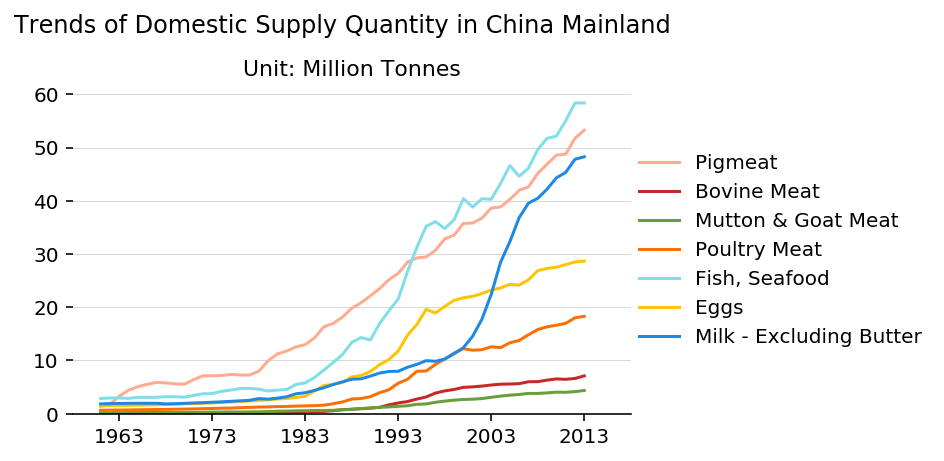

In [28]:
# 所有主要末梢类别, 加上末梢不重要但总类重要的总类
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)
# plotTrendsBar(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

# # 设置颜色
# cmeat,cfish,cegg,cmilk,coffal,cfat=\
# 'peru','deepskyblue','yellowgreen','darkgray','firebrick','orange'
# cpig,ccattle,cgoat,cbirds,cother=\
# 'hotpink','maroon','orangered','gold','lightslategray'

# # 重要总类的分类
# plotTrends(D, A, E, items_group='Animal Products', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cmeat,cfish,cegg,cmilk,coffal,cfat],
#           )
# plotTrends(D, A, E, items_group='Meat', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cpig,ccattle,cgoat,cbirds,cother],
#           )

### 2. An Area's World Ranking of Some Items

In [72]:
def ranking_AreaItemInWorld(
    area,
    element,
    items_group='',
    items=[],
    area_list=LIST_countries,
    fig_size=FIG_size,
    colors=CLs,
):  
    
    items = getItems(element=element, items_group=items_group, items=items)
    
    # make a pivot for a particular area where 
    # year, items as columns, items' rankings in areas list as values
    rankings = {}
    for i in items:
        if i in PVs_AreaYear[element].keys():
            df = PVs_AreaYear[element][i].copy()
            ranks = np.array([])
            try: 
                df_areas = df[df.index.isin(area_list)]
                for year in df_areas.columns:
                    rank = df_areas.sort_values(year, ascending=False).index.tolist().index(area)+1
                    ranks = np.append(ranks,rank)
                rankings[i]=ranks
            except:continue           
    df_rank = pd.DataFrame(rankings)
    df_rank.index = Years
    
    # plot settings
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)
    
    title_y=1.15
    
    # === ploting ===
    title = f"Changes in World Rankings of {' '.join(area.split(', ')).title()} {element.title()}"
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    df_ = df_rank.loc[X_ticks]      
    display(df_)
    df_.plot.line(color=colors, linestyle=':', marker='o', linewidth=2, alpha=1, ax=plt.gca())

    ax = plt.gca()
    ax.legend(labels=rankings.keys(),fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.gca().invert_yaxis()
    
    path = f'{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_02_{title}.png'
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[-0.5, 0], [fig_size[0]+2, fig_size[1]+0.5]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963      3.0         40.0                11.0           3.0            4.0   
1973      1.0         26.0                 6.0           3.0            4.0   
1983      1.0         25.0                 2.0           3.0            3.0   
1993      1.0          6.0                 1.0           2.0            1.0   
2003      1.0          3.0                 1.0           2.0            1.0   
2013      1.0          3.0                 1.0           1.0            1.0   

      Eggs  Milk - Excluding Butter  
1963   3.0                     32.0  
1973   3.0                     31.0  
1983   3.0                     23.0  
1993   1.0                     17.0  
2003   1.0                      7.0  
2013   1.0                      3.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_02_Changes in World Rankings of China Mainland Domestic Supply Quantity.png


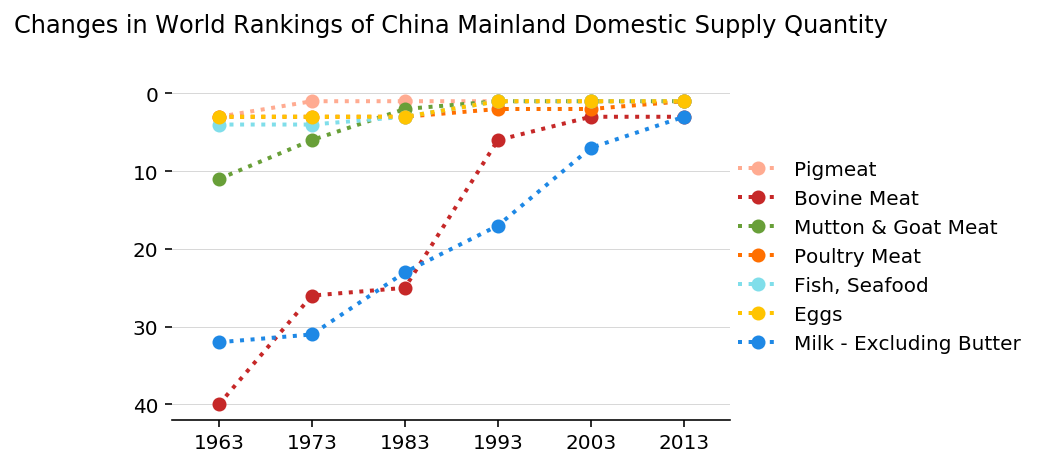

In [73]:
ranking_AreaItemInWorld(A,E)

### 3. Compare

#### World Map

In [31]:
# Map

countries = list(set(LIST_countries_OECD+LIST_countries_EU+LIST_countries_G20+LIST_countries_BRICS))
print(f'OECD, EU, G20 and BRICS are considered. {len(countries)} in total.')
print(countries)

# countries = list(set(LIST_countries_OECD)) + China
# print(f'OECD and China are considered. {len(countries)} in total.')
# display(countries)

def worldMap(
    element,
    items_group='',
    items=[],
    toUnit = '',
    changeUnit = 1,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='BuGn',
):
    items = getItems(element=element, items_group=items_group, items=items)

    df_all = {}

    for i in items:
        try:
            df = PVs_AreaYear[element][i].copy()
            df = df[df.index.isin(countries)]
            df_all[i] = pd.DataFrame()
            for y in years:
                df_y = df[[y]].dropna()
                df_y = df_y * changeUnit
                df_all[i] = pd.concat([df_all[i], df_y], sort=True, axis=1)

                title = f"{element.title()} ({''.join(i.split('- '))}, {y}, {toUnit})"
                cn_map = folium.Map(width=1600, height=800, location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
                threshold_scale = np.around(np.linspace(
                    df_y[y].values.min()-0.02, 
                    df_y[y].values.max()+df_y[y].values.max()/20, 
                    num=6, endpoint=True
                ),3)

                if y < 1992: geo_data_=f'{FAO_meta}/geojson/world_countries_before1992.json'
                elif y >= 1992: geo_data_=f'{FAO_meta}/geojson/world_countries.json'

                folium.Choropleth(
                    geo_data=geo_data_,
                    data=df_y,
                    name = y,
                    columns=[df_y.index, y],
                    key_on='feature.properties.name',
                    threshold_scale=threshold_scale,
                    nan_fill_color='gray',
                    fill_color=fill_color_,
                    fill_opacity=1, 
                    line_opacity=0.2,
                    legend_name=title,
                    show=False,
                    highlight=False,
                    reset=False
                ).add_to(cn_map)


    #             display(cn_map)

                path = f"{LOCAL_ROOT}/results/{Domain_folder}/map/GroupbyElements_{''.join(element.split('/'))}_03_01_{title[: title.find('(')]}_{''.join(i.split('- '))}_{y}.html"
                print('Atala saved as: ' + path)
                cn_map.save(path)
            
        except: pass

    for df in df_all.values():
        display(df.head())

OECD, EU, G20 and BRICS are considered. 52 in total.
['Croatia', 'Mexico', 'Portugal', 'China, Taiwan Province of', 'Israel', 'New Zealand', 'Luxembourg', 'Malta', 'Turkey', 'Indonesia', 'United Kingdom', 'Canada', 'Republic of Korea', 'Argentina', 'France', 'China, mainland', 'Greece', 'Ireland', 'Switzerland', 'Slovakia', 'South Africa', 'Chile', 'Romania', 'Cyprus', 'Austria', 'India', 'Bulgaria', 'United States of America', 'Iceland', 'Slovenia', 'Czechia', 'Italy', 'Australia', 'Lithuania', 'Brazil', 'Hungary', 'Denmark', 'China, Macao SAR', 'Netherlands', 'Spain', 'Latvia', 'Sweden', 'China, Hong Kong SAR', 'Russian Federation', 'Norway', 'Poland', 'Japan', 'Germany', 'Saudi Arabia', 'Finland', 'Estonia', 'Belgium']


In [32]:
# worldMap(
#     element=E,
#     items_group='',
#     items=[],
#     toUnit = 'Million Tonnes',
#     changeUnit = 1/1000000,
#     years = [Years[-1]-40, Years[-1]-20, Years[-1]],
#     fill_color_='BuGn',
# )

#### Compare with OECD

In [33]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

In [34]:
def sumOfGroup (
    element,
    areas_list,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    for i in items:
        df = PVs_YearArea[element][i].copy()
        
        areas = []
        for c in df.columns:
            if c in areas_list: areas.append(c)
        df = df[areas]
        df = df.fillna(np.nan)

        df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
            
        df = df['Sum']
        df_res = pd.concat([df_res, df],axis=1)
        
    df_res.columns = items
    df_res.index.names = ['Year']
    return df_res

In [35]:
def compareOtherAreasLine(
    area,
    element,
    df_area,
    dfs_compare={}, 
    toUnit='',
    changeUnit=1,
    colors = CLs,
    fig_size = FIG_size,
):
    dfs = {}
    for key, df in dfs_compare.items():
        dfs[key]=dfs_compare[key]*changeUnit
        print(key)
        display(dfs[key].head())
    
    df_area = DATA_area.copy() * changeUnit
    print(f'{area}: ')
    display(df_area.head())

    # ==== Line
    fig_size = FIG_size

    for i, c in zip(items, colors):

        title = f"Compare {element.title()} of {''.join(i.split('- '))} of {' '.join(area.split(', ')).title()} with OECD Total"
        sub_title = f"Unit: {toUnit}"
        fig = plt.figure(figsize = fig_size,dpi=DPI)
        plt.suptitle(title, fontsize=TIT_size, y=1.05)
        plt.title(sub_title, fontsize=TIT_size-1)
        
        for k, v in dfs.items():
            dfs[k][i].plot(color=GF_brand_gray, ax=plt.gca())
        ax=plt.gca()
        df_area[i].plot(color=c, ax=plt.gca())

        labels = list(dfs.keys())
        labels.append(area)
        ax = plt.gca()
        ax.legend(labels=labels, fontsize=LEG_size, frameon=False,
                 loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(X_ticks)
        ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
        ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
        ax.set_ylim(0,)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_03_02_{title}.png"
        print('Img saved as: ' + path)
        bbox = matplotlib.transforms.Bbox([[-1.8, 0], [fig_size[0]+2.5, fig_size[1]+0.6]])
        fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

In [36]:
DATA_world = trendsOfArea('World', E, items=items)
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)

# compareOtherAreasLine(
#     area=A,
#     element=E,
#     df_area=DATA_area.copy(),
#     dfs_compare={'OECD': DATA_OECD, }, 
#     toUnit='Million Tonnes',
#     changeUnit=1/1000000,
#     colors = CLs,
#     fig_size = FIG_size,
# )

In [37]:
def areaInWorld(
    area_,
    total_,
    df_area_,
    df_total_,
    ax1_ylim,
    ax2_ylim,
    element,
    colors=CLs,
):

    fig_size = (8,4)

    fig = plt.figure(figsize = fig_size, dpi=DPI)
    fig.tight_layout()                          
    plt.subplots_adjust(hspace =0.05)
    
    title = f"{element} of {' '.join(area_.split(', '))} in the {total_}"
    sub_title = f"Unit: {toUnit}"

    ax1 = fig.add_subplot(211)
    plt.suptitle(title, fontsize=TIT_size, y=1)
    plt.title(sub_title, fontsize=TIT_size-1)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.1, ax=ax1)
    df_area_.plot.bar(color=colors, width=0.8, ax=ax1)

    ax1.legend_.remove()
    ax1.xaxis.label.set_visible(False)
    ax1.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax1.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks([])
    ax1.set_ylim(ax1_ylim[0], ax1_ylim[1])
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    ax2 = fig.add_subplot(212)
    
    df_area_.plot.bar(color=colors, width=0.8, ax=ax2)
    plt.legend()
    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.1, ax=ax2)
    plt.legend(labels=ITEMs, fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)

    ax2.xaxis.label.set_visible(False)
    ax2.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax2.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax2.set_ylim(ax2_ylim[0], ax2_ylim[1])
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_03_03_{title}.png"
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[0.5, 0], [fig_size[0]+1.5, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

In [38]:
toUnit='Million Tonnes'
changeUnit=1/1000000

df_world=DATA_world.loc[X_ticks].copy()*changeUnit
df_OECD=DATA_OECD.loc[X_ticks].copy()*changeUnit
df_area=DATA_area.loc[X_ticks].copy()*changeUnit

print('World: ')
display(df_world.head())
print('OECD: ')
display(df_OECD.head())
print(f'{A}: ')
display(df_area.head())

# areaInWorld(
#     element=E,
#     area_=A, total_='World', 
#     df_area_=df_area.copy(), df_total_=df_world, 
#     ax1_ylim=(175,800), ax2_ylim=(0,175),
# )
# areaInWorld(
#     element=E,
#     area_='OECD', total_='World', 
#     df_area_=df_OECD.copy(), df_total_=df_world, 
#     ax1_ylim=(175,800), ax2_ylim=(0,175),)

World: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963  28.0048      31.5444              6.0535        9.6584        41.8708   
1973  40.7316      39.9834              6.5296       17.3811        61.2661   
1983  55.1670      48.2623              7.6099       28.8355        76.9685   
1993  73.3257      53.8514              9.6854       47.2382       101.9228   
2003  91.5283      59.0877             11.4976       74.2981       127.7774   

         Eggs  Milk - Excluding Butter  
1963  15.5980                 341.2402  
1973  21.8739                 408.0019  
1983  29.1507                 489.2143  
1993  40.7663                 522.6746  
2003  58.2756                 608.1391

OECD: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963  16.2854      18.0704              2.5653        6.3419        24.9233   
1973  21.6500      21.9670              2.6501       11.0611        31.1760   
1983  27.7523      24.4275              2.5115       15.8099        36.2797   
1993  31.8416      25.3338              2.7866       24.5998        42.5872   
2003  35.7644      27.2785              2.5539       33.4202        42.1327   

         Eggs  Milk - Excluding Butter  
Year                                    
1963   9.8722                 201.6115  
1973  12.5409                 220.5031  
1983  14.1350                 249.5285  
1993  15.5189                 257.3553  
2003  18.0258                 278.9500

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963   3.2693       0.1070              0.1200        0.6695         2.9424   
1973   7.1110       0.2065              0.2795        0.9613         3.7799   
1983  12.9705       0.3241              0.5424        1.4504         5.7780   
1993  26.3680       2.0006              1.3712        5.7230        21.5713   
2003  38.6379       5.3763              3.0679       12.5577        40.2793   

         Eggs  Milk - Excluding Butter  
1963   1.4885                   1.9078  
1973   2.0154                   2.1334  
1983   3.2652                   3.9261  
1993  11.7682                   7.9527  
2003  23.2294                  22.4197

In [39]:
def areaInWorldPercent(
    area_,
    total_,
    df_area_,
    df_total_,
    element,
    colors=CLs,
):

    fig_size = (8,4)

    title = f"Percentages (%) of {' '.join(area_.split(', '))}'s {element} in the {total_}"
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.1, ax=plt.gca())
    df_area_.plot.bar(color=CLs, width=0.8, ax=plt.gca())

    ax=plt.gca()
    ax.legend_.remove()
    ax.xaxis.label.set_visible(False)
    ax.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_03_03_{title}_Bar.png"
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[-0.5, 0], [fig_size[0]+1.5, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

In [40]:
percent_world = pd.DataFrame()
percent_OECD = pd.DataFrame()
percent_area = pd.DataFrame()

percent_world['Year'] = X_ticks
percent_OECD['Year'] = X_ticks
percent_area['Year'] = X_ticks

percent_world.set_index('Year', inplace=True)
percent_OECD.set_index('Year', inplace=True)
percent_area.set_index('Year', inplace=True)

for i in items:
    percent_world[i] = np.array(df_world[i]/df_world[i])*100
    percent_OECD[i] = np.array(df_OECD[i]/df_world[i])*100
    percent_area[i] = np.array(df_area[i]/df_world[i])*100

print('World: ')
display(percent_world.head())
print('OECD: ')
display(percent_OECD.head())
print(f'{A}: ')
display(percent_area.head())

# areaInWorldPercent(
#     element=E,
#     area_=A, total_='World', 
#     df_area_=percent_area.copy(), df_total_=percent_world
# )
# areaInWorldPercent(
#     element=E,
#     area_='OECD', 
#     total_='World', 
#     df_area_=percent_OECD.copy(), df_total_=percent_world
# )

World: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963    100.0        100.0               100.0         100.0          100.0   
1973    100.0        100.0               100.0         100.0          100.0   
1983    100.0        100.0               100.0         100.0          100.0   
1993    100.0        100.0               100.0         100.0          100.0   
2003    100.0        100.0               100.0         100.0          100.0   

       Eggs  Milk - Excluding Butter  
Year                                  
1963  100.0                    100.0  
1973  100.0                    100.0  
1983  100.0                    100.0  
1993  100.0                    100.0  
2003  100.0                    100.0

OECD: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963  58.1522      57.2856             42.3768       65.6623        59.5243   
1973  53.1529      54.9402             40.5859       63.6389        50.8863   
1983  50.3060      50.6140             33.0028       54.8281        47.1358   
1993  43.4249      47.0440             28.7711       52.0761        41.7838   
2003  39.0746      46.1661             22.2122       44.9812        32.9736   

         Eggs  Milk - Excluding Butter  
Year                                    
1963  63.2917                  59.0820  
1973  57.3329                  54.0446  
1983  48.4894                  51.0060  
1993  38.0679                  49.2382  
2003  30.9319                  45.8694

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963  11.6741       0.3392              1.9823        6.9322         7.0273   
1973  17.4582       0.5165              4.2805        5.5307         6.1696   
1983  23.5114       0.6716              7.1276        5.0299         7.5070   
1993  35.9601       3.7151             14.1573       12.1152        21.1644   
2003  42.2141       9.0989             26.6828       16.9018        31.5230   

         Eggs  Milk - Excluding Butter  
Year                                    
1963   9.5428                   0.5591  
1973   9.2137                   0.5229  
1983  11.2012                   0.8025  
1993  28.8675                   1.5215  
2003  39.8613                   3.6866

In [41]:
def plotPieCompare(
    element,
    area_,
    total_,
    df_area_,
    df_total_,
    years=[1963, 2013],
    fig_size = (12,6),
):
    
    title = f"Percentages (%) of {' '.join(area_.split(', '))}'s Main Animal Produced Food {element} in the {total_}"

    # plot all items in the world...

    fig = plt.figure(figsize = fig_size,dpi=300)
    fig.tight_layout()                          
    plt.subplots_adjust(wspace =0.3, hspace =0.2)
    plt.suptitle(title, fontsize=TIT_size)

    df_compare = {}
    fig_no=0
    for y in years:
        fig_no+=1

        df_compare[y] = pd.concat([df_area_.loc[y].transpose(), df_total_.loc[y].transpose()], axis=1)
        df_compare[y].columns = [area_, total_]
        df_compare[y]['Others'] = df_compare[y][total_]-df_compare[y][area_]
        print(y, area_)
        display(df_compare[y])

        df = df_compare[y].copy()

        ax = fig.add_subplot(1,2, fig_no)
        plt.title(y, fontsize=TIT_size)

        size = 0.5
        outer_radius = 2
        inner_colors = [GF_brand_gray, Gray1]

        outer_explode = np.zeros(len(items))
        inner_explode = np.zeros(len(items*2))

# #         Explode Items
#         for n in range(len(items)):
#             if items[n] in ITEMs_main:
#                 outer_explode[n] = 0.15
#                 inner_explode[2*n] = 0.15

        area_pct = ['{}{}'.format(int(df.loc[i][area_]/df.loc[i][total_]*100),'%') for i in df.index.values]
        inner_labels = []
        for i in area_pct:
            inner_labels.append(i)
            inner_labels.append('')

        shadow = False
        startangle = 0
        
        plt.pie(
            df[total_].values, 
            autopct='%1.0f%%',
            pctdistance=1.1,
#             explode=list(outer_explode),
            radius=outer_radius, 
            colors=CLs,
            center = (0,0),
            textprops = {'fontsize':LEG_size}, 
            wedgeprops=dict(width=size),
            shadow=shadow,
            startangle=startangle,
            )
        plt.pie(
            df[[area_,'Others']].values.flatten(), 
            labels=inner_labels,
            labeldistance = 0.85,
#             explode=list(inner_explode),
            radius=outer_radius-size, 
            colors=inner_colors,
            center = (0,0),
            textprops = {'fontsize':LEG_size}, 
            wedgeprops=dict(width=size),
            shadow=shadow,
            startangle=startangle,
        )
        plt.axis('equal')          # equal 使得为正圆

    ax=plt.gca()
    ax.legend(labels=list(df.index.values)+[area_,'Other'],frameon=False,fontsize=LEG_size, 
              loc='lower center',bbox_to_anchor=(-0.1,-0.1),borderaxespad = 0.)

    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_03_03_{title}_Pie.png"
    print('Img saved as: ' + path)
    bbox = matplotlib.transforms.Bbox([[0.2, 0], [fig_size[0], fig_size[1]+0.2]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

In [42]:
# # China
# # 设置主要贡献方面
# # ITEMs_main = ['Pigmeat', 'Fish, Seafood', 'Eggs']

# plotPieCompare(
#     element=E,
#     area_=A, total_='World',
#     df_area_=df_area.copy(), df_total_=df_world.copy(),
#     years=[1963, 2013],
#     fig_size = (12,6),
# )

# # OECD
# # 设置主要贡献方面
# # ITEMs_main = ['Milk - Excluding Butter', 'Bovine Meat', 'Poultry Meat']

# plotPieCompare(
#     element=E,
#     area_='OECD', total_='World',
#     df_area_=df_OECD.copy(), df_total_=df_world.copy(),
#     years=[1963, 2013],
#     fig_size = (12,6),
# )

#### Compare with Top 5

In [43]:
def compareToTopAreas(
    area,
    element,
    items_group='',
    items=[],
    toUnit='',
    changeUnit=1,
    colors=CLs
): 
    items = getItems(element=element, items_group=items_group, items=items)

    dfs = PVs_AreaYear[element]
    
    years = X_ticks
    
    fig_size=FIG_size

    # === Bar Plot ===
    for i, c in zip(items, colors):
        
        title = f"{element.title()} of {''.join(i.split('- '))}: {' '.join(area.split(', ')).title()} Vs. World Top 5"
        sub_title = f"Unit: {toUnit}"
        fig = plt.figure(figsize=fig_size, dpi=DPI)
        plt.suptitle(title, fontsize=TIT_size, y=1.05)
        plt.title(sub_title, fontsize=TIT_size-1)
        
        df = dfs[i][dfs[i].index.isin(LIST_countries)].copy()
        df = df * changeUnit
        df = df.dropna()
        
        df_area = df[df.index==area][years]
        df_top = df.sort_values([years[-1]],ascending=False)[years].head()
        
        display(df_top)
                    
        if area in df_top.index:
            df_top.plot.bar(color=c, width=0.8, edgecolor='black', linewidth=0.5, ax=plt.gca(), )
                    
            ax=plt.gca()
            
            for p in ax.patches[0:5]:
                p.set_hatch(hatch='..')
            for p in ax.patches[5:10]:
                p.set_hatch(hatch='//')
            for p in ax.patches[10:15]:
                p.set_hatch(hatch='---')
            for p in ax.patches[15:20]:
                p.set_hatch(hatch='xx')
            for p in ax.patches[20:25]:
                p.set_hatch(hatch='O')
            for p in ax.patches[25:30]:
                p.set_hatch(hatch='+++')
            
            ax.legend(fontsize=LEG_size,frameon=False,
                     loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
            ax.set_ylim(0,)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
        else: 

            df_top.plot.bar(ax=plt.gca())

            ax=plt.gca()
            ax.legend(fontsize=LEG_size,frameon=False,
                     loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
            ax.set_ylim(0,)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)

        
        path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/GroupbyElements_03_04_{title}.png"
        bbox = matplotlib.transforms.Bbox([[-1, -2], [fig_size[0]+1.5, fig_size[1]+1]])
#         print('Img saved as: ' + path)
#         fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)

In [44]:
# items=ITEMs.copy()

# compareToTopAreas(A, E, items=items, toUnit='Million Tonnes', changeUnit=1/1000000)

### Other Regions Trends

In [45]:
# areas = [
#     'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
#     'South-Eastern Asia', 'Japan', 'Republic of Korea',
# ]
# for a in areas:
#     print(a)
#     plotTrendsLine(a, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

### Production 

In [74]:
# 给 Elements 赋值
E = 'Production'

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


'Production'

'Meat'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  1.2942e+05  1.3221e+05  1.3897e+05  1.4383e+05  1.5020e+05   
Africa       3.6320e+06  3.6758e+06  3.7672e+06  3.9208e+06  4.0488e+06   
Albania      2.5410e+04  2.5720e+04  2.5000e+04  2.3700e+04  2.5225e+04   
Algeria      8.2840e+04  8.0160e+04  7.5644e+04  8.2345e+04  8.9856e+04   
Americas     2.6058e+07  2.6575e+07  2.7881e+07  2.8835e+07  2.8840e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  1.7521e+05  1.8423e+05  2.0163e+05  2.0223e+05  1.8912e+05   
Africa       4.1934e+06  4.2827e+06  4.4423e+06  4.6392e+06  4.7241e+06   
Albania      2.6900e+04  3.2540e+04  3.0220e+04  3.0500e+04  3.1180e+04   
Algeria      9.1771e+04  9.5718e+04  1.0850e+05  1.1312e+05  1.1386e+05   
Americas     3.0126e+07  3.1524e+07  3.2496e+07  3.3356e+07  3.4353e+07   

                   1971        1972        1973        1974        1975  \
Area                                                                      
Afghanistan  1.9127e+05  1.7096e+05  1.8511e+05  1.9131e+05  1.9793e+05   
Africa       4.7889e+06  4.9402e+06  5.0230e+06  5.0409e+06  5.1049e+06   
Albania      3.2665e+04  3.2220e+04  3.2110e+04  3.3450e+04  3.3200e+04   
Algeria      1.2435e+05  1.3196e+05  1.3933e+05  1.4291e+05  1.4565e+05   
Americas     3.4605e+07  3.5049e+07  3.4205e+07  3.5856e+07  3.6040e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  2.2243e+05  2.2899e+05  2.3446e+05  2.3472e+05  2.3881e+05   
Africa       5.3387e+06  5.5811e+06  5.8796e+06  6.0406e+06  6.2122e+06   
Albania      3.6670e+04  3.5640e+04  3.9500e+04  4.1000e+04  4.1800e+04   
Algeria      1.5151e+05  1.5930e+05  1.5897e+05  1.6855e+05  1.8607e+05   
Americas     3.9232e+07  3.9892e+07  4.0420e+07  4.1024e+07  4.2761e+07   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  2.4577e+05  2.4855e+05  2.3748e+05  2.2594e+05  2.0892e+05   
Africa       6.3102e+06  6.5661e+06  6.7913e+06  7.0182e+06  7.1945e+06   
Albania      4.4150e+04  4.4000e+04  4.3400e+04  4.1600e+04  4.2700e+04   
Algeria      2.0042e+05  2.3088e+05  2.5654e+05  2.9515e+05  3.2226e+05   
Americas     4.4029e+07  4.3211e+07  4.4567e+07  4.4685e+07  4.5800e+07   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  1.9484e+05  2.0444e+05  2.1354e+05  2.2156e+05  2.4505e+05   
Africa       7.2261e+06  7.3514e+06  7.5102e+06  7.7916e+06  8.1852e+06   
Albania      4.1600e+04  4.3300e+04  4.7600e+04  5.0550e+04  5.4100e+04   
Algeria      3.3357e+05  3.7049e+05  3.9191e+05  4.1811e+05  4.3601e+05   
Americas     4.6939e+07  4.7631e+07  4.9504e+07  5.0040e+07  5.1339e+07   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  2.4746e+05  2.4517e+05  2.5552e+05  2.7291e+05  2.8883e+05   
Africa       8.4221e+06  8.6486e+06  8.6186e+06  8.7328e+06  9.0420e+06   
Albania      4.8900e+04  5.1400e+04  5.5300e+04  6.4146e+04  6.6700e+04   
Algeria      4.5365e+05  4.6941e+05  4.8990e+05  4.9883e+05  4.9739e+05   
Americas     5.3384e+07  5.5496e+07  5.7094e+07  6.0348e+07  6.3266e+07   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  3.1008e+05  3.3948e+05  3.7036e+05  3.6541e+05  3.1928e+05   
Africa       9.3493e+06  9.8363e+06  1.0018e+07  1.0501e+07  1.0929e+07   
Albania      5.9149e+04  5.8588e+04  

'Production'

'Pigmeat'

1961       1962       1963       1964       1965       1966  \
Area                                                                         
Africa     163253.0   168611.0   172090.0   183462.0   188691.0   193505.0   
Albania      3580.0     3640.0     3200.0     3200.0     3640.0     4300.0   
Algeria        40.0       40.0       40.0       80.0       92.0       36.0   
Americas  7225713.0  7449545.0  7706601.0  7797396.0  7231919.0  7433072.0   
Angola       8000.0     8000.0     8000.0     8000.0     9000.0     9000.0   

               1967       1968       1969       1970       1971       1972  \
Area                                                                         
Africa     206304.0   212453.0   228980.0   229622.0   236846.0   257639.0   
Albania      4880.0     5570.0     6100.0     6280.0     6440.0     6560.0   
Algeria        40.0       50.0       75.0       80.0       80.0       80.0   
Americas  8115647.0  8351639.0  8326163.0  8765827.0  9573297.0  9044058.0   
Angola       9000.0     9000.0     9000.0     9000.0     9500.0     9800.0   

               1973       1974       1975       1976       1977       1978  \
Area                                                                         
Africa     269162.0   261625.0   264643.0   276473.0   288966.0   293973.0   
Albania      6160.0     6400.0     6400.0     6600.0     6800.0     6800.0   
Algeria        82.0       80.0       80.0       80.0       80.0       82.0   
Americas  8709255.0  9281283.0  8282929.0  8836217.0  9396194.0  9620815.0   
Angola      10350.0    11000.0    11500.0    12250.0    13000.0    13750.0   

                1979        1980        1981        1982        1983  \
Area                                                                   
Africa    2.9503e+05  3.0645e+05  3.2518e+05  3.3680e+05  3.4425e+05   
Albania   7.0000e+03  7.0000e+03  8.8000e+03  8.8000e+03  9.2000e+03   
Algeria   8.2000e+01  8.4000e+01  8.8000e+01  8.8000e+01  8.8000e+01   
Americas  1.0892e+07  1.1729e+07  1.1440e+07  1.0630e+07  1.1249e+07   
Angola    1.5750e+04  1.6500e+04  1.7000e+04  1.7750e+04  1.8500e+04   

                1984        1985        1986        1987        1988  \
Area                                                                   
Africa    3.6291e+05  3.7859e+05  4.0786e+05  4.4598e+05  4.6485e+05   
Albania   9.6000e+03  1.0400e+04  1.1200e+04  1.1200e+04  1.2000e+04   
Algeria   9.2000e+01  9.6000e+01  1.0000e+02  1.0000e+02  1.0400e+02   
Americas  1.0943e+07  1.0873e+07  1.0313e+07  1.0632e+07  1.1369e+07   
Angola    1.9250e+04  2.0000e+04  2.0600e+04  2.1000e+04  2.1150e+04   

                1989        1990        1991        1992        1993  \
Area                                                                   
Africa    5.1834e+05  5.4198e+05  5.2788e+05  5.6199e+05  5.5676e+05   
Albania   1.2000e+04  1.3300e+04  9.0000e+03  1.0600e+04  1.2500e+04   
Algeria   1.0800e+02  1.1200e+02  1.1600e+02  1.2000e+02  1.2000e+02   
Americas  1.1189e+07  1.0978e+07  1.1480e+07  1.2286e+07  1.2565e+07   
Angola    2.2000e+04  2.3992e+04  2.3000e+04  2.4000e+04  2.4500e+04   

                1994        1995        1996        1997        1998  \
Area                                                                   
Africa    5.6659e+05  7.0755e+05  7.1539e+05  7.3373e+05  7.2104e+05   
Albania   1.3550e+04  1.3600e+04  6.3600e+03  6.6000e+03  6.5000e+03   
Algeria   1.2800e+02  1.2800e+02  1.2800e+02  1.2800e+02  1.2800e+02   
Americas  1.3193e+07  1.3477e+07  1.3170e+07  1.3390e+07  1.4700e+07   
Angola    2.5000e+04  2.6000e+04  2.8000e+04  2.9000e+04  2.9058e+04   

                1999        2000        2001        2002        2003  \
Area                                                                   
Africa    7.3086e+05  7.2772e+05  7.4687e+05  7.7790e+05  7.7951e+05   
Albania   6.2000e+03  7.8000e+03  7.8000e+03  8.6000e+03  8.6000e+03   
Algeria   1.2800e+02  1.2800e+02  1.2800e+02  1.2800e+02  1.2800e+

'Production'

'Poultry Meat'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan     5600.0     6000.0     6160.0     6400.0     6800.0     7200.0   
Africa        346035.0   361882.0   376062.0   398915.0   418092.0   446635.0   
Albania         1530.0     1580.0     1700.0     1900.0     2385.0     2900.0   
Algeria        14290.0    15610.0    16620.0    18250.0    20090.0    21720.0   
Americas     4085064.0  4053659.0  4277564.0  4489555.0  4861934.0  5278505.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan     7600.0     8000.0     9600.0     9600.0     9600.0     9600.0   
Africa        475392.0   501151.0   543414.0   573991.0   598107.0   643388.0   
Albania         3000.0     3200.0     3400.0     3400.0     3800.0     3900.0   
Algeria        23168.0    24670.0    25990.0    27210.0    28650.0    30150.0   
Americas     5532681.0  5495200.0  5840015.0  6323221.0  6404154.0  6764639.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    10000.0    10000.0    10400.0    10400.0    10800.0    11200.0   
Africa        681909.0   693689.0   759871.0   819019.0   869222.0   920834.0   
Albania         4300.0     4750.0     5300.0     5900.0     6300.0     6800.0   
Algeria        32150.0    34150.0    36150.0    38150.0    40150.0    42150.0   
Americas     6857857.0  7067412.0  6949194.0  7707185.0  7960209.0  8496117.0   

                  1979        1980        1981        1982        1983  \
Area                                                                     
Afghanistan    12000.0  1.2000e+04  1.2400e+04  1.2400e+04  1.2560e+04   
Africa        947622.0  1.0007e+06  1.0607e+06  1.1404e+06  1.2492e+06   
Albania         7300.0  7.8000e+03  8.2500e+03  8.8000e+03  7.9000e+03   
Algeria        44150.0  6.0150e+04  7.2150e+04  8.8150e+04  1.0016e+05   
Americas     9483042.0  1.0176e+07  1.0875e+07  1.1137e+07  1.1324e+07   

                   1984        1985        1986        1987        1988  \
Area                                                                      
Afghanistan  1.2800e+04  1.2960e+04  1.3120e+04  1.2960e+04  1.2800e+04   
Africa       1.3377e+06  1.4124e+06  1.5005e+06  1.5757e+06  1.5924e+06   
Albania      7.5000e+03  6.0000e+03  6.0000e+03  6.0000e+03  6.0000e+03   
Algeria      1.5022e+05  1.6022e+05  1.7023e+05  1.7223e+05  1.8224e+05   
Americas     1.1505e+07  1.2158e+07  1.2990e+07  1.4241e+07  1.4831e+07   

                   1989        1990        1991        1992        1993  \
Area                                                                      
Afghanistan  1.2560e+04  1.2400e+04  1.2160e+04  1.2000e+04  1.1840e+04   
Africa       1.6531e+06  1.8588e+06  1.8661e+06  1.9057e+06  1.9187e+06   
Albania      6.7500e+03  6.7000e+03  6.3000e+03  2.5000e+03  3.3000e+03   
Algeria      1.8625e+05  1.9426e+05  1.9728e+05  1.9928e+05  2.0428e+05   
Americas     1.5405e+07  1.6696e+07  1.7969e+07  1.9175e+07  2.0404e+07   

                   1994        1995        1996        1997        1998  \
Area                                                                      
Afghanistan  1.1600e+04  1.2320e+04  1.3040e+04  1.4000e+04  1.5040e+04   
Africa       2.0191e+06  2.1477e+06  2.2801e+06  2.4834e+06  2.5109e+06   
Albania      3.7000e+03  3.9000e+03  3.5000e+03  3.7000e+03  5.1000e+03   
Algeria      2.1036e+05  2.0836e+05  2.1532e+05  2.2033e+05  2.4734e+05   
Americas     2.1903e+07  2.3585e+07  2.4399e+07  2.5616e+07  2.6686e+07   

                   1999        2000        2001        2002        2003  \
Area                                                                      
Afghanistan  1.4000e+04  1.3200e+04  1.3120e+04  2.4000e+04  2.8400

'Production'

'Bovine Meat'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  4.3000e+04  4.5800e+04  4.7250e+04  4.8000e+04  4.8700e+04   
Africa       1.8984e+06  1.9092e+06  1.9749e+06  2.0506e+06  2.1076e+06   
Albania      7.3000e+03  7.4000e+03  7.6000e+03  6.0000e+03  6.6000e+03   
Algeria      2.3000e+04  2.1000e+04  1.9301e+04  2.0600e+04  2.3500e+04   
Americas     1.3468e+07  1.3803e+07  1.4635e+07  1.5285e+07  1.5493e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  6.8000e+04  6.5000e+04  7.1000e+04  7.5000e+04  6.2000e+04   
Africa       2.1676e+06  2.1644e+06  2.2254e+06  2.3174e+06  2.3744e+06   
Albania      6.9000e+03  8.4600e+03  7.4000e+03  8.9000e+03  9.9000e+03   
Algeria      2.5300e+04  2.8200e+04  3.2400e+04  3.3700e+04  2.9800e+04   
Americas     1.6127e+07  1.6586e+07  1.7335e+07  1.7901e+07  1.7952e+07   

                   1971        1972        1973        1974        1975  \
Area                                                                      
Afghanistan  6.2000e+04  6.1000e+04  6.3000e+04  6.2000e+04  6.1000e+04   
Africa       2.3791e+06  2.4378e+06  2.5386e+06  2.5708e+06  2.5010e+06   
Albania      1.0700e+04  1.0600e+04  1.0500e+04  1.0900e+04  9.9000e+03   
Algeria      3.7695e+04  4.1938e+04  4.3877e+04  4.7710e+04  4.6020e+04   
Americas     1.7342e+07  1.7979e+07  1.7412e+07  1.8340e+07  1.9640e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  6.2300e+04  6.6000e+04  6.7000e+04  7.1000e+04  6.7000e+04   
Africa       2.6209e+06  2.7302e+06  2.9027e+06  2.9913e+06  3.0388e+06   
Albania      1.2270e+04  1.1200e+04  1.3500e+04  1.4100e+04  1.4400e+04   
Algeria      4.7000e+04  4.9820e+04  4.4482e+04  4.4800e+04  4.4800e+04   
Americas     2.1518e+07  2.1379e+07  2.1165e+07  1.9517e+07  1.9774e+07   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  6.8000e+04  6.9000e+04  6.8000e+04  6.8000e+04  6.8000e+04   
Africa       3.0033e+06  3.1430e+06  3.2090e+06  3.2944e+06  3.3336e+06   
Albania      1.4500e+04  1.4500e+04  1.4900e+04  1.4600e+04  1.6500e+04   
Algeria      4.3700e+04  4.8000e+04  6.5600e+04  4.7500e+04  6.6800e+04   
Americas     2.0603e+07  2.0341e+07  2.0902e+07  2.1156e+07  2.1688e+07   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  6.8000e+04  7.0000e+04  7.1000e+04  7.1000e+04  8.6400e+04   
Africa       3.2306e+06  3.1515e+06  3.1615e+06  3.2340e+06  3.3663e+06   
Albania      1.5400e+04  1.6500e+04  1.8700e+04  1.9800e+04  2.2000e+04   
Algeria      6.6360e+04  7.3552e+04  8.1000e+04  8.5000e+04  8.9500e+04   
Americas     2.2539e+07  2.1651e+07  2.2157e+07  2.2267e+07  2.2459e+07   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  8.6400e+04  8.6400e+04  9.7200e+04  1.1340e+05  1.3000e+05   
Africa       3.5526e+06  3.6265e+06  3.6490e+06  3.5459e+06  3.4903e+06   
Albania      2.1100e+04  2.3400e+04  2.4300e+04  2.8300e+04  3.0800e+04   
Algeria      9.4270e+04  9.6500e+04  9.8200e+04  1.0060e+05  1.0060e+05   
Americas     2.2728e+07  2.2841e+07  2.2952e+07  2.4088e+07  2.5054e+07   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  1.4300e+05  1.5600e+05  1.7100e+05  1.4900e+05  1.2600e+05   
Africa       3.6182e+06  3.7317e+06  3.8281e+06  4.0211e+06  4.2024e+06   
Albania      3.2600e+04  3.2500e+04  

'Production'

'Offals'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    25890.0    26513.0    27660.0    28637.0    29676.0    35561.0   
Africa        506752.0   515555.0   519707.0   538710.0   552708.0   575991.0   
Albania         5009.0     5006.0     4884.0     4664.0     4863.0     4894.0   
Algeria        10979.0    10179.0     9086.0     9831.0    10696.0    11071.0   
Americas     1938864.0  2021659.0  2114489.0  2112381.0  2090235.0  2177327.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    36874.0    40613.0    40603.0    41338.0    41549.0    37449.0   
Africa        579477.0   596505.0   611807.0   616354.0   626759.0   639705.0   
Albania         6106.0     5427.0     5136.0     5172.0     5096.0     5113.0   
Algeria        11579.0    13122.0    13610.0    13246.0    14313.0    15472.0   
Americas     2284958.0  2391469.0  2446836.0  2475861.0  2410690.0  2422381.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    37324.0    37437.0    38559.0    43519.0    44244.0    45670.0   
Africa        659893.0   660993.0   645867.0   673833.0   702245.0   745761.0   
Albania         5082.0     5317.0     5229.0     5667.0     5524.0     5889.0   
Algeria        16394.0    17409.0    16644.0    17726.0    18305.0    17016.0   
Americas     2345393.0  2464114.0  2577865.0  2819703.0  2873194.0  2913703.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    45797.0    46430.0    47730.0    48080.0    45836.0    43536.0   
Africa        767181.0   778350.0   770829.0   793263.0   816771.0   831568.0   
Albania         5835.0     6023.0     6177.0     6266.0     6347.0     6365.0   
Algeria        18752.0    18874.0    19828.0    21612.0    24555.0    21514.0   
Americas     2854189.0  2903739.0  2994727.0  2898499.0  2959137.0  2958785.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    40294.0    37678.0    39555.0    41282.0    42709.0    41736.0   
Africa        840701.0   850991.0   850020.0   865737.0   881665.0   931532.0   
Albania         6681.0     6453.0     6401.0     6587.0     7037.0     6696.0   
Algeria        24471.0    24027.0    28738.0    31023.0    34283.0    35720.0   
Americas     3047126.0  3065268.0  2990813.0  3104049.0  3177214.0  3193920.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    42136.0    41536.0    42686.0    45886.0    49146.0    53333.0   
Africa        961944.0   979739.0   967337.0   981229.0   997200.0  1028532.0   
Albania         6767.0     7971.0     8522.0    10746.0    11818.0    10297.0   
Algeria        36564.0    38450.0    39270.0    38296.0    36128.0    37167.0   
Americas     3276999.0  3297371.0  3345690.0  3494477.0  3553820.0  3600806.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan    58520.0    63317.0    57084.0    49844.0    42390.0    48530.0   
Africa       1068933.0  1117010.0  1180325.0  1235343.0  1205286.0  1264629.0   
Albania         9806.0    10090.0    10287.0    11099.0    11047.0    11366.0   
Algeria        35611.0    34123.0    38389.0    39123.0    36708.0    37483.0   
Americas     3619974.0  3716155.0  3861742.0  3920286.0  3941287.0  4004433.0   

                  2003       2004       20

'Production'

'Mutton & Goat Meat'

1961      1962      1963      1964      1965      1966  \
Area                                                                      
Afghanistan   73220.0   72375.0   75530.0   79750.0   84375.0   89690.0   
Africa       716505.0  720742.0  716713.0  739287.0  775102.0  805689.0   
Albania       13000.0   13100.0   12500.0   12600.0   12600.0   12800.0   
Algeria       39900.0   37900.0   34213.0   37735.0   39444.0   38035.0   
Americas     816304.0  810410.0  770949.0  732204.0  742626.0  776113.0   

                 1967      1968      1969      1970      1971      1972  \
Area                                                                      
Afghanistan  100312.0  111312.0  106312.0  106200.0  107312.0   88000.0   
Africa       829787.0  876976.0  916357.0  904806.0  921689.0  939356.0   
Albania       16200.0   14050.0   12100.0   11600.0   11725.0   11160.0   
Algeria       37700.0   44895.0   46743.0   50000.0   51260.0   52654.0   
Americas     770760.0  779007.0  734373.0  745346.0  739044.0  683777.0   

                 1973      1974      1975      1976      1977       1978  \
Area                                                                       
Afghanistan   99550.0  106550.0  113500.0  136500.0  137260.0   141260.0   
Africa       882989.0  855267.0  902243.0  938746.0  981182.0  1037942.0   
Albania       11150.0   11400.0   11600.0   11900.0   11340.0    12400.0   
Algeria       55424.0   53504.0   54940.0   58280.0   60060.0    63513.0   
Americas     647140.0  615747.0  600688.0  581371.0  568523.0   535688.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan   138040.0   145940.0   152500.0   154280.0   144461.0   133681.0   
Africa       1068468.0  1092140.0  1121219.0  1107819.0  1126212.0  1137052.0   
Albania        12600.0    12600.0    12600.0    11900.0    11400.0     9900.0   
Algeria        70062.0    71433.0    74733.0    84845.0    81070.0    88550.0   
Americas      527823.0   517666.0   549315.0   563102.0   565941.0   557684.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan   118000.0   106700.0   113780.0   120860.0   127940.0   135012.0   
Africa       1165975.0  1165181.0  1246202.0  1335339.0  1402207.0  1423053.0   
Albania         9800.0     9000.0     9600.0    10900.0    12000.0    12000.0   
Algeria        86140.0    88148.0   115243.0   119082.0   137173.0   142405.0   
Americas      557769.0   568578.0   557269.0   580997.0   597026.0   615649.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan   137300.0   132980.0   131600.0   134200.0   133600.0   144800.0   
Africa       1463770.0  1514863.0  1476634.0  1539438.0  1608286.0  1626448.0   
Albania        12500.0    14800.0    15200.0    18500.0    18300.0    16600.0   
Algeria       152230.0   163750.0   177600.0   178100.0   178450.0   190000.0   
Americas      617969.0   601338.0   600135.0   606429.0   588965.0   533629.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan   159600.0   174100.0   192100.0   169700.0   146100.0   118800.0   
Africa       1730378.0  1816275.0  1931527.0  2003287.0  2067431.0  2112162.0   
Albania        15700.0    16700.0    18100.0    19500.0    19355.0    19500.0   
Algeria       178860.0   179160.0   175475.0   176350.0   177350.0   177250.0   
Americas      516658.0   506293.0   533455.0   550646.0   549410.0   544417.0   

                  2003       2004       2005       2006       2007       2008  \
Area                                                                           

'Production'

'Milk - Excluding Butter'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  5.7490e+05  5.7670e+05  6.4670e+05  6.5990e+05  7.2090e+05   
Africa       9.7655e+06  9.7871e+06  9.7103e+06  9.6330e+06  1.0285e+07   
Albania      1.6970e+05  1.7336e+05  1.7801e+05  1.8419e+05  1.9018e+05   
Algeria      3.4720e+05  3.3300e+05  3.2100e+05  3.5260e+05  3.8472e+05   
Americas     8.3625e+07  8.4160e+07  8.4272e+07  8.6328e+07  8.5698e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  7.5050e+05  8.1900e+05  8.5600e+05  8.5600e+05  7.5000e+05   
Africa       1.0553e+07  1.0928e+07  1.1650e+07  1.1739e+07  1.2069e+07   
Albania      1.9585e+05  2.0393e+05  2.0352e+05  2.0973e+05  2.2201e+05   
Algeria      4.1635e+05  4.5720e+05  4.8155e+05  5.1240e+05  5.0970e+05   
Americas     8.5469e+07  8.4886e+07  8.5367e+07  8.5694e+07  8.6284e+07   

                   1971        1972        1973        1974        1975  \
Area                                                                      
Afghanistan  6.8200e+05  7.0400e+05  7.8250e+05  8.2200e+05  8.4700e+05   
Africa       1.2077e+07  1.2369e+07  1.2228e+07  1.2046e+07  1.2428e+07   
Albania      2.4678e+05  2.4733e+05  2.7438e+05  2.7773e+05  2.8273e+05   
Algeria      5.2720e+05  5.4240e+05  5.5240e+05  6.2696e+05  6.7286e+05   
Americas     8.7455e+07  8.9976e+07  8.8001e+07  8.9716e+07  9.1675e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  8.7000e+05  7.9200e+05  8.0170e+05  8.2060e+05  8.3800e+05   
Africa       1.2830e+07  1.3300e+07  1.3751e+07  1.4381e+07  1.4734e+07   
Albania      2.8973e+05  3.1533e+05  3.3964e+05  3.5483e+05  3.6753e+05   
Algeria      7.2125e+05  7.4646e+05  7.8050e+05  7.8820e+05  8.1905e+05   
Americas     9.5148e+07  9.5451e+07  9.4971e+07  9.6357e+07  1.0061e+08   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  8.6210e+05  8.5700e+05  9.0910e+05  8.6710e+05  7.2011e+05   
Africa       1.5259e+07  1.5822e+07  1.6263e+07  1.5034e+07  1.5791e+07   
Albania      3.8813e+05  3.9193e+05  4.0163e+05  4.0233e+05  3.7513e+05   
Algeria      8.2780e+05  9.0185e+05  8.8590e+05  8.8870e+05  8.8270e+05   
Americas     1.0312e+08  1.0511e+08  1.0653e+08  1.0536e+08  1.0948e+08   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  4.6811e+05  5.3899e+05  5.6210e+05  5.8621e+05  8.3015e+05   
Africa       1.6500e+07  1.7030e+07  1.7734e+07  1.8380e+07  1.9056e+07   
Albania      3.8213e+05  4.1113e+05  4.4213e+05  4.6012e+05  5.1752e+05   
Algeria      8.8060e+05  9.2710e+05  9.2220e+05  9.1695e+05  9.7700e+05   
Americas     1.0952e+08  1.1086e+08  1.1287e+08  1.1354e+08  1.1605e+08   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  8.7500e+05  9.0666e+05  1.0292e+06  1.2191e+06  1.3654e+06   
Africa       1.8895e+07  1.9359e+07  1.9525e+07  2.0135e+07  2.1180e+07   
Albania      5.2741e+05  6.1210e+05  6.7068e+05  8.0321e+05  9.6831e+05   
Algeria      8.9440e+05  1.0122e+06  1.0304e+06  1.0566e+06  1.1678e+06   
Americas     1.1720e+08  1.2043e+08  1.2151e+08  1.2430e+08  1.2759e+08   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  1.5606e+06  1.7152e+06  1.8011e+06  2.0571e+06  1.6623e+06   
Africa       2.1586e+07  2.2686e+07  2.3568e+07  2.4744e+07  2.5513e+07   
Albania      1.0436e+06  8.4963e+05  

'Production'

'Animal fats'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    19504.0    19616.0    21450.0    22224.0    23700.0    25159.0   
Africa        313253.0   319798.0   289559.0   327270.0   315510.0   314040.0   
Albania         2090.0     2116.0     2137.0     2098.0     2268.0     2371.0   
Algeria         1848.0     1738.0     1572.0     1743.0     1855.0     1927.0   
Americas     6322254.0  6540403.0  6688064.0  7052787.0  6598722.0  6640387.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    27147.0    29161.0    28690.0    26939.0    25612.0    24415.0   
Africa        333672.0   412637.0   402062.0   373200.0   346860.0   359215.0   
Albania         2787.0     2752.0     2880.0     3134.0     3454.0     3516.0   
Algeria         1988.0     2243.0     2376.0     2411.0     2534.0     2711.0   
Americas     7099099.0  7316889.0  7222622.0  7466877.0  7921478.0  7441346.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    26309.0    27738.0    28554.0    31341.0    29446.0    30131.0   
Africa        383737.0   352855.0   331416.0   328100.0   317408.0   335613.0   
Albania         3584.0     3749.0     4005.0     4455.0     4965.0     5139.0   
Algeria         2900.0     3182.0     3202.0     3407.0     3495.0     3452.0   
Americas     6867213.0  7451362.0  7178443.0  7545816.0  7755855.0  7793857.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    30162.0    30982.0    32023.0    32065.0    32080.0    30279.0   
Africa        352685.0   351784.0   361385.0   346071.0   361235.0   346639.0   
Albania         5296.0     5430.0     5564.0     5533.0     5658.0     5701.0   
Algeria         3693.0     3766.0     4014.0     4310.0     4676.0     4430.0   
Americas     7957454.0  8321298.0  8301056.0  8175629.0  8201000.0  8360766.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    26162.0    20041.0    21975.0    23033.0    24059.0    29353.0   
Africa        361201.0   359077.0   416657.0   375561.0   375714.0   379917.0   
Albania         5943.0     5916.0     5979.0     6063.0     6172.0     4607.0   
Algeria         4718.0     4676.0     5605.0     6054.0     6666.0     6929.0   
Americas     8459280.0  8589624.0  8299167.0  8755834.0  8991784.0  8677269.0   

                  1991       1992       1993        1994        1995  \
Area                                                                   
Afghanistan    30279.0    30339.0    32635.0  3.6732e+04  3.9685e+04   
Africa        386640.0   401986.0   405837.0  4.0065e+05  4.2009e+05   
Albania         3821.0     3828.0     3666.0  3.9510e+03  4.1460e+03   
Algeria         7286.0     7666.0     7743.0  7.6370e+03  7.3160e+03   
Americas     8886843.0  9114298.0  9323664.0  1.0055e+07  1.0049e+07   

                   1996       1997       1998        1999        2000  \
Area                                                                    
Afghanistan  4.4636e+04    48810.0    51463.0  5.7421e+04  4.7462e+04   
Africa       4.2037e+05   436147.0   449154.0  4.5733e+05  4.7756e+05   
Albania      3.9630e+03     3518.0     3330.0  3.5530e+03  3.7480e+03   
Algeria      7.5000e+03     7175.0     7012.0  7.8000e+03  8.0820e+03   
Americas     1.0019e+07  9866881.0  9955766.0  1.0803e+07  1.0811e+07   

                   2001        2002        2003        2004        2005  \
Area                                                                      
Afghanistan

'Production'

'Eggs'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    10000.0    11000.0    11500.0    12000.0    12800.0    13200.0   
Africa        386085.0   401580.0   414057.0   433894.0   467168.0   497393.0   
Albania         2745.0     2790.0     2745.0     2790.0     2835.0     2868.0   
Algeria         7500.0     8000.0     8500.0     8800.0     9700.0    10000.0   
Americas     4846505.0  4920000.0  4932710.0  5085195.0  5175064.0  5270636.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    15000.0    13900.0    15000.0    13700.0    12850.0    12850.0   
Africa        523189.0   552342.0   575505.0   576093.0   592684.0   612764.0   
Albania         3238.0     3466.0     3784.0     3702.0     3723.0     3840.0   
Algeria        11000.0    11500.0    12000.0    12500.0    13000.0    13500.0   
Americas     5543739.0  5515022.0  5572031.0  5720635.0  5876290.0  5926402.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    13150.0    13150.0    13370.0    13370.0    13600.0    13600.0   
Africa        636599.0   687129.0   737562.0   751223.0   803266.0   835071.0   
Albania         4530.0     5200.0     6750.0     7340.0     7950.0     8560.0   
Algeria        14000.0    14500.0    15500.0    16900.0    17700.0    18100.0   
Americas     5815899.0  5831092.0  5902293.0  5985265.0  6101303.0  6460028.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    13900.0    13900.0    14200.0    14200.0    14200.0    14200.0   
Africa        875414.0   899795.0   923021.0  1009893.0  1036874.0  1059920.0   
Albania         8280.0     8190.0     8740.0     9660.0    10580.0    11100.0   
Algeria        18650.0    25000.0    30000.0    45000.0    50000.0    55000.0   
Americas     6789133.0  7018990.0  7085812.0  7176245.0  7045568.0  7206606.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    14200.0    14200.0    14200.0    14200.0    14250.0    14300.0   
Africa       1120820.0  1213387.0  1307026.0  1362919.0  1314993.0  1484748.0   
Albania        11500.0    12200.0    13600.0    13700.0    15600.0    16500.0   
Algeria        64000.0    60000.0    81000.0    95000.0    98000.0   140000.0   
Americas     7439300.0  7788379.0  7953125.0  7995666.0  7923490.0  7990309.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    14350.0    14400.0    14450.0    14600.0    14700.0    18300.0   
Africa       1506473.0  1520719.0  1515661.0  1584751.0  1625823.0  1562198.0   
Albania        13000.0    13000.0    13260.0    13680.0    13680.0    15070.0   
Algeria       127000.0   104000.0   105000.0   115000.0   132000.0    85000.0   
Americas     8352808.0  8406860.0  8581997.0  8835113.0  8984322.0  9083629.0   

                  1997       1998        1999        2000        2001  \
Area                                                                    
Afghanistan    18300.0    18300.0  1.8300e+04  1.5010e+04  1.3100e+04   
Africa       1568064.0  1756187.0  1.8319e+06  1.8104e+06  1.9033e+06   
Albania        16180.0    19060.0  2.0200e+04  2.1490e+04  2.4550e+04   
Algeria        96000.0   110000.0  9.3000e+04  1.0100e+05  1.0800e+05   
Americas     9446318.0  9619208.0  1.0143e+07  1.0521e+07  1.0874e+07   

                   2002        2003        2004        2005        2006  \
Area                   

'Production'

'Fish, Seafood'

1961        1962        1963        1964        1965  \
Area                                                                      
Afghanistan  3.0000e+02  3.0000e+02  3.0000e+02  3.0000e+02  3.0000e+02   
Africa       2.3364e+06  2.5018e+06  2.6461e+06  2.9618e+06  3.0083e+06   
Albania      3.2000e+03  2.8000e+03  3.0000e+03  3.0000e+03  4.0000e+03   
Algeria      3.0400e+04  2.1500e+04  1.6900e+04  1.7300e+04  1.8300e+04   
Americas     1.0326e+07  1.2467e+07  1.2422e+07  1.5010e+07  1.3162e+07   

                   1966        1967        1968        1969        1970  \
Area                                                                      
Afghanistan  3.0000e+02  4.0000e+02  4.0000e+02  4.6000e+02  4.6000e+02   
Africa       3.2645e+06  3.5816e+06  4.0284e+06  3.9989e+06  3.5028e+06   
Albania      4.0000e+03  5.0000e+03  6.0000e+03  7.0000e+03  8.0000e+03   
Algeria      2.0350e+04  2.1150e+04  1.8250e+04  2.3150e+04  2.4234e+04   
Americas     1.5145e+07  1.6085e+07  1.7189e+07  1.5461e+07  1.9512e+07   

                   1971        1972       1973        1974        1975  \
Area                                                                     
Afghanistan  5.6000e+02  5.6000e+02      560.0  5.6000e+02  6.6000e+02   
Africa       3.5848e+06  3.9614e+06  4196942.0  4.1646e+06  3.9087e+06   
Albania      8.0000e+03  8.0000e+03     8000.0  8.5000e+03  8.5000e+03   
Algeria      2.3715e+04  2.8313e+04    31243.0  3.5758e+04  3.7693e+04   
Americas     1.7978e+07  1.1367e+07  9219875.0  1.1272e+07  1.0473e+07   

                   1976        1977        1978        1979        1980  \
Area                                                                      
Afghanistan  7.7000e+02  7.7000e+02  7.7000e+02  7.7000e+02  8.7000e+02   
Africa       3.6782e+06  3.6425e+06  3.6715e+06  3.6016e+06  3.5154e+06   
Albania      8.5000e+03  8.5000e+03  9.0000e+03  9.0000e+03  9.0000e+03   
Algeria      3.5122e+04  4.3475e+04  3.4143e+04  3.8678e+04  4.8000e+04   
Americas     1.2373e+07  1.0980e+07  1.3720e+07  1.4973e+07  1.4576e+07   

                   1981        1982        1983        1984        1985  \
Area                                                                      
Afghanistan  8.7000e+02  8.7000e+02  9.7000e+02  9.7000e+02  9.7000e+02   
Africa       3.6758e+06  3.6616e+06  3.9746e+06  3.8427e+06  3.9702e+06   
Albania      9.3760e+03  9.5110e+03  9.8150e+03  8.0060e+03  1.1399e+04   
Algeria      5.6000e+04  6.4500e+04  6.5002e+04  6.5595e+04  6.6141e+04   
Americas     1.5592e+07  1.6872e+07  1.4958e+07  1.8307e+07  2.0146e+07   

                   1986        1987        1988        1989        1990  \
Area                                                                      
Afghanistan  9.7000e+02  1.1700e+03  1.1700e+03  1.1700e+03  1.4000e+03   
Africa       4.3317e+06  5.0736e+06  5.1404e+06  4.7585e+06  4.9080e+06   
Albania      1.1922e+04  1.3134e+04  1.4559e+04  1.1961e+04  1.5015e+04   
Algeria      6.5511e+04  9.4366e+04  1.0674e+05  9.9552e+04  9.0599e+04   
Americas     2.2634e+07  2.1534e+07  2.4017e+07  2.5221e+07  2.3599e+07   

                   1991        1992        1993        1994        1995  \
Area                                                                      
Afghanistan  1.4000e+03  1.5000e+03  1.5000e+03  1.6000e+03  1.6000e+03   
Africa       4.6277e+06  5.4528e+06  5.4434e+06  5.3813e+06  5.7283e+06   
Albania      3.8710e+03  3.0930e+03  2.8890e+03  2.4950e+03  1.7190e+03   
Algeria      7.9840e+04  9.5413e+04  1.0219e+05  1.3579e+05  1.0624e+05   
Americas     2.4158e+07  2.4967e+07  2.6465e+07  3.1360e+07  2.8186e+07   

                   1996        1997        1998        1999        2000  \
Area                                                                      
Afghanistan  1.6000e+03  1.5500e+03  1.5000e+03  1.5000e+03  1.3000e+03   
Africa       5.5063e+06  5.8584e+06  6.0449e+06  6.3290e+06  6.7597e+06   
Albania      2.4480e+03  1.1100e+03  2.8070e

'Production'

'Meat'

Area  Afghanistan      Africa   Albania   Algeria    Americas    Angola  \
2012     330600.0  1.6163e+07  150240.0  717202.0  9.5071e+07  242975.0   
2013     322110.0  1.6922e+07  152640.0  740196.0  9.7111e+07  260595.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012  5016260.0  73900.0  1.2775e+08  4200751.0                5503318.0   
2013  5341235.0  83400.0  1.3088e+08  4534011.0                5889420.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
2012  901422.0    276035.0   7052.0    636710.0  1092000.0  1788105.0   
2013  903883.0    286882.0   7172.0    644270.0  1172000.0  1775209.0   

Area   Belize    Benin  Bolivia (Plurinational State of)  \
2012  17662.0  73840.0                          701141.0   
2013  19497.0  71046.0                          709859.0   

Area  Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
2012                 94264.0   75636.0  2.4829e+07            25526.0   
2013                 72445.0   87820.0  2.6011e+07            25616.0   

Area  Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
2012  224540.0      264319.0  199850.0  280306.0  4344534.0  1038789.0   
2013  209523.0      198241.0  198350.0  291658.0  4339301.0  1089208.0   

Area  Central African Republic  Central America  Central Asia      Chad  \
2012                  168742.0        7547457.0     2517456.0  152623.0   
2013                  135140.0        7626510.0     2629386.0  153849.0   

Area      Chile  China, Hong Kong SAR  China, Macao SAR  \
2012  1474331.0              166387.0           12680.0   
2013  1452928.0              167458.0           12700.0   

Area  China, Taiwan Province of  China, mainland   Colombia    Congo  \
2012                  1518846.0       8.1623e+07  2231212.0  57592.0   
2013                  1538150.0       8.3462e+07  2384305.0  57797.0   

Area  Costa Rica   Croatia      Cuba   Cyprus   Czechia  Czechoslovakia  \
2012    249900.0  216309.0  283258.0  89724.0  515733.0             NaN   
2013    253356.0  192274.0  306624.0  82162.0  503961.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
2012       264152.0                               343480.0  1992604.0   
2013       271751.0                               343480.0  1895062.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012   11389.0            427270.0       3475880.0    8.9267e+07   
2013   11389.0            453244.0       3574559.0    9.1301e+07   

Area  Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
2012      1.8075e+07  818974.0  2018704.0     145180.0  66401.0  671055.0   
2013      1.8644e+07  838766.0  2140478.0     140368.0  65236.0  678965.0   

Area  Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
2012           NaN  5.8190e+07      4.5162e+07  38303.0  385967.0  5724543.0   
2013           NaN  5.8266e+07      4.4525e+07  30070.0  391381.0  5530489.0   

Area    Gabon  Gambia  Georgia    Germany     Ghana    Greece  Guatemala  \
2012  38086.0  8235.0  42590.0  8195121.0  246338.0  436374.0   340270.0   
2013  37862.0  7938.0  48390.0  8238428.0  254712.0  441541.0   343223.0   

Area    Guinea  Guinea-Bissau   Guyana     Haiti  Honduras   Hungary  Iceland  \
2012  102022.0        26251.0  33083.0  105035.0  231100.0  865790.0  32228.0   
2013  107935.0        26470.0  32950.0  105035.0  227935.0  814448.0  32549.0   

Area      India  Indonesia  Iran (Islamic Republic of)      Iraq   Ireland  \
2012  6150240.0  3156840.0                   2423375.0  199781.0  907825.0   
2013  6214575.0  3317652.0                   2479246.0  203188.0  922160.0   

Area    Israel      Italy   Jamaica      Japan    Jordan  Kazakhstan  \
2012  729954.0  4249817.0  118627.0  3280543.0  235060.0    844745.0   
2013  694816.0  4080413.0  120242.0  3285113.0  225495.0    870918.0   

Area     Kenya   Kuwait  Kyrgyz

'Production'

'Pigmeat'

Area     Africa  Albania  Algeria    Americas   Angola  Argentina  Armenia  \
2012  1184539.0  17000.0    120.0  1.9560e+07  84500.0   331000.0   9500.0   
2013  1253703.0  17300.0    120.0  1.9621e+07  93600.0   416000.0  12600.0   

Area        Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  6.2857e+07   348923.0                 398709.0  530262.0       741.0   
2013  6.4542e+07   360866.0                 408025.0  529284.0       743.0   

Area  Bahamas   Belarus    Belgium  Belize   Benin  \
2012    334.0  442900.0  1109610.0  1409.0  5040.0   
2013    334.0  468900.0  1130572.0  1342.0  5096.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           89606.0                 15695.0     500.0   
2013                           90599.0                 13013.0     510.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  3330000.0               44.0   73159.0       31920.0   98500.0   
2013  3280000.0               44.0   72905.0       32640.0   98500.0   

Area  Cameroon     Canada  Caribbean  Central African Republic  \
2012   28500.0  2004410.0   296861.0                   16350.0   
2013   29400.0  1980560.0   324329.0                   17000.0   

Area  Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
2012        1421124.0      145361.0  605.0  583671.0              122800.0   
2013        1463911.0      145706.0  612.0  550033.0              123700.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            8292.0                   877628.0       5.1300e+07  238505.0   
2013            8300.0                   887000.0       5.2733e+07  243133.0   

Area   Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
2012  1925.0     54315.0  126900.0  166320.0  51722.0  249869.0   
2013  2000.0     53694.0  106500.0  193314.0  48664.0  242833.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN         7215.0                               112500.0   
2013             NaN         7323.0                               112500.0   

Area    Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  1669000.0             78211.0        455378.0    5.4805e+07   
2013  1589400.0             79082.0        499900.0    5.6384e+07   

Area  Eastern Europe   Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
2012       6846560.0  205000.0  460.0       9487.0  38400.0    1875.0   
2013       6984177.0  218800.0  470.0       7978.0  37871.0    1875.0   

Area  Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
2012           NaN  2.7241e+07      2.2805e+07  4005.0  192940.0  2161653.0   
2013           NaN  2.7226e+07      2.2468e+07  4050.0  194600.0  2130600.0   

Area   Gabon  Gambia  Georgia    Germany    Ghana   Greece  Guatemala  Guinea  \
2012  3220.0   420.0  11800.0  5474021.0  20224.0  93597.0    61500.0  1583.0   
2013  3360.0   200.0  14900.0  5506772.0  21432.0  91200.0    61500.0  1662.0   

Area  Guinea-Bissau  Guyana    Haiti  Honduras   Hungary  Iceland     India  \
2012        15200.0   199.0  33000.0   13363.0  393712.0   5855.0  357000.0   
2013        15400.0   572.0  33000.0   13400.0  368153.0   6404.0  353500.0   

Area  Indonesia  Iran (Islamic Republic of)   Ireland   Israel      Italy  \
2012   728750.0                         0.0  241493.0  19400.0  1650837.0   
2013   742500.0                         0.0  239310.0  16267.0  1652424.0   

Area  Jamaica      Japan  Kazakhstan    Kenya  Kyrgyzstan  \
2012   9490.0  1296971.0    103319.0  12950.0     16142.0   
2013   9640.0  1309433.0     99906.0  15400.0     16300.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                          871989.0                           59700.0   
2013                          918938.0                           63000.0   

Area   Latvia  L

'Production'

'Poultry Meat'

Area  Afghanistan     Africa  Albania   Algeria    Americas   Angola  \
2012      24800.0  4910503.0  16000.0  288825.0  4.3967e+07  25650.0   
2013      26400.0  5292772.0  17000.0  287525.0  4.5399e+07  29880.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012  1948548.0   8300.0  3.7493e+07  1075799.0                1247744.0   
2013  1966548.0   8200.0  3.8375e+07  1097682.0                1267327.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium   Belize  \
2012  134020.0     86518.0   6600.0    217200.0  353300.0  410863.0  14552.0   
2013  130820.0     94411.0   6720.0    219600.0  384500.0  389288.0  16263.0   

Area    Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  21200.0                          362630.0                 53399.0   
2013  17600.0                          367850.0                 41549.0   

Area  Botswana      Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012    5040.0  1.2053e+07            24184.0  107601.0       38800.0   
2013    5200.0  1.2915e+07            24207.0   98364.0       38160.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012   28150.0   70400.0  1233104.0   487743.0                    6000.0   
2013   26650.0   72000.0  1254211.0   506930.0                    6000.0   

Area  Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
2012        3641944.0      186647.0  5334.0  669348.0               28224.0   
2013        3703297.0      196296.0  5355.0  675597.0               28240.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland   Colombia  \
2012            3600.0                   631985.0       1.8033e+07  1112246.0   
2013            3600.0                   641650.0       1.8265e+07  1275515.0   

Area   Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  Czechoslovakia  \
2012  6600.0    108030.0  33500.0  35022.0  25297.0  157017.0             NaN   
2013  6700.0    114594.0  29274.0  32448.0  21972.0  152692.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012        41987.0                                43800.0  191554.0   
2013        47553.0                                43800.0  172003.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012            251389.0        528295.0    2.0894e+07       7424967.0   
2013            271609.0        522128.0    2.1132e+07       7766662.0   

Area   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012  332224.0   923297.0     109545.0  16530.0   60480.0           NaN   
2013  342481.0  1059827.0     113850.0  18118.0   61840.0           NaN   

Area      Europe  European Union     Fiji   Finland     France   Gabon  \
2012  1.7858e+07      1.2770e+07  26278.0  107410.0  1765867.0  3840.0   
2013  1.8162e+07      1.2780e+07  17598.0  111090.0  1702384.0  3920.0   

Area  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  Guinea  \
2012  1300.0  11700.0  1427633.0  46308.0  118354.0   189838.0  8350.0   
2013  1300.0  10100.0  1456679.0  50985.0  131096.0   192308.0  8850.0   

Area  Guinea-Bissau   Guyana   Haiti  Honduras   Hungary  Iceland      India  \
2012         1925.0  30413.0  8525.0  154637.0  428461.0   7835.0  2309200.0   
2013         1925.0  29280.0  8525.0  150700.0  404683.0   7879.0  2357900.0   

Area  Indonesia  Iran (Islamic Republic of)     Iraq   Ireland    Israel  \
2012  1767621.0                   1882873.0  87920.0  112400.0  579774.0   
2013  1872482.0                   1978507.0  88000.0  102900.0  532269.0   

Area      Italy   Jamaica      Japan    Jordan  Kazakhstan    Kenya   Kuwait  \
2012  1257050.0  102166.0  1457015.0  190330.0    123057.0  23654.0  47868.0   
2013  1228865.0  103820.0  1459015.0  182332.0    135796.0  20900.0  44345.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012      6089.0                   

'Production'

'Bovine Meat'

Area  Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
2012     139000.0  5685985.0  69100.0  135674.0  3.0375e+07  102000.0   
2013     134000.0  5907237.0  69700.0  139948.0  3.0927e+07  105400.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012  2594336.0  47600.0  1.7215e+07  2128837.0                2731844.0   
2013  2822000.0  53600.0  1.7553e+07  2317766.0                2944940.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
2012  222156.0    118410.0     18.0    199380.0  293000.0  262280.0  1665.0   
2013  228903.0    120799.0     18.0    200470.0  315700.0  249973.0  1848.0   

Area    Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  30800.0                          212595.0                 22900.0   
2013  31350.0                          215179.0                 16415.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012   37000.0  9307000.0             1236.0   20684.0      128357.0   
2013   49000.0  9675000.0             1296.0   19366.0       75842.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012   73200.0   87495.0  1059920.0   218370.0                   90000.0   
2013   73200.0   92163.0  1055720.0   222808.0                   55000.0   

Area  Central America  Central Asia     Chad     Chile  China, Hong Kong SAR  \
2012        2287818.0     1403681.0  98000.0  197571.0                7800.0   
2013        2264038.0     1470428.0  98400.0  206200.0                7900.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             788.0                     6187.0        6623000.0  854232.0   
2013             800.0                     6400.0        6730000.0  848410.0   

Area   Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  6552.0     87520.0  47100.0  67050.0  5313.0  66060.0             NaN   
2013  6552.0     85033.0  47400.0  66900.0  4562.0  65322.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012        31080.0                                21975.0  126700.0   
2013        31835.0                                21975.0  128000.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    6050.0             95861.0       1671578.0     7550104.0   
2013    6050.0            100654.0       1710865.0     7667496.0   

Area  Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       2955207.0  265000.0  849512.0      26023.0  10700.0  338150.0   
2013       2987091.0  260500.0  824470.0      18412.0   8520.0  340750.0   

Area  Ethiopia PDR      Europe  European Union    Fiji  Finland     France  \
2012           NaN  1.0466e+07       7732887.0  7600.0  81180.0  1496865.0   
2013           NaN  1.0192e+07       7416771.0  7790.0  81190.0  1400400.0   

Area   Gabon  Gambia  Georgia    Germany    Ghana   Greece  Guatemala  \
2012  1716.0  3840.0  16200.0  1146255.0  21221.0  69940.0    83000.0   
2013   752.0  3840.0  20200.0  1116507.0  21863.0  69165.0    83400.0   

Area   Guinea  Guinea-Bissau  Guyana    Haiti  Honduras  Hungary  Iceland  \
2012  68543.0         6710.0  1635.0  46500.0   62265.0  25394.0   4114.0   
2013  72302.0         6710.0  2262.0  46500.0   63000.0  23457.0   4082.0   

Area      India  Indonesia  Iran (Islamic Republic of)     Iraq   Ireland  \
2012  2549000.0   545869.0                    253171.0  51566.0  495402.0   
2013  2576575.0   585876.0                    201115.0  52642.0  517580.0   

Area    Israel     Italy  Jamaica     Japan   Jordan  Kazakhstan     Kenya  \
2012  116919.0  981660.0   5800.0  518650.0  19584.0    373524.0  410600.0   
2013  132239.0  853980.0   5600.0  507985.0  23547.0    383468.0  425000.0   

Area  Kuwait  Kyrgyzstan  Land Locked Developing Countries  \
2012  2704.0     97074.0                         40262

'Production'

'Offals'

Area  Afghanistan     Africa  Albania  Algeria   Americas   Angola  Argentina  \
2012      54408.0  1591070.0   9580.0  52712.0  4486170.0  23174.0   401587.0   
2013      52561.0  1618911.0   9644.0  56037.0  4579904.0  24580.0   446914.0   

Area  Armenia       Asia  Australia  Australia & New Zealand  Austria  \
2012  12930.0  7566451.0   365332.0                 554160.0  56125.0   
2013  14852.0  7746612.0   411611.0                 611865.0  56006.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus   Belgium  Belize   Benin  \
2012     34070.0     45.0     91367.0  75658.0  107987.0   226.0  8500.0   
2013     34638.0     45.0     92758.0  79077.0  111680.0   243.0  8639.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           38529.0                  4734.0    6146.0   
2013                           39141.0                  3605.0    7650.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  1192530.0              178.0   20607.0       39055.0   20610.0   
2013  1226975.0              188.0   20408.0       26441.0   20610.0   

Area  Cameroon    Canada  Caribbean  Central African Republic  \
2012   21329.0  185232.0    54401.0                   15349.0   
2013   22977.0  182391.0    55946.0                   15421.0   

Area  Central America  Central Asia     Chad    Chile  China, Hong Kong SAR  \
2012         481901.0      296919.0  26762.0  61848.0               11409.0   
2013         476325.0      297207.0  26970.0  59600.0               11514.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             396.0                    97075.0        3892534.0  137029.0   
2013             396.0                    98013.0        3970281.0  135038.0   

Area   Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  1221.0     10201.0  38886.0  19385.0  4150.0  21023.0             NaN   
2013  1230.0      9887.0  35454.0  20013.0  3882.0  20418.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012        12095.0                                15917.0  244206.0   
2013        12349.0                                15917.0  242088.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    2128.0             20304.0        446309.0     4487796.0   
2013    2128.0             21111.0        450670.0     4596124.0   

Area  Eastern Europe  Ecuador    Egypt  El Salvador  Estonia  Ethiopia  \
2012       1070878.0  50793.0  90294.0       5285.0   4286.0  122802.0   
2013       1110762.0  50446.0  87895.0       3421.0   4068.0  124312.0   

Area  Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
2012           NaN  4027529.0       3176891.0  1474.0  23473.0  470554.0   
2013           NaN  4031201.0       3111389.0  1525.0  23875.0  452671.0   

Area  Gabon  Gambia  Georgia   Germany    Ghana   Greece  Guatemala   Guinea  \
2012  999.0  1082.0   8038.0  623089.0  12819.0  31661.0    15119.0  15137.0   
2013  803.0  1053.0  10013.0  605398.0  13410.0  30708.0    15171.0  15938.0   

Area  Guinea-Bissau  Guyana    Haiti  Honduras  Hungary  Iceland     India  \
2012         2565.0   456.0  10676.0    6620.0  24374.0   2665.0  529765.0   
2013         2580.0   543.0  10676.0    6690.0  24022.0   3238.0  529390.0   

Area  Indonesia  Iran (Islamic Republic of)     Iraq  Ireland   Israel  \
2012   417238.0                    113344.0  13961.0  80545.0  53299.0   
2013   443996.0                     99720.0  14385.0  85010.0  50662.0   

Area     Italy  Jamaica     Japan  Jordan  Kazakhstan    Kenya   Kuwait  \
2012  193455.0   2903.0  268015.0  6857.0    103182.0  76235.0  10843.0   
2013  176689.0   3003.0  268473.0  6410.0     92911.0  72235.0  12853.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012     25747.0                         1044993.0   
2013     26133.0                         

'Production'

'Mutton & Goat Meat'

Area  Afghanistan     Africa  Albania   Algeria  Americas   Angola  Argentina  \
2012     155200.0  2698079.0  48000.0  278698.0  544672.0  21855.0    68664.0   
2013     150200.0  2768266.0  48500.0  298463.0  550193.0  22725.0    66227.0   

Area  Armenia       Asia  Australia  Australia & New Zealand  Austria  \
2012   8500.0  7633297.0   586184.0                1035411.0   7360.0   
2013   9000.0  7839131.0   696937.0                1178796.0   7938.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
2012     70366.0    100.0    204130.0   1000.0   2163.0    36.0  8500.0   
2013     70929.0    100.0    208200.0   1100.0   2406.0    44.0  8600.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           18704.0                  2270.0    7396.0   
2013                           18309.0                  1468.0    7410.0   

Area    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cameroon   Canada  \
2012  114500.0               62.0   17025.0       54823.0   27016.0  16100.0   
2013  115800.0               69.0   12817.0       41073.0   31200.0  17310.0   

Area  Caribbean  Central African Republic  Central America  Central Asia  \
2012    24876.0                   23592.0         103116.0      499591.0   
2013    24198.0                   23740.0         101659.0      518799.0   

Area     Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
2012  42242.0  14832.0                 113.0               0.0   
2013  43020.0  13483.0                 118.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia   Congo  \
2012                     2294.0        4010000.0   10544.0  1515.0   
2013                     2300.0        4081000.0   10312.0  1545.0   

Area  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012        35.0   5609.0  14700.0  5732.0   3007.0             NaN   
2013        35.0   5800.0  13800.0  5294.0   3340.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012        12620.0                                15705.0   1348.0    4664.0   
2013        12770.0                                15705.0   1535.0    4664.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012              1809.0        459616.0     4153442.0        312905.0   
2013              1899.0        476530.0     4257352.0        307679.0   

Area  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012   6700.0  129028.0        125.0    573.0  157500.0           NaN   
2013   6935.0  127734.0        128.0    514.0  161450.0           NaN   

Area     Europe  European Union   Fiji  Finland    France   Gabon  Gambia  \
2012  1309509.0        980580.0  420.0    950.0  126070.0  1250.0  1375.0   
2013  1302866.0        967159.0  632.0    980.0  123274.0  1290.0  1298.0   

Area  Georgia  Germany    Ghana    Greece  Guatemala   Guinea  Guinea-Bissau  \
2012   2520.0  37064.0  39285.0  144069.0     3412.0  17546.0         2416.0   
2013   2820.0  33593.0  41132.0  139900.0     3495.0  18721.0         2435.0   

Area  Guyana   Haiti  Honduras  Hungary  Iceland     India  Indonesia  \
2012   836.0  6410.0     260.0   1334.0   9921.0  755040.0   111680.0   
2013   836.0  6410.0     260.0   1022.0   9891.0  746600.0   113790.0   

Area  Iran (Islamic Republic of)     Iraq  Ireland   Israel    Italy  Jamaica  \
2012                    269080.0  58650.0  53730.0  13773.0  47645.0   1126.0   
2013                    281644.0  60848.0  57470.0  13953.0  35466.0   1137.0   

Area  Japan   Jordan  Kazakhstan    Kenya   Kuwait  Kyrgyzstan  \
2012  211.0  24772.0    153791.0  80751.0  34611.0     51100.0   
2013  215.0  18942.0    156379.0  84000.0  41411.0     51900.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                         1554585.0                            1708.0   
2013        

'Production'

'Milk - Excluding Butter'

Area  Afghanistan      Africa    Albania    Algeria    Americas    Angola  \
2012    1844700.0  4.0785e+07  1105064.0  2907654.0  1.7831e+08  185500.0   
2013    1835200.0  4.1119e+07  1131260.0  3129402.0  1.7898e+08  187000.0   

Area   Argentina   Armenia        Asia  Australia  Australia & New Zealand  \
2012  1.1239e+07  618200.0  2.8389e+08  9480132.0               2.8609e+07   
2013  1.1184e+07  657000.0  2.8782e+08  9522000.0               2.8991e+07   

Area    Austria  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  \
2012  3413021.0   1695588.0   2740.0   3518800.0  6766300.0  3081213.0   
2013  3424598.0   1796706.0   2940.0   3531150.0  6632700.0  3483230.0   

Area  Belize    Benin  Bolivia (Plurinational State of)  \
2012  5385.0  41925.0                          562381.0   
2013  5002.0  42110.0                          593563.0   

Area  Bosnia and Herzegovina  Botswana      Brazil  Brunei Darussalam  \
2012                691000.0  119600.0  3.2454e+07               78.0   
2013                704000.0  119625.0  3.2653e+07               78.0   

Area   Bulgaria  Burkina Faso  Cambodia  Cameroon     Canada  Caribbean  \
2012  1241851.0      317645.0   23460.0  248700.0  8564000.0  1498289.0   
2013  1306048.0      440488.0   23460.0  252760.0  8394000.0  1580291.0   

Area  Central African Republic  Central America  Central Asia      Chad  \
2012                   80000.0       1.4785e+07    1.6476e+07  277015.0   
2013                   62000.0       1.5011e+07    1.7151e+07  277290.0   

Area      Chile  China, Hong Kong SAR  China, Taiwan Province of  \
2012  2660000.0                   2.0                   364851.0   
2013  2686706.0                   2.0                   376500.0   

Area  China, mainland   Colombia   Congo  Costa Rica   Croatia      Cuba  \
2012       4.2384e+07  6482572.0  1350.0   1014664.0  827794.0  606875.0   
2013       4.0193e+07  6457398.0  1350.0   1066310.0  739088.0  591263.0   

Area    Cyprus    Czechia  Czechoslovakia  Côte d'Ivoire  \
2012  205584.0  2824600.0             NaN        31358.0   
2013  204928.0  2859632.0             NaN        31395.0   

Area  Democratic People's Republic of Korea    Denmark  Djibouti  \
2012                                98000.0  4995020.0   16075.0   
2013                                98000.0  5104720.0   16075.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012            573430.0      1.3922e+07    5.3046e+07      7.4913e+07   
2013            669193.0      1.4271e+07    5.0783e+07      7.3843e+07   

Area    Ecuador      Egypt  El Salvador   Estonia   Ethiopia  Ethiopia PDR  \
2012  2145633.0  5835185.0     472731.0  721246.0  4085108.0           NaN   
2013  2366733.0  5550903.0     484843.0  772048.0  4287750.0           NaN   

Area      Europe  European Union     Fiji    Finland      France   Gabon  \
2012  2.1571e+08      1.5574e+08  62000.0  2296694.0  2.4883e+07  2450.0   
2013  2.1605e+08      1.5734e+08  61400.0  2327800.0  2.4575e+07  2500.0   

Area  Gambia   Georgia     Germany    Ghana     Greece  Guatemala    Guinea  \
2012  9450.0  613800.0  3.0698e+07  40950.0  1984960.0   487227.0  176463.0   
2013  9450.0  629570.0  3.1345e+07  40950.0  1967160.0   499245.0  185190.0   

Area  Guinea-Bissau   Guyana    Haiti  Honduras    Hungary   Iceland  \
2012        23760.0  44000.0  93200.0  675809.0  1818484.0  125093.0   
2013        24210.0  45000.0  93200.0  695000.0  1778137.0  122900.0   

Area       India  Indonesia  Iran (Islamic Republic of)      Iraq    Ireland  \
2012  1.3243e+08  1364731.0                   6510000.0  343580.0  5387770.0   
2013  1.3560e+08  1388138.0                   6266000.0  344555.0  5583670.0   

Area     Israel       Italy   Jamaica      Japan    Jordan  Kazakhstan  \
2012  1455550.0  1.1224e+07  194800.0  7630418.0  310430.0   4851584.0   
2013  1481324.0  1.1004e+07  196500.0  7508261.0  307142.0   4930299.0   

Area      Kenya   Kuwait  Kyrgyzst

'Production'

'Animal fats'

Area  Afghanistan    Africa  Albania  Algeria    Americas   Angola  Argentina  \
2012      50087.0  722915.0   6444.0  13260.0  1.2005e+07  12300.0   303735.0   
2013      50181.0  719849.0   6666.0  14668.0  1.2024e+07  12852.0   336775.0   

Area  Armenia        Asia  Australia  Australia & New Zealand   Austria  \
2012   3230.0  1.1066e+07   689766.0                1245253.0  270695.0   
2013   3646.0  1.1395e+07   740554.0                1351366.0  285233.0   

Area  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize   Benin  \
2012     31091.0     30.0     46633.0  248929.0  517708.0   188.0  1667.0   
2013     31292.0     30.0     47302.0  247611.0  530109.0   186.0  1693.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           37239.0                  1607.0    6339.0   
2013                           37749.0                  1312.0    8512.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  1446292.0               38.0   31686.0        9392.0   10300.0   
2013  1472863.0               40.0   31207.0        8190.0   10300.0   

Area  Cameroon     Canada  Caribbean  Central African Republic  \
2012    5661.0  1197000.0    48338.0                    5082.0   
2013    5998.0  1190941.0    50131.0                    3925.0   

Area  Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
2012         461461.0      130905.0  4782.0  221163.0               45250.0   
2013         459119.0      127714.0  4813.0  190130.0               45293.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             267.0                    98593.0        3848977.0   62928.0   
2013             268.0                    98981.0        3929760.0   62861.0   

Area  Congo  Costa Rica  Croatia    Cuba  Cyprus   Czechia  Czechoslovakia  \
2012  341.0     34253.0  44106.0  7205.0  8893.0  171491.0             NaN   
2013  349.0     34517.0  42519.0  7504.0  8535.0  176506.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012         2126.0                                 8985.0  429420.0   
2013         2165.0                                 8985.0  405539.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012     470.0             29351.0        198957.0     4687344.0   
2013     470.0             31017.0        201659.0     4787108.0   

Area  Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       3134615.0  80853.0  147772.0       4564.0  15346.0   39112.0   
2013       3187218.0  84061.0  144994.0       3583.0  14745.0   39311.0   

Area  Ethiopia PDR      Europe  European Union    Fiji   Finland     France  \
2012           NaN  1.2002e+07       9846094.0  2794.0  108185.0  1270384.0   
2013           NaN  1.1981e+07       9766930.0  2631.0  110539.0  1258968.0   

Area  Gabon  Gambia  Georgia    Germany   Ghana   Greece  Guatemala  Guinea  \
2012  282.0   190.0   8131.0  2367601.0  3628.0  93637.0    29902.0  3019.0   
2013  259.0   163.0   9775.0  2395599.0  3691.0  91748.0    29941.0  3181.0   

Area  Guinea-Bissau  Guyana   Haiti  Honduras   Hungary  Iceland      India  \
2012         1031.0   100.0  4756.0   12226.0  189686.0  74824.0  3869435.0   
2013         1042.0   137.0  4756.0   12488.0  183622.0  65454.0  4055388.0   

Area  Indonesia  Iran (Islamic Republic of)     Iraq   Ireland   Israel  \
2012   127977.0                    216698.0  10560.0  289404.0  12918.0   
2013   131822.0                    209483.0  10828.0  302784.0  13444.0   

Area     Italy  Jamaica     Japan  Jordan  Kazakhstan    Kenya  Kuwait  \
2012  684243.0   4370.0  412547.0  1858.0     70440.0  52728.0  5182.0   
2013  678826.0   4436.0  403786.0  1865.0     64880.0  50783.0  6184.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012     12471.0                          532365.0   
2013     12405.0    

'Production'

'Eggs'

Area  Afghanistan     Africa  Albania   Algeria    Americas  Angola  \
2012      18000.0  3086783.0  51059.0  308966.0  1.3695e+07  5020.0   
2013      18000.0  3137053.0  47710.0  347275.0  1.4167e+07  5080.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012   600000.0  36229.0  4.4340e+07   203952.0                 260652.0   
2013   559906.0  33903.0  4.5250e+07   240925.0                 298125.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
2012  106901.0     74084.0   1300.0    341000.0  211935.0  153515.0  1679.0   
2013  107292.0     84283.0   1300.0    392000.0  215965.0  173530.0  2187.0   

Area    Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  11552.0                           70250.0                 20450.0   
2013  12522.0                           70785.0                 21060.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012    4600.0  2254785.0             7050.0   72241.0       59500.0   
2013    4700.0  2285750.0             7039.0   74225.0       60025.0   

Area  Cambodia  Cameroon    Canada  Caribbean  Central African Republic  \
2012   22000.0   15500.0  467850.0   234835.0                    2500.0   
2013   22000.0   16000.0  473000.0   236258.0                    2600.0   

Area  Central America  Central Asia    Chad     Chile  China, Hong Kong SAR  \
2012        2772872.0      515408.0  3960.0  208240.0                 310.0   
2013        2995199.0      562255.0  3960.0  208930.0                 315.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             385.0                   365581.0       2.8612e+07  636343.0   
2013             400.0                   368000.0       2.8760e+07  667649.0   

Area   Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
2012  1600.0     54635.0  35385.0  110554.0   9610.0  115019.0   
2013  1650.0     60450.0  36685.0  116842.0  10594.0  124111.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN        40400.0                               125000.0   
2013             NaN        46000.0                               125000.0   

Area  Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  80179.0             98125.0        406001.0    3.2243e+07   
2013  82029.0             92785.0        409576.0    3.2423e+07   

Area  Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       4977534.0  140000.0  472412.0      62295.0  10750.0   40000.0   
2013       5005334.0  140000.0  470863.0      70703.0  11400.0   41000.0   

Area  Ethiopia PDR      Europe  European Union    Fiji  Finland    France  \
2012           NaN  1.0640e+07       6636952.0  3792.0  62200.0  845300.0   
2013           NaN  1.0920e+07       6935086.0  6719.0  66900.0  945952.0   

Area   Gabon  Gambia  Georgia   Germany    Ghana   Greece  Guatemala   Guinea  \
2012  2500.0   950.0  26606.0  759300.0  40000.0  96300.0   231680.0  25900.0   
2013  2550.0   950.0  27775.0  780800.0  42000.0  98600.0   238514.0  27440.0   

Area  Guinea-Bissau  Guyana   Haiti  Honduras   Hungary  Iceland      India  \
2012         1440.0  1062.0  5672.0   51048.0  137846.0   2700.0  3655000.0   
2013         1440.0   898.0  5675.0   51050.0  141045.0   3000.0  3835205.0   

Area  Indonesia  Iran (Islamic Republic of)     Iraq  Ireland    Israel  \
2012  1416167.0                    725637.0  53000.0  46500.0  120250.0   
2013  1503716.0                    782834.0  54000.0  47000.0  123510.0   

Area     Italy  Jamaica      Japan   Jordan  Kazakhstan    Kenya   Kuwait  \
2012  765000.0   9350.0  2506768.0  43274.0    205868.0  96084.0  47250.0   
2013  775000.0   9460.0  2521974.0  41851.0    218345.0  98000.0  56874.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012     23357.0                         1250066.0   
2013     23620.0          

'Production'

'Fish, Seafood'

Area  Afghanistan     Africa  Albania   Algeria    Americas    Angola  \
2012       2050.0  8885661.0   6953.0  108206.0  2.4620e+07  273410.0   
2013       2050.0  8753936.0   7459.0  108206.0  2.4065e+07  273410.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012   741000.0   9711.0  1.0524e+08   233293.0                 773216.0   
2013   873895.0  16390.0  1.0515e+08   228931.0                 767588.0   

Area  Austria  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium    Belize  \
2012   3426.0      1578.0  16472.0   3124677.0  16464.0  24936.0  155682.0   
2013   3587.0      1578.0  12765.0   3124677.0  14245.0  25835.0  155682.0   

Area    Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  40864.0                            7880.0                  3943.0   
2013  43083.0                            8247.0                  3228.0   

Area  Botswana     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  \
2012     378.0  1549444.0             5073.0   15556.0       20502.0   
2013     431.0  1549444.0             4830.0   21822.0       20502.0   

Area  Cambodia  Cameroon     Canada  Caribbean  Central African Republic  \
2012  640625.0  137498.0   982082.0   177430.0                   32140.0   
2013  729398.0  154295.0  1014910.0   207633.0                   30140.0   

Area  Central America  Central Asia     Chad      Chile  China, Hong Kong SAR  \
2012        2263219.0       70778.0  60000.0  3613744.0              159323.0   
2013        2264513.0       70982.0  60000.0  2772575.0              159323.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            1500.0                  1250311.0       5.6229e+07  167654.0   
2013            1500.0                  1250311.0       5.6229e+07  167654.0   

Area    Congo  Costa Rica  Croatia     Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  81152.0     53880.0  74433.0  48429.0  5928.0  24796.0             NaN   
2013  73236.0     55174.0  87683.0  51604.0  5928.0  23118.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012        79331.0                               268850.0  536339.0   
2013        79331.0                               268850.0  698665.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    2167.0             16153.0       1670263.0    6.4298e+07   
2013    1702.0             16153.0       1671571.0    6.4120e+07   

Area  Eastern Europe   Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
2012       4974818.0  815330.0  1371960.0      57322.0  95971.0   24066.0   
2013       5067363.0  815330.0  1454401.0      57322.0  95971.0   24066.0   

Area  Ethiopia PDR      Europe  European Union     Fiji   Finland    France  \
2012           NaN  1.5627e+07       6099388.0  41207.0  164944.0  661585.0   
2013           NaN  1.5884e+07       6429009.0  41207.0  164944.0  695000.0   

Area    Gabon   Gambia  Georgia   Germany     Ghana    Greece  Guatemala  \
2012  33157.0  36095.0  27197.0  233860.0  402389.0  200025.0    41171.0   
2013  33157.0  43759.0  27197.0  255193.0  330425.0  208133.0    41171.0   

Area    Guinea  Guinea-Bissau   Guyana    Haiti  Honduras  Hungary    Iceland  \
2012  115020.0         6550.0  54105.0  17100.0   46122.0  21850.0  1364612.0   
2013  115020.0         6550.0  49489.0  17100.0   46122.0  21390.0  1372315.0   

Area      India  Indonesia  Iran (Islamic Republic of)     Iraq   Ireland  \
2012  7978587.0  8367872.0                    837328.0  76117.0  364147.0   
2013  7978587.0  8367872.0                    884956.0  70913.0  364147.0   

Area   Israel     Italy  Jamaica      Japan  Jordan  Kazakhstan     Kenya  \
2012  23566.0  363706.0  16250.0  4255765.0  1075.0     43250.0  203507.0   
2013  25026.0  339327.0  16250.0  4234246.0  1075.0     43250.0  203507.0   

Area  Kuwait  Kyrgyzstan  Land Locked Developing Countries  \
2012  4339.0       422.0   

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961     1.37       0.0595                0.10        0.6220         2.8356   
1962     1.78       0.0800                0.10        0.6485         2.9424   
1963     3.30       0.1070                0.12        0.6725         2.9424   
1964     4.50       0.1200                0.14        0.6940         2.9424   
1965     5.25       0.1340                0.16        0.7230         3.1492   

      Eggs  Milk - Excluding Butter  
1961  1.50                   1.8330  
1962  1.52                   1.8691  
1963  1.54                   1.8990  
1964  1.58                   1.9194  
1965  1.62                   1.9481

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in China Mainland_Line.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963      3.0         42.0                12.0           3.0            4.0   
1973      1.0         30.0                 6.0           3.0            3.0   
1983      1.0         24.0                 3.0           4.0            3.0   
1993      1.0          5.0                 1.0           2.0            1.0   
2003      1.0          3.0                 1.0           2.0            1.0   
2013      1.0          3.0                 1.0           2.0            1.0   

      Eggs  Milk - Excluding Butter  
1963   3.0                     30.0  
1973   3.0                     32.0  
1983   3.0                     25.0  
1993   1.0                     16.0  
2003   1.0                      8.0  
2013   1.0                      3.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_02_Changes in World Rankings of China Mainland Production.png


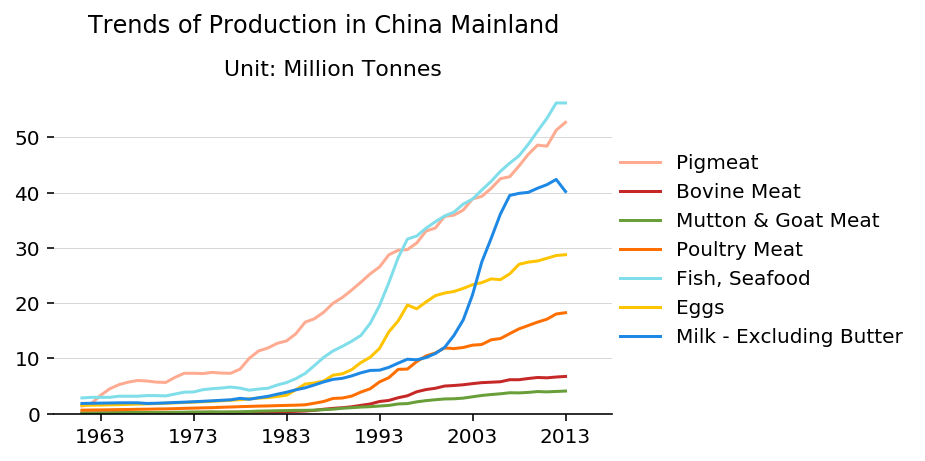

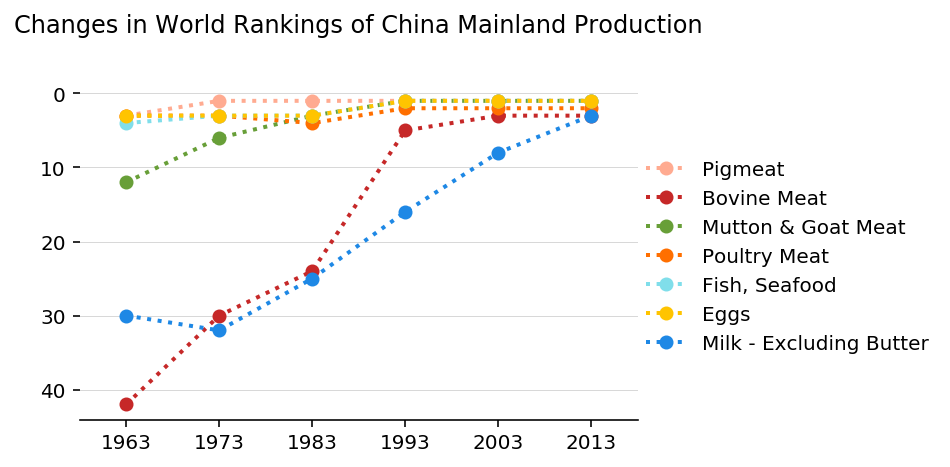

In [75]:
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)
ranking_AreaItemInWorld(A,E)

In [48]:
worldMap(
    element=E,
    items_group='',
    items=[],
    toUnit = 'Million Tonnes',
    changeUnit = 1/1000000,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='BuGn',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Production_03_01_Production _Pigmeat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Production_03_01_Production _Pigmeat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Production_03_01_Production _Pigmeat_2013.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Production_03_01_Production _Bovine Meat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Production_03_01_Production _Bovine Meat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Production_03

1973    1993    2013
Argentina  0.2577  0.2301  0.4160
Australia  0.2362  0.3283  0.3609
Austria    0.3475  0.5382  0.5293
Belgium       NaN     NaN  1.1306
Brazil     0.7006  1.5000  3.2800

1973    1993    2013
Argentina  2.1486  2.8080  2.8220
Australia  1.4379  1.8258  2.3178
Austria    0.1645  0.2233  0.2289
Belgium       NaN     NaN  0.2500
Brazil     2.2020  4.8069  9.6750

1973    1993    2013
Argentina  0.1384  0.0722  0.0662
Australia  0.7138  0.6549  0.6969
Austria    0.0018  0.0057  0.0079
Belgium       NaN     NaN  0.0024
Brazil     0.0587  0.1190  0.1158

1973    1993     2013
Argentina  0.2071  0.7134   1.9665
Australia  0.1608  0.4643   1.0977
Austria    0.0570  0.1022   0.1308
Belgium       NaN     NaN   0.3893
Brazil     0.5240  3.2351  12.9152

1973    1993    2013
Argentina  0.2777  0.9828  0.8739
Australia  0.1253  0.2469  0.2289
Austria    0.0022  0.0036  0.0036
Belgium       NaN     NaN  0.0258
Brazil     0.7597  0.6763  1.5494

1973    1993    2013
Argentina  0.1918  0.2641  0.5599
Australia  0.1932  0.1418  0.2409
Austria    0.0876  0.0950  0.1073
Belgium       NaN     NaN  0.1735
Brazil     0.3938  1.3578  2.2857

1973     1993     2013
Argentina  5.2210   7.2201  11.1837
Australia  7.1680   7.5540   9.5220
Austria    3.3009   3.2868   3.4246
Belgium       NaN      NaN   3.4832
Brazil     7.8455  16.2182  32.6530

OECD


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1961  15.4957      15.8003              2.5754        5.8519        19.1530   
1962  15.9901      16.4530              2.5749        5.9863        19.7630   
1963  16.2029      17.2631              2.5318        6.3827        20.1936   
1964  16.7996      18.1273              2.5404        6.8084        21.0266   
1965  16.9097      18.2675              2.5109        7.2935        22.4889   

         Eggs  Milk - Excluding Butter  
Year                                    
1961   9.3378                 206.4378  
1962   9.6082                 207.7567  
1963   9.8152                 207.4391  
1964  10.4271                 209.2231  
1965  10.5887                 213.1791

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961     1.37       0.0595                0.10        0.6220         2.8356   
1962     1.78       0.0800                0.10        0.6485         2.9424   
1963     3.30       0.1070                0.12        0.6725         2.9424   
1964     4.50       0.1200                0.14        0.6940         2.9424   
1965     5.25       0.1340                0.16        0.7230         3.1492   

      Eggs  Milk - Excluding Butter  
1961  1.50                   1.8330  
1962  1.52                   1.8691  
1963  1.54                   1.8990  
1964  1.58                   1.9194  
1965  1.62                   1.9481

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Production of Pigmeat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Production of Bovine Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Production of Mutton & Goat Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Production of Poultry Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Production of Fish, Seafood of China Mainland with OECD Tota

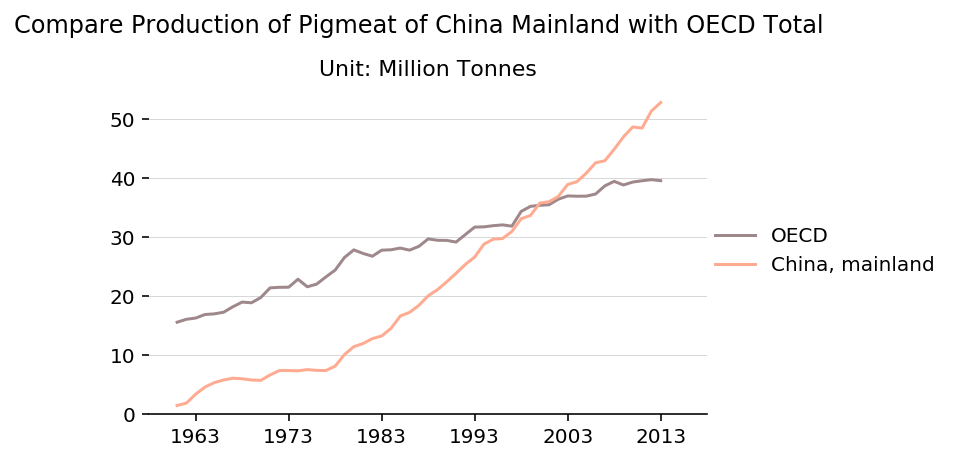

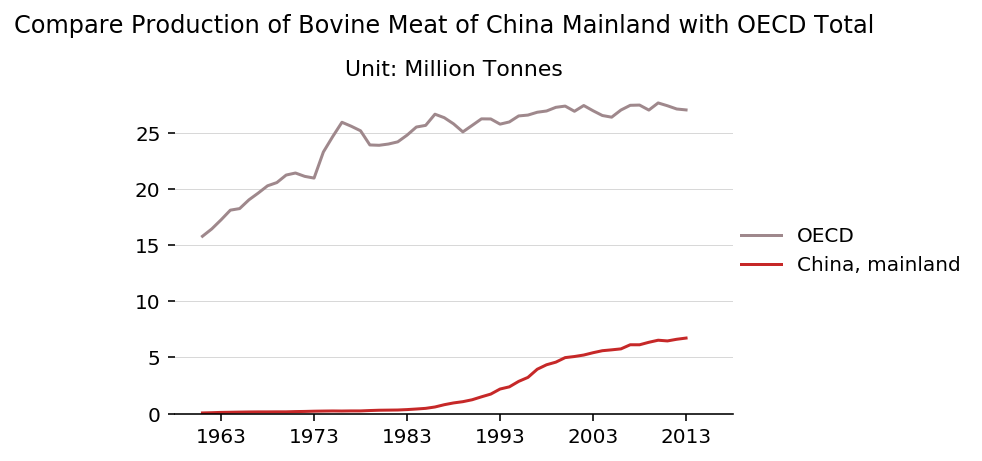

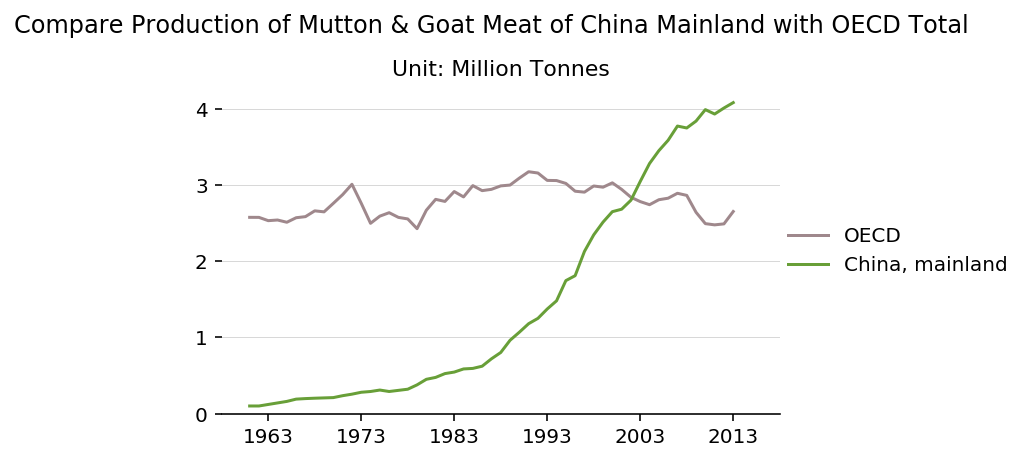

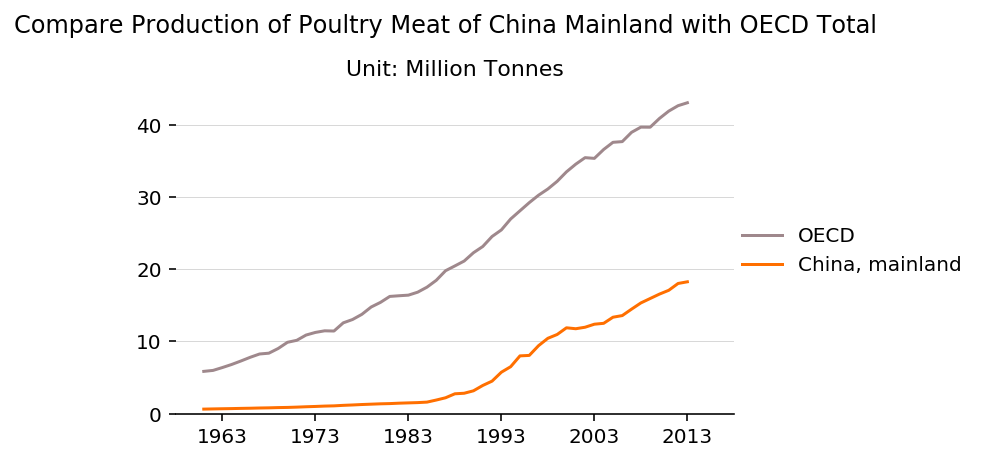

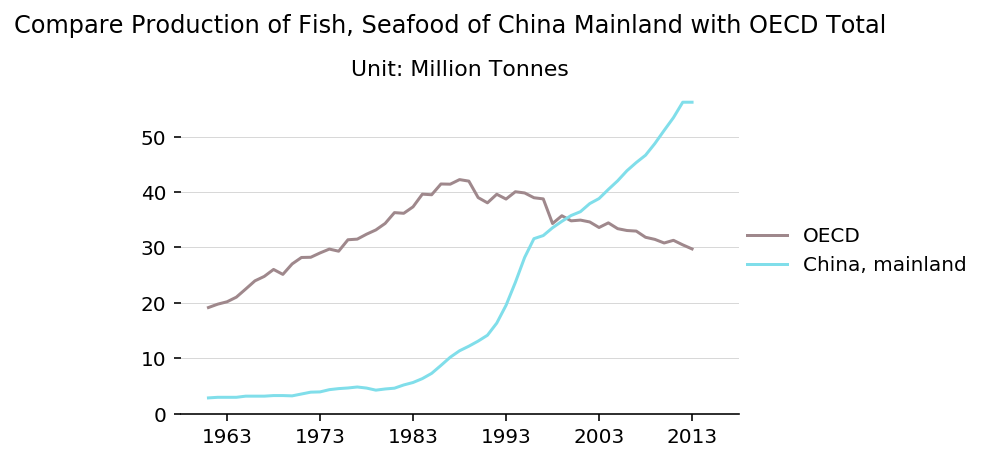

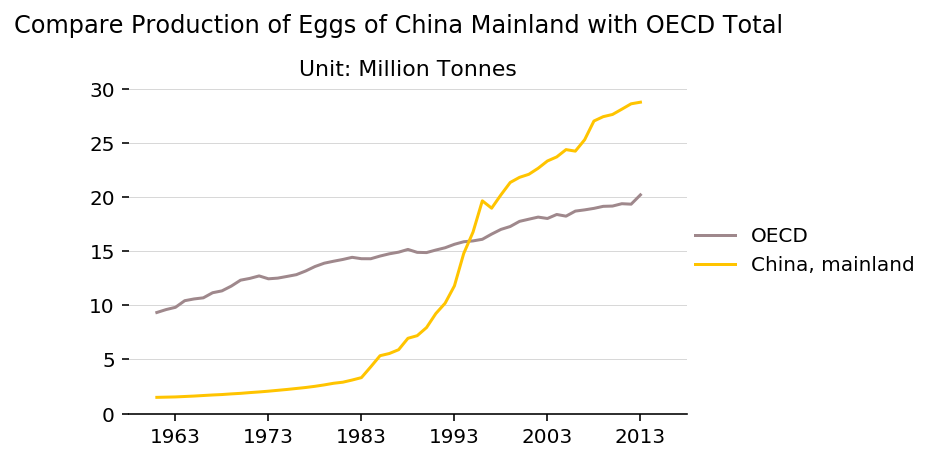

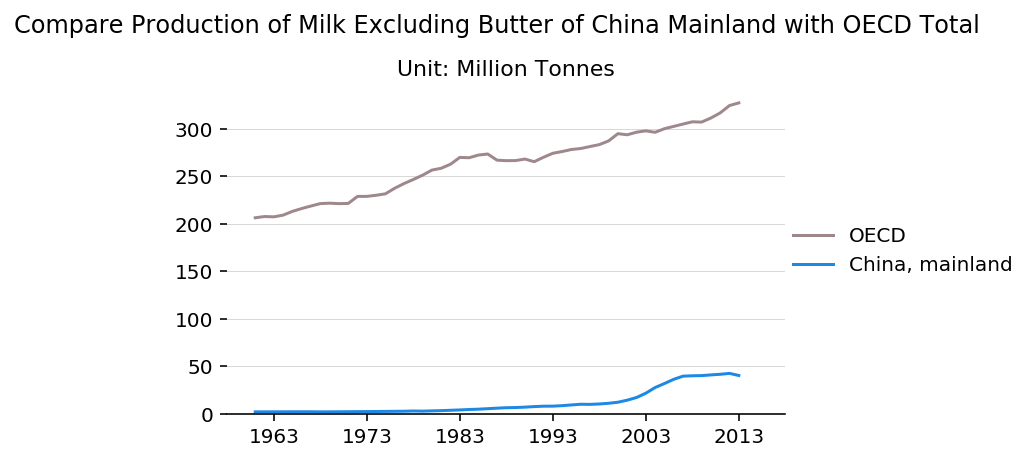

In [49]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

DATA_world = trendsOfArea('World', E, items=items)
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)

compareOtherAreasLine(
    area=A,
    element=E,
    df_area=DATA_area.copy(),
    dfs_compare={'OECD': DATA_OECD, }, 
    toUnit='Million Tonnes',
    changeUnit=1/1000000,
    colors = CLs,
    fig_size = FIG_size,
)

World: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963  27.9345      31.8755              6.0548        9.6838        43.3607   
1973  40.3376      40.1407              6.6299       17.5004        61.1230   
1983  55.3185      48.8105              7.7174       28.9153        76.0608   
1993  73.4550      54.4603              9.8017       47.7374       102.9605   
2003  91.9694      59.6908             11.5421       74.8956       124.3195   

         Eggs  Milk - Excluding Butter  
1963  15.6170                 342.0282  
1973  21.8709                 409.5506  
1983  29.1286                 494.3857  
1993  40.8823                 523.9418  
2003  58.3588                 610.1896

OECD: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963  16.2029      17.2631              2.5318        6.3827        20.1936   
1973  21.4316      20.9841              2.7601       11.2486        29.0129   
1983  27.7085      24.8100              2.9138       16.4145        37.3399   
1993  31.6208      25.7910              3.0603       25.4548        38.7415   
2003  36.9078      26.9843              2.7820       35.3691        33.6051   

         Eggs  Milk - Excluding Butter  
Year                                    
1963   9.8152                 207.4391  
1973  12.4496                 229.0041  
1983  14.3056                 270.0727  
1993  15.6362                 274.4334  
2003  18.0206                 298.0592

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963   3.3000        0.107              0.1200        0.6725         2.9424   
1973   7.3000        0.214              0.2800        0.9900         3.9196   
1983  13.1610        0.357              0.5450        1.4850         5.6166   
1993  26.5459        2.189              1.3730        5.7360        19.5589   
2003  38.8467        5.425              3.0463       12.3880        38.8327   

        Eggs  Milk - Excluding Butter  
1963   1.540                   1.8990  
1973   2.070                   2.1482  
1983   3.323                   3.8660  
1993  11.798                   7.8574  
2003  23.331                  21.5016

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_03_Production of China mainland in the World.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_03_Production of OECD in the World.png
World: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963    100.0        100.0               100.0         100.0          100.0   
1973    100.0        100.0               100.0         100.0          100.0   
1983    100.0        100.0               100.0         100.0          100.0   
1993    100.0        100.0               100.0         100.0          100.0   
2003    100.0        100.0               100.0         100.0          100.0   

       Eggs  Milk - Excluding Butter  
Year                                  
1963  100.0                    100.0  
1973  100.0                    100.0  
1983  100.0                    100.0  
1993  100.0                    100.0  
2003  100.0                    100.0

OECD: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963  58.0032      54.1579             41.8148       65.9112        46.5712   
1973  53.1306      52.2764             41.6304       64.2766        47.4665   
1983  50.0890      50.8292             37.7567       56.7674        49.0921   
1993  43.0479      47.3575             31.2216       53.3227        37.6275   
2003  40.1306      45.2069             24.1029       47.2245        27.0312   

         Eggs  Milk - Excluding Butter  
Year                                    
1963  62.8495                  60.6497  
1973  56.9231                  55.9160  
1983  49.1118                  54.6279  
1993  38.2469                  52.3786  
2003  30.8789                  48.8470

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1963  11.8133       0.3357              1.9819        6.9446         6.7859   
1973  18.0973       0.5331              4.2233        5.6570         6.4126   
1983  23.7913       0.7314              7.0620        5.1357         7.3844   
1993  36.1390       4.0194             14.0077       12.0157        18.9966   
2003  42.2387       9.0885             26.3929       16.5404        31.2362   

         Eggs  Milk - Excluding Butter  
Year                                    
1963   9.8611                   0.5552  
1973   9.4646                   0.5245  
1983  11.4080                   0.7820  
1993  28.8585                   1.4997  
2003  39.9785                   3.5238

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_03_Percentages (%) of China mainland's Production in the World_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_03_Percentages (%) of OECD's Production in the World_Bar.png
1963 China, mainland


China, mainland     World    Others
Pigmeat                           3.3000   27.9345   24.6345
Bovine Meat                       0.1070   31.8755   31.7685
Mutton & Goat Meat                0.1200    6.0548    5.9348
Poultry Meat                      0.6725    9.6838    9.0113
Fish, Seafood                     2.9424   43.3607   40.4183
Eggs                              1.5400   15.6170   14.0770
Milk - Excluding Butter           1.8990  342.0282  340.1292

2013 China, mainland


China, mainland     World    Others
Pigmeat                          52.7330  113.0679   60.3349
Bovine Meat                       6.7300   67.5404   60.8104
Mutton & Goat Meat                4.0810   13.6400    9.5590
Poultry Meat                     18.2649  108.5168   90.2519
Fish, Seafood                    56.2285  154.8482   98.6197
Eggs                             28.7600   73.7854   45.0254
Milk - Excluding Butter          40.1932  753.0360  712.8428

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_03_Percentages (%) of China mainland's Main Animal Produced Food Production in the World_Pie.png
1963 OECD


OECD     World    Others
Pigmeat                   16.2029   27.9345   11.7316
Bovine Meat               17.2631   31.8755   14.6124
Mutton & Goat Meat         2.5318    6.0548    3.5230
Poultry Meat               6.3827    9.6838    3.3011
Fish, Seafood             20.1936   43.3607   23.1671
Eggs                       9.8152   15.6170    5.8018
Milk - Excluding Butter  207.4391  342.0282  134.5891

2013 OECD


OECD     World    Others
Pigmeat                   39.4897  113.0679   73.5782
Bovine Meat               27.0577   67.5404   40.4827
Mutton & Goat Meat         2.6519   13.6400   10.9882
Poultry Meat              43.0765  108.5168   65.4403
Fish, Seafood             29.7353  154.8482  125.1129
Eggs                      20.2016   73.7854   53.5838
Milk - Excluding Butter  327.5582  753.0360  425.4778

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_03_Percentages (%) of OECD's Main Animal Produced Food Production in the World_Pie.png


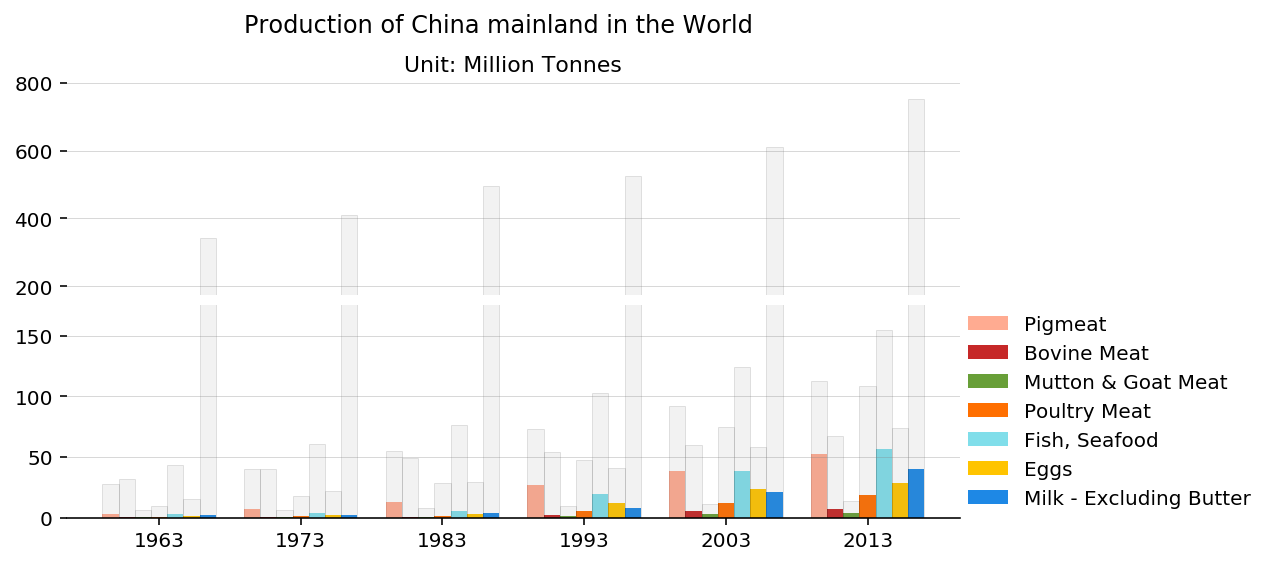

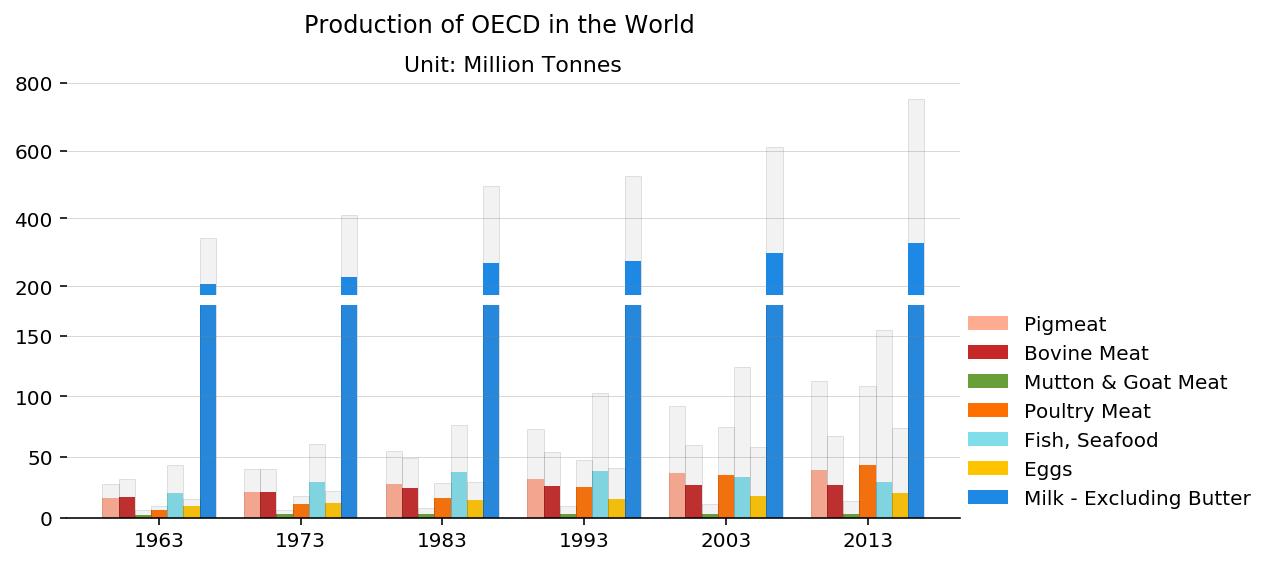

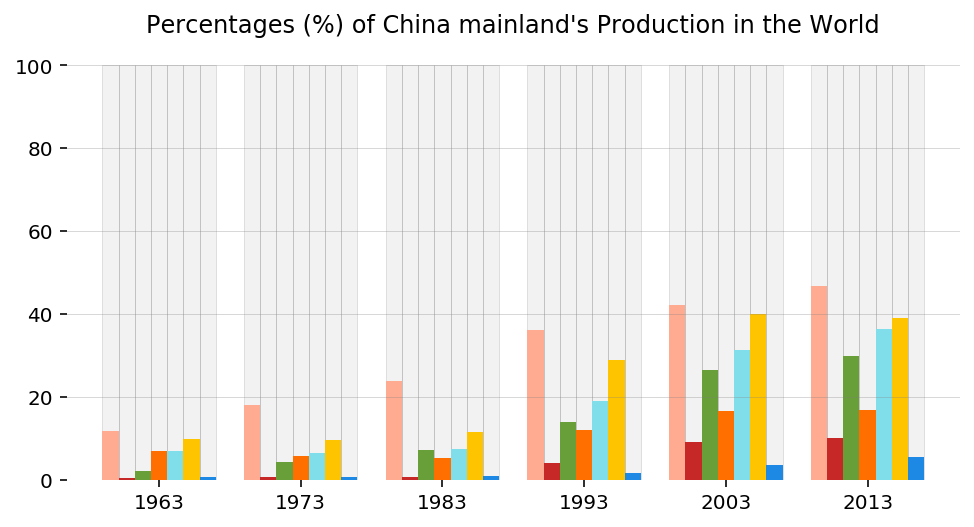

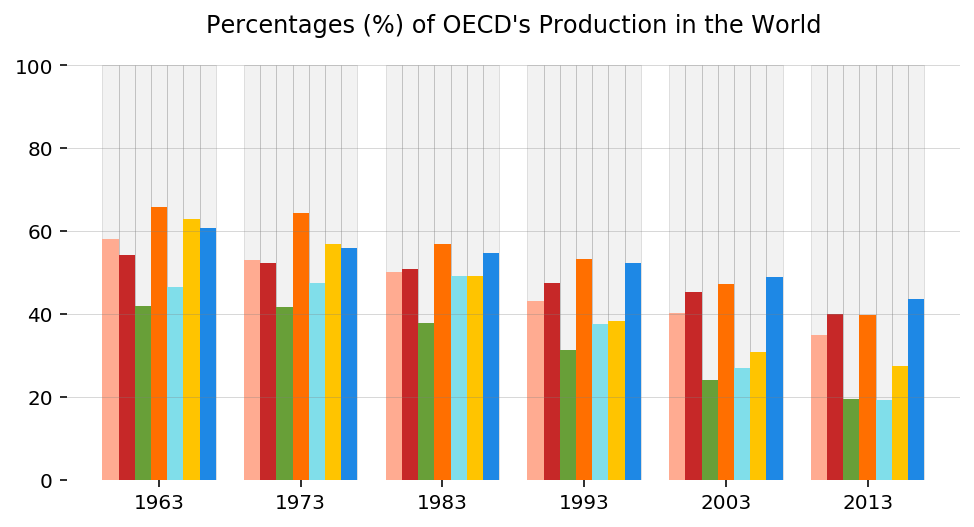

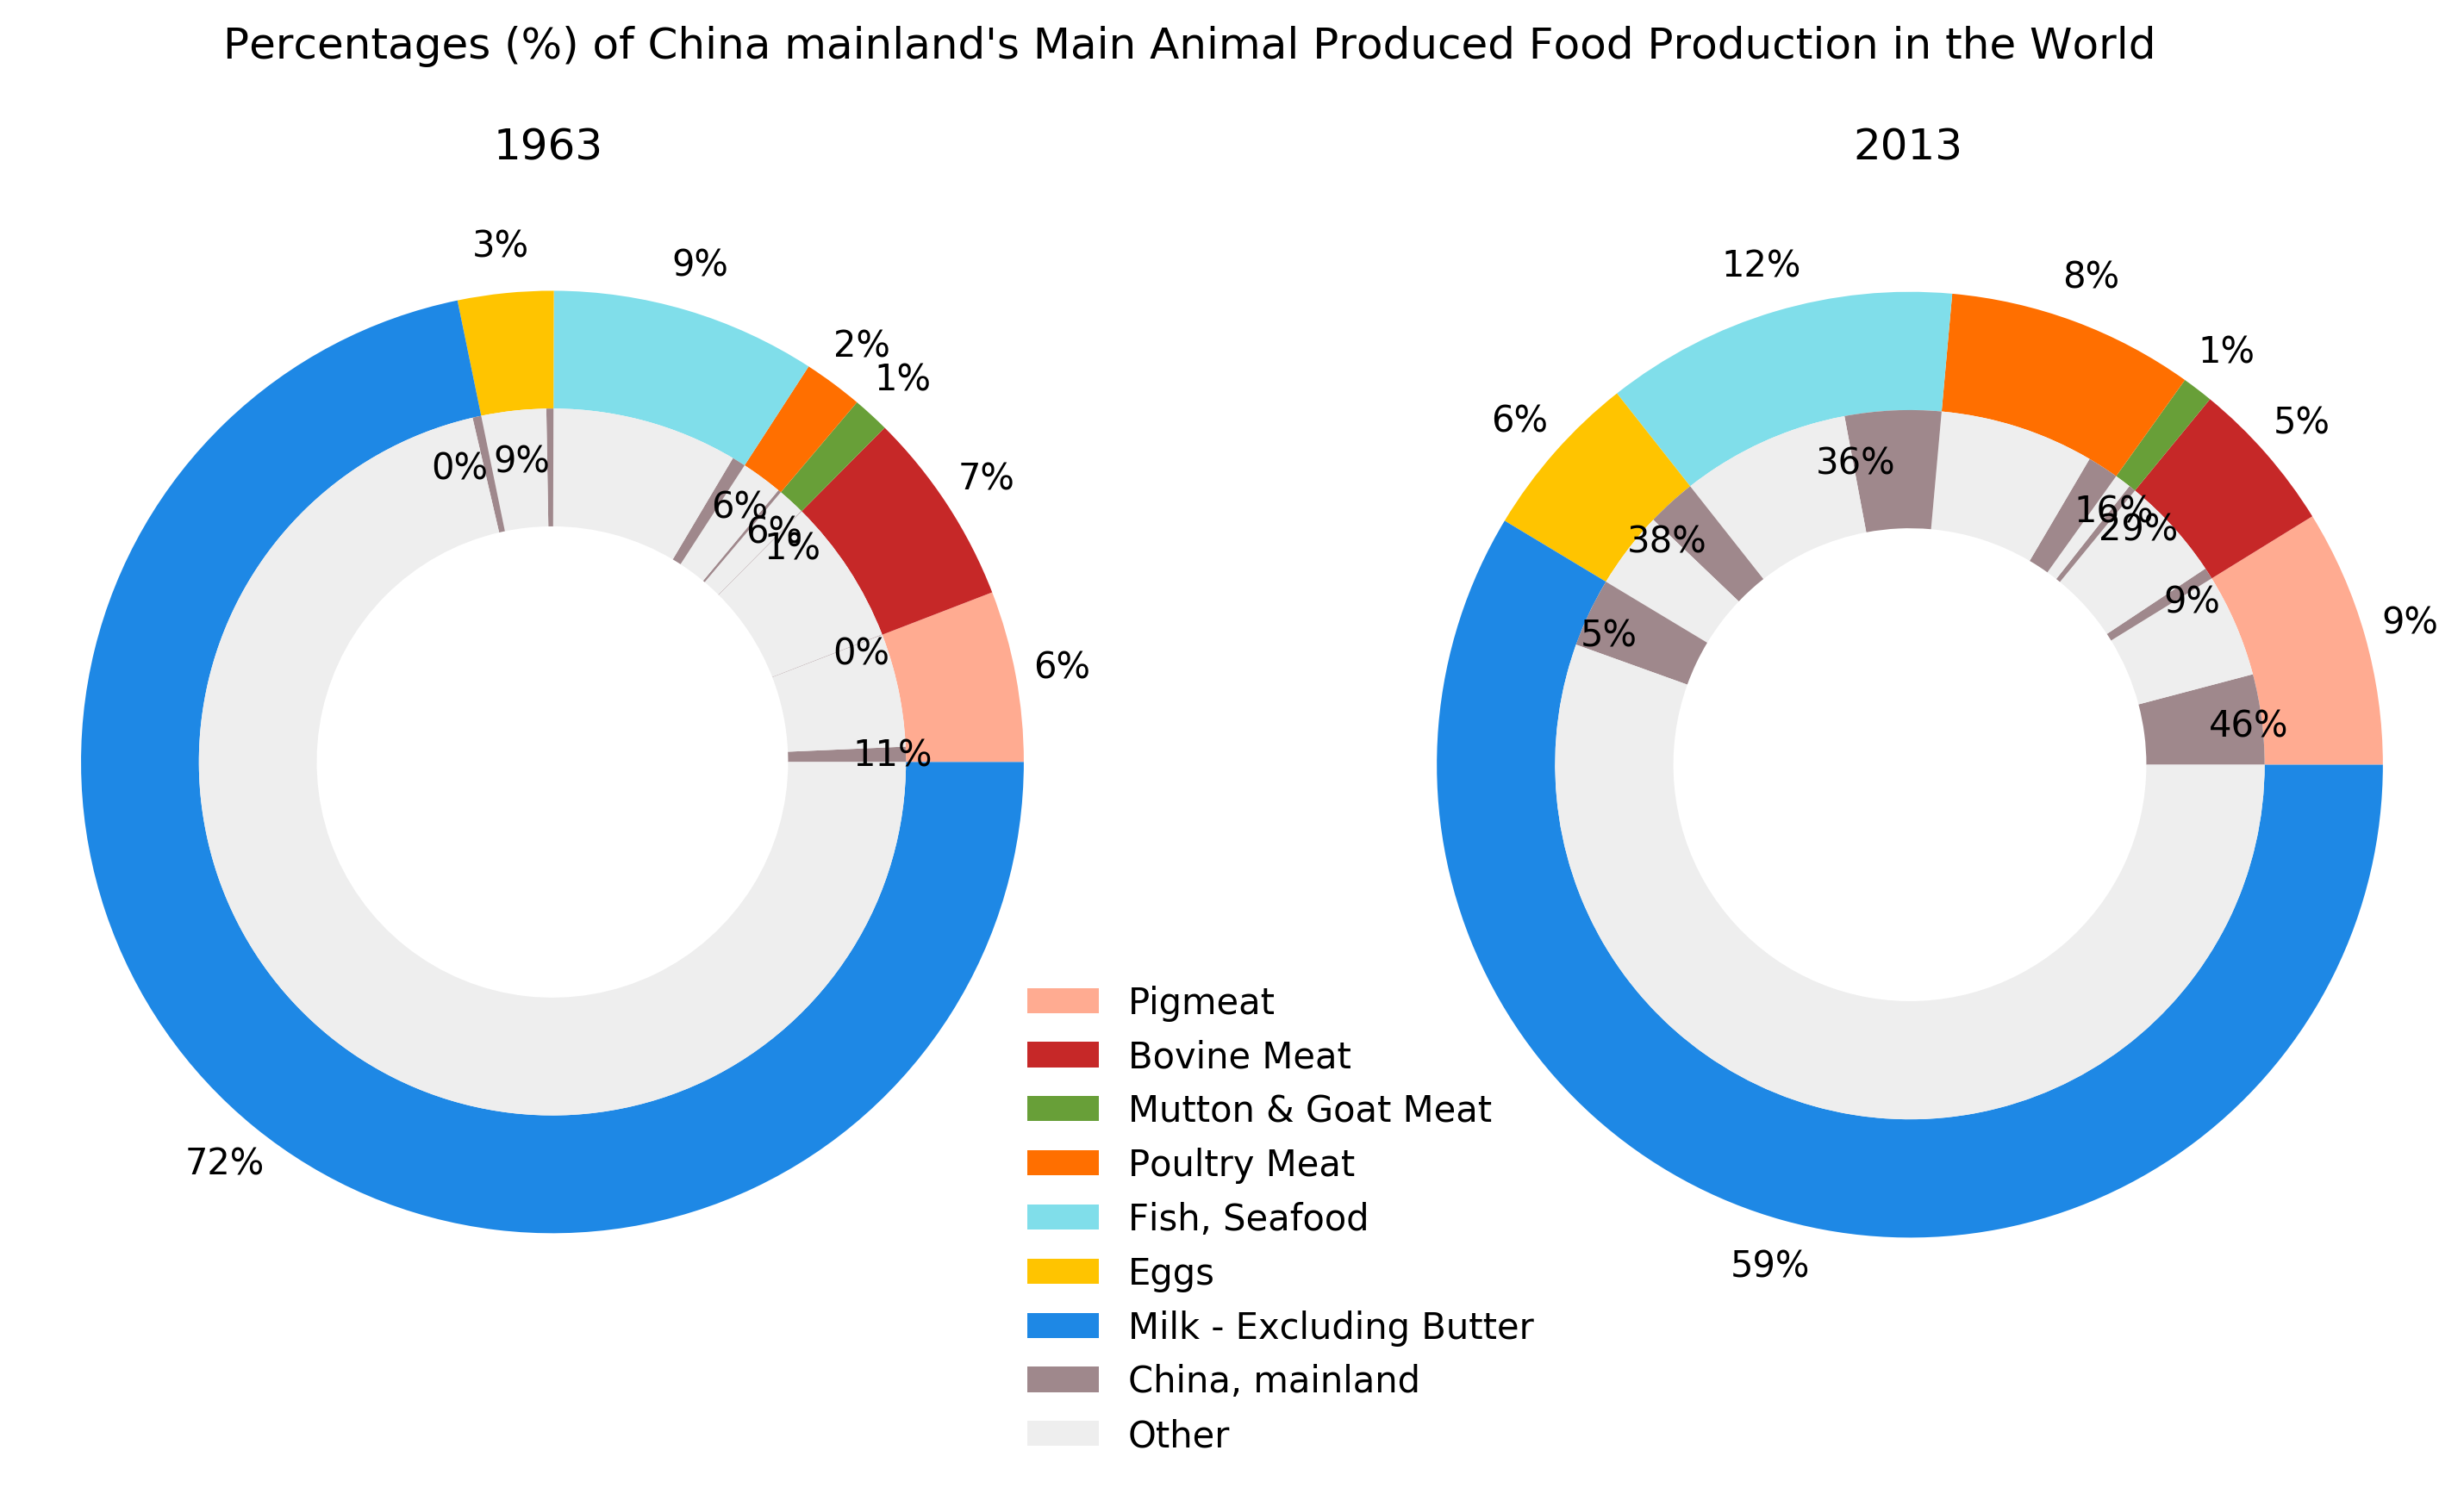

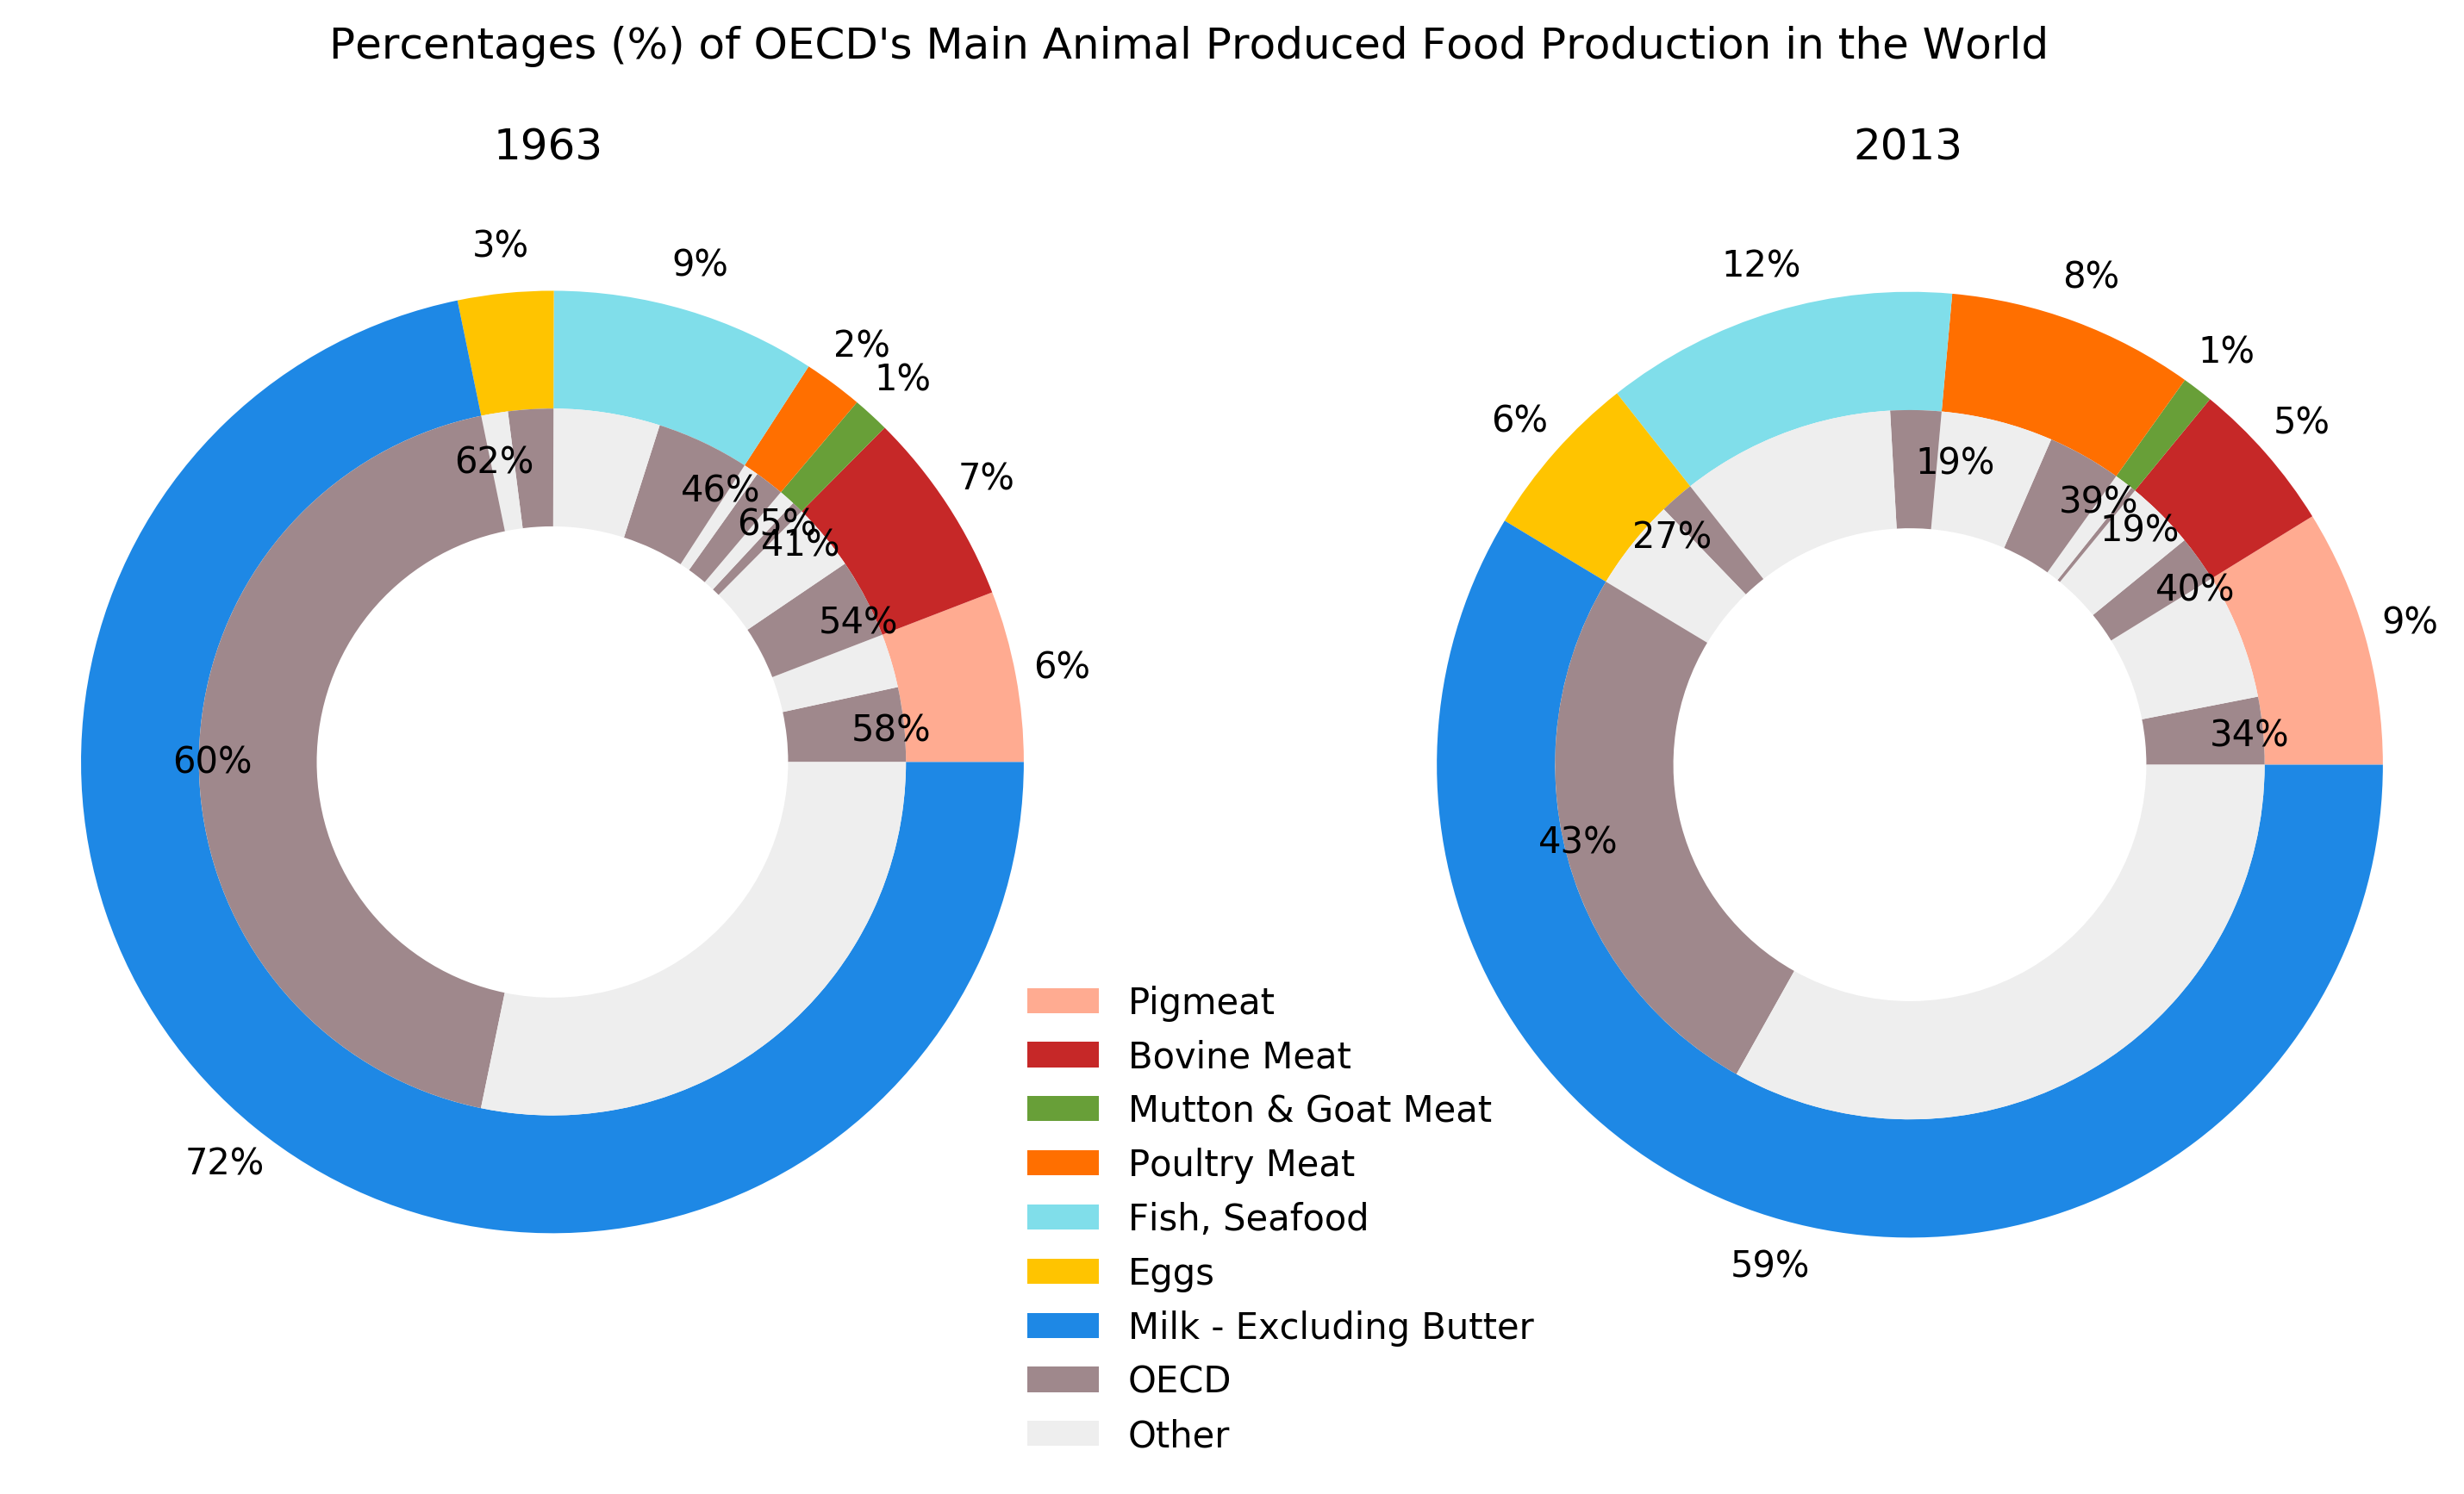

In [50]:
# toUnit='Million Tonnes'
# changeUnit=1/1000000

# df_world=DATA_world.loc[X_ticks].copy()*changeUnit
# df_OECD=DATA_OECD.loc[X_ticks].copy()*changeUnit
# df_area=DATA_area.loc[X_ticks].copy()*changeUnit

# print('World: ')
# display(df_world.head())
# print('OECD: ')
# display(df_OECD.head())
# print(f'{A}: ')
# display(df_area.head())

# areaInWorld(
#     element=E,
#     area_=A, total_='World', 
#     df_area_=df_area.copy(), df_total_=df_world, 
#     ax1_ylim=(175,800), ax2_ylim=(0,175),)
# areaInWorld(
#     element=E,
#     area_='OECD', total_='World', 
#     df_area_=df_OECD.copy(), df_total_=df_world, 
#     ax1_ylim=(175,800), ax2_ylim=(0,175),)

# percent_world = pd.DataFrame()
# percent_OECD = pd.DataFrame()
# percent_area = pd.DataFrame()

# percent_world['Year'] = X_ticks
# percent_OECD['Year'] = X_ticks
# percent_area['Year'] = X_ticks

# percent_world.set_index('Year', inplace=True)
# percent_OECD.set_index('Year', inplace=True)
# percent_area.set_index('Year', inplace=True)

# for i in items:
#     percent_world[i] = np.array(df_world[i]/df_world[i])*100
#     percent_OECD[i] = np.array(df_OECD[i]/df_world[i])*100
#     percent_area[i] = np.array(df_area[i]/df_world[i])*100

# print('World: ')
# display(percent_world.head())
# print('OECD: ')
# display(percent_OECD.head())
# print(f'{A}: ')
# display(percent_area.head())

# areaInWorldPercent(
#     element=E,
#     area_=A, total_='World', 
#     df_area_=percent_area.copy(), 
#     df_total_=percent_world
# )
# areaInWorldPercent(
#     element=E,
#     area_='OECD', total_='World', 
#     df_area_=percent_OECD.copy(), 
#     df_total_=percent_world
# )


# plotPieCompare(
#     element=E,
#     area_=A, total_='World',
#     df_area_=df_area.copy(), df_total_=df_world.copy(),
#     years=[1963, 2013],
#     fig_size = (12,6),
# )

# plotPieCompare(
#     element=E,
#     area_='OECD', total_='World',
#     df_area_=df_OECD.copy(), df_total_=df_world.copy(),
#     years=[1963, 2013],
#     fig_size = (12,6),
# )

World


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961  24.6658      28.6605              5.9319        8.8933        38.7617   
1962  25.9731      30.2089              6.0612        9.1458        42.1180   
1963  27.9345      31.8755              6.0548        9.6838        43.3607   
1964  28.5977      32.3345              6.0498       10.0729        48.0340   
1965  31.2001      32.9428              6.0968       10.8919        49.1545   

         Eggs  Milk - Excluding Butter  
1961  15.0684                 342.2668  
1962  15.4273                 344.8259  
1963  15.6170                 342.0282  
1964  16.2975                 347.1505  
1965  16.7962                 362.3417

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in World_Line.png
Northern America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   5.7082       8.0811              0.3931        3.5627         3.8314   
1962   5.9042       8.0765              0.3814        3.4891         3.9720   
1963   6.1743       8.5887              0.3636        3.6453         3.8469   
1964   6.2565       9.6087              0.3384        3.7929         3.7150   
1965   5.6042       9.8246              0.3064        4.0331         3.8660   

        Eggs  Milk - Excluding Butter  
1961  3.9895                  65.3488  
1962  4.0603                  65.6162  
1963  4.0453                  65.1632  
1964  4.1605                  65.9970  
1965  4.1765                  64.6633

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in Northern America_Line.png
Western Europe


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   4.9147       3.4208              0.1652        0.8705         1.8713   
1962   5.0181       3.6072              0.1585        0.9273         1.8570   
1963   5.0262       3.6676              0.1457        0.9910         1.9680   
1964   5.2780       3.4573              0.1468        1.0878         2.0359   
1965   5.6146       3.4500              0.1572        1.1452         2.0804   

        Eggs  Milk - Excluding Butter  
1961  1.8298                  61.8045  
1962  1.8566                  61.7853  
1963  1.8794                  62.7892  
1964  2.0196                  62.4517  
1965  2.0047                  65.0178

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in Western Europe_Line.png
Australia & New Zealand


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.1496       0.8794              1.0412        0.0561         0.1116   
1962   0.1626       1.0857              1.0697        0.0583         0.1156   
1963   0.1589       1.2217              1.0670        0.0582         0.1195   
1964   0.1601       1.2883              1.0848        0.0674         0.1162   
1965   0.1670       1.2977              1.0708        0.0816         0.1274   

        Eggs  Milk - Excluding Butter  
1961  0.1879                  11.4940  
1962  0.1904                  11.9897  
1963  0.1864                  12.2255  
1964  0.1889                  12.5328  
1965  0.1993                  12.9641

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in Australia & New Zealand_Line.png
South-Eastern Asia


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.7831       0.5706              0.0436        0.3246         2.7765   
1962   0.8380       0.6016              0.0448        0.3392         2.9740   
1963   0.8642       0.6100              0.0449        0.3784         3.2192   
1964   0.9186       0.6374              0.0460        0.3948         3.5086   
1965   0.9647       0.6570              0.0453        0.4299         3.7324   

        Eggs  Milk - Excluding Butter  
1961  0.5255                   0.4054  
1962  0.5393                   0.4140  
1963  0.5609                   0.4173  
1964  0.5760                   0.4377  
1965  0.5953                   0.4656

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in South-Eastern Asia_Line.png
Japan


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.2063       0.1427              0.0037        0.1320         6.2370   
1962   0.3242       0.1461              0.0028        0.1550         6.3212   
1963   0.2794       0.1859              0.0024        0.1780         6.2221   
1964   0.3424       0.2372              0.0020        0.1761         5.9611   
1965   0.4072       0.2163              0.0020        0.2044         6.4711   

       Eggs  Milk - Excluding Butter  
1961  0.897                   2.1152  
1962  0.981                   2.4389  
1963  1.030                   2.7630  
1964  1.224                   3.0222  
1965  1.330                   3.2239

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in Japan_Line.png
Republic of Korea


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0630       0.0210              0.0008        0.0165         0.3840   
1962   0.0399       0.0243              0.0010        0.0158         0.4171   
1963   0.0579       0.0310              0.0009        0.0171         0.4733   
1964   0.0656       0.0464              0.0007        0.0185         0.5368   
1965   0.0763       0.0395              0.0005        0.0197         0.5778   

        Eggs  Milk - Excluding Butter  
1961  0.0396                   0.0048  
1962  0.0449                   0.0077  
1963  0.0519                   0.0088  
1964  0.0572                   0.0118  
1965  0.0653                   0.0133

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in Republic Of Korea_Line.png
South America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.9862       4.6659              0.3805        0.3162         6.1988   
1962   1.0132       4.9249              0.3863        0.3397         8.1998   
1963   0.9955       5.1997              0.3642        0.3939         8.2536   
1964   1.0003       4.7989              0.3491        0.4437        10.9562   
1965   1.0794       4.7776              0.3904        0.5540         8.9234   

        Eggs  Milk - Excluding Butter  
1961  0.5981                  14.3581  
1962  0.5829                  14.6388  
1963  0.5777                  15.1533  
1964  0.6105                  16.2642  
1965  0.6474                  16.8340

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Production in South America_Line.png


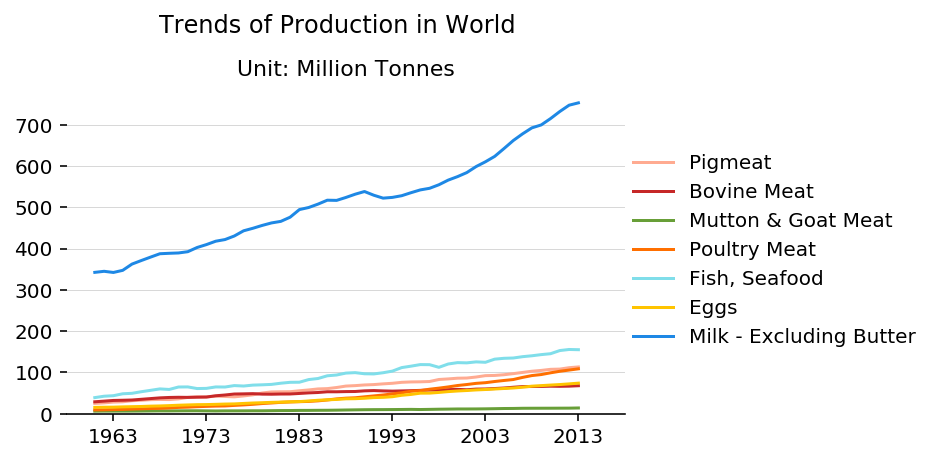

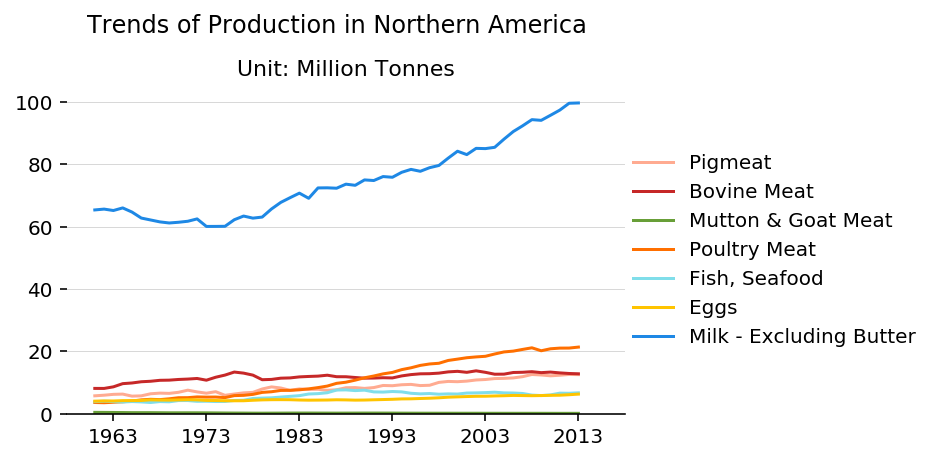

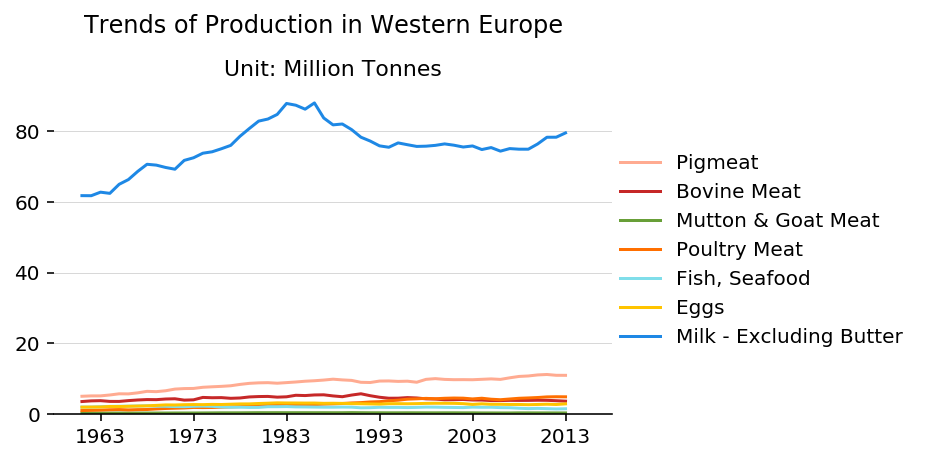

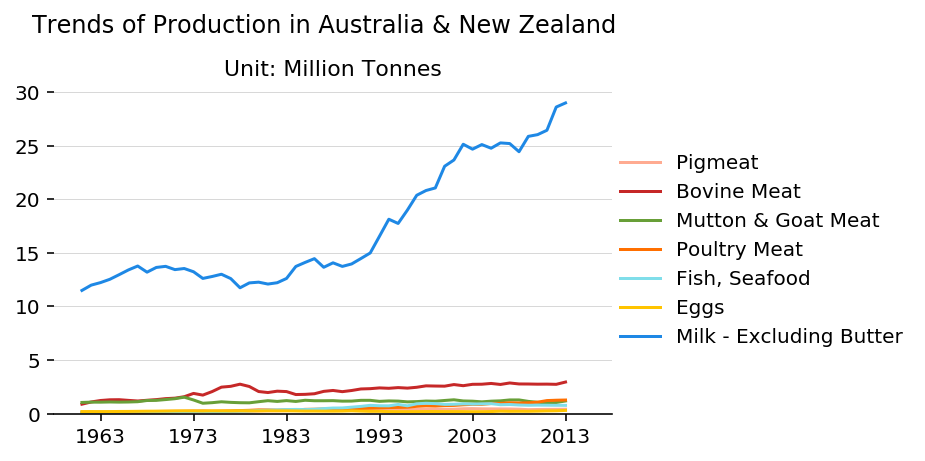

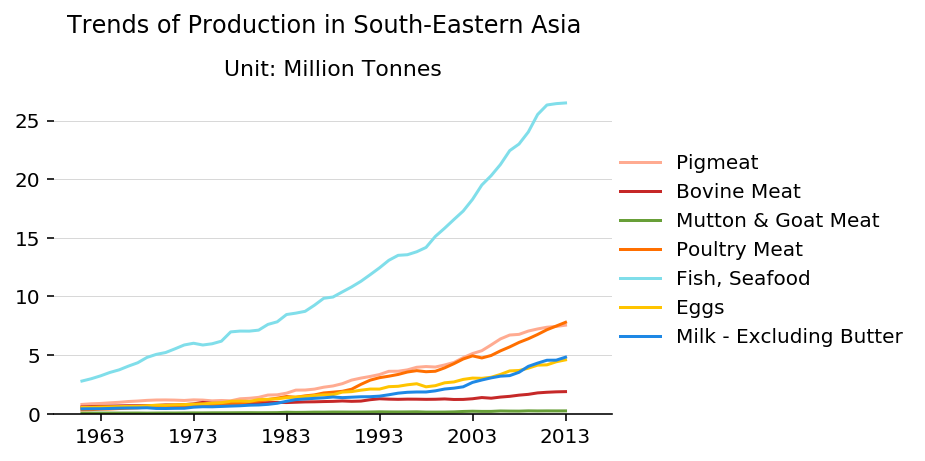

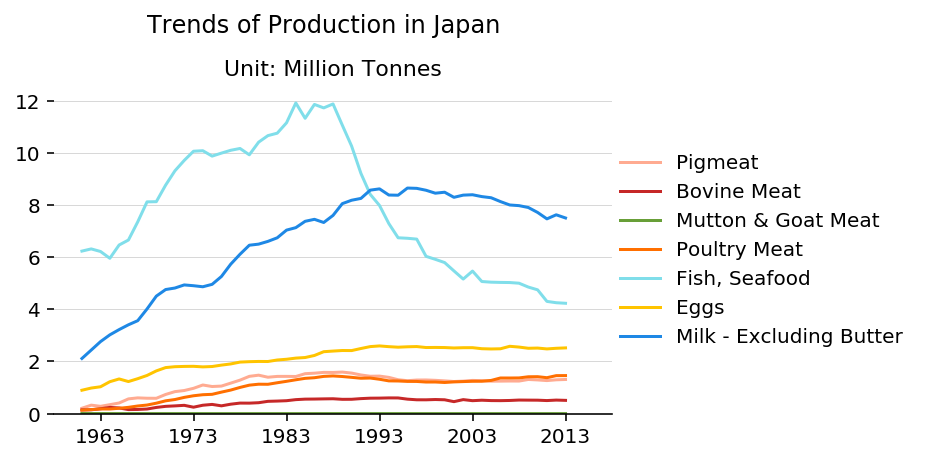

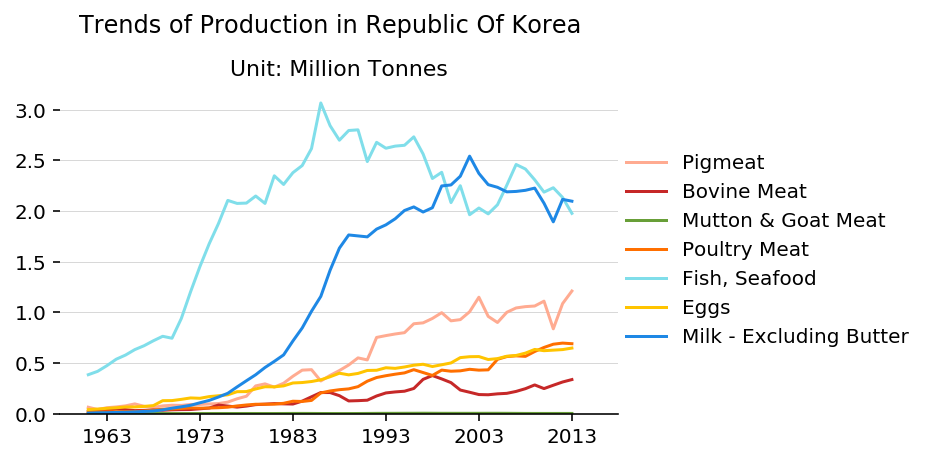

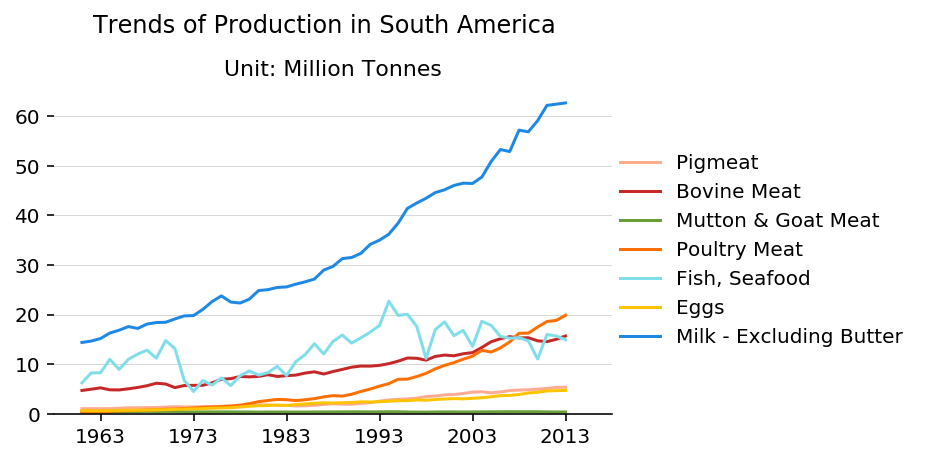

In [51]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea', 'South America'
]
for a in areas:
    print(a)
    plotTrendsLine(a, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

### Import

In [76]:
# 给 Elements 赋值
E = 'Import Quantity'

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


'Import Quantity'

'Meat'

1961      1962       1963      1964      1965       1966  \
Area                                                                        
Afghanistan       0.0       0.0        0.0       0.0       0.0        0.0   
Africa       114578.0   84791.0    66818.0   64790.0   67310.0    92813.0   
Albania           0.0       0.0        0.0       0.0       0.0        0.0   
Algeria       48827.0   29840.0    13738.0    9075.0    8726.0     7164.0   
Americas     760509.0  994811.0  1133308.0  884985.0  799559.0  1012797.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa         79324.0    77943.0    80379.0    89992.0    88132.0    94753.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         2045.0     1317.0      555.0      277.0      615.0      296.0   
Americas     1087320.0  1204352.0  1344840.0  1491613.0  1428980.0  1637439.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa         94734.0    90933.0   108666.0   164003.0   211778.0   217858.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria           50.0      605.0     1103.0     5978.0    18871.0    14362.0   
Americas     1599611.0  1485424.0  1493844.0  1718314.0  1552179.0  1912014.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan        0.0        0.0      588.0      294.0      235.0     1066.0   
Africa        225151.0   317684.0   411541.0   392782.0   416383.0   473693.0   
Albania            0.0        0.0        0.0        0.0     1000.0     2000.0   
Algeria        14470.0    21413.0    26678.0    32852.0    39337.0    35267.0   
Americas     1924262.0  1793367.0  1692654.0  1766949.0  1710837.0  1754434.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan     1033.0     2302.0     2882.0     1023.0     1080.0      148.0   
Africa        442809.0   500709.0   521584.0   529335.0   434796.0   423769.0   
Albania         4100.0     1920.0     1420.0     4500.0     4100.0     4500.0   
Algeria        46992.0    43928.0     5021.0    16154.0      670.0    16653.0   
Americas     1997260.0  2569543.0  2420455.0  2374804.0  2438246.0  2564606.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan      285.0      670.0       50.0      100.0      150.0        0.0   
Africa        463939.0   544414.0   515592.0   602162.0   628356.0   514935.0   
Albania        22422.0    17781.0    20275.0    20242.0    20219.0    32750.0   
Algeria        18740.0    21114.0    25292.0    24530.0    34872.0    29344.0   
Americas     2635002.0  2787665.0  2810092.0  2973116.0  2512969.0  2766966.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan        0.0        0.0       30.0       74.0       45.0     1257.0   
Africa        610121.0   581770.0   658935.0   749987.0   551693.0   736050.0   
Albania        13311.0    18000.0    41935.0    25221.0    33181.0    51737.0   
Algeria        11304.0    25776.0    25641.0    18173.0     5830.0    23145.0   
Americas     3251213.0  3778494.0  4038039.0  4556592.0  4723540.0  4958202.0   

                  2003       2004       2005       2006       2007   

'Import Quantity'

'Pigmeat'

1961      1962      1963      1964      1965      1966  \
Area                                                                   
Africa     25575.0   13763.0    8558.0    8561.0    7206.0    8527.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria    16269.0    7076.0    2206.0    1758.0    1712.0    1625.0   
Americas  153600.0  171449.0  204250.0  188496.0  206207.0  233421.0   
Angola       154.0     159.0     223.0     226.0     239.0     186.0   

              1967      1968      1969      1970      1971      1972  \
Area                                                                   
Africa      8252.0    9817.0    9975.0   10872.0    8606.0    5632.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria      330.0     363.0     294.0     233.0     137.0      23.0   
Americas  230795.0  245673.0  266416.0  265947.0  264563.0  304006.0   
Angola       136.0     183.0     185.0     120.0     185.0      23.0   

              1973      1974      1975      1976      1977      1978  \
Area                                                                   
Africa      6325.0    6795.0    4434.0    4075.0    6890.0    7742.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria       13.0      11.0       6.0       0.0      19.0       2.0   
Americas  303169.0  291910.0  278997.0  318663.0  315603.0  303903.0   
Angola        68.0     120.0     250.0     375.0    2000.0    1875.0   

              1979      1980      1981      1982      1983      1984  \
Area                                                                   
Africa      7523.0   11653.0   10568.0   10212.0   11699.0   15591.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        5.0       9.0      33.0      23.0       1.0     305.0   
Americas  291141.0  317980.0  321930.0  327909.0  363573.0  459873.0   
Angola      2038.0    5263.0    3763.0    3363.0    3950.0    9438.0   

              1985      1986      1987      1988      1989      1990  \
Area                                                                   
Africa     16564.0   15758.0   20440.0   21753.0   24263.0   19933.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       2.0       0.0       0.0       0.0       0.0   
Americas  540337.0  566979.0  612767.0  592894.0  583518.0  510215.0   
Angola      9950.0    6656.0    6875.0    7525.0    9284.0    7101.0   

              1991      1992      1993      1994      1995      1996  \
Area                                                                   
Africa     23492.0   23927.0   27945.0   35366.0   47000.0   51190.0   
Albania      111.0    1349.0    4284.0    4284.0    3490.0    5315.0   
Algeria       21.0       3.0      10.0      10.0      46.0     112.0   
Americas  503755.0  493334.0  556103.0  624358.0  517905.0  527279.0   
Angola      7228.0    7363.0    5869.0    6188.0    7288.0   10088.0   

              1997      1998      1999       2000       2001       2002  \
Area                                                                      
Africa     52000.0   66053.0   59539.0    62111.0    57404.0    62189.0   
Albania     1522.0   10153.0   13901.0     9414.0    10343.0    14673.0   
Algeria       19.0      46.0      16.0       29.0       66.0       92.0   
Americas  599741.0  736941.0  857124.0  1092831.0  1132193.0  1160633.0   
Angola      9475.0   12849.0    9444.0    11763.0    17150.0    19580.0   

               2003       2004       2005       2006       2007       2008  \
Area                                                                         
Africa      78503.0    99161.0   101947.0   110023.0   129462.0   134349.0   
Albania     17523.0    18114.0    18030.0    27063.0    24667.0    18261.0   
Algeria       136.0      172.0      118.0       84.0      118.0      128.0   
Americas  1276857.0  1351424.0  1301029.0  1360160.0  1465568.0  152

'Import Quantity'

'Poultry Meat'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                         
Afghanistan      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Africa        9324.0   6196.0   4391.0   5202.0   6255.0   2190.0   1337.0   
Albania          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       6623.0   3992.0   1721.0    741.0   1137.0    375.0     46.0   
Americas     18340.0  16143.0  15587.0  17794.0  14710.0  15928.0  17558.0   

                1968     1969     1970     1971     1972     1973     1974  \
Area                                                                         
Afghanistan      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Africa        1215.0    982.0   3038.0   5038.0   6605.0   4210.0   3572.0   
Albania          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas     19078.0  18724.0  22812.0  25991.0  33405.0  34988.0  39823.0   

                1975     1976     1977      1978      1979      1980  \
Area                                                                   
Afghanistan      0.0      0.0      0.0       0.0       0.0       0.0   
Africa        5804.0   2948.0  28262.0   36784.0   49294.0   83568.0   
Albania          0.0      0.0      0.0       0.0       0.0       0.0   
Algeria          0.0      0.0      0.0       0.0       0.0       0.0   
Americas     72200.0  60048.0  66303.0  101442.0  112003.0  121704.0   

                 1981      1982      1983      1984      1985      1986  \
Area                                                                      
Afghanistan       0.0       0.0       0.0     713.0     680.0    1596.0   
Africa       113889.0   80753.0   86783.0   98891.0   90237.0   83986.0   
Albania           0.0       0.0       0.0       0.0    3600.0    1900.0   
Algeria           9.0       4.0       2.0       1.0       0.0       0.0   
Americas     148123.0  115509.0  104429.0  111908.0  124217.0  162198.0   

                 1987      1988      1989      1990      1991      1992  \
Area                                                                      
Afghanistan    2085.0     216.0     290.0       0.0     135.0     650.0   
Africa       129188.0  115356.0   86839.0   82955.0   92028.0  127866.0   
Albania        1400.0    3100.0    2800.0    2900.0    3914.0     260.0   
Algeria           0.0       0.0       0.0       0.0       0.0       0.0   
Americas     160243.0  204761.0  206670.0  235536.0  311334.0  379196.0   

                 1993      1994      1995      1996      1997      1998  \
Area                                                                      
Afghanistan       0.0     100.0     150.0       0.0       0.0       0.0   
Africa       101506.0  132580.0  180536.0  135514.0  209979.0  211268.0   
Albania        9793.0   11429.0   13014.0   18859.0    7110.0    3177.0   
Algeria           4.0       9.0      93.0     123.0      17.0       3.0   
Americas     446726.0  450070.0  417291.0  487317.0  637506.0  748428.0   

                 1999      2000      2001      2002       2003       2004  \
Area                                                                        
Afghanistan      30.0      25.0      45.0    1068.0      316.0     4933.0   
Africa       260284.0  309357.0  252452.0  371473.0   512638.0   526888.0   
Albania       24142.0   13659.0   20768.0   31700.0    23671.0    20751.0   
Algeria         104.0     131.0      48.0    1249.0     1239.0     1431.0   
Americas     767552.0  802468.0  842738.0  908519.0  1027186.0  1141871.0   

                  2005       2006       2007       2008       2009       2010  \
Area                                                                            
Afghanistan    23192.0    11135.0    11342.0    32316.0    23056.0    38591.0   
Africa        534869.0   639093.0   702144.0   745275.0 

'Import Quantity'

'Bovine Meat'

1961      1962      1963      1964      1965      1966  \
Area                                                                      
Afghanistan       0.0       0.0       0.0       0.0       0.0       0.0   
Africa        63719.0   53709.0   45590.0   41621.0   38647.0   60782.0   
Albania           0.0       0.0       0.0       0.0       0.0       0.0   
Algeria       23900.0   18136.0    9364.0    6109.0    5079.0    4840.0   
Americas     487059.0  666474.0  764305.0  586728.0  510513.0  643994.0   

                 1967      1968      1969       1970       1971       1972  \
Area                                                                         
Afghanistan       0.0       0.0       0.0        0.0        0.0        0.0   
Africa        57198.0   58377.0   59646.0    67187.0    62974.0    72165.0   
Albania           0.0       0.0       0.0        0.0        0.0        0.0   
Algeria        1669.0     935.0     238.0       13.0      244.0       62.0   
Americas     717637.0  802186.0  911965.0  1058729.0  1010286.0  1156811.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa         74456.0    73117.0    90027.0   147242.0   160159.0   161975.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0      498.0     1082.0     5355.0    16849.0    12869.0   
Americas     1145325.0  1024265.0  1049022.0  1236400.0  1092798.0  1412985.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        155508.0   197255.0   261815.0   272147.0   284660.0   331676.0   
Albania            0.0        0.0        0.0        0.0     1000.0     2000.0   
Algeria        11685.0    16703.0    22608.0    22089.0    24776.0    20973.0   
Americas     1418072.0  1246360.0  1116592.0  1210463.0  1137159.0  1080249.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan        0.0        0.0      610.0      620.0      790.0      148.0   
Africa        301970.0   366621.0   343432.0   365464.0   301945.0   303914.0   
Albania          500.0       20.0       20.0     1400.0     1300.0     1600.0   
Algeria        33982.0    30403.0     4110.0    16154.0      611.0    10530.0   
Americas     1212986.0  1684605.0  1502839.0  1432616.0  1511413.0  1679835.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan      150.0       20.0       50.0        0.0        0.0        0.0   
Africa        333316.0   365487.0   368381.0   372421.0   358450.0   282479.0   
Albania        18397.0    16172.0     6199.0     4529.0     3715.0     7292.0   
Algeria        17274.0    20163.0    25274.0    24501.0    32665.0    27598.0   
Americas     1706251.0  1805029.0  1679395.0  1763166.0  1459020.0  1629116.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan        0.0        0.0        0.0       49.0        0.0       85.0   
Africa        289486.0   246110.0   270469.0   296854.0   178051.0   251743.0   
Albania         3461.0     3598.0     3330.0     1605.0     1880.0     4854.0   
Algeria        11090.0    22738.0    22085.0    11920.0     5050.0    19222.0   
Americas     1873828.0  2094457.0  2229980.0  2421438.0  2470344.0  2632637.0   

                  2003       2004       2005       2006       2007       2008  \
Area                   

'Import Quantity'

'Offals'

1961    1962     1963     1964     1965     1966     1967  \
Area                                                                    
Africa    2616.0  2493.0   1747.0   1617.0   1231.0   1798.0   1797.0   
Albania      0.0     0.0      0.0      0.0      0.0      0.0      0.0   
Algeria   1182.0  1318.0    626.0    275.0    209.0     74.0     50.0   
Americas  8576.0  9492.0  12102.0  16342.0  14302.0  15729.0  20314.0   
Angola       0.0     0.0      0.0      0.0      0.0      0.0      0.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa     2295.0   1790.0   5012.0   4541.0   4143.0   3031.0   1804.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria      16.0      7.0      0.0      0.0      0.0      0.0      0.0   
Americas  22162.0  25680.0  30106.0  29008.0  28005.0  26897.0  28142.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1975     1976     1977     1978     1979     1980      1981  \
Area                                                                       
Africa     2374.0   2061.0   1738.0   5118.0  10258.0  16329.0   22967.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0       0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0       0.0   
Americas  28607.0  37079.0  35321.0  60201.0  75160.0  73447.0  104081.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0       0.0   

             1982     1983      1984      1985      1986      1987      1988  \
Area                                                                           
Africa    20786.0  33365.0   39605.0   46598.0   37217.0   34383.0   53428.0   
Albania       0.0      0.0       0.0       0.0       0.0       0.0       0.0   
Algeria       0.0     65.0       0.0       0.0       0.0       0.0       0.0   
Americas  93524.0  68655.0  105709.0  140391.0  137082.0  151085.0  194594.0   
Angola     1000.0   1300.0     500.0    1700.0     200.0     281.0     400.0   

              1989      1990      1991      1992      1993      1994  \
Area                                                                   
Africa     55219.0   57557.0   43681.0   41788.0   47513.0   46322.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0      27.0       2.0      30.0   
Americas  211400.0  233737.0  247726.0  261793.0  282710.0  294163.0   
Angola       631.0    1070.0    1000.0     300.0     800.0     900.0   

              1995      1996      1997      1998      1999      2000  \
Area                                                                   
Africa     45461.0   45885.0   60537.0   66047.0   82980.0   94049.0   
Albania        0.0     122.0    3947.0    3851.0     684.0    1591.0   
Algeria       54.0     111.0       0.0       1.0     323.0       0.0   
Americas  240635.0  272216.0  302964.0  330019.0  344927.0  377684.0   
Angola       500.0     300.0    1300.0    2800.0    2800.0    2800.0   

              2001      2002      2003      2004      2005      2006  \
Area                                                                   
Africa     87682.0  116472.0  157161.0  139803.0  169180.0  224230.0   
Albania     1221.0    1587.0    2111.0    1278.0    1567.0    1686.0   
Algeria        0.0       1.0      96.0       7.0      28.0       0.0   
Americas  383914.0  411704.0  390276.0  358241.0  370731.0  371679.0   
Angola      2800.0       1.0       1.0       1.0       1.0       3.0   

              2007      2008      2009      2010      2011      2012      2013  
Area                                                                            
Africa    231579.0  203754.0  158635.0  230840.0  220060.0  295451.0  400845.0  
Albania     1616.0    2736.0    1657.0    3705.0    2514.0    3802.0    1475.0  
Algeria       36.0       1.0      38.0   

'Import Quantity'

'Mutton & Goat Meat'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                      
Africa    12057.0   8205.0   6678.0   6779.0  10980.0  17448.0   8822.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria    2035.0    635.0    447.0    467.0    798.0    324.0      0.0   
Americas  44064.0  56270.0  62298.0  41374.0  40080.0  68504.0  63246.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa     3383.0   6098.0   5307.0   8448.0   6069.0   6447.0   3685.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  83319.0  91577.0  83123.0  68569.0  84591.0  49636.0  47741.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1975     1976     1977     1978     1979     1980     1981  \
Area                                                                      
Africa     5103.0   5119.0  12173.0   5836.0   8122.0  16722.0  15689.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0    357.0   1668.0    966.0   1819.0   4038.0   3949.0   
Americas  35898.0  40625.0  29564.0  37260.0  43530.0  36911.0  32379.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1982     1983     1984     1985     1986     1987     1988  \
Area                                                                      
Africa    17878.0  21411.0  19928.0  21485.0  22364.0  11593.0  18224.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria   10056.0  14556.0  13988.0  13001.0  13524.0    911.0      0.0   
Americas  26991.0  30382.0  24611.0  40513.0  89245.0  75509.0  59446.0   
Angola        0.0      0.0      0.0      0.0     30.0    125.0     85.0   

             1989     1990     1991     1992     1993     1994     1995  \
Area                                                                      
Africa    11451.0  12624.0   9955.0  21931.0  13490.0  15076.0  19280.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria      52.0   6123.0   1445.0    937.0      4.0     10.0   2065.0   
Americas  52267.0  61520.0  60197.0  66174.0  74928.0  79439.0  75469.0   
Angola       70.0    420.0    100.0     20.0     60.0     90.0     80.0   

             1996     1997      1998      1999      2000      2001      2002  \
Area                                                                           
Africa    39613.0  47218.0   47623.0   52240.0   70540.0   49400.0   28657.0   
Albania     218.0    117.0      51.0     294.0     342.0     151.0     333.0   
Algeria    1490.0    175.0    2984.0    3435.0    6090.0     663.0    2547.0   
Americas  76482.0  91551.0  114246.0  117690.0  145201.0  149660.0  153182.0   
Angola       40.0     30.0      40.0      16.0      59.0      59.0     141.0   

              2003      2004      2005      2006      2007      2008  \
Area                                                                   
Africa     27596.0   40882.0   52173.0   61712.0   59406.0   60107.0   
Albania      340.0     309.0     753.0     844.0     620.0     599.0   
Algeria     3040.0   10922.0   15336.0    8053.0    8132.0    4984.0   
Americas  150605.0  173961.0  158597.0  166912.0  177778.0  164509.0   
Angola       115.0      86.0     303.0     276.0     585.0    6947.0   

              2009      2010      2011      2012      2013  
Area                                                        
Africa     33189.0   29454.0   23676.0   25542.0   33126.0  
Albania      615.0     450.0     193.0     221.0     118.0  
Algeria       27.0      27.0       0.0    3055.0    2857.0  
Americas  14

'Import Quantity'

'Milk - Excluding Butter'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan     1829.0     4501.0     1749.0     3876.0     7435.0     7500.0   
Africa        660493.0   805942.0   795954.5   846020.0   945322.0   984511.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria       194536.0   221901.0   181145.0   150671.0   142977.0   164417.0   
Americas     3944732.0  4056105.0  4247234.0  4351943.0  3944063.0  4279598.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan     2072.0     3764.0    12075.0     3388.0     3255.0     4531.0   
Africa        984849.0   954751.0  1210291.5  1461845.0  1694763.0  1582264.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria       182565.0   197314.0   227350.0   209965.0   206969.0   300614.0   
Americas     4656645.0  5177210.0  4900972.0  5718456.0  5148835.0  5354947.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan     5332.0     8537.0     2761.0     4339.0     8743.0    11278.0   
Africa       1631313.0  2069969.0  2128572.0  2169687.5  3045199.0  3367759.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria       266211.0   392417.0   375891.0   503369.0   623087.0   573475.0   
Americas     7613945.0  7834856.0  4323500.0  6138912.0  8093795.0  7322863.0   

                  1979        1980       1981       1982       1983  \
Area                                                                  
Afghanistan     2255.0  1.4400e+04    14894.0    14894.0    15957.0   
Africa       3320563.0  3.7376e+06  4827068.5  4046306.5  4493463.0   
Albania            0.0  3.2610e+03     3261.0    15366.0    18700.0   
Algeria       664568.0  7.6112e+05  1071329.0   962710.0  1335200.0   
Americas     7597049.0  1.0565e+07  8732579.0  8581971.0  8373051.0   

                  1984        1985        1986        1987       1988  \
Area                                                                    
Afghanistan    32173.0  8.0110e+03  2.6665e+04  2.1411e+04    16840.0   
Africa       4758756.0  5.4009e+06  4.3956e+06  4.7002e+06  4378368.0   
Albania        11083.0  1.0750e+04  7.1570e+03  5.1860e+03     4152.0   
Algeria      1212188.0  1.5454e+06  1.3175e+06  1.4960e+06  1551239.0   
Americas     9473532.0  1.0801e+07  1.2383e+07  1.2031e+07  9850705.0   

                   1989        1990        1991        1992        1993  \
Area                                                                      
Afghanistan  1.1643e+04  1.3120e+04  2.1723e+04  1.7466e+04  1.9149e+04   
Africa       4.3310e+06  3.9625e+06  4.3366e+06  4.6773e+06  5.0872e+06   
Albania      4.7860e+03  2.4402e+04  7.9775e+04  4.9259e+04  2.6940e+04   
Algeria      1.8751e+06  1.4639e+06  1.7233e+06  1.7952e+06  2.4200e+06   
Americas     1.0896e+07  1.1065e+07  1.0719e+07  1.1730e+07  1.1538e+07   

                   1994        1995        1996        1997        1998  \
Area                                                                      
Afghanistan  2.6064e+04  1.0638e+04  1.0638e+04  1.0638e+04  7.4470e+03   
Africa       4.0857e+06  4.9357e+06  3.2595e+06  4.0554e+06  4.2056e+06   
Albania      4.5252e+04  3.5182e+04  2.8903e+04  7.9550e+03  1.0931e+04   
Algeria      2.0860e+06  1.8018e+06  1.2357e+06  1.6129e+06  1.8146e+06   
Americas     1.1603e+07  1.2861e+07  1.2689e+07  1.2159e+07  1.3270e+07   

                   1999        2000        2001        2002        2003  \
Area                                                                      
Afghanistan  4.2550e+03  3.4420e+03  3.4770e+03  2.3600e+04  7.9442e+04   
Africa       4.2809e+06  4.

'Import Quantity'

'Animal fats'

1961      1962      1963      1964      1965      1966  \
Area                                                                      
Afghanistan      23.0       6.0      17.0      34.0      33.0      29.0   
Africa       151495.0  176384.0  199588.0  239048.0  230630.0  232176.0   
Albania        6250.0    6250.0    5000.0    5000.0    6250.0    7500.0   
Algeria       12330.0   10567.0   14051.0   16699.0   21952.0   19495.0   
Americas     344769.0  332750.0  377093.0  438057.0  349771.0  462323.0   

                 1967      1968      1969      1970      1971      1972  \
Area                                                                      
Afghanistan      32.0      31.0     100.0      21.0     169.0     195.0   
Africa       269587.0  261559.0  282126.0  262230.0  294022.0  275584.0   
Albania        6250.0    7500.0    7500.0    8750.0    5000.0    2500.0   
Algeria       21352.0   22230.0   25048.0   25065.0   23658.0   34341.0   
Americas     454454.0  512222.0  470716.0  571073.0  654056.0  526120.0   

                 1973      1974      1975      1976      1977      1978  \
Area                                                                      
Afghanistan     230.0     300.0       5.0       6.0    1252.0     878.0   
Africa       241328.0  376210.0  441297.0  505766.0  500315.0  529255.0   
Albania        3750.0    4250.0    4375.0    4625.0    3750.0    3125.0   
Algeria       23175.0   43681.0   54430.0   54437.0   55244.0   69087.0   
Americas     554687.0  656034.0  574626.0  598268.0  629321.0  757722.0   

                 1979      1980      1981      1982      1983      1984  \
Area                                                                      
Afghanistan    1253.0     125.0     375.0       0.0       0.0      22.0   
Africa       561896.0  713314.0  782257.0  693322.0  725900.0  750248.0   
Albania        3125.0    2500.0    4625.0    2500.0    3750.0    2813.0   
Algeria       80346.0   87836.0  104686.0  103068.0  116076.0   86655.0   
Americas     772384.0  842917.0  786916.0  758982.0  793175.0  860642.0   

                 1985      1986      1987      1988       1989       1990  \
Area                                                                        
Afghanistan       2.0      98.0      80.0       0.0        0.0        0.0   
Africa       748264.0  685711.0  652445.0  734623.0   724109.0   636037.0   
Albania        4250.0    6375.0    7622.0    7995.0     8079.0     6228.0   
Algeria      116675.0  106798.0   98208.0  118553.0   134827.0   121527.0   
Americas     868001.0  948727.0  959874.0  947578.0  1069640.0  1080957.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0    10000.0     5000.0   
Africa        555870.0   536542.0   525401.0   522516.0   584180.0   486757.0   
Albania         6700.0     9350.0    10632.0     5000.0     6000.0     6236.0   
Algeria       119034.0    90679.0    96975.0    89596.0   111344.0    63903.0   
Americas     1195062.0  1058417.0  1139880.0  1268549.0  1271321.0  1224782.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan     3000.0      500.0     1100.0     1000.0     1000.0      299.0   
Africa        424259.0   578792.0   564973.0   534277.0   448152.0   497965.0   
Albania         3487.0     2001.0     3243.0     3240.0     4623.0     4522.0   
Algeria        62419.0    70192.0    53770.0    28350.0    25201.0    30890.0   
Americas     1201521.0  1490153.0  1615396.0  1567802.0  1475591.0  1530226.0   

                  2003       2004       2005       2006       2007       2008  \
Area                                                                            
Afghanistan      134.0       75.0       64.0      220.0      456.0      404

'Import Quantity'

'Eggs'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                         
Afghanistan      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Africa        8688.0   6572.0   2634.0   2241.0   2185.0   1344.0   1267.0   
Albania          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       7511.0   5254.0   1478.0   1088.0    513.0    206.0    148.0   
Americas     22264.0  10283.0  12299.0  10481.0  14927.0  27378.0  22505.0   

                1968     1969     1970     1971     1972     1973     1974  \
Area                                                                         
Afghanistan      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Africa        1844.0   2627.0   1988.0   1900.0   3736.0   3202.0   4155.0   
Albania          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria        695.0   1162.0    679.0    489.0    648.0    780.0   1521.0   
Americas     20057.0  23744.0  35623.0  19223.0  15101.0  19738.0  22615.0   

                1975     1976     1977     1978     1979     1980     1981  \
Area                                                                         
Afghanistan      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Africa        8175.0  13637.0  22019.0  49337.0  37794.0  55410.0  62466.0   
Albania          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       4982.0   9758.0  17803.0  43588.0  32594.0  47385.0  48102.0   
Americas     22190.0  26048.0  36810.0  30698.0  43655.0  33712.0  32306.0   

                1982     1983     1984     1985     1986     1987     1988  \
Area                                                                         
Afghanistan      0.0      0.0      0.0      4.0     27.0     14.0      0.0   
Africa       82931.0  87337.0  54396.0  55627.0  21711.0  17513.0  12321.0   
Albania          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria      66081.0  72567.0  44671.0  44344.0  17465.0   9252.0   4335.0   
Americas     39313.0  38249.0  48626.0  35701.0  40790.0  40293.0  37324.0   

                1989     1990     1991     1992     1993     1994     1995  \
Area                                                                         
Afghanistan    344.0      0.0      0.0      0.0     12.0      0.0      0.0   
Africa       13121.0  11187.0  12576.0  10993.0  12140.0  11050.0  12660.0   
Albania          0.0      0.0    350.0   1339.0   5687.0   5000.0   4700.0   
Algeria       7186.0   4948.0   5765.0   1276.0    215.0    337.0    225.0   
Americas     55454.0  44597.0  43985.0  50496.0  54444.0  58091.0  64781.0   

                1996     1997      1998     1999     2000      2001     2002  \
Area                                                                           
Afghanistan      0.0      0.0       0.0      0.0      0.0       0.0   3519.0   
Africa       15084.0  28326.0   27863.0  28942.5  25751.0   36498.0  36845.0   
Albania       5641.0   1509.0     667.0  15349.0   2642.0     929.0     87.0   
Algeria        973.0    909.0    2506.0   3848.0   3252.0    2561.0   2710.0   
Americas     66901.0  88465.0  104693.0  80723.0  91960.0  114149.0  95011.0   

                2003     2004     2005     2006     2007      2008     2009  \
Area                                                                          
Afghanistan   5671.0   2809.0   1392.0   6849.0  12154.0   17308.0  16106.0   
Africa       30114.0  39298.5  43942.0  45529.0  46089.0   49649.0  46180.0   
Albania          2.0      9.0    173.0     51.0     64.0     152.0    175.0   
Algeria       3894.0   2247.0    707.0    963.0    265.0     337.0   1007.0   
Americas     98589.0  96700.0  95371.0  96096.0  90840.0  103490.0  97987.0   

                2010     2011      2012      2013  
Area                                               
Afghanistan  12669.0  20705.0   13437.0   28825.0  
Africa    

'Import Quantity'

'Fish, Seafood'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        375771.0   323807.0   388042.0   396863.0   391873.0   429589.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria        18647.0     7029.0     3451.0     3814.0     1014.0     1203.0   
Americas     1900445.0  2189538.0  2578083.0  2840176.0  2319026.0  3002379.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        394805.0   336287.0   391022.0   446850.0   468409.0   496353.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria          403.0      303.0      303.0     4700.0     4500.0     8000.0   
Americas     3552432.0  4620889.0  3277984.0  3309696.0  3684154.0  4205560.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        533336.0   638195.0   689876.0   933145.0   922980.0  1271495.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         7600.0    30824.0    13642.0    27486.0    54489.0    49590.0   
Americas     2610879.0  2531090.0  2992457.0  3026478.0  2750763.0  2982459.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa       1306706.0  1380128.0  1952194.0  2246636.0  1989122.0  1913083.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria        51679.0    64676.0    77276.0    89012.0   123033.0   212198.0   
Americas     3376167.0  3213955.0  3214512.0  3183732.0  3099853.0  3339925.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa       1666807.0  1673431.0  1866767.0  1621139.0  2042785.0  2247445.0   
Albania            0.0     2000.0     2125.0     1200.0      800.0      700.0   
Algeria       129839.0    90034.0   154427.0   210079.0    61262.0    26669.0   
Americas     4037836.0  4014418.0  4127047.0  3997353.0  4094024.0  4006260.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa       2126019.0  1691356.0  1582285.0  2039744.0  2229419.0  2003901.0   
Albania          785.0      384.0     1154.0     1908.0     4038.0     3455.0   
Algeria        16580.0     5442.0     1801.0     6315.0    10161.0     5329.0   
Americas     3875829.0  3785048.0  5540980.0  5535008.0  4806199.0  4943277.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa       2520476.0  1987330.0  2076067.0  2172340.0  2421731.0  2056076.0   
Albania         4683.0     6266.0    10370.0    10841.0    10213.0    13654.0   
Algeria         5344.0     9015.0    11176.0    11024.0    11121.0    14968.0   
Americas     5173489.0  5302205.0  5405786.0  6074428.0  6289282.0  6358100.0   

                  2003       2004       20

'Import Quantity'

'Meat'

Area  Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
2012      36188.0  2162237.0  44327.0  92022.0  6068333.0  482618.0   
2013      54476.0  2281993.0  44104.0  85978.0  6640625.0  515141.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012    45365.0  62516.0  1.3002e+07   277495.0                 341912.0   
2013    25656.0  57463.0  1.3697e+07   275130.0                 348649.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
2012  322795.0     20568.0  67175.0       113.0  164439.0  598723.0  5240.0   
2013  355962.0     14093.0  59207.0       113.0  111550.0  586958.0  4773.0   

Area     Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  186046.0                            4969.0                 55133.0   
2013  188940.0                            5183.0                 61914.0   

Area  Botswana   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012    7583.0  68702.0             9318.0  250314.0         688.0     781.0   
2013    9981.0  70599.0            10458.0  227974.0         317.0    1658.0   

Area  Cameroon    Canada  Caribbean  Central African Republic  \
2012    4265.0  824919.0   622807.0                    1041.0   
2013    5425.0  810278.0   651397.0                     801.0   

Area  Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
2012        1912346.0      443682.0  138.0  266944.0             1906548.0   
2013        2112540.0      408871.0  138.0  346666.0             2023395.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012           55640.0                   282797.0        1446653.0  102737.0   
2013           55871.0                   288501.0        2053809.0  131923.0   

Area    Congo  Costa Rica   Croatia      Cuba   Cyprus   Czechia  \
2012  46964.0     17540.0  106926.0  277538.0  27299.0  447508.0   
2013  72883.0     21121.0  121883.0  301018.0  27020.0  456984.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN        25440.0                                 2354.0   
2013             NaN        33635.0                                 4572.0   

Area   Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  353225.0    5927.0             30856.0         82801.0     7940338.0   
2013  401684.0    4628.0             46756.0         59287.0     8512159.0   

Area  Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       5177364.0  10561.0  333211.0      47689.0  62118.0     227.0   
2013       4883246.0  10787.0  360808.0      51693.0  62326.0     227.0   

Area  Ethiopia PDR      Europe  European Union    Fiji  Finland     France  \
2012           NaN  1.9584e+07      1.6220e+07  9761.0  93249.0  1638889.0   
2013           NaN  1.9291e+07      1.6202e+07  7726.0  89505.0  1650505.0   

Area    Gabon  Gambia  Georgia    Germany     Ghana    Greece  Guatemala  \
2012  88083.0  5768.0  77718.0  2582188.0  180776.0  465692.0   111476.0   
2013  99031.0  3987.0  76093.0  2498035.0  197420.0  477439.0   123805.0   

Area   Guinea  Guinea-Bissau  Guyana    Haiti  Honduras   Hungary  Iceland  \
2012  12309.0         1327.0  6272.0  84751.0   41802.0  258550.0   1602.0   
2013  14200.0         1352.0  4970.0  81715.0   58718.0  249497.0   2259.0   

Area   India  Indonesia  Iran (Islamic Republic of)      Iraq   Ireland  \
2012  1956.0    49758.0                    144687.0  392094.0  252757.0   
2013  1473.0    69569.0                     99480.0  461124.0  256352.0   

Area   Israel      Italy  Jamaica      Japan    Jordan  Kazakhstan   Kenya  \
2012  82297.0  1680864.0  56670.0  3177269.0  138436.0    302381.0  2244.0   
2013  90924.0  1703502.0  53624.0  3128840.0  158997.0    281388.0   423.0   

Area    Kuwait  Kyrgyzstan  Land Locked Developing Countries  \
2012  180528.0     83112.0                          

'Import Quantity'

'Pigmeat'

Area    Africa  Albania  Algeria   Americas   Angola  Argentina  Armenia  \
2012  216398.0  17949.0     37.0  1753009.0  90700.0    37033.0  19021.0   
2013  244259.0  17263.0     63.0  1903460.0  97238.0    20839.0  18807.0   

Area       Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  3562433.0   250188.0                 301216.0  160241.0      1830.0   
2013  3559046.0   245864.0                 300268.0  199405.0      1626.0   

Area  Bahamas  Bangladesh   Belarus   Belgium  Belize   Benin  \
2012  23903.0         0.0  137632.0  177313.0  4778.0  5135.0   
2013  19264.0         0.0   90576.0  173721.0  4238.0  3120.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            3470.0                 26182.0     936.0   
2013                            4236.0                 27213.0    1052.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  1586.0             2815.0  127742.0          94.0     113.0    2656.0   
2013  1887.0             3450.0  126585.0          91.0     184.0    3400.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  266130.0   104903.0                     109.0         743551.0   
2013  243047.0   102034.0                      90.0         835160.0   

Area  Central Asia  Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       97926.0  63.0  24264.0              538925.0           32678.0   
2013       96418.0  64.0  47214.0              551875.0           32766.0   

Area  China, Taiwan Province of  China, mainland  Colombia   Congo  \
2012                    29170.0         714522.0   42444.0  3215.0   
2013                    36966.0         814674.0   71283.0  8632.0   

Area  Costa Rica  Croatia     Cuba  Cyprus   Czechia  Czechoslovakia  \
2012      5125.0  78400.0  29858.0  9828.0  302264.0             NaN   
2013      6856.0  90615.0  30013.0  9582.0  299061.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012        20224.0                                 2354.0  141154.0   
2013        28535.0                                 4572.0  159142.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012     112.0             13515.0         18308.0     3246593.0   
2013     152.0             19915.0         16745.0     3212433.0   

Area  Eastern Europe  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
2012       2998484.0   8066.0  845.0      12491.0  34904.0      99.0   
2013       2782176.0   8422.0  906.0      15813.0  37137.0      99.0   

Area  Ethiopia PDR     Europe  European Union   Fiji  Finland    France  \
2012           NaN  8983040.0       7421674.0  245.0  43483.0  603322.0   
2013           NaN  8873483.0       7519800.0  200.0  39936.0  611393.0   

Area    Gabon  Gambia  Georgia    Germany    Ghana    Greece  Guatemala  \
2012   8699.0    75.0  22853.0  1218042.0   9692.0  235027.0    24055.0   
2013  13959.0   146.0  24814.0  1186776.0  13878.0  244444.0    26166.0   

Area  Guinea  Guinea-Bissau  Guyana    Haiti  Honduras   Hungary  Iceland  \
2012   288.0           93.0  3249.0  10878.0   29121.0  178419.0    494.0   
2013   247.0           69.0  2414.0  11127.0   39053.0  165064.0    757.0   

Area   India  Indonesia  Iran (Islamic Republic of)  Iraq   Ireland  Israel  \
2012  1713.0     1187.0                         0.0   5.0  100863.0     0.0   
2013  1215.0     3427.0                         0.0  20.0  114829.0     3.0   

Area      Italy  Jamaica      Japan  Jordan  Kazakhstan  Kenya  Kyrgyzstan  \
2012  1039782.0   1942.0  1407137.0   176.0     69548.0  118.0     12327.0   
2013  1078858.0   1871.0  1363412.0   141.0     70485.0  231.0      9356.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                          164547.0                               0.0   
2013                          166183.0             

'Import Quantity'

'Poultry Meat'

Area  Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
2012      21750.0  1456686.0  24337.0   2771.0  1988727.0  323673.0   
2013      48389.0  1487178.0  24986.0   3420.0  2233509.0  342214.0   

Area  Argentina  Armenia       Asia  Australia  Australia & New Zealand  \
2012     5319.0  33040.0  6118141.0    14360.0                  15361.0   
2013     3732.0  31619.0  6337883.0    17155.0                  18000.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh  Belarus   Belgium  Belize  \
2012  107795.0     12945.0  19171.0        39.0  23848.0  255743.0   131.0   
2013  104725.0      4599.0  18858.0        39.0  15625.0  251923.0   147.0   

Area     Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012  180095.0                             509.0                 16697.0   
2013  185204.0                             625.0                 14418.0   

Area  Botswana  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012    4175.0  2229.0             1986.0  108524.0         440.0     531.0   
2013    5578.0  3377.0             2101.0   86078.0          82.0    1167.0   

Area  Cameroon    Canada  Caribbean  Central African Republic  \
2012     361.0  223664.0   389233.0                     932.0   
2013    1251.0  226145.0   417466.0                     711.0   

Area  Central America  Central Asia  Chad    Chile  China, Hong Kong SAR  \
2012         913395.0      296964.0  65.0  76779.0             1028331.0   
2013         999717.0      263750.0  65.0  80791.0             1185857.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012           17163.0                   130758.0         521850.0   57612.0   
2013           17244.0                   115576.0         584195.0   57594.0   

Area    Congo  Costa Rica  Croatia      Cuba   Cyprus   Czechia  \
2012  35810.0      5645.0  16725.0  177365.0  11422.0  109174.0   
2013  51194.0      7578.0  17678.0  194617.0  12975.0  101458.0   

Area  Czechoslovakia  Côte d'Ivoire   Denmark  Djibouti  Dominican Republic  \
2012             NaN         1201.0   73326.0    4603.0             14500.0   
2013             NaN         1202.0  100988.0    1794.0             24000.0   

Area  Eastern Africa  Eastern Asia  Eastern Europe  Ecuador     Egypt  \
2012         48544.0     2921005.0       1162440.0   1428.0  111248.0   
2013         24341.0     3098461.0       1081530.0   1393.0  125287.0   

Area  El Salvador  Estonia  Ethiopia  Ethiopia PDR     Europe  European Union  \
2012      14948.0  19493.0      28.0           NaN  5135847.0       4289605.0   
2013      16510.0  19990.0      28.0           NaN  4990952.0       4209164.0   

Area    Fiji  Finland    France    Gabon  Gambia  Georgia   Germany     Ghana  \
2012  2328.0  15014.0  424245.0  66173.0  5573.0  44409.0  822972.0  158082.0   
2013  1070.0  15886.0  422997.0  69748.0  3639.0  43297.0  788275.0  172685.0   

Area   Greece  Guatemala   Guinea  Guinea-Bissau  Guyana    Haiti  Honduras  \
2012  76249.0    77822.0  10657.0         1201.0  2600.0  72919.0   11470.0   
2013  73062.0    89039.0  12671.0         1279.0  2113.0  69634.0   16928.0   

Area  Hungary  Iceland  India  Indonesia  Iran (Islamic Republic of)  \
2012  48178.0    732.0   50.0      440.0                     46825.0   
2013  55560.0    988.0   51.0     1204.0                     17333.0   

Area      Iraq  Ireland  Israel    Italy  Jamaica      Japan   Jordan  \
2012  352706.0  76281.0    53.0  85625.0  44565.0  1082641.0  63529.0   
2013  412851.0  79909.0    43.0  87202.0  43060.0  1056260.0  84416.0   

Area  Kazakhstan   Kenya    Kuwait  Kyrgyzstan  \
2012    194397.0  1830.0  142999.0     67191.0   
2013    171064.0    17.0  138848.0     51110.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                          475417.0                               0.0   
2013                          455204.0                            

'Import Quantity'

'Bovine Meat'

Area  Afghanistan    Africa  Albania  Algeria   Americas   Angola  Argentina  \
2012      14438.0  449470.0   1758.0  86152.0  2111695.0  67870.0     1790.0   
2013       6087.0  508406.0   1685.0  79634.0  2267824.0  75314.0      187.0   

Area  Armenia       Asia  Australia  Australia & New Zealand  Austria  \
2012  10456.0  2893295.0    11024.0                  20788.0  44766.0   
2013   7037.0  3233616.0    10324.0                  25125.0  41909.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012      5516.0  21451.0        52.0   2924.0  84734.0   238.0  518.0   
2013      6759.0  18951.0        52.0   5144.0  83856.0   266.0  170.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             985.0                 11939.0    1625.0   
2013                             322.0                 19197.0    2719.0   

Area   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  58531.0             3376.0    9065.0          97.0     122.0    1216.0   
2013  56477.0             3880.0   10557.0         103.0     279.0     694.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  316266.0    50521.0                       0.0         234172.0   
2013  320066.0    49531.0                       0.0         250597.0   

Area  Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       40935.0   3.0  165889.0              300968.0            5071.0   
2013       41684.0   3.0  218658.0              249512.0            5115.0   

Area  China, Taiwan Province of  China, mainland  Colombia    Congo  \
2012                   103156.0          85063.0    1873.0   7748.0   
2013                   116066.0         394137.0    2906.0  12788.0   

Area  Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
2012      6714.0  10393.0  3480.0  3312.0  32077.0             NaN   
2013      6624.0  11518.0  5139.0  2954.0  32942.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012         2833.0                                    0.0  133728.0   
2013         2743.0                                    0.0  135736.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    1206.0              2189.0         10446.0     1554550.0   
2013    2679.0              2189.0         11631.0     1847653.0   

Area  Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012        941945.0    951.0  218385.0      20238.0   7268.0      94.0   
2013        939715.0    878.0  232544.0      19350.0   4794.0      94.0   

Area  Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
2012           NaN  4071426.0       3176088.0  2271.0  23927.0  385544.0   
2013           NaN  3991879.0       3091956.0  1601.0  24563.0  379488.0   

Area    Gabon  Gambia  Georgia   Germany   Ghana    Greece  Guatemala  Guinea  \
2012  10008.0   100.0  10293.0  410245.0  6961.0  128087.0     8377.0  1315.0   
2013  13619.0   182.0   7925.0  387838.0  6322.0  118216.0     6996.0  1258.0   

Area  Guinea-Bissau  Guyana  Haiti  Honduras  Hungary  Iceland  India  \
2012           13.0   320.0  910.0    1164.0  26093.0    251.0  170.0   
2013            4.0   310.0  910.0    2632.0  23998.0    340.0  105.0   

Area  Indonesia  Iran (Islamic Republic of)     Iraq  Ireland   Israel  \
2012    46457.0                     88750.0  38272.0  66439.0  80508.0   
2013    63264.0                     77669.0  47258.0  49104.0  90319.0   

Area     Italy  Jamaica     Japan   Jordan  Kazakhstan  Kenya   Kuwait  \
2012  470838.0   7827.0  662985.0  46163.0     30610.0  287.0  25109.0   
2013  466859.0   6265.0  683770.0  50144.0     32885.0  169.0  42572.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012      3565.0                           90026.0   
2013      2754.0                           85744.0   

Area  Lao People's 

'Import Quantity'

'Offals'

Area    Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
2012  295451.0   3802.0    522.0  399648.0    26.0      376.0   2134.0   
2013  400845.0   1475.0    688.0  398734.0    26.0      244.0   1735.0   

Area       Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  1789467.0      260.0                    994.0  19760.0       124.0   
2013  1871186.0      383.0                   1705.0  23151.0       150.0   

Area  Bahamas  Bangladesh  Belarus   Belgium  Belize  Benin  \
2012    593.0         0.0   7210.0  108951.0     4.0  905.0   
2013    873.0         0.0   5934.0  118546.0     6.0  468.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              10.0                  3934.0     498.0   
2013                              43.0                  5843.0     585.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  2640.0              246.0   20158.0          85.0      13.0    3781.0   
2013  3002.0              250.0   19990.0           1.0      90.0    3478.0   

Area   Canada  Caribbean  Central African Republic  Central America  \
2012  33536.0    18150.0                       0.0         258680.0   
2013  29668.0    19381.0                       0.0         252882.0   

Area  Central Asia  Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
2012        8947.0   0.0  1703.0              630414.0            2348.0   
2013       12291.0   0.0  1417.0              674341.0            2344.0   

Area  China, Taiwan Province of  China, mainland  Colombia    Congo  \
2012                    29281.0         847778.0    7178.0   8376.0   
2013                    26763.0         836207.0    7007.0  10148.0   

Area  Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
2012      1054.0   2634.0   739.0   566.0  42123.0             NaN   
2013      1180.0   3226.0  2167.0   682.0  22706.0             NaN   

Area  Côte d'Ivoire  Denmark  Djibouti  Dominican Republic  Eastern Africa  \
2012        49492.0  66627.0     406.0               269.0          6084.0   
2013        50478.0  78713.0     240.0               269.0          4525.0   

Area  Eastern Asia  Eastern Europe  Ecuador     Egypt  El Salvador  Estonia  \
2012     1622363.0        475303.0   3717.0  114773.0        847.0   3973.0   
2013     1673198.0        373648.0   2932.0  203978.0        837.0   3789.0   

Area  Ethiopia  Ethiopia PDR     Europe  European Union    Fiji  Finland  \
2012       7.0           NaN  1307928.0        946212.0  1358.0    894.0   
2013       7.0           NaN  1218889.0        934629.0  1207.0   1674.0   

Area   France   Gabon  Gambia  Georgia   Germany    Ghana   Greece  Guatemala  \
2012  94498.0  9134.0    11.0   1073.0  153999.0  30863.0  17459.0      421.0   
2013  89997.0  8960.0    37.0    769.0  143383.0  35548.0  14538.0      502.0   

Area  Guinea  Guyana   Haiti  Honduras  Hungary  Iceland  India  Indonesia  \
2012  1772.0    61.0  5128.0    8066.0  29979.0      4.0   20.0     6844.0   
2013  2664.0    50.0  5128.0    4217.0  29089.0      6.0   10.0     9407.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel    Italy  Jamaica  \
2012                         0.0   0.0   5550.0  3138.0  40885.0   7593.0   
2013                         0.0   0.0   4398.0  3658.0  36915.0   7017.0   

Area    Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  66002.0  1650.0      4223.0    0.0  2161.0       514.0   
2013  80592.0  2440.0      4007.0    1.0  1377.0       242.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                           23929.0                               0.0   
2013                           27705.0                               0.0   

Area  Latvia  Least Developed Countries  Lebanon  Liberia  Lithuania  \
2012  9439.0                    17017.0    524.0   1973.0     8578.0   
2013  8766.0                    17093.0    6

'Import Quantity'

'Mutton & Goat Meat'

Area   Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
2012  25542.0    221.0   3055.0  121214.0   375.0       21.0      0.0   
2013  33126.0    118.0   2857.0  135702.0   376.0        0.0      0.0   

Area      Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  371009.0      988.0                   3371.0   2320.0        40.0   
2013  509677.0     1099.0                   4069.0   2086.0        65.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012   2464.0        10.0     19.0  21639.0     1.0   35.0   
2013   1919.0        10.0     27.0  23620.0     2.0   17.0   

Area  Bosnia and Herzegovina  Botswana  Brazil  Brunei Darussalam  Bulgaria  \
2012                   201.0     178.0  6276.0              990.0     544.0   
2013                   315.0     190.0  8857.0              889.0     405.0   

Area  Burkina Faso  Cambodia  Cameroon   Canada  Caribbean  \
2012          19.0      13.0       6.0  17215.0    10414.0   
2013           0.0      22.0      18.0  19186.0    10016.0   

Area  Central African Republic  Central America  Central Asia  Chad  Chile  \
2012                       0.0           8413.0         636.0   0.0    0.0   
2013                       0.0          11845.0         759.0   0.0    0.0   

Area  China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
2012               15786.0             392.0                    18889.0   
2013               18000.0             410.0                    19070.0   

Area  China, mainland  Colombia  Congo  Costa Rica  Croatia   Cuba  Cyprus  \
2012         123939.0      24.0  171.0        45.0   1341.0   21.0  1219.0   
2013         258723.0      15.0  243.0        39.0   1516.0  132.0   986.0   

Area  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  Djibouti  \
2012    350.0             NaN         1105.0   3926.0       3.0   
2013    377.0             NaN         1087.0   4424.0       1.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               371.0          4780.0      181403.0         13189.0   
2013               371.0          5470.0      319846.0         12951.0   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  \
2012     12.0  2204.0          5.0    128.0       3.0           NaN  362315.0   
2013     14.0  1896.0          6.0    150.0       3.0           NaN  381526.0   

Area  European Union    Fiji  Finland    France  Gabon  Gambia  Georgia  \
2012        344462.0  4743.0   2199.0  106805.0  844.0    20.0      1.0   
2013        362323.0  4668.0   1952.0  103465.0  832.0    17.0      1.0   

Area  Germany   Ghana  Greece  Guatemala  Guinea  Guyana  Haiti  Honduras  \
2012  31692.0  5485.0  5513.0       19.0    20.0     6.0   43.0      30.0   
2013  33916.0  3947.0  6549.0       25.0    20.0     3.0   43.0      60.0   

Area  Hungary  India  Indonesia  Iran (Islamic Republic of)    Iraq  Ireland  \
2012    125.0   24.0     1176.0                      9074.0  1107.0   3510.0   
2013    202.0   59.0     1359.0                      4440.0   992.0   4096.0   

Area  Israel    Italy  Jamaica    Japan   Jordan  Kazakhstan  Kenya   Kuwait  \
2012  1733.0  24108.0   2307.0  17142.0  28140.0       634.0    0.0  12219.0   
2013   539.0  24802.0   2393.0  18450.0  23713.0       757.0    1.0  11604.0   

Area  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
2012         0.0                             972.0    82.0   
2013         0.0                            1755.0    72.0   

Area  Least Developed Countries  Lebanon  Lesotho  Liberia  Lithuania  \
2012                     2672.0    408.0      0.0    174.0       43.0   
2013                     3006.0    467.0    392.0    137.0       60.0   

Area  Low Income Food Deficit Countries  Luxembourg  Madagascar  Malawi  \
2012                             8927.0       993.0         0.0     2.0   
2013                             7658.0       892.0         0.0     5.0   

Area

'Import Quantity'

'Milk - Excluding Butter'

Area  Afghanistan     Africa  Albania    Algeria    Americas   Angola  \
2012     229406.0  8485349.0  28561.0  2841746.0  1.6970e+07  87106.0   
2013     247728.0  7891103.0  22596.0  2581483.0  1.5658e+07  90391.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012    95080.0  27070.0  2.9736e+07   778528.0                 895628.0   
2013    78588.0  29817.0  3.2015e+07   775430.0                 873326.0   

Area    Austria  Azerbaijan  Bahamas  Bangladesh   Belarus    Belgium  \
2012  1140575.0     91456.0  59264.0    660965.0   73693.0  4529099.0   
2013  1123100.0    147738.0  56651.0    752169.0  110586.0  4332170.0   

Area   Belize    Benin  Bolivia (Plurinational State of)  \
2012  24225.0  45888.0                           33483.0   
2013  22080.0  47272.0                           34222.0   

Area  Bosnia and Herzegovina  Botswana     Brazil  Brunei Darussalam  \
2012                145074.0  131852.0  1233319.0            14300.0   
2013                128054.0  142729.0  1032349.0            21483.0   

Area  Bulgaria  Burkina Faso  Cambodia  Cameroon    Canada  Caribbean  \
2012  286793.0       64920.0   18734.0  100440.0  803904.0  1106314.0   
2013  300703.0       89246.0   30344.0   99883.0  747156.0  1165462.0   

Area  Central African Republic  Central America  Central Asia    Chad  \
2012                    5300.0        4749742.0      745305.0  9645.0   
2013                    4673.0        4732452.0      654929.0  9645.0   

Area     Chile  China, Hong Kong SAR  China, Macao SAR  \
2012  348239.0              906228.0           20828.0   
2013  374481.0              870892.0           21272.0   

Area  China, Taiwan Province of  China, mainland  Colombia    Congo  \
2012                   655117.0        5677579.0  207878.0  34419.0   
2013                   681377.0        8206767.0   79383.0  46212.0   

Area  Costa Rica   Croatia      Cuba   Cyprus   Czechia  Czechoslovakia  \
2012     46194.0  261065.0  537462.0  86943.0  726928.0             NaN   
2013     48546.0  334240.0  594085.0  91136.0  712070.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea   Denmark  \
2012       165112.0                                 1158.0  959586.0   
2013       101573.0                                 1158.0  979976.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012   22483.0            119624.0        551823.0    1.0539e+07   
2013   52518.0            132887.0        572590.0    1.3124e+07   

Area  Eastern Europe  Ecuador      Egypt  El Salvador  Estonia  Ethiopia  \
2012       8679679.0  10194.0  1302834.0     318822.0  65123.0   12976.0   
2013       9822536.0  10285.0  1166938.0     363740.0  86263.0   12983.0   

Area  Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
2012           NaN  5.9459e+07      5.4060e+07  44629.0  829094.0  3508199.0   
2013           NaN  6.0255e+07      5.3972e+07  37692.0  903541.0  3472253.0   

Area    Gabon   Gambia  Georgia    Germany     Ghana     Greece  Guatemala  \
2012  54055.0  76549.0  64957.0  8415909.0  169009.0  1731169.0   237177.0   
2013  48790.0  37219.0  75740.0  8331570.0  203459.0  1735668.0   228393.0   

Area   Guinea  Guinea-Bissau   Guyana     Haiti  Honduras   Hungary  Iceland  \
2012  69889.0         6604.0  81444.0  106770.0  118893.0  620453.0    911.0   
2013  66517.0        22423.0  54835.0  106770.0   99288.0  589767.0   1264.0   

Area     India  Indonesia  Iran (Islamic Republic of)      Iraq    Ireland  \
2012  166305.0  2466842.0                    322446.0  346059.0  1159170.0   
2013   17509.0  2589239.0                     84613.0  437090.0  1313889.0   

Area    Israel      Italy  Jamaica      Japan    Jordan  Kazakhstan    Kenya  \
2012  126195.0  7852179.0  64250.0  2330157.0  383489.0    685620.0  68394.0   
2013  105147.0  7695071.0  63120.0  2319172.0  371589.0    593705.0  51948.0   

Area    Kuwait  Kyrgyzstan  Land L

'Import Quantity'

'Animal fats'

Area  Afghanistan    Africa  Albania  Algeria   Americas  Angola  Argentina  \
2012       4133.0  295111.0   3527.0  16432.0  1632458.0  6592.0    14999.0   
2013      19150.0  262710.0   1788.0  15241.0  1499278.0  3991.0    10620.0   

Area  Armenia       Asia  Australia  Australia & New Zealand  Austria  \
2012  12985.0  2052908.0    45522.0                  61826.0  58604.0   
2013  13250.0  1700710.0    56872.0                  73871.0  62395.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus   Belgium  Belize  Benin  \
2012     21600.0   3453.0      5481.0  28977.0  488697.0  2234.0  622.0   
2013     16178.0   2767.0      5681.0  32367.0  486109.0  2723.0  751.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            6975.0                  8501.0     997.0   
2013                            3887.0                  8605.0    1291.0   

Area   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  38871.0              968.0   34442.0        3321.0    2782.0    4104.0   
2013  58826.0             1257.0   33872.0        1378.0    2151.0    3236.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  175978.0    82528.0                      82.0         709050.0   
2013  165504.0    72693.0                       3.0         685203.0   

Area  Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       86549.0  22.0  323664.0               36629.0            1890.0   
2013       92870.0  22.0  254385.0               37196.0            1819.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                   144703.0         707331.0   24767.0  608.0      3606.0   
2013                   125740.0         498380.0   21766.0  366.0      5683.0   

Area  Croatia     Cuba  Cyprus   Czechia  Czechoslovakia  Côte d'Ivoire  \
2012  12094.0  22268.0  3519.0   90829.0             NaN         1925.0   
2013  15434.0   6072.0  3256.0  104022.0             NaN         3159.0   

Area  Democratic People's Republic of Korea   Denmark  Djibouti  \
2012                                  347.0  259274.0     628.0   
2013                                  347.0  199092.0     625.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012             35939.0         43583.0     1155437.0        995889.0   
2013             35935.0         32436.0      851511.0       1037519.0   

Area  Ecuador    Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012   6227.0  61182.0      15987.0   7324.0    2970.0           NaN   
2013   4568.0  45395.0      21761.0   6953.0    2970.0           NaN   

Area     Europe  European Union    Fiji   Finland    France  Gabon  Gambia  \
2012  5027092.0       4147462.0  6699.0  186359.0  384310.0  596.0  1145.0   
2013  4868625.0       3987120.0  5762.0   45731.0  475549.0  679.0   563.0   

Area  Georgia   Germany   Ghana   Greece  Guatemala  Guinea  Guinea-Bissau  \
2012  13821.0  632390.0  2473.0  83036.0    35233.0   250.0           14.0   
2013  13367.0  643907.0  3336.0  69974.0    26740.0   267.0            1.0   

Area  Guyana   Haiti  Honduras  Hungary  Iceland   India  Indonesia  \
2012  1104.0  4390.0   35147.0  56512.0  11517.0  8485.0    39906.0   
2013  1129.0  5515.0   32261.0  64536.0  14151.0  2400.0    48878.0   

Area  Iran (Islamic Republic of)    Iraq  Ireland   Israel     Italy  Jamaica  \
2012                     79435.0   390.0  49362.0  14624.0  327731.0   6473.0   
2013                     74511.0  1070.0  50703.0  18844.0  288100.0   6320.0   

Area     Japan  Jordan  Kazakhstan   Kenya   Kuwait  Kyrgyzstan  \
2012  161740.0  6661.0     29752.0  8209.0   9697.0      5489.0   
2013  117750.0  6974.0     32709.0  7275.0  15201.0      7434.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                          210363.0                             220.0   


'Import Quantity'

'Eggs'

Area  Afghanistan   Africa  Albania  Algeria  Americas   Angola  Argentina  \
2012      13437.0  82701.0    171.0    374.0  122582.0  47794.0     1727.0   
2013      28825.0  62923.0    225.0    390.0  195116.0  23829.0     1027.0   

Area  Armenia      Asia  Australia  Australia & New Zealand  Austria  \
2012    155.0  580358.0     2378.0                   3576.0  28807.0   
2013   1272.0  675182.0     3316.0                   4321.0  31345.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012      3316.0   1921.0         0.0   3080.0  84884.0    99.0   39.0   
2013      5687.0   1465.0         0.0   2154.0  88932.0   189.0   22.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            1066.0                  1253.0     872.0   
2013                            1474.0                   719.0     164.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   218.0             1703.0    6798.0          93.0     186.0     202.0   
2013   166.0             1696.0    8924.0          17.0     176.0     220.0   

Area   Canada  Caribbean  Central African Republic  Central America  \
2012  33638.0    13230.0                     190.0          49632.0   
2013  43836.0    13411.0                      91.0         109637.0   

Area  Central Asia  Chad  Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       13869.0  35.0  432.0              117047.0            8849.0   
2013       12574.0  35.0  793.0              114223.0            8800.0   

Area  China, Taiwan Province of  China, mainland  Colombia   Congo  \
2012                     2593.0            218.0    1662.0  1840.0   
2013                     2537.0            179.0    1516.0  1912.0   

Area  Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
2012      1556.0   3298.0  2274.0  1308.0  38033.0             NaN   
2013      2277.0   2985.0  1773.0  1026.0  34105.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          485.0                                    0.0  31776.0     578.0   
2013          264.0                                    0.0  27981.0     611.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               210.0          7215.0      178631.0        186622.0   
2013               210.0          8995.0      175079.0        207912.0   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012   5013.0  2173.0        512.0   8354.0       5.0           NaN   
2013   5291.0  2914.0        820.0   9955.0       5.0           NaN   

Area     Europe  European Union  Fiji  Finland    France  Gabon  Gambia  \
2012  1530649.0       1408701.0  57.0   3781.0  139531.0    0.0   328.0   
2013  1614411.0       1486198.0  70.0   1406.0   99518.0   14.0  1131.0   

Area  Georgia   Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Haiti  \
2012    260.0  478598.0  115.0  14123.0     1441.0    86.0  2097.0  524.0   
2013   1734.0  463892.0  111.0  26486.0     1055.0    13.0  1820.0  524.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     728.0  15575.0    128.0  218.0     5572.0   
2013     310.0  15504.0    270.0  233.0     7322.0   

Area  Iran (Islamic Republic of)      Iraq  Ireland  Israel     Italy  \
2012                      1765.0  255798.0  11817.0  5718.0   58980.0   
2013                      1868.0  294308.0  10888.0  7276.0  111341.0   

Area  Jamaica    Japan   Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   3600.0  39619.0   7264.0      7261.0  641.0   409.0      2555.0   
2013   3212.0  39199.0  11551.0      5722.0  290.0  1938.0      2983.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                           45471.0                               0.0   
2013                           64296.0                               0.0   

Area   Latvia  Least D

'Import Quantity'

'Fish, Seafood'

Area  Afghanistan     Africa  Albania  Algeria   Americas    Angola  \
2012          0.0  5373069.0  15879.0  47179.0  8671176.0  116162.0   
2013          0.0  5447406.0  17275.0  47179.0  8703434.0  116162.0   

Area  Argentina  Armenia        Asia  Australia  Australia & New Zealand  \
2012    69921.0  13009.0  2.4029e+07   654519.0                 715113.0   
2013    68507.0  12305.0  2.3590e+07   607867.0                 662854.0   

Area   Austria  Azerbaijan  Bahamas  Bangladesh   Belarus   Belgium  Belize  \
2012  165988.0     18829.0   8125.0     44890.0  242648.0  548682.0   607.0   
2013  168607.0     18829.0   7275.0     44890.0  267146.0  536888.0   607.0   

Area     Benin  Bolivia (Plurinational State of)  Bosnia and Herzegovina  \
2012   94033.0                           15046.0                 18590.0   
2013  103281.0                           15131.0                 17555.0   

Area  Botswana    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012    9895.0  765421.0            15281.0   53612.0       99123.0    4940.0   
2013    8191.0  765421.0            17679.0   54736.0       99123.0    2610.0   

Area  Cameroon    Canada  Caribbean  Central African Republic  \
2012  237500.0  895904.0   248407.0                    6346.0   
2013  222508.0  866213.0   243500.0                    5715.0   

Area  Central America  Central Asia   Chad     Chile  China, Hong Kong SAR  \
2012         543629.0      126064.0  842.0  398161.0              624146.0   
2013         544138.0      135336.0  842.0  394469.0              624146.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012           29682.0                  1249272.0        9329840.0  287946.0   
2013           29682.0                  1249272.0        9329840.0  287946.0   

Area    Congo  Costa Rica  Croatia     Cuba   Cyprus   Czechia  \
2012  28790.0     52164.0  47778.0  21518.0  68398.0  118718.0   
2013  44694.0     52672.0  42539.0  18974.0  68398.0  122805.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN       304745.0                                34772.0   
2013             NaN       304745.0                                34772.0   

Area    Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  1623528.0    1006.0             87563.0        359399.0    1.7827e+07   
2013  1479972.0    1597.0             87563.0        380421.0    1.7272e+07   

Area  Eastern Europe   Ecuador     Egypt  El Salvador  Estonia  Ethiopia  \
2012       3472324.0  218449.0  500304.0      22788.0  49252.0    1076.0   
2013       3694602.0  218449.0  415931.0      22788.0  49252.0    1076.0   

Area  Ethiopia PDR      Europe  European Union     Fiji   Finland     France  \
2012           NaN  2.2289e+07      1.8205e+07  83949.0  151650.0  2026642.0   
2013           NaN  2.1790e+07      1.7776e+07  83949.0  151650.0  2013299.0   

Area    Gabon  Gambia  Georgia    Germany     Ghana    Greece  Guatemala  \
2012  21932.0  4315.0  32588.0  2987223.0  299077.0  479329.0    47278.0   
2013  26978.0  3266.0  32588.0  2627458.0  422685.0  476570.0    47278.0   

Area  Guinea  Guinea-Bissau  Guyana    Haiti  Honduras  Hungary  Iceland  \
2012  3843.0          731.0  2802.0  34197.0   35805.0  49021.0  40967.0   
2013  3843.0          875.0  2618.0  34197.0   35805.0  51440.0  33934.0   

Area    India  Indonesia  Iran (Islamic Republic of)     Iraq   Ireland  \
2012  49933.0   714575.0                     54360.0  43674.0  113123.0   
2013  49933.0   714575.0                     53313.0  40457.0  113123.0   

Area    Israel      Italy  Jamaica      Japan   Jordan  Kazakhstan    Kenya  \
2012  155246.0  1510787.0  52932.0  4776949.0  52138.0     83863.0  21360.0   
2013  175841.0  1582033.0  52932.0  4343308.0  52138.0     83863.0  21360.0   

Area   Kuwait  Kyrgyzstan  Land Locked Developing Countries  \
2012  41062.0     13287.0                      

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0003          0.0                 0.0           0.0            0.0   
1962   0.0000          0.0                 0.0           0.0            0.0   
1963   0.0074          0.0                 0.0           0.0            0.0   
1964   0.0000          0.0                 0.0           0.0            0.0   
1965   0.0000          0.0                 0.0           0.0            0.0   

      Eggs  Milk - Excluding Butter  
1961   0.0                   0.0003  
1962   0.0                   0.0024  
1963   0.0                   0.0088  
1964   0.0                   0.0009  
1965   0.0                   0.0008

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in China Mainland_Line.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963     14.0        121.0                93.0         101.0          113.0   
1973    112.0        128.0                93.0         105.0          119.0   
1983    115.0        119.0                97.0          52.0           19.0   
1993     80.0         79.0                60.0           8.0            3.0   
2003     10.0         41.0                 7.0           3.0            1.0   
2013      6.0          8.0                 1.0           6.0            1.0   

       Eggs  Milk - Excluding Butter  
1963  106.0                     85.0  
1973  109.0                    130.0  
1983  115.0                     62.0  
1993   45.0                     47.0  
2003  108.0                     18.0  
2013  127.0                      2.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_02_Changes in World Rankings of China Mainland Import Quantity.png


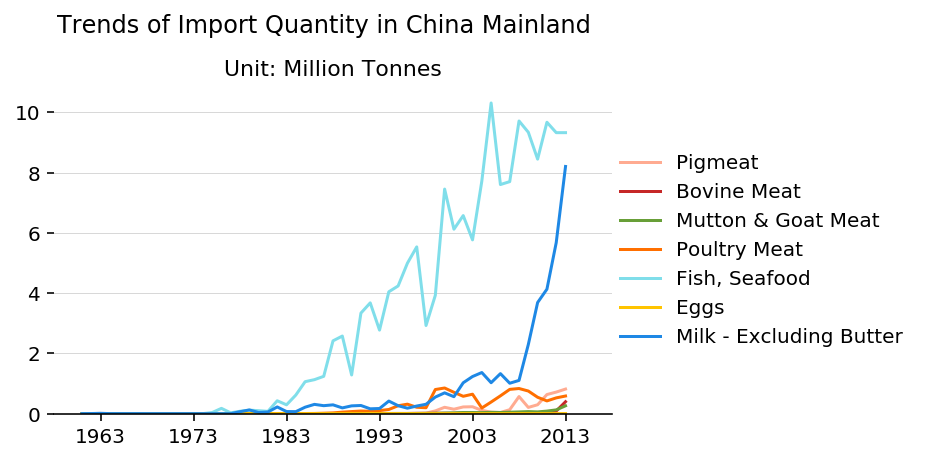

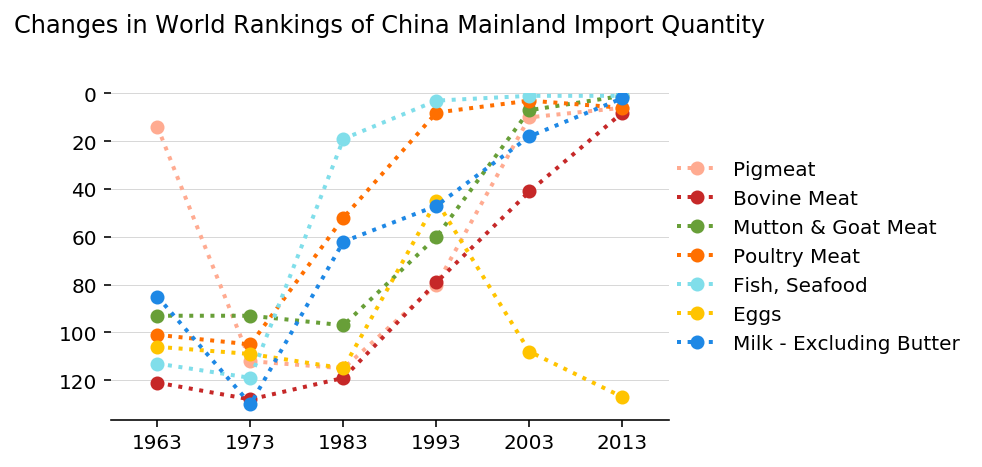

In [77]:
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)
ranking_AreaItemInWorld(A,E)

In [54]:
worldMap(
    element=E,
    items_group='',
    items=[],
    toUnit = 'Million Tonnes',
    changeUnit = 1/1000000,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='BuGn',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Import Quantity_03_01_Import Quantity _Pigmeat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Import Quantity_03_01_Import Quantity _Pigmeat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Import Quantity_03_01_Import Quantity _Pigmeat_2013.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Import Quantity_03_01_Import Quantity _Bovine Meat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Import Quantity_03_01_Import Quantity _Bovine Meat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalanc

1973    1993    2013
Argentina  0.0000e+00  0.0292  0.0208
Australia  9.1500e-04  0.0059  0.2459
Austria    1.7592e-02  0.0021  0.1994
Belgium           NaN     NaN  0.1737
Brazil     3.6000e-05  0.0009  0.0019

1973    1993    2013
Argentina  3.0000e-04  0.0072  0.0002
Australia  1.0000e-04  0.0042  0.0103
Austria    1.4950e-02  0.0036  0.0419
Belgium           NaN     NaN  0.0839
Brazil     1.5880e-03  0.0306  0.0565

1973    1993    2013
Argentina  0.0000e+00  0.0025  0.0000
Australia  1.8000e-05  0.0001  0.0011
Austria    3.3100e-04  0.0029  0.0021
Belgium           NaN     NaN  0.0236
Brazil     1.7000e-05  0.0040  0.0089

1973        1993    2013
Argentina  0.0000e+00  5.1651e-02  0.0037
Australia  7.9000e-05  3.3900e-04  0.0172
Austria    1.5017e-02  1.9085e-02  0.1047
Belgium           NaN         NaN  0.2519
Brazil     6.1000e-04  1.2000e-05  0.0034

1973    1993    2013
Argentina  0.0040  0.0263  0.0685
Australia  0.1838  0.3322  0.6079
Austria    0.1800  0.1956  0.1686
Belgium       NaN     NaN  0.5369
Brazil     0.1344  0.2744  0.7654

1973    1993    2013
Argentina  9.0000e-05  0.0023  0.0010
Australia  0.0000e+00  0.0001  0.0033
Austria    2.1004e-02  0.0144  0.0313
Belgium           NaN     NaN  0.0889
Brazil     1.2100e-04  0.0013  0.0002

1973    1993    2013
Argentina  0.0056  0.2110  0.0786
Australia  0.0815  0.2846  0.7754
Austria    0.0888  0.3137  1.1231
Belgium       NaN     NaN  4.3322
Brazil     0.5617  0.6845  1.0323

OECD


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1961   0.9501       1.2886              0.4502        0.2603         8.5615   
1962   1.0109       1.6628              0.4772        0.2953         9.6894   
1963   1.1125       1.9807              0.5049        0.2552        10.6265   
1964   1.1152       1.8311              0.4974        0.2794        12.3204   
1965   1.1996       1.6780              0.5061        0.3093        12.5920   

        Eggs  Milk - Excluding Butter  
Year                                   
1961  0.4987                   9.7660  
1962  0.4659                  10.2329  
1963  0.3796                  11.7353  
1964  0.2890                  13.8031  
1965  0.2878                  12.7963

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0003          0.0                 0.0           0.0            0.0   
1962   0.0000          0.0                 0.0           0.0            0.0   
1963   0.0074          0.0                 0.0           0.0            0.0   
1964   0.0000          0.0                 0.0           0.0            0.0   
1965   0.0000          0.0                 0.0           0.0            0.0   

      Eggs  Milk - Excluding Butter  
1961   0.0                   0.0003  
1962   0.0                   0.0024  
1963   0.0                   0.0088  
1964   0.0                   0.0009  
1965   0.0                   0.0008

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Import Quantity of Pigmeat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Import Quantity of Bovine Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Import Quantity of Mutton & Goat Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Import Quantity of Poultry Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Import Quantity of Fish, Seafood of Chin

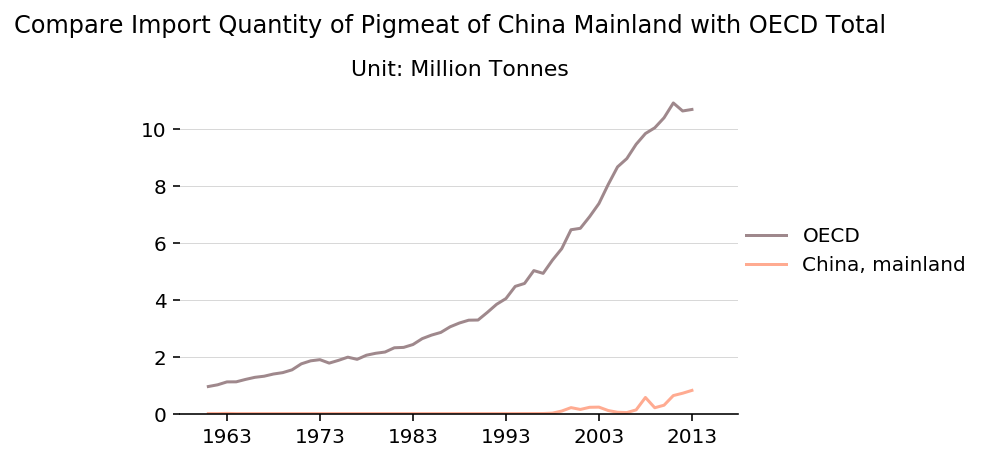

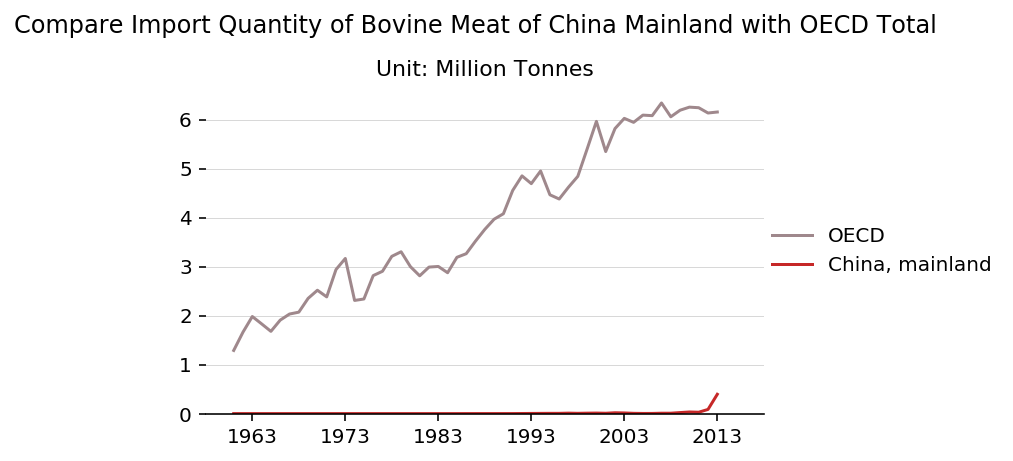

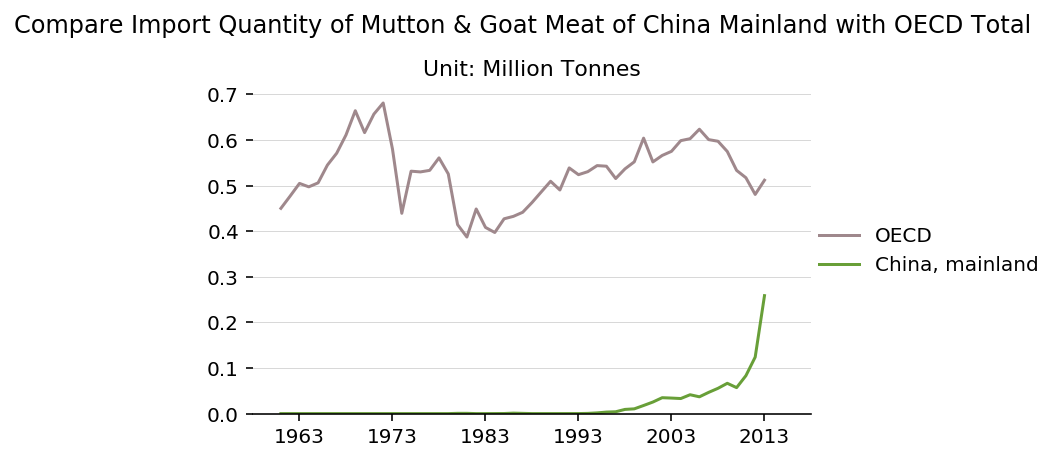

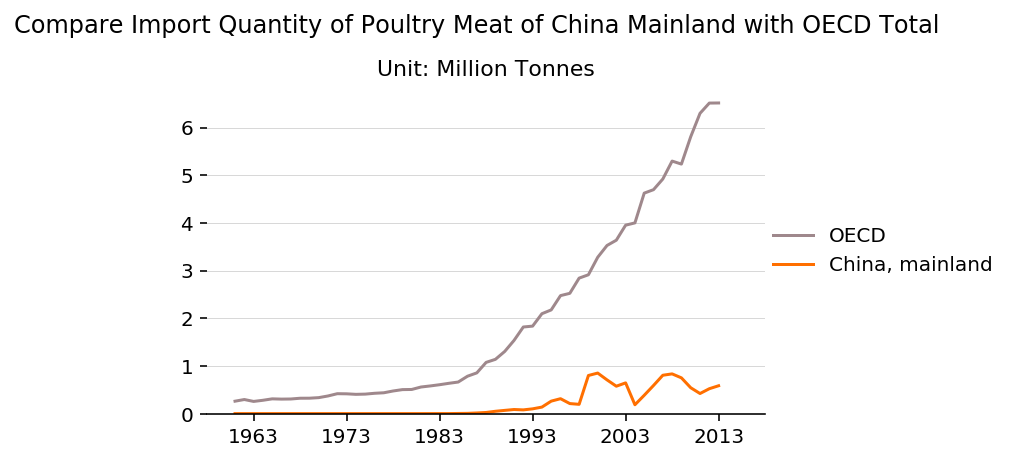

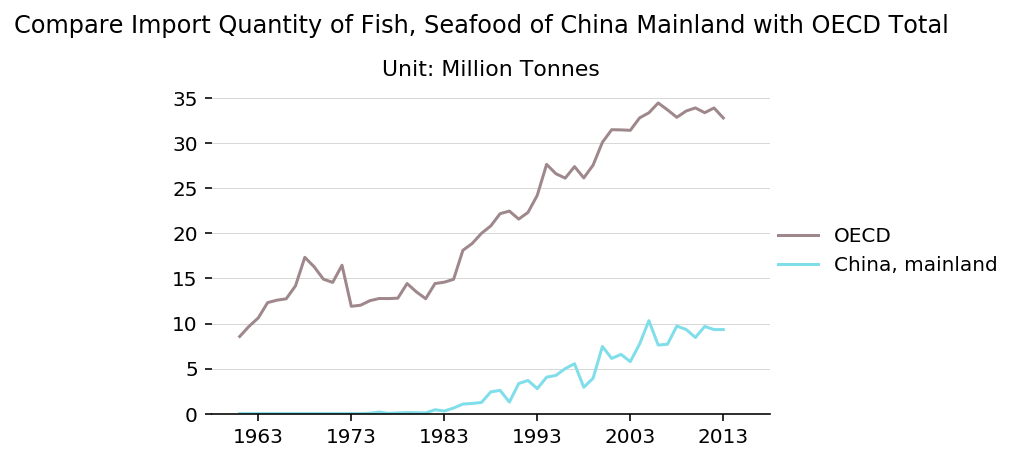

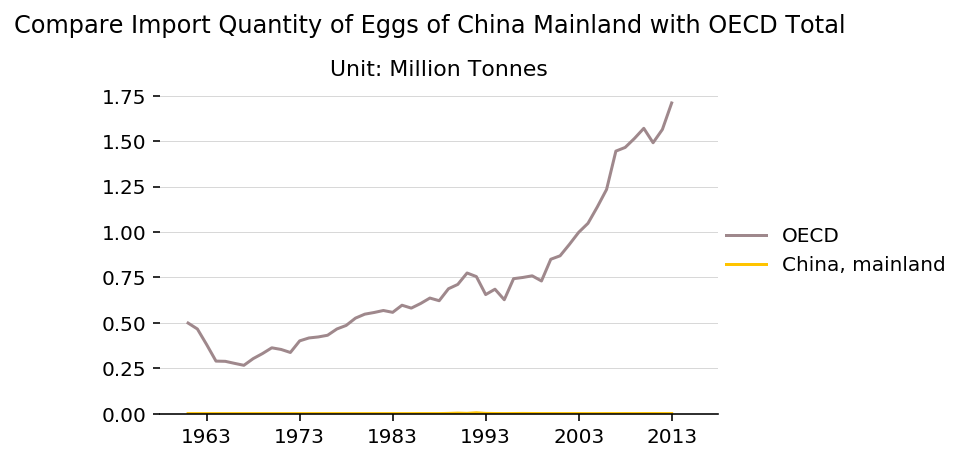

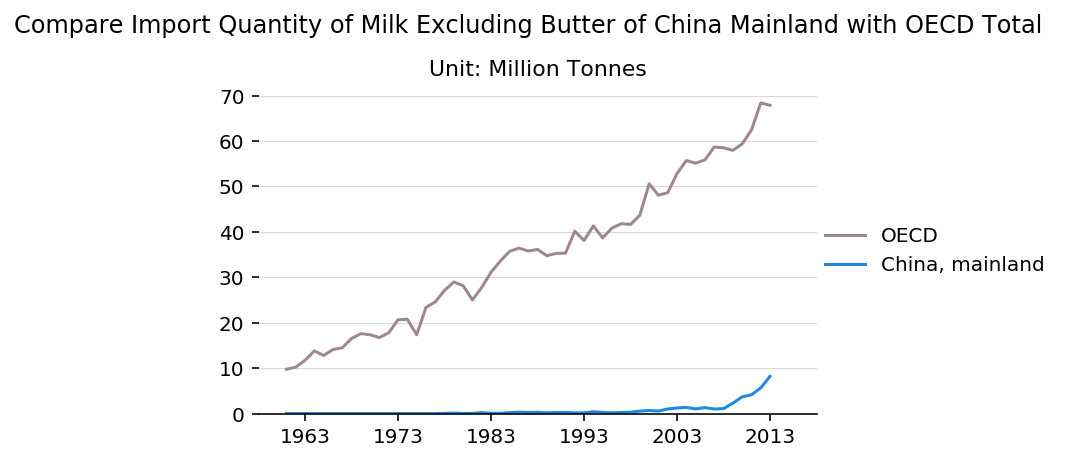

In [55]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

DATA_world = trendsOfArea('World', E, items=items)
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)

compareOtherAreasLine(
    area=A,
    element=E,
    df_area=DATA_area.copy(),
    dfs_compare={'OECD': DATA_OECD, }, 
    toUnit='Million Tonnes',
    changeUnit=1/1000000,
    colors = CLs,
    fig_size = FIG_size,
)

World


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   1.0928       1.5597              0.4730        0.3062        10.3718   
1962   1.1244       2.0270              0.5004        0.3413        11.5810   
1963   1.2530       2.2459              0.5254        0.2984        12.9368   
1964   1.2686       2.1448              0.5234        0.3419        14.9777   
1965   1.3724       2.1140              0.5359        0.3695        15.2635   

        Eggs  Milk - Excluding Butter  
1961  0.5878                  14.2663  
1962  0.5372                  15.2237  
1963  0.4584                  17.3097  
1964  0.4117                  19.7553  
1965  0.4248                  19.1203

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in World_Line.png
Northern America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.1206       0.4435              0.0408        0.0086         1.5346   
1962   0.1362       0.6209              0.0529        0.0050         1.7075   
1963   0.1654       0.7173              0.0592        0.0046         2.0210   
1964   0.1487       0.5230              0.0375        0.0055         2.1836   
1965   0.1714       0.4557              0.0338        0.0036         1.7114   

        Eggs  Milk - Excluding Butter  
1961  0.0052                   2.4153  
1962  0.0037                   2.2647  
1963  0.0070                   2.0973  
1964  0.0035                   2.2736  
1965  0.0045                   1.9368

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in Northern America_Line.png
Western Europe


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.1367       0.2721              0.0200        0.2282         3.7681   
1962   0.1491       0.3641              0.0314        0.2691         4.2282   
1963   0.2057       0.3195              0.0311        0.2265         4.1120   
1964   0.2323       0.4155              0.0307        0.2392         4.9175   
1965   0.2465       0.3914              0.0299        0.2555         5.0678   

        Eggs  Milk - Excluding Butter  
1961  0.3442                   2.4693  
1962  0.3150                   2.5835  
1963  0.2569                   3.4481  
1964  0.2177                   4.7440  
1965  0.1881                   5.0313

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in Western Europe_Line.png
Australia & New Zealand


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  \
1961  0.0000e+00   4.3000e-05          0.0000e+00        0.0012   
1962  1.4000e-05   6.4000e-05          0.0000e+00        0.0003   
1963  2.0000e-03   1.9900e-04          0.0000e+00        0.0002   
1964  2.7700e-03   3.7000e-05          1.5000e-05        0.0002   
1965  1.3270e-03   1.7400e-04          1.0000e-06        0.0001   

      Fish, Seafood  Eggs  Milk - Excluding Butter  
1961         0.1332   0.0                   0.0253  
1962         0.1104   0.0                   0.0262  
1963         0.0739   0.0                   0.0256  
1964         0.1347   0.0                   0.0313  
1965         0.1481   0.0                   0.0358

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in Australia & New Zealand_Line.png
South-Eastern Asia


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0013       0.0172              0.0014        0.0024         0.3260   
1962   0.0013       0.0210              0.0015        0.0024         0.2302   
1963   0.0017       0.0177              0.0018        0.0025         0.2452   
1964   0.0024       0.0103              0.0021        0.0028         0.2736   
1965   0.0031       0.0190              0.0020        0.0031         0.2828   

        Eggs  Milk - Excluding Butter  
1961  0.0082                   0.9289  
1962  0.0072                   0.9297  
1963  0.0063                   1.0794  
1964  0.0068                   1.1299  
1965  0.0070                   1.1096

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in South-Eastern Asia_Line.png
Japan


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  \
1961  1.0670e-03       0.0069              0.0227    9.1000e-05   
1962  8.7000e-05       0.0061              0.0232    2.8400e-04   
1963  6.6110e-03       0.0060              0.0489    3.4710e-03   
1964  4.0990e-03       0.0082              0.0615    5.9360e-03   
1965  1.8400e-04       0.0147              0.0539    6.1350e-03   

      Fish, Seafood    Eggs  Milk - Excluding Butter  
1961         0.1594  0.0001                   0.3722  
1962         0.2559  0.0001                   0.5526  
1963         0.5351  0.0002                   0.7980  
1964         0.7057  0.0003                   0.9091  
1965         0.8157  0.0013                   0.8027

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in Japan_Line.png
Republic of Korea


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  \
1961  0.0000e+00   0.0000e+00                 0.0    0.0000e+00   
1962  4.0000e-06   0.0000e+00                 0.0    0.0000e+00   
1963  4.9000e-05   1.2000e-05                 0.0    1.0000e-06   
1964  6.7000e-05   8.0000e-06                 0.0    0.0000e+00   
1965  7.9000e-05   2.7000e-05                 0.0    0.0000e+00   

      Fish, Seafood        Eggs  Milk - Excluding Butter  
1961         0.0000  0.0000e+00                   0.0118  
1962         0.0002  2.3000e-04                   0.0565  
1963         0.0000  1.4000e-05                   0.1175  
1964         0.0000  0.0000e+00                   0.0698  
1965         0.0000  5.5000e-05                   0.0840

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in Republic Of Korea_Line.png
South America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0116       0.0172              0.0016        0.0008         0.1760   
1962   0.0128       0.0191              0.0016        0.0007         0.2130   
1963   0.0142       0.0181              0.0013        0.0009         0.2140   
1964   0.0137       0.0263              0.0018        0.0028         0.2305   
1965   0.0098       0.0218              0.0041        0.0026         0.2394   

        Eggs  Milk - Excluding Butter  
1961  0.0148                   0.9370  
1962  0.0046                   0.9798  
1963  0.0030                   1.1558  
1964  0.0046                   1.0439  
1965  0.0075                   1.0694

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Import Quantity in South America_Line.png


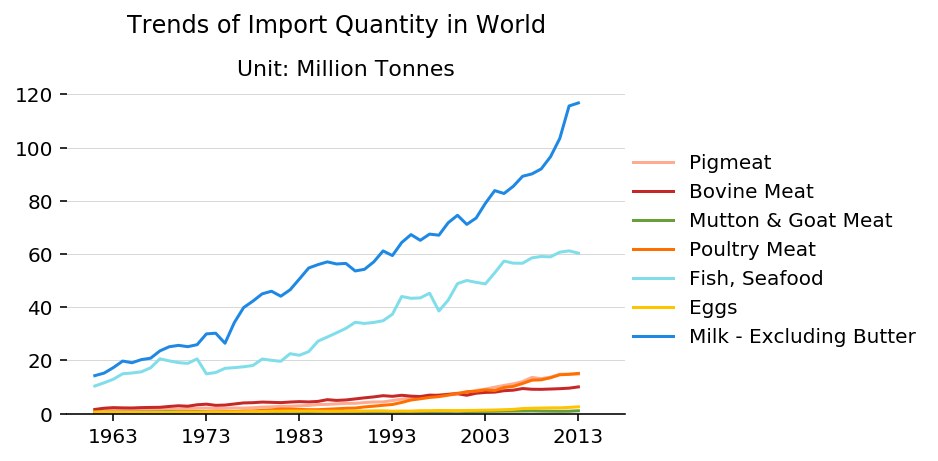

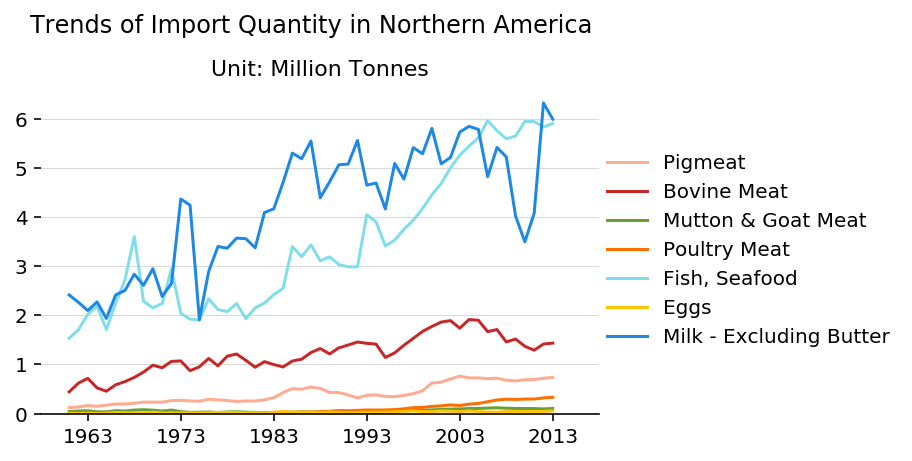

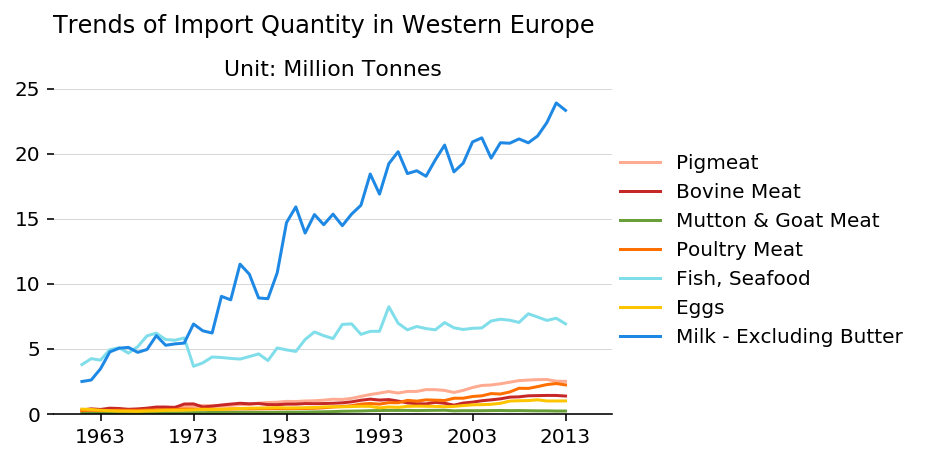

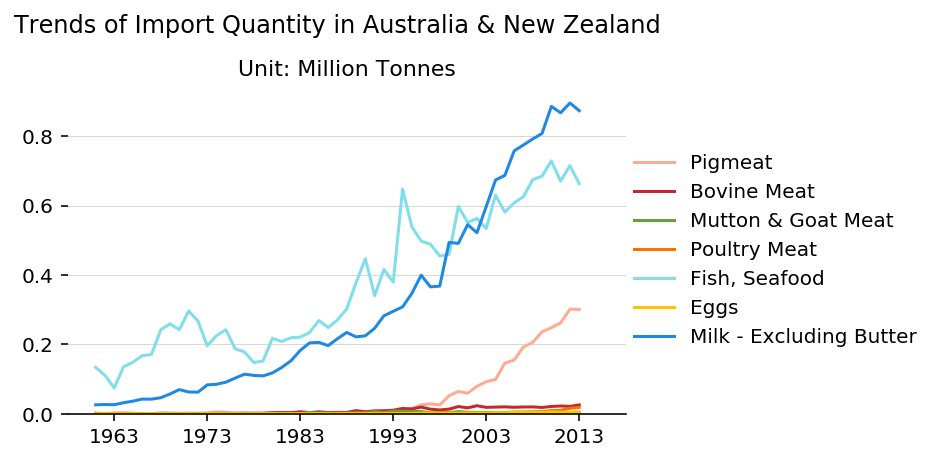

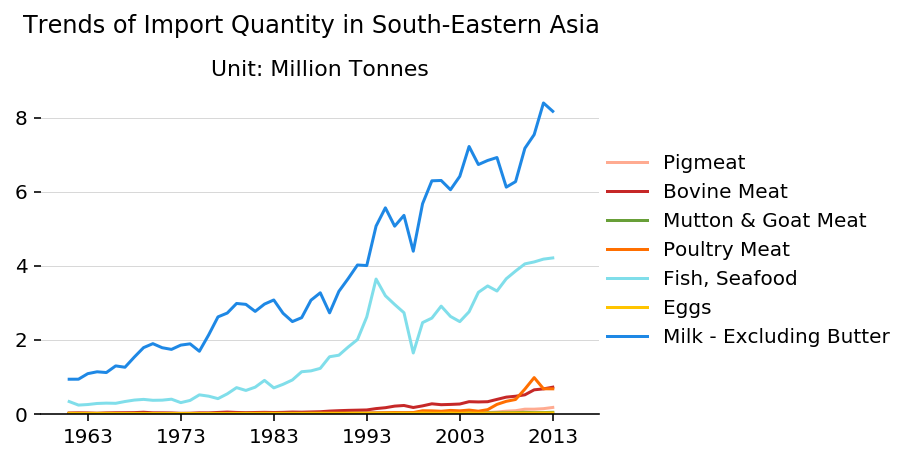

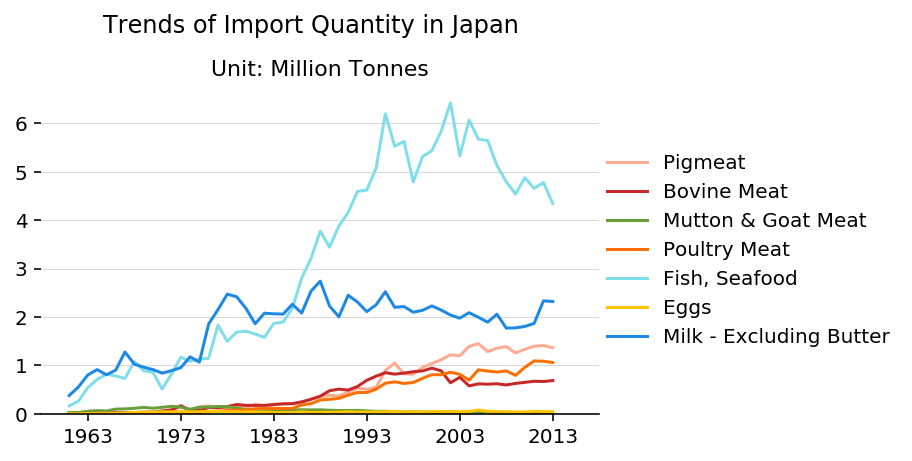

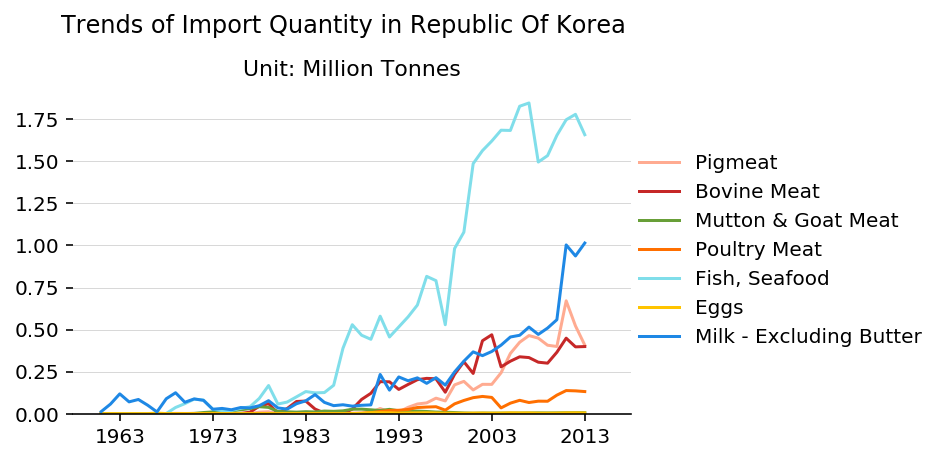

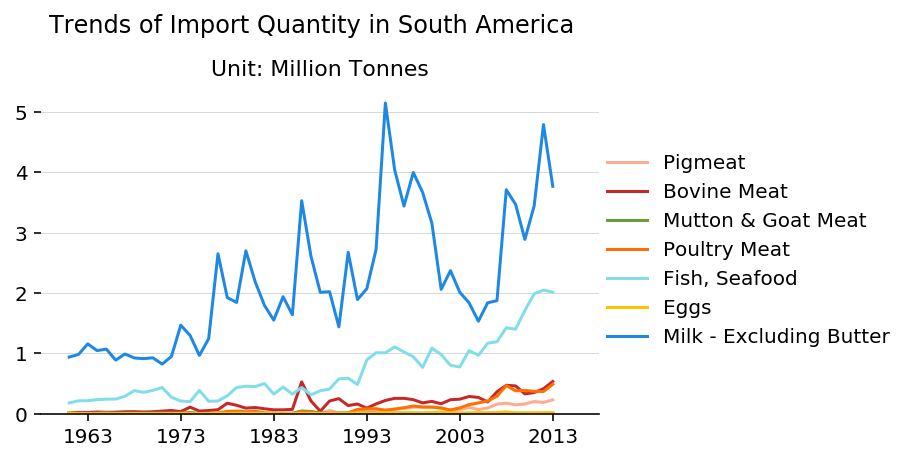

In [56]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea', 'South America'
]
for a in areas:
    print(a)
    plotTrendsLine(a, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

### Export

In [78]:
# 给 Elements 赋值
E = 'Export Quantity'

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


'Export Quantity'

'Meat'

1961       1962       1963       1964       1965       1966  \
Area                                                                        
Africa    106085.0   116354.0   120475.0   144942.0   156433.0   190597.0   
Albania        0.0        0.0        0.0        0.0        0.0        0.0   
Algeria       42.0       66.0      481.0      462.0        0.0        0.0   
Americas  957236.0  1104481.0  1365720.0  1264415.0  1128453.0  1214147.0   
Angola      2532.0     1818.0     2161.0     2418.0     2440.0     3003.0   

               1967       1968       1969       1970       1971       1972  \
Area                                                                         
Africa     171344.0   152444.0   151887.0   181416.0   209312.0   237429.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria       399.0       37.0      160.0      142.0       98.0      272.0   
Americas  1236947.0  1277225.0  1565654.0  1585753.0  1314457.0  1680446.0   
Angola       2702.0     2546.0     2294.0     2279.0     2492.0     2936.0   

               1973       1974       1975       1976       1977       1978  \
Area                                                                         
Africa     257903.0   214590.0   161154.0   195744.0   194520.0   172933.0   
Albania         0.0        0.0        0.0        0.0        0.0       80.0   
Algeria       448.0      223.0       67.0       26.0        0.0        8.0   
Americas  1557492.0  1100519.0  1117405.0  1788736.0  1866920.0  2002518.0   
Angola       2016.0      665.0        0.0        0.0        0.0        0.0   

               1979       1980       1981       1982       1983       1984  \
Area                                                                         
Africa     205989.0   154458.0   114712.0   102793.0   118409.0   120506.0   
Albania        85.0       90.0      100.0      150.0      120.0       90.0   
Algeria         2.0        1.0        0.0        0.0        0.0        0.0   
Americas  1945242.0  1964235.0  2394921.0  2386204.0  2357520.0  2175677.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1985       1986       1987       1988       1989       1990  \
Area                                                                         
Africa     111452.0   102264.0   101924.0    80976.0    76116.0    83544.0   
Albania        10.0        0.0        0.0        0.0        0.0        5.0   
Algeria         0.0        0.0        0.0       12.0       12.0       12.0   
Americas  2203237.0  2292512.0  2271517.0  2758702.0  3195755.0  3323095.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1991       1992       1993       1994       1995       1996  \
Area                                                                         
Africa      89688.0   103997.0   142921.0   128581.0   154937.0   146764.0   
Albania         0.0        5.0        0.0        0.0       75.0      313.0   
Algeria         7.0       18.0      145.0       72.0       23.0       80.0   
Americas  3347041.0  3726928.0  4142778.0  4876647.0  5660776.0  6330087.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1997       1998       1999       2000       2001        2002  \
Area                                                                          
Africa     133745.0   157183.0   128049.0   132735.0   123847.0  1.2295e+05   
Albania       238.0        0.0       46.0       70.0      114.0  1.4700e+02   
Algeria        71.0       75.0       45.0      162.0      149.0  7.2000e+01   
Americas  6824928.0  7095404.0  7672867.0  8945081.0  9782363.0  1.0594e+07   
Angola          0.0        0.0        0.0        0.0        0.0  1.0000e+00   

                2003        2004        2005        2006        2007  \
Area                                                                   
Africa    1.1646e+05  1.0542e+05  9.8733e

'Export Quantity'

'Pigmeat'

1961     1962      1963     1964     1965     1966     1967  \
Area                                                                       
Africa     5152.0   5276.0    4927.0   4817.0   5221.0   8999.0   8214.0   
Albania       0.0      0.0       0.0      0.0      0.0      0.0      0.0   
Algeria       0.0     66.0     481.0    281.0      0.0      0.0      0.0   
Americas  68777.0  67431.0  109645.0  97559.0  57192.0  65416.0  62717.0   
Angola      150.0    176.0     165.0    149.0    161.0    214.0    204.0   

             1968      1969     1970     1971      1972      1973     1974  \
Area                                                                         
Africa     6545.0    8946.0   9266.0   3593.0    3469.0    6585.0   5541.0   
Albania       0.0       0.0      0.0      0.0       0.0       0.0      0.0   
Algeria       1.0       0.0      0.0      0.0      15.0      31.0     65.0   
Americas  74317.0  100216.0  70590.0  84083.0  109940.0  150717.0  95647.0   
Angola       98.0      19.0     14.0     19.0      15.0       6.0     12.0   

              1975      1976      1977      1978      1979      1980  \
Area                                                                   
Africa      3357.0    5631.0    7769.0    6355.0    3461.0    2927.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria       22.0       6.0       0.0       0.0       0.0       0.0   
Americas  148657.0  214996.0  199648.0  174810.0  188102.0  211969.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1981      1982      1983      1984      1985      1986  \
Area                                                                   
Africa      1319.0    2331.0    2748.0    1638.0    2259.0    2029.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  242122.0  245047.0  239836.0  243493.0  250728.0  259647.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1987      1988      1989      1990      1991      1992  \
Area                                                                   
Africa      1767.0    1992.0    1341.0    2683.0    2063.0    2678.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  293600.0  363400.0  425459.0  411594.0  414025.0  514526.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1993      1994      1995      1996       1997       1998  \
Area                                                                     
Africa      2873.0    3070.0    4479.0    5999.0     6704.0     6785.0   
Albania        0.0       0.0       0.0       2.0        0.0        0.0   
Algeria        0.0       0.0       0.0       0.0        0.0        0.0   
Americas  545748.0  591760.0  776551.0  937825.0  1055226.0  1161602.0   
Angola         0.0       0.0       0.0       0.0        0.0        0.0   

               1999       2000       2001       2002       2003       2004  \
Area                                                                         
Africa       6331.0     9719.0     3209.0     7922.0     7284.0     8960.0   
Albania         0.0        0.0       14.0       22.0       21.0        2.0   
Algeria         0.0        0.0        1.0        0.0        0.0        0.0   
Americas  1235691.0  1632369.0  1965181.0  2405934.0  2609594.0  2887913.0   
Angola          0.0        0.0        0.0        0.0       46.0       46.0   

               2005       2006       2007       2008       2009       2010  \
Area                                                                         
Africa       7313.0     7014.0     7383.0    10470.0     7834.0     8395.0   
Albania         5.0      215.0       37.0        0.0       16.0       13.0   
Algeria         0.0        0.0        0.

'Export Quantity'

'Poultry Meat'

1961      1962     1963      1964     1965     1966     1967  \
Area                                                                         
Africa       530.0     444.0    354.0     587.0    450.0    318.0    416.0   
Albania        0.0       0.0      0.0       0.0      0.0      0.0      0.0   
Algeria       19.0       0.0      0.0       0.0      0.0      0.0      0.0   
Americas  113692.0  123904.0  96291.0  106877.0  92384.0  82179.0  66225.0   
Angola         0.0       4.0      7.0       2.0      2.0      3.0     24.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa      402.0    534.0    581.0    693.0    706.0    879.0   1095.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  70119.0  62758.0  65246.0  66491.0  70121.0  78709.0  91729.0   
Angola        6.0      5.0     60.0     90.0     40.0     30.0     31.0   

              1975      1976      1977      1978      1979      1980  \
Area                                                                   
Africa      1318.0    2808.0    9060.0   11825.0   14262.0   13204.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  105188.0  208177.0  234315.0  255182.0  323372.0  522182.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1981      1982      1983      1984      1985      1986  \
Area                                                                   
Africa     11204.0    7640.0    7614.0    2919.0    1870.0    2478.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  699411.0  580944.0  535258.0  515898.0  517898.0  549150.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1987      1988      1989      1990       1991       1992  \
Area                                                                     
Africa      2265.0    1766.0    1489.0    4304.0     2766.0     4450.0   
Albania        0.0       0.0       0.0       0.0        0.0        0.0   
Algeria        0.0       0.0       0.0       0.0        1.0        0.0   
Americas  607117.0  661211.0  767573.0  948091.0  1059450.0  1256146.0   
Angola         0.0       0.0       0.0       0.0        0.0        0.0   

               1993       1994       1995       1996       1997       1998  \
Area                                                                         
Africa       8658.0     6436.0     3130.0     3409.0     7104.0    12509.0   
Albania         0.0        0.0        0.0        0.0       32.0        0.0   
Algeria         0.0        0.0        0.0        2.0       29.0        0.0   
Americas  1636508.0  2076928.0  2573791.0  3078810.0  3112195.0  3293784.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1999       2000       2001       2002       2003       2004  \
Area                                                                         
Africa      10015.0    13719.0    20470.0    22555.0    13125.0    10856.0   
Albania         5.0        2.0       30.0       16.0        7.0        0.0   
Algeria         0.0        0.0        0.0        3.0        1.0        0.0   
Americas  3441163.0  4006112.0  4652514.0  4556350.0  5018398.0  5484406.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               2005       2006       2007       2008       2009       2010  \
Area                                                                         
Africa       8604.0     7584.0    12368.0    12203.0    57120.0    78299.0   
Albania         3.0      227.0        1.0        5.0        0.0        0.0   
Algeri

'Export Quantity'

'Bovine Meat'

1961      1962       1963      1964      1965      1966  \
Area                                                                    
Africa     89323.0   98208.0   104223.0  128345.0  139304.0  168062.0   
Albania        0.0       0.0        0.0       0.0       0.0       0.0   
Algeria       12.0       0.0        0.0       0.0       0.0       0.0   
Americas  693516.0  806680.0  1029883.0  934374.0  837683.0  894803.0   
Angola      2382.0    1637.0     1989.0    2268.0    2276.0    2787.0   

              1967      1968       1969       1970      1971       1972  \
Area                                                                      
Africa    149630.0  132127.0   128946.0   157289.0  190586.0   220165.0   
Albania        0.0       0.0        0.0        0.0       0.0        0.0   
Algeria        0.0       1.0        0.0        0.0       0.0        0.0   
Americas  929004.0  939639.0  1199716.0  1235369.0  986758.0  1291675.0   
Angola      2308.0    2395.0     2263.0     2202.0    2374.0     2876.0   

               1973      1974      1975       1976       1977       1978  \
Area                                                                       
Africa     234365.0  192796.0  145310.0   176270.0   162801.0   140175.0   
Albania         0.0       0.0       0.0        0.0        0.0        0.0   
Algeria         0.0       0.0       0.0        0.0        0.0        0.0   
Americas  1115730.0  741438.0  670334.0  1145972.0  1220895.0  1352537.0   
Angola       1976.0     619.0       0.0        0.0        0.0        0.0   

               1979       1980       1981       1982       1983       1984  \
Area                                                                         
Africa     174334.0   123730.0    85634.0    82758.0   102486.0   109542.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  1225577.0  1038021.0  1268858.0  1385221.0  1422185.0  1268588.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1985       1986       1987       1988       1989       1990  \
Area                                                                         
Africa     102185.0    92112.0    90413.0    73610.0    70687.0    70530.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  1296487.0  1337444.0  1219633.0  1560434.0  1810540.0  1767209.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1991       1992       1993       1994       1995       1996  \
Area                                                                         
Africa      76830.0    85928.0   114148.0   106772.0   129924.0   110861.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0       33.0   
Americas  1703103.0  1802716.0  1805159.0  2076205.0  2183500.0  2170645.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1997       1998       1999       2000       2001       2002  \
Area                                                                         
Africa      93611.0   103030.0    86324.0    82245.0    64546.0    54254.0   
Albania         0.0        0.0       40.0        0.0       28.0       56.0   
Algeria         0.0       38.0        0.0       34.0        0.0        2.0   
Americas  2479360.0  2484705.0  2859613.0  3163741.0  3018020.0  3507158.0   
Angola          0.0        0.0        0.0        0.0        0.0        1.0   

               2003       2004       2005       2006       2007       2008  \
Area                                                                         
Africa      59157.0    62563.0    50769.0    43925.0    78877.0    59726.0   
Albania        30.0  

'Export Quantity'

'Offals'

1961     1962      1963      1964      1965      1966      1967  \
Area                                                                           
Africa     3959.0   6293.0    6177.0    4283.0    4402.0    5190.0    5175.0   
Albania       0.0      0.0       0.0       0.0       0.0       0.0       0.0   
Algeria       0.0      0.0       0.0       0.0       0.0       0.0       0.0   
Americas  84933.0  88519.0  131260.0  149392.0  147232.0  155228.0  164356.0   
Angola        0.0    126.0      90.0     107.0      85.0      19.0      14.0   

              1968      1969      1970      1971      1972      1973  \
Area                                                                   
Africa      4694.0    5351.0    6405.0    7381.0    8492.0    7979.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  171759.0  194530.0  188463.0  186337.0  199078.0  199762.0   
Angola       274.0      51.0      28.0      42.0      14.0      31.0   

              1974      1975      1976      1977      1978      1979  \
Area                                                                   
Africa      4948.0    3248.0    3579.0    4081.0    4506.0    5272.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  189744.0  198909.0  258937.0  260661.0  298383.0  273578.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1980      1981      1982      1983      1984      1985  \
Area                                                                   
Africa      2761.0     662.0    1425.0    1454.0     468.0     414.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  311501.0  341410.0  360598.0  336924.0  335075.0  377687.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1986      1987      1988      1989      1990      1991  \
Area                                                                   
Africa       450.0     189.0     141.0    1795.0    1135.0    1957.0   
Albania        0.0       0.0       0.0       0.0       0.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  376446.0  346568.0  418587.0  368307.0  329129.0  382555.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1992      1993      1994      1995      1996      1997  \
Area                                                                   
Africa      2096.0    1371.0    1306.0    1815.0    1365.0    2101.0   
Albania        0.0       0.0       0.0       0.0       0.0      18.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  412348.0  447516.0  496059.0  591513.0  612372.0  595033.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              1998      1999      2000      2001      2002      2003  \
Area                                                                   
Africa      1372.0     814.0    1327.0    1215.0    1223.0    2223.0   
Albania        0.0       0.0       0.0      12.0      25.0       0.0   
Algeria        0.0       0.0       0.0       0.0       0.0       0.0   
Americas  624949.0  642846.0  784311.0  773206.0  688619.0  714528.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              2004      2005      2006      2007       2008       2009  \
Area                                                                     
Africa      2507.0    2151.0    1979.0    1360.0     1856.0     2585.0   
Albania        3.0     105.0     325.0      10.0        0.0      465.0   
Algeria        0.0       0.0       0.0       7.0        0.0       20.0   
Americas  636696.0  725971.0  748298.0  999701.0  13

'Export Quantity'

'Mutton & Goat Meat'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                      
Africa      842.0   2148.0    729.0    804.0   1079.0   1241.0   1765.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria      11.0      0.0      0.0    181.0      0.0      0.0    399.0   
Americas  35467.0  40983.0  41103.0  21729.0  45805.0  61813.0  63826.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0    167.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa     1539.0   1629.0   1255.0   1191.0   1956.0   3395.0   3572.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       1.0    124.0     18.0      0.0      0.0      0.0      0.0   
Americas  49991.0  51944.0  57643.0  31783.0  18484.0  27605.0  22535.0   
Angola       47.0      7.0      3.0      9.0      5.0      4.0      4.0   

             1975     1976     1977     1978     1979     1980     1981  \
Area                                                                      
Africa     1519.0   1257.0   1478.0   1434.0   1403.0    785.0    893.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  35175.0  40268.0  40691.0  32803.0  29297.0  25465.0  36055.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1982     1983     1984     1985     1986     1987     1988  \
Area                                                                      
Africa      772.0    872.0   2380.0    876.0    832.0   1180.0   1083.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  36977.0  30366.0  18958.0  16383.0  27700.0  19012.0  19856.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1989     1990     1991     1992     1993     1994     1995  \
Area                                                                      
Africa      627.0   1858.0   4069.0   6163.0   9001.0   5019.0   6905.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  33333.0  46919.0  27685.0  21017.0  21886.0  21110.0  16145.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1996     1997     1998     1999     2000     2001     2002  \
Area                                                                      
Africa    13371.0  10391.0  14497.0  10370.0   9388.0  11795.0  15696.0   
Albania       0.0      0.0      0.0      0.0     54.0     22.0      0.0   
Algeria       1.0      0.0      0.0      0.0      0.0      0.0      5.0   
Americas  19733.0  24361.0  24663.0  20507.0  25199.0  19311.0  16152.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             2003     2004     2005     2006     2007     2008     2009  \
Area                                                                      
Africa    19136.0  12962.0  17475.0  16936.0  12949.0  13810.0  14087.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       1.0      0.0      3.0      3.0     22.0      0.0      0.0   
Americas  20515.0  27811.0  40609.0  39768.0  32426.0  35503.0  46841.0   
Angola        0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             2010     2011     2012     2013  
Area                                          
Africa    21039.0  25386.0  30675.0  33912.0  
Albania       0.0      0.0      0.0      0.0  
Algeria       0.0      0.0      0.0      0.0  
Americas  39562.0  35194.0  27940.0  31199.0  
Angola        0.0      0.0      0.0      0.0

'Export Quantity'

'Milk - Excluding Butter'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa         59249.0    52559.5    36556.0    41343.0    53573.0    53077.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0        0.0        0.0        0.0        0.0        0.0   
Americas     4846481.0  6376591.0  7400494.0  8047157.0  5804019.0  3215711.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa         45706.5    38391.0    45906.0    68177.5    63745.0   100929.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0        0.0        0.0        0.0        0.0        0.0   
Americas     3127503.0  3278799.0  3642924.0  4362305.0  3857423.0  2884123.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        115550.0    92031.0    66069.0    55659.0    66892.0    94072.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0        0.0        0.0        0.0        0.0        0.0   
Americas     2201028.0  1282921.0  2019266.0  3165678.0  3709368.0  3710907.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa         93886.0    76348.0    51804.0    50448.0    71848.0    65214.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0     2453.0        0.0      453.0        0.0        0.0   
Americas     2696570.0  3342958.0  3306162.0  4325140.0  5077752.0  5294272.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        182733.0   132781.0    63835.0    74993.0    98509.0   217673.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0        0.0        0.0        0.0        0.0        0.0   
Americas     5895099.0  6323895.0  5181172.0  5013465.0  3916444.0  1944345.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        308069.0   235891.0   348338.0   402453.0   393736.0   402628.0   
Albania            0.0        0.0        0.0        0.0        0.0        0.0   
Algeria            0.0        0.0        0.0        0.0     5274.0     3836.0   
Americas     2341281.0  2827483.0  2992756.0  2850003.0  3908246.0  3188193.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan        0.0        0.0        0.0        0.0        0.0        0.0   
Africa        365055.0   436399.0   503035.0   393779.0   326008.0   417391.5   
Albania            0.0        0.0      167.0     2531.0      209.0        0.0   
Algeria            0.0     4302.0       42.0        2.0        0.0     1420.0   
Americas     4303335.0  4937567.0  6102514.0  5189906.0  5272567.0  5941023.0   

                  2003       2004       20

'Export Quantity'

'Animal fats'

1961       1962       1963       1964       1965       1966  \
Area                                                                         
Africa      84488.0    74950.0    57747.0    74612.0    70879.0    61336.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  1699182.0  1466857.0  1809713.0  2236750.0  1762774.0  1630061.0   
Angola       3304.0     2800.0     3133.0     7436.0     4714.0     5329.0   

               1967       1968       1969       1970       1971       1972  \
Area                                                                         
Africa      55432.0    98450.0    62489.0    77020.0    43237.0    68319.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  1878282.0  1989612.0  1870337.0  2119572.0  2320046.0  2046585.0   
Angola       4665.0     4051.0     8466.0    11701.0     8303.0    19401.0   

               1973       1974       1975       1976       1977       1978  \
Area                                                                         
Africa      83157.0    53198.0    35181.0    32454.0    21512.0    25795.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  1729526.0  1969417.0  1627020.0  1805456.0  2153035.0  2117875.0   
Angola      17700.0    10600.0     6000.0        0.0        0.0        0.0   

               1979       1980       1981       1982       1983       1984  \
Area                                                                         
Africa      29564.0    13470.0    33593.0    13174.0    28343.0    18854.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  2202762.0  2535536.0  2583754.0  2440517.0  2351992.0  2342235.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1985       1986       1987       1988       1989       1990  \
Area                                                                         
Africa      17808.0    30779.0    67737.0    32646.0    27332.0    30763.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  2320789.0  2189262.0  2036105.0  2248315.0  2392990.0  2104820.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1991       1992       1993       1994       1995       1996  \
Area                                                                         
Africa      34292.0    47790.0    48206.0    39051.0    36008.0    26360.0   
Albania         0.0        0.0        0.0        0.0        0.0       35.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  2151591.0  2437473.0  2416151.0  2931090.0  3052810.0  2426645.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1997       1998       1999       2000       2001       2002  \
Area                                                                         
Africa      35392.0    55552.0    38325.0    39410.0    38366.0    34964.0   
Albania         0.0        0.0        0.0        0.0       13.0        0.0   
Algeria         0.0      101.0        0.0        0.0        0.0        1.0   
Americas  2220401.0  2483786.0  2762020.0  2725813.0  2404230.0  2730078.0   
Angola         90.0      965.0      690.0      400.0        0.0        0.0   

               2003       2004       2005       2006       2007       2008  \
Area                                                                         
Africa      42171.0    50861.0

'Export Quantity'

'Eggs'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                      
Africa    11966.0  11597.0  11929.0   8677.0   7636.0   9634.0  10578.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  39394.0  24968.0  31441.0  15485.0  21646.0  19434.0  19330.0   
Angola        0.0      6.0      4.0      6.0      7.0     11.0      8.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa    10550.0  12946.0   8583.0   5480.0   6385.0  10730.0  11582.0   
Albania       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  18464.0  17294.0  19355.0  16319.0  18664.0  26244.0  32747.0   
Angola       11.0     12.0      0.0      0.0     36.0     31.0     29.0   

             1975     1976     1977     1978     1979      1980      1981  \
Area                                                                        
Africa    12933.0  13787.0  15739.0  14940.0  18541.0    5535.0    1366.0   
Albania       0.0      0.0      0.0      0.0      0.0       0.0       0.0   
Algeria       0.0      0.0      0.0      0.0      0.0       0.0       0.0   
Americas  32492.0  29937.0  54159.0  70016.0  53927.0  106076.0  165503.0   
Angola        0.0      0.0      0.0      0.0      0.0       0.0       0.0   

              1982     1983     1984     1985     1986     1987     1988  \
Area                                                                       
Africa      4341.0   4171.0   5790.0   4988.0   2581.0   2583.0   2061.0   
Albania        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Algeria        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Americas  110167.0  39553.0  35340.0  38958.0  52066.0  56259.0  77338.0   
Angola         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             1989     1990     1991      1992      1993      1994      1995  \
Area                                                                          
Africa     3476.0   4605.0   5927.0    3456.0    8177.0    7711.0    4454.0   
Albania       0.0      0.0      0.0       0.0       0.0       0.0       0.0   
Algeria       0.0      0.0      0.0       0.0       0.0       0.0       0.0   
Americas  65621.0  65980.0  98031.0  105824.0  124929.0  141111.0  163400.0   
Angola        0.0      0.0      0.0       0.0       0.0       0.0       0.0   

              1996      1997      1998      1999      2000      2001  \
Area                                                                   
Africa      6403.0    7304.0    6871.0    7010.0    6821.0    7642.0   
Albania        0.0       0.0       0.0       0.0       0.0     587.0   
Algeria        1.0       0.0       7.0       0.0       0.0       0.0   
Americas  164273.0  159151.0  151413.0  124251.0  149484.0  151126.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              2002      2003      2004      2005      2006      2007  \
Area                                                                   
Africa     21126.0   12176.0   12820.0    6977.0    6152.0    4076.0   
Albania     1777.0     531.0     626.0     656.0     145.0    2308.0   
Algeria        1.0      27.0       0.0       1.0       3.0       5.0   
Americas  156112.0  135893.0  160683.0  195867.0  195482.0  228874.0   
Angola         0.0       0.0       0.0       0.0       0.0       0.0   

              2008      2009      2010      2011      2012      2013  
Area                                                                  
Africa      5585.0    7669.0   12805.0   10194.0   15942.0   25196.0  
Albania     3290.0    1825.0    3511.0    2763.0    3617.0     831.0  
Algeria        0.0       0.0       1.0  

'Export Quantity'

'Fish, Seafood'

1961       1962       1963        1964       1965       1966  \
Area                                                                          
Africa    1317302.0  1431461.0  1433079.0  1.6878e+06  1554702.0  1614861.0   
Albania         0.0        0.0        0.0  0.0000e+00        0.0        0.0   
Algeria     10804.0     5700.0     3800.0  2.1780e+03     1900.0     1564.0   
Americas  5415267.0  7797666.0  7686131.0  1.0244e+07  9647457.0  9895152.0   
Angola     197485.0   230768.0   187158.0  3.0074e+05   221471.0   314353.0   

                1967        1968        1969        1970        1971  \
Area                                                                   
Africa    1.7982e+06  1.7738e+06  1.7514e+06  1.1580e+06  8.9221e+05   
Albania   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00   
Algeria   2.7000e+03  2.8500e+03  2.8540e+03  4.4400e+03  2.9000e+03   
Americas  1.0566e+07  1.3350e+07  1.1613e+07  1.2379e+07  1.1777e+07   
Angola    2.1365e+05  2.2304e+05  3.7414e+05  2.9381e+05  2.5578e+05   

               1972       1973       1974       1975       1976       1977  \
Area                                                                         
Africa    1355796.0  1330283.0  1272500.0  1220494.0   612654.0   457067.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria      1995.0     4175.0     2400.0     2033.0     2777.0     3760.0   
Americas  9959606.0  3279647.0  4662824.0  5443065.0  5456291.0  5144666.0   
Angola     537007.0   423076.0   359647.0   137288.0        0.0        0.0   

               1978       1979       1980       1981       1982       1983  \
Area                                                                         
Africa     508775.0   575526.0   489029.0   551695.0   466822.0   590702.0   
Albania         0.0        0.0        0.0        0.0      320.0      140.0   
Algeria       692.0      501.0      462.0      475.0       24.0       69.0   
Americas  5993827.0  6906399.0  7307053.0  6984943.0  9327002.0  7619219.0   
Angola          0.0        0.0        0.0        0.0        0.0        0.0   

               1984        1985        1986        1987        1988  \
Area                                                                  
Africa     577040.0  6.0369e+05  6.2991e+05  8.7039e+05  7.1902e+05   
Albania       220.0  0.0000e+00  2.8130e+03  2.5830e+03  3.3780e+03   
Algeria        87.0  1.3500e+02  9.1000e+01  1.3200e+02  1.1200e+02   
Americas  8696387.0  1.1642e+07  1.2949e+07  1.3127e+07  1.3823e+07   
Angola          0.0  0.0000e+00  0.0000e+00  0.0000e+00  3.1280e+03   

                1989        1990        1991        1992        1993  \
Area                                                                   
Africa    6.4718e+05  7.8660e+05  9.4765e+05  1.1920e+06  1.2514e+06   
Albania   3.2520e+03  6.2300e+03  2.5170e+03  1.4340e+03  1.3070e+03   
Algeria   8.7000e+01  1.9200e+02  5.1300e+02  1.0810e+03  7.3200e+02   
Americas  1.6198e+07  1.4417e+07  1.4621e+07  1.4543e+07  1.6338e+07   
Angola    1.8960e+03  1.0440e+03  1.2240e+03  1.4560e+03  2.2790e+03   

                1994        1995        1996        1997        1998  \
Area                                                                   
Africa    1.4512e+06  1.5425e+06  1.3056e+06  1.4603e+06  1.9072e+06   
Albania   1.0200e+03  1.0730e+03  2.6310e+03  2.2760e+03  3.3240e+03   
Algeria   8.8000e+02  1.4160e+03  8.2300e+02  9.1300e+02  4.7700e+02   
Americas  2.0782e+07  1.8908e+07  1.7663e+07  1.7908e+07  1.0654e+07   
Angola    2.2210e+03  3.3300e+03  1.7530e+03  4.8330e+03  6.6830e+03   

                1999        2000        2001        2002        2003  \
Area                                                                   
Africa    1.6903e+06  2.0219e+06  2.0679e+06  2.1673e+06  2.1835e+06   
Albania   4.6160e+03  3.0600e+03  3.5590e+03  3.1800e+03  4.0860e+03   
Algeria   1.2050e+03  1.7990e+03  1.9580e+03  3.0790e+03  2.3780e+

'Export Quantity'

'Meat'

Area    Africa  Albania  Algeria    Americas  Angola  Argentina  Armenia  \
2012  150233.0    181.0    468.0  1.7943e+07    46.0   575288.0    882.0   
2013  258980.0    224.0    503.0  1.8077e+07    46.0   623996.0    795.0   

Area       Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  4350144.0  1754895.0                2662943.0  472724.0      2633.0   
2013  5201884.0  2078132.0                3049067.0  477378.0      2246.0   

Area  Bahamas  Bangladesh   Belarus    Belgium  Belize  Benin  \
2012      0.0         0.0  418927.0  1582492.0     1.0   25.0   
2013      0.0         0.0  447855.0  1578929.0    11.0    0.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            3887.0                 13926.0   23257.0   
2013                            6741.0                 10847.0   39303.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  6318072.0                4.0   62444.0          84.0      46.0   
2013  6529352.0              128.0   49504.0           1.0       0.0   

Area  Cameroon     Canada  Caribbean  Central African Republic  \
2012       0.0  1776180.0    15231.0                       0.0   
2013       0.0  1783167.0    14453.0                       0.0   

Area  Central America  Central Asia  Chad     Chile  China, Hong Kong SAR  \
2012         515198.0        4312.0   0.0  308349.0              812564.0   
2013         479996.0        4642.0   0.0  286375.0             1046511.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012               0.0                     8175.0         944479.0   12290.0   
2013               0.0                    11886.0         900748.0   45113.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus   Czechia  Czechoslovakia  \
2012  271.0     32536.0  27176.0   0.0  4564.0  164231.0             NaN   
2013    4.0     30293.0  29216.0   0.0  2651.0  181351.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea    Denmark  \
2012          401.0                                    0.0  1725549.0   
2013          627.0                                    0.0  1672850.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012       0.0              9255.0         27191.0     1826363.0   
2013       0.0              8946.0         34459.0     2031779.0   

Area  Eastern Europe  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  \
2012       2969006.0    197.0  2192.0       9027.0  44812.0   14764.0   
2013       3241837.0     64.0  1035.0       7916.0  47126.0   14764.0   

Area  Ethiopia PDR      Europe  European Union    Fiji  Finland     France  \
2012           NaN  1.9343e+07      1.8654e+07   508.0  49497.0  1557352.0   
2013           NaN  1.9429e+07      1.8632e+07  1714.0  53800.0  1524472.0   

Area  Gabon  Gambia  Georgia    Germany  Ghana   Greece  Guatemala  Guinea  \
2012    0.0    93.0    814.0  3533757.0  187.0  34685.0    26634.0    52.0   
2013    0.0   184.0    761.0  3520075.0   58.0  32627.0    24263.0    52.0   

Area  Guyana  Haiti  Honduras   Hungary  Iceland      India  Indonesia  \
2012     2.0    0.0   10437.0  405430.0   4579.0  1057986.0    11017.0   
2013    50.0    0.0   10869.0  412341.0   4010.0  1588897.0    11339.0   

Area  Iran (Islamic Republic of)  Iraq   Ireland  Israel     Italy  Jamaica  \
2012                     46820.0   0.0  820160.0  9928.0  641937.0   1378.0   
2013                     38478.0   0.0  775078.0  8957.0  639657.0   1902.0   

Area    Japan   Jordan  Kazakhstan   Kenya  Kuwait  Kyrgyzstan  \
2012  12018.0  55159.0      3692.0  3512.0  1136.0       620.0   
2013  14607.0  59212.0      4020.0  7177.0  6995.0       622.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                          325337.0                               0.0   
2013                          351153.0                               

'Export Quantity'

'Pigmeat'

Area   Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
2012   7483.0     39.0      0.0  4855003.0    46.0     1353.0    389.0   
2013  29951.0     56.0      0.0  4633197.0    46.0     1415.0    609.0   

Area      Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  457635.0    42430.0                  43371.0  282531.0         0.0   
2013  544540.0    43186.0                  44312.0  282179.0         5.0   

Area  Bahamas   Belarus   Belgium  Belize  Benin  \
2012      0.0  199393.0  840149.0     1.0    0.0   
2013      0.0  180953.0  875125.0     1.0    0.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                               0.0                  5014.0      31.0   
2013                               0.0                  4300.0      61.0   

Area    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  818827.0                0.0   12693.0           0.0       0.0       0.0   
2013  756830.0                4.0    9832.0           0.0       0.0       0.0   

Area     Canada  Caribbean  Central America  Central Asia  Chad     Chile  \
2012  1264252.0     2376.0         133349.0         337.0   0.0  179977.0   
2013  1262754.0     1951.0         156825.0         281.0   0.0  162390.0   

Area  China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
2012              110428.0               0.0                     3808.0   
2013              175368.0               0.0                     3480.0   

Area  China, mainland  Colombia  Congo  Costa Rica  Croatia  Cuba  Cyprus  \
2012         262105.0      14.0    0.0      9566.0  12715.0   0.0  3245.0   
2013         279497.0      20.0    0.0      9806.0  13548.0   0.0  1559.0   

Area   Czechia  Czechoslovakia  Côte d'Ivoire  \
2012  101287.0             NaN           34.0   
2013  101271.0             NaN           31.0   

Area  Democratic People's Republic of Korea    Denmark  Dominican Republic  \
2012                                    0.0  1476980.0                16.0   
2013                                    0.0  1446941.0                16.0   

Area  Eastern Africa  Eastern Asia  Eastern Europe  Ecuador  Egypt  \
2012          2386.0      379905.0       1236629.0     25.0   39.0   
2013          2985.0      464433.0       1282353.0      2.0   45.0   

Area  El Salvador  Estonia  Ethiopia  Ethiopia PDR      Europe  \
2012       4486.0  30383.0      12.0           NaN  1.0095e+07   
2013       3318.0  31838.0      12.0           NaN  1.0199e+07   

Area  European Union   Fiji  Finland    France  Gabon  Gambia  Georgia  \
2012       9777994.0  147.0  34633.0  614471.0    0.0     0.0    117.0   
2013       9912098.0  280.0  38421.0  617261.0    0.0    18.0    522.0   

Area    Germany  Ghana   Greece  Guatemala  Guyana  Honduras   Hungary  \
2012  2350557.0   58.0  10856.0    12233.0     0.0       6.0  183063.0   
2013  2407126.0    0.0   8410.0    12671.0    44.0      22.0  183139.0   

Area  Iceland  India  Indonesia  Iran (Islamic Republic of)   Ireland  Israel  \
2012     36.0  475.0       85.0                         0.0  207659.0   739.0   
2013      3.0  308.0       84.0                         0.0  199497.0   869.0   

Area     Italy  Jamaica   Japan  Jordan  Kazakhstan   Kenya  Kyrgyzstan  \
2012  268636.0    303.0   903.0     0.0       183.0  2200.0       154.0   
2013  274380.0    417.0  2454.0     0.0       133.0  2607.0       148.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                           11116.0                               0.0   
2013                           11093.0                               0.0   

Area   Latvia  Least Developed Countries  Lebanon  Lithuania  \
2012  15427.0                      740.0    657.0    24931.0   
2013  18265.0                      769.0   1745.0    31487.0   

Area  Low Income Food Deficit Countries  Luxembourg  Madagascar  Malawi  \
2012                  

'Export Quantity'

'Poultry Meat'

Area   Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
2012  20358.0      2.0    240.0  8700278.0     0.0   333780.0     19.0   
2013  62065.0      0.0    320.0  8719809.0     0.0   368019.0     70.0   

Area       Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  2283999.0    39617.0                  49271.0  68031.0         0.0   
2013  2535786.0    38154.0                  51013.0  66972.0         0.0   

Area  Bahamas   Belarus   Belgium  Belize  Benin  \
2012      0.0  106258.0  521726.0     0.0   25.0   
2013      0.0  106640.0  498241.0    10.0    0.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            1777.0                  7724.0       3.0   
2013                            2305.0                  5333.0       2.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  3942267.0                1.0   43411.0          43.0      20.0   
2013  3902419.0               27.0   33814.0           0.0       0.0   

Area  Cameroon    Canada  Caribbean  Central America  Central Asia  Chad  \
2012       0.0  177636.0    11002.0          27291.0        2832.0   0.0   
2013       0.0  189860.0    10562.0          30577.0        2679.0   0.0   

Area     Chile  China, Hong Kong SAR  China, Macao SAR  \
2012  119063.0              635123.0               0.0   
2013  112912.0              805527.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                     3581.0         553811.0     903.0    0.0      2866.0   
2013                     7450.0         563993.0    1078.0    3.0      2959.0   

Area  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
2012  11154.0   0.0  1177.0  49273.0             NaN           32.0  140759.0   
2013  10150.0   0.0   916.0  49817.0             NaN           27.0  121994.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012              9226.0           259.0     1228311.0       1179798.0   
2013              8917.0           748.0     1418797.0       1315863.0   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012    157.0  1472.0       4536.0  10083.0       1.0           NaN   
2013     50.0   646.0       4591.0  10935.0       1.0           NaN   

Area     Europe  European Union   Fiji  Finland    France  Gabon  Gambia  \
2012  5253328.0       5041275.0   45.0  12547.0  580761.0    0.0     0.0   
2013  5322441.0       5027234.0  102.0  12838.0  579399.0    0.0    20.0   

Area  Georgia   Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Honduras  \
2012    355.0  710908.0    8.0  20363.0     7481.0    52.0     1.0     297.0   
2013    103.0  676184.0   41.0  19427.0     7766.0    52.0     1.0    3370.0   

Area   Hungary  Iceland   India  Indonesia  Iran (Islamic Republic of)  \
2012  194268.0      0.0  5672.0       12.0                     45197.0   
2013  202704.0      0.0  6380.0        2.0                     36734.0   

Area  Ireland  Israel     Italy  Jamaica   Japan   Jordan  Kazakhstan  Kenya  \
2012  69096.0  9075.0  167675.0    543.0  7152.0  20470.0      2830.0   92.0   
2013  52521.0  7902.0  165344.0    716.0  9027.0  23891.0      2677.0   49.0   

Area  Kuwait  Kyrgyzstan  Land Locked Developing Countries   Latvia  \
2012   918.0         2.0                            5255.0  10043.0   
2013  2537.0         2.0                            6173.0  13387.0   

Area  Least Developed Countries  Lebanon  Lithuania  \
2012                      949.0   7504.0    39754.0   
2013                      959.0   6279.0    44366.0   

Area  Low Income Food Deficit Countries  Luxembourg  Madagascar  Malawi  \
2012                             8577.0       994.0         0.0    19.0   
2013                            10101.0       660.0         0.0   584.0   

Area  Malaysia  Mali  Mauritania  Melanesia  Mexico  Middle Africa  \
2012  

'Export Quantity'

'Bovine Meat'

Area    Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
2012   70015.0     34.0      0.0  4280079.0     0.0   213423.0    474.0   
2013  108649.0      1.0      0.0  4625838.0     0.0   233103.0    116.0   

Area       Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  1468891.0  1321447.0                1851936.0  119388.0      2633.0   
2013  1940031.0  1537728.0                2078385.0  125224.0      2241.0   

Area  Bahamas  Bangladesh   Belarus   Belgium  Belize  Benin  \
2012      0.0         0.0  113205.0  172009.0     0.0    0.0   
2013      0.0         0.0  160224.0  160328.0     0.0    0.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            2110.0                   748.0   21992.0   
2013                            4436.0                   690.0   35861.0   

Area     Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  \
2012  1554428.0                3.0    1611.0           1.0      26.0   
2013  1868135.0               96.0    2190.0           1.0       0.0   

Area  Cameroon    Canada  Caribbean  Central America  Central Asia  Chad  \
2012       0.0  313274.0     1807.0         335261.0        1040.0   0.0   
2013       0.0  311461.0     1935.0         276963.0        1561.0   0.0   

Area   Chile  China, Hong Kong SAR  China, Macao SAR  \
2012  4192.0               63862.0               0.0   
2013  4848.0               62526.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                      706.0         101888.0   11349.0  271.0     20028.0   
2013                      864.0          34658.0   43940.0    0.0     17463.0   

Area  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
2012   3242.0   0.0   133.0  11464.0             NaN           34.0  106359.0   
2013   5387.0   0.0   158.0  11005.0             NaN           40.0  102535.0   

Area  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012       0.0                13.0          4491.0      186565.0   
2013       0.0                13.0         10813.0      120139.0   

Area  Eastern Europe  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  \
2012        498529.0      0.0  520.0          5.0   3961.0     993.0   
2013        560110.0      0.0  295.0          8.0   3949.0     993.0   

Area  Ethiopia PDR     Europe  European Union    Fiji  Finland    France  \
2012           NaN  3266011.0       3117997.0   256.0    820.0  276390.0   
2013           NaN  3142168.0       2937398.0  1178.0   1465.0  248909.0   

Area  Gabon  Gambia  Georgia   Germany  Ghana  Greece  Guatemala  Guyana  \
2012    0.0    50.0    111.0  447255.0  114.0   803.0     6901.0     0.0   
2013    0.0   146.0     43.0  410450.0    2.0   777.0     3807.0     0.0   

Area  Haiti  Honduras  Hungary  Iceland      India  Indonesia  \
2012    0.0   10060.0  17164.0     38.0  1038571.0     3511.0   
2013    0.0    7403.0  16214.0     14.0  1559423.0     2490.0   

Area  Iran (Islamic Republic of)  Iraq   Ireland  Israel     Italy  Jamaica  \
2012                      1599.0   0.0  491247.0    81.0  190487.0    496.0   
2013                      1720.0   0.0  474495.0   186.0  186135.0    769.0   

Area   Japan   Jordan  Kazakhstan   Kenya  Kuwait  Kyrgyzstan  \
2012  3963.0  30015.0       583.0   372.0   138.0       457.0   
2013  3115.0  33034.0      1096.0  2134.0  1722.0       465.0   

Area  Land Locked Developing Countries   Latvia  Least Developed Countries  \
2012                          282018.0  10748.0                    18775.0   
2013                          306826.0  10357.0                    22165.0   

Area  Lebanon  Lesotho  Liberia  Lithuania  Low Income Food Deficit Countries  \
2012   3335.0      0.0     32.0    31600.0                          1212337.0   
2013   3377.0      0.0     32.0    27011.0                          1725046.0   

Area  Luxembourg  Madagascar

'Export Quantity'

'Offals'

Area   Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
2012  10027.0    422.0      0.0  1479178.0     0.0    74191.0     13.0   
2013  17265.0      0.0     50.0  1514181.0     0.0    82918.0      0.0   

Area      Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  466009.0   178786.0                 242624.0  73000.0         0.0   
2013  527064.0   201517.0                 267906.0  76592.0         0.0   

Area  Belarus   Belgium  Belize  Benin  Bolivia (Plurinational State of)  \
2012   6382.0  171617.0     0.0    0.0                               0.0   
2013   7224.0  194075.0     0.0    0.0                               0.0   

Area  Bosnia and Herzegovina  Botswana    Brazil  Brunei Darussalam  Bulgaria  \
2012                    15.0      58.0  443510.0                0.0    3965.0   
2013                   529.0     616.0  469129.0                0.0    3908.0   

Area  Burkina Faso  Cambodia  Cameroon    Canada  Caribbean  Central America  \
2012           0.0      11.0       0.0  181278.0        3.0          26855.0   
2013          11.0       7.0       0.0  179222.0       21.0          27266.0   

Area  Central Asia  Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
2012          97.0   0.0  55268.0              408485.0               3.0   
2013         104.0   0.0  47436.0              430200.0               3.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                       73.0           1707.0    1853.0    1.0      1339.0   
2013                       83.0           9668.0    1898.0   48.0      2179.0   

Area  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire   Denmark  \
2012   2439.0   0.0  2057.0  30208.0             NaN           14.0  260632.0   
2013   2715.0   0.0  1646.0  10237.0             NaN           15.0  264162.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 0.0          1383.0      411781.0        224300.0   
2013                 0.0          1411.0      442159.0        222410.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR     Europe  \
2012      0.0   95.0          0.0   2687.0    1315.0           NaN  2576690.0   
2013      0.0    3.0          0.0   2690.0    1315.0           NaN  2599169.0   

Area  European Union   Fiji  Finland    France  Gabon  Gambia  Georgia  \
2012       2515451.0    1.0  16890.0  169846.0    0.0     0.0     49.0   
2013       2525892.0  301.0  18311.0  165918.0    0.0    49.0     13.0   

Area   Germany  Greece  Guatemala  Haiti  Honduras  Hungary  Iceland    India  \
2012  695492.0  9594.0     2605.0    0.0     921.0  41130.0   1497.0  35233.0   
2013  693950.0  7591.0     2561.0    0.0     954.0  37503.0   2197.0  54468.0   

Area  Indonesia  Iran (Islamic Republic of)  Ireland  Israel    Italy  \
2012        0.0                       329.0  67287.0     0.0  74642.0   
2013        3.0                       745.0  74253.0    12.0  65680.0   

Area  Jamaica   Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012      0.0   560.0   355.0         4.0   61.0    17.0        93.0   
2013      0.0  1116.0   375.0        15.0   69.0   154.0        89.0   

Area  Land Locked Developing Countries  Latvia  Least Developed Countries  \
2012                           18926.0  1763.0                     1549.0   
2013                           20058.0  2974.0                     1524.0   

Area  Lebanon  Lithuania  Low Income Food Deficit Countries  Luxembourg  \
2012    117.0    12129.0                            52367.0       912.0   
2013      4.0    14200.0                            78979.0       898.0   

Area  Madagascar  Malaysia  Mali  Melanesia   Mexico  Micronesia  \
2012         0.0     526.0   0.0        7.0  11515.0         0.0   
2013         0.0    1026.0   0.0      307.0   9265.0         0.0   

Area  Middle Africa  Mongolia  Montenegro  Morocco  Myanmar  Namibia  \
2012       

'Export Quantity'

'Mutton & Goat Meat'

Area   Africa  Albania  Algeria  Americas  Angola  Argentina     Asia  \
2012  30675.0      0.0      0.0   27940.0     0.0     3068.0  43977.0   
2013  33912.0      0.0      0.0   31199.0     0.0     1639.0  42333.0   

Area  Australia  Australia & New Zealand  Austria  Bangladesh  Belarus  \
2012   343255.0                 692823.0    144.0         0.0      0.0   
2013   449705.0                 848256.0    147.0         0.0      0.0   

Area  Belgium  Bosnia and Herzegovina  Botswana  Brazil  Brunei Darussalam  \
2012  10257.0                     0.0       0.0     7.0                0.0   
2013  11418.0                     0.0       0.0     0.0                0.0   

Area  Bulgaria  Burkina Faso  Cameroon  Canada  Caribbean  Central America  \
2012    1641.0           0.0       0.0   188.0       11.0             68.0   
2013    1450.0           0.0       0.0   506.0        4.0             67.0   

Area  Central Asia  Chad   Chile  China, Hong Kong SAR  China, Macao SAR  \
2012           7.0   0.0  4904.0                1130.0               0.0   
2013          23.0   0.0  6047.0                1140.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Costa Rica  \
2012                        0.0           5044.0      23.0         0.0   
2013                        0.0           3215.0      50.0         0.0   

Area  Croatia  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  \
2012      0.0     0.0     27.0             NaN            8.0   1050.0   
2013      0.0     0.0     51.0             NaN            7.0    798.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  Egypt  \
2012                 0.0         14524.0        6174.0          5903.0   13.0   
2013                 0.0         15399.0        4373.0          5795.0    5.0   

Area  El Salvador  Estonia  Ethiopia  Ethiopia PDR    Europe  European Union  \
2012          0.0    137.0   13660.0           NaN  237721.0        230769.0   
2013          0.0     99.0   13660.0           NaN  253241.0        246570.0   

Area   Fiji  Finland   France  Georgia  Germany  Ghana  Greece  Guatemala  \
2012    2.0     44.0  10337.0    231.0   6671.0    7.0  2037.0        0.0   
2013  102.0     39.0   9454.0     93.0   7331.0    2.0  3239.0        0.0   

Area  Guyana  Haiti  Honduras  Hungary  Iceland    India  Indonesia  \
2012     0.0    0.0       0.0     36.0   2761.0  11997.0        0.0   
2013     0.0    0.0       0.0    140.0   2924.0  21431.0        0.0   

Area  Iran (Islamic Republic of)  Ireland   Italy  Japan  Jordan  Kazakhstan  \
2012                         0.0  43498.0  2124.0    0.0  3658.0         0.0   
2013                         0.0  42595.0  2140.0    0.0  1335.0        16.0   

Area   Kenya  Kuwait  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
2012   838.0     0.0         7.0                           17760.0    32.0   
2013  1590.0   426.0         7.0                           17217.0    49.0   

Area  Least Developed Countries  Lebanon  Lithuania  \
2012                    17530.0      9.0        2.0   
2013                    17681.0     20.0        8.0   

Area  Low Income Food Deficit Countries  Luxembourg  Madagascar  Malaysia  \
2012                            47603.0        43.0         0.0      73.0   
2013                            51358.0        58.0        24.0      20.0   

Area  Mali  Melanesia  Mexico  Middle Africa  Mongolia  Morocco  Mozambique  \
2012   0.0        2.0    68.0            0.0       0.0      0.0         0.0   
2013   0.0      102.0    67.0            0.0      18.0      7.0         0.0   

Area  Namibia  Nepal  Net Food Importing Developing Countries  Netherlands  \
2012  12060.0    0.0                                  51352.0      22296.0   
2013  13591.0    0.0                                  44974.0      25352.0   

Area  Netherlands Antilles (former)  New Zealand  Nicaragua  Niger  \
2012                            NaN     349568.0        0.0    0

'Export Quantity'

'Milk - Excluding Butter'

Area  Afghanistan     Africa  Albania  Algeria    Americas  Angola  Argentina  \
2012         31.0   971397.0    811.0   2462.0  1.4650e+07    13.0  2839522.0   
2013         31.0  1766718.0    437.0   5449.0  1.6793e+07    13.0  2781645.0   

Area  Armenia       Asia  Australia  Australia & New Zealand    Austria  \
2012   8979.0  6141307.0  4310949.0               2.3317e+07  1928978.0   
2013  16125.0  8054734.0  3815888.0               2.2760e+07  1898351.0   

Area  Azerbaijan  Bahamas  Bangladesh    Belarus    Belgium  Belize  Benin  \
2012         3.0      0.0         6.0  3742289.0  4559818.0   160.0  336.0   
2013       766.0      0.0         6.0  3999025.0  4336792.0   160.0    0.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           48480.0                 82524.0     141.0   
2013                           86615.0                 69210.0     564.0   

Area    Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  132671.0                5.0  175071.0          62.0       0.0    4427.0   
2013  143102.0              878.0  186129.0          38.0       0.0     221.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  252389.0    10186.0                       0.0         802802.0   
2013  318385.0     7706.0                       0.0         843974.0   

Area  Central Asia  Chad     Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       46087.0   0.0  355907.0               89947.0              18.0   
2013       52110.0   0.0  347979.0               87178.0              22.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                    17050.0         259764.0    5316.0  246.0    174696.0   
2013                    17153.0         128885.0   53579.0    0.0    171579.0   

Area  Croatia  Cuba   Cyprus    Czechia  Czechoslovakia  Côte d'Ivoire  \
2012  71779.0   0.0  65874.0  1267997.0             NaN         6187.0   
2013  56636.0   0.0  76716.0  1250804.0             NaN         3836.0   

Area    Denmark  Djibouti  Dominican Republic  Eastern Africa  Eastern Asia  \
2012  4239401.0       0.0              1224.0         58812.0      388105.0   
2013  3693627.0       0.0              1224.0        202678.0      263899.0   

Area  Eastern Europe  Ecuador     Egypt  El Salvador   Estonia  Ethiopia  \
2012      1.1728e+07  50631.0  455885.0      25818.0  338852.0    5221.0   
2013      1.1599e+07  10111.0  571399.0      30807.0  387518.0    5221.0   

Area  Ethiopia PDR      Europe  European Union    Fiji   Finland      France  \
2012           NaN  7.7452e+07      7.1183e+07   623.0  764618.0  1.1017e+07   
2013           NaN  7.5721e+07      6.9695e+07  2544.0  807312.0  1.0084e+07   

Area  Gabon   Gambia  Georgia     Germany   Ghana    Greece  Guatemala  \
2012    0.0  19088.0   1463.0  1.5386e+07  6013.0  561422.0     3453.0   
2013    0.0  10463.0   6669.0  1.5677e+07  6943.0  588721.0     6762.0   

Area  Guinea  Guinea-Bissau  Guyana  Honduras   Hungary  Iceland      India  \
2012   200.0            0.0    14.0   28619.0  654085.0  11015.0   745434.0   
2013   200.0            0.0    11.0   53976.0  664617.0   5362.0  2174540.0   

Area  Indonesia  Iran (Islamic Republic of)  Iraq    Ireland   Israel  \
2012   125817.0                    574104.0   2.0  4284280.0  17031.0   
2013   121539.0                    499797.0   2.0  4131555.0   9027.0   

Area      Italy  Jamaica   Japan   Jordan  Kazakhstan    Kenya    Kuwait  \
2012  2584035.0   4807.0  5256.0  75714.0     11721.0  12387.0   72130.0   
2013  2780525.0   4298.0  7184.0  71600.0     31158.0  14453.0  123848.0   

Area  Kyrgyzstan  Land Locked Developing Countries    Latvia  \
2012     34266.0                          188081.0  601698.0   
2013     20903.0                          366194.0  626712.0   

Area  Least Developed Countries  Lebanon  Liberia  Lithuania  \
2012                   24240

'Export Quantity'

'Animal fats'

Area   Africa  Albania  Algeria   Americas  Angola  Argentina  Armenia  \
2012  79197.0      0.0      1.0  2330469.0   659.0   208918.0      0.0   
2013  74399.0      0.0      0.0  2254898.0   659.0   199819.0     67.0   

Area      Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  426111.0   463285.0                1095350.0  64619.0     17997.0   
2013  439608.0   533963.0                1156994.0  67749.0     20348.0   

Area  Bahamas  Bangladesh   Belarus   Belgium  Belize   Benin  \
2012      0.0        10.0  109504.0  433654.0    41.0  1073.0   
2013      0.0        10.0  102104.0  463482.0    41.0    11.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           10310.0                  1560.0    1198.0   
2013                            8343.0                   575.0      82.0   

Area   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  23025.0                0.0    2175.0           0.0       0.0       1.0   
2013  31308.0               15.0    2399.0           0.0       0.0       0.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  353000.0     1417.0                       0.0          70231.0   
2013  360102.0      689.0                       0.0          80629.0   

Area  Central Asia  Chad    Chile  China, Hong Kong SAR  China, Macao SAR  \
2012        3048.0   0.0  94592.0               15718.0               0.0   
2013        3074.0   0.0  96777.0               19645.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                     7540.0          37291.0     270.0    0.0      2759.0   
2013                     6761.0          32609.0     527.0    0.0      4340.0   

Area  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
2012   7408.0   0.0  2372.0  25157.0             NaN           80.0   
2013   8124.0   0.0  2354.0  26166.0             NaN           94.0   

Area  Democratic People's Republic of Korea   Denmark  Djibouti  \
2012                                    0.0  348635.0       0.0   
2013                                    0.0  305240.0       0.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 0.0         17378.0       72860.0        502586.0   
2013                 0.0         10518.0       88360.0        524972.0   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012  17608.0  1780.0        779.0   7524.0      22.0           NaN   
2013  13069.0  4730.0        657.0  11107.0      22.0           NaN   

Area     Europe  European Union   Fiji  Finland    France  Gambia  Georgia  \
2012  5338505.0       4970163.0   95.0  40972.0  746145.0   164.0   1319.0   
2013  5335765.0       4974355.0  189.0  43210.0  716489.0    20.0   1463.0   

Area    Germany  Ghana   Greece  Guatemala  Guinea  Guyana  Haiti  Honduras  \
2012  1001635.0  426.0  21139.0     7232.0     2.0   208.0   50.0    2421.0   
2013  1055055.0  584.0  16975.0    13226.0     2.0   197.0   50.0    5247.0   

Area  Hungary  Iceland    India  Indonesia  Iran (Islamic Republic of)  Iraq  \
2012  25399.0  60396.0  31999.0   133166.0                     36827.0   0.0   
2013  30170.0  60888.0  31367.0    91629.0                     45847.0   0.0   

Area   Ireland  Israel     Italy  Jamaica   Japan  Jordan  Kazakhstan  \
2012  238576.0  1398.0  177696.0    537.0  6225.0   275.0      2166.0   
2013  246287.0  2552.0  182410.0    196.0  7764.0   193.0      2504.0   

Area    Kenya  Kuwait  Kyrgyzstan  Land Locked Developing Countries   Latvia  \
2012  14681.0  1143.0       882.0                           54320.0   9591.0   
2013   7153.0  3574.0       571.0                           52423.0  11701.0   

Area  Least Developed Countries  Lebanon  Lesotho  Lithuania  \
2012                    11859.0    956.0      0.0    64833.0   
2013                    13499.0   10

'Export Quantity'

'Eggs'

Area   Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  \
2012  15942.0   3617.0      0.0  319175.0     0.0    13151.0      2.0   
2013  25196.0    831.0      0.0  321385.0     0.0     8960.0      0.0   

Area      Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  713606.0      914.0                   4267.0  12048.0       292.0   
2013  683373.0      678.0                   4398.0   8573.0         0.0   

Area  Bahamas  Belarus   Belgium  Belize  Bolivia (Plurinational State of)  \
2012      0.0  33065.0   86109.0     9.0                               0.0   
2013      0.0  49362.0  100351.0     9.0                               0.0   

Area  Bosnia and Herzegovina  Botswana   Brazil  Brunei Darussalam  Bulgaria  \
2012                  3348.0     135.0  36722.0                0.0   12537.0   
2013                  4349.0      26.0  19774.0                0.0   12487.0   

Area  Burkina Faso  Cameroon   Canada  Caribbean  Central America  \
2012           0.0       0.0  11460.0       75.0          12645.0   
2013           0.0       0.0  11352.0       49.0           5132.0   

Area  Central Asia  Chile  China, Hong Kong SAR  China, Macao SAR  \
2012          28.0   17.0                1351.0               0.0   
2013          10.0   12.0                1244.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                     2524.0         108398.0     578.0    0.0      2879.0   
2013                     2946.0          97837.0     717.0    0.0      3071.0   

Area  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  Denmark  \
2012   1235.0   0.0    76.0  13871.0             NaN           34.0  17727.0   
2013    883.0   0.0     7.0  18164.0             NaN           12.0  13679.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 0.0          3467.0      113404.0        377749.0   
2013                 0.0          3494.0      103771.0        438742.0   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012      0.0  1814.0         58.0   2983.0     202.0           NaN   
2013      0.0  2170.0         20.0   3811.0     202.0           NaN   

Area     Europe  European Union   Fiji  Finland    France  Gabon  Gambia  \
2012  1563959.0       1466006.0  587.0  10445.0   97560.0    0.0     0.0   
2013  1748579.0       1624284.0  662.0  10953.0  103670.0    0.0     0.0   

Area  Georgia   Germany  Ghana  Greece  Guatemala  Guyana  Honduras  Hungary  \
2012    237.0  167191.0  336.0  3754.0      120.0     0.0      96.0  11013.0   
2013     72.0  152164.0  229.0  3847.0       28.0     0.0     353.0  12704.0   

Area  Iceland    India  Indonesia  Iran (Islamic Republic of)   Iraq  Ireland  \
2012      5.0  78468.0        5.0                       999.0   63.0   7200.0   
2013      3.0  72931.0        0.0                       605.0  110.0   6654.0   

Area  Israel    Italy  Jamaica   Japan   Jordan  Kazakhstan  Kenya   Kuwait  \
2012   484.0  36777.0     26.0   646.0  19879.0        18.0  552.0    507.0   
2013   107.0  28711.0     26.0  1101.0  16262.0         0.0  247.0  10911.0   

Area  Kyrgyzstan  Land Locked Developing Countries   Latvia  \
2012        10.0                            4226.0  22031.0   
2013        10.0                            3761.0  21034.0   

Area  Least Developed Countries  Lebanon  Lithuania  \
2012                     2177.0    409.0    12718.0   
2013                     3135.0    140.0    13074.0   

Area  Low Income Food Deficit Countries  Luxembourg  Madagascar  Malawi  \
2012                            85983.0      1074.0         0.0   146.0   
2013                            88150.0       699.0         1.0  1068.0   

Area  Malaysia  Mauritania  Melanesia  Mexico  Middle Africa  Montenegro  \
2012  165427.0         0.0      587.0  8752.0            0.0        11.0   
2013   95312.0         0.0      662.0   899.0         

'Export Quantity'

'Fish, Seafood'

Area     Africa  Albania  Algeria    Americas  Angola  Argentina  Armenia  \
2012  2428803.0   6902.0   1647.0  1.4893e+07  8101.0   562022.0   4309.0   
2013  2342769.0   8905.0   1647.0  1.4747e+07  8101.0   642156.0   7245.0   

Area        Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012  1.9147e+07    51371.0                 501715.0  27017.0       335.0   
2013  1.9293e+07    55245.0                 489845.0  29555.0       335.0   

Area  Bahamas  Bangladesh  Belarus   Belgium  Belize  Benin  \
2012   5770.0    106887.0  62589.0  281274.0  7032.0  587.0   
2013   6030.0    106887.0  88143.0  278389.0  7032.0  604.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                               0.0                  3146.0     265.0   
2013                               0.0                  2564.0     578.0   

Area   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  65047.0             1706.0   17955.0        3149.0   31940.0    3690.0   
2013  65047.0             2968.0   18599.0        3149.0   33037.0    2920.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  832028.0    33369.0                       0.0         828697.0   
2013  825219.0    33680.0                       0.0         831697.0   

Area  Central Asia   Chad      Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       36977.0  104.0  2750083.0              215655.0             104.0   
2013       36832.0  104.0  2447915.0              215655.0             104.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                   695398.0        7170465.0   71767.0  351.0     41894.0   
2013                   695398.0        7170465.0   71767.0  225.0     44894.0   

Area  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
2012  48014.0  5132.0  3628.0  37827.0             NaN        69501.0   
2013  49379.0  5248.0  3628.0  39883.0             NaN        69501.0   

Area  Democratic People's Republic of Korea    Denmark  Djibouti  \
2012                                69906.0  1913958.0       6.0   
2013                                69906.0  2006184.0      23.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012             13083.0        392862.0     9525361.0       2824146.0   
2013             13083.0        399394.0     9671450.0       3107737.0   

Area   Ecuador    Egypt  El Salvador   Estonia  Ethiopia  Ethiopia PDR  \
2012  836779.0  16504.0      36787.0  143459.0    2063.0           NaN   
2013  836779.0  24185.0      36787.0  143459.0    2063.0           NaN   

Area      Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
2012  1.7837e+07      1.1262e+07  79052.0  53337.0  447022.0  657.0  3400.0   
2013  1.7870e+07      1.1100e+07  79052.0  53337.0  426906.0  576.0  2485.0   

Area  Georgia    Germany    Ghana    Greece  Guatemala   Guinea  \
2012   8808.0  2147731.0  38401.0  145518.0    55432.0  10281.0   
2013   8808.0  1878577.0  32435.0  140660.0    55432.0  10281.0   

Area  Guinea-Bissau   Guyana   Haiti  Honduras  Hungary    Iceland      India  \
2012         4040.0  30419.0  1408.0   29615.0   6835.0  1360224.0  1036989.0   
2013         5043.0  29584.0  1408.0   29615.0   7045.0  1361850.0  1036989.0   

Area  Indonesia  Iran (Islamic Republic of)   Iraq   Ireland  Israel  \
2012  1211233.0                     68157.0  230.0  263713.0   903.0   
2013  1211233.0                     74585.0  235.0  263713.0  1731.0   

Area     Italy  Jamaica     Japan  Jordan  Kazakhstan    Kenya  Kuwait  \
2012  174721.0   1834.0  529733.0  3611.0     36806.0  31587.0   632.0   
2013  178793.0   1834.0  717140.0  3611.0     36806.0  31587.0   427.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012         1.0                          109364.0   
2013         1.0                          112172.0   

Area  Lao People

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0216          0.0                 0.0        0.0031         0.0000   
1962   0.0130          0.0                 0.0        0.0022         0.0000   
1963   0.0336          0.0                 0.0        0.0030         0.0000   
1964   0.1028          0.0                 0.0        0.0039         0.0858   
1965   0.1879          0.0                 0.0        0.0040         0.0920   

        Eggs  Milk - Excluding Butter  
1961  0.0166               9.1000e-05  
1962  0.0275               0.0000e+00  
1963  0.0515               0.0000e+00  
1964  0.0433               6.1000e-05  
1965  0.0596               3.7660e-03

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in China Mainland_Line.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963      8.0         85.0                70.0           9.0          107.0   
1973      3.0         37.0                21.0           6.0           22.0   
1983      4.0         20.0                17.0           8.0           26.0   
1993      7.0         11.0                22.0           6.0           12.0   
2003     10.0         20.0                 8.0           6.0            2.0   
2013     12.0         28.0                19.0           7.0            1.0   

      Eggs  Milk - Excluding Butter  
1963   3.0                    109.0  
1973   2.0                     34.0  
1983   4.0                     37.0  
1993   6.0                     37.0  
2003   4.0                     29.0  
2013   9.0                     55.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_02_Changes in World Rankings of China Mainland Export Quantity.png


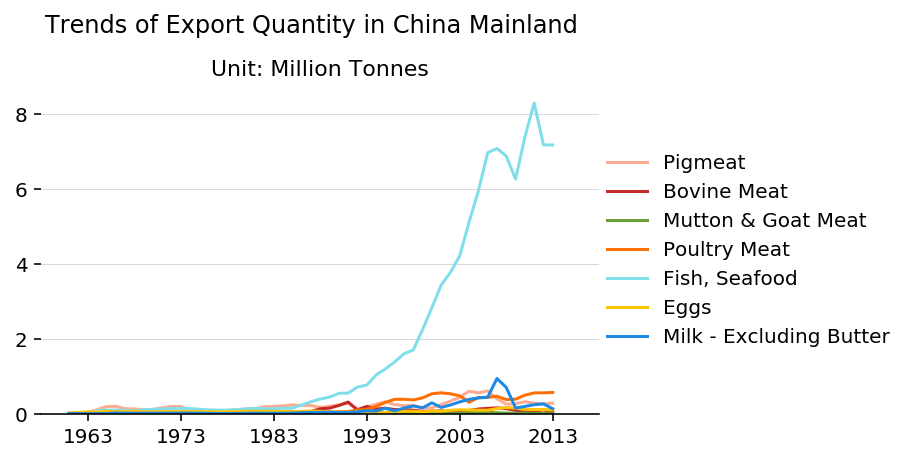

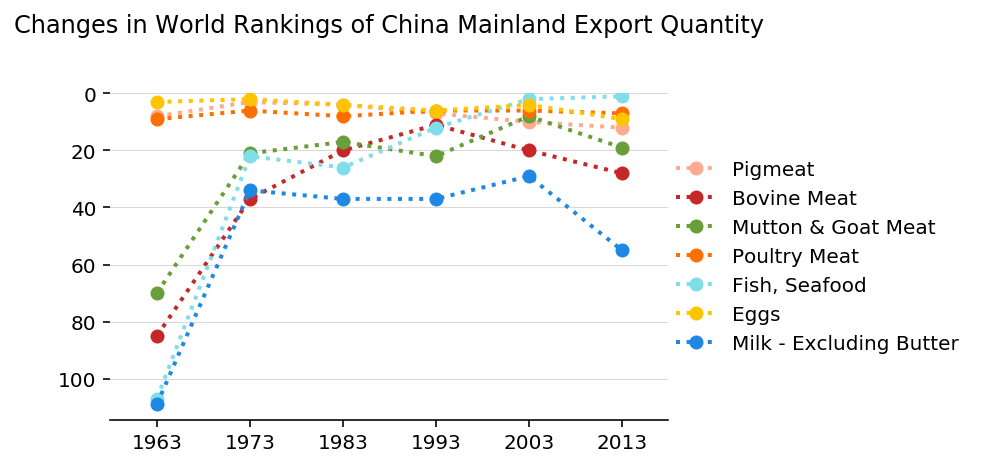

In [79]:
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)
ranking_AreaItemInWorld(A,E)

In [59]:
worldMap(
    element=E,
    items_group='',
    items=[],
    toUnit = 'Million Tonnes',
    changeUnit = 1/1000000,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='BuGn',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Export Quantity_03_01_Export Quantity _Pigmeat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Export Quantity_03_01_Export Quantity _Pigmeat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Export Quantity_03_01_Export Quantity _Pigmeat_2013.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Export Quantity_03_01_Export Quantity _Bovine Meat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Export Quantity_03_01_Export Quantity _Bovine Meat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalanc

1973    1993    2013
Argentina  0.0102  0.0004  0.0014
Australia  0.0224  0.0083  0.0432
Austria    0.0003  0.0165  0.2822
Belgium       NaN     NaN  0.8751
Brazil     0.0033  0.0485  0.7568

1973    1993    2013
Argentina  0.5060  0.3091  0.2331
Australia  0.7859  1.0852  1.5377
Austria    0.0073  0.0451  0.1252
Belgium       NaN     NaN  0.1603
Brazil     0.1865  0.4433  1.8681

1973        1993    2013
Argentina  2.4091e-02  2.4140e-03  0.0016
Australia  1.9024e-01  2.2119e-01  0.4497
Austria    2.3000e-05  1.0000e-06  0.0001
Belgium           NaN         NaN  0.0114
Brazil     5.4400e-04  1.7100e-04  0.0000

1973    1993    2013
Argentina  2.3600e-04  0.0023  0.3680
Australia  3.9630e-03  0.0083  0.0382
Austria    9.0000e-05  0.0013  0.0670
Belgium           NaN     NaN  0.4982
Brazil     3.0000e-05  0.5259  3.9024

1973    1993    2013
Argentina  0.1253  0.6698  0.6422
Australia  0.0517  0.1080  0.0552
Austria    0.0015  0.0022  0.0296
Belgium       NaN     NaN  0.2784
Brazil     0.0360  0.0659  0.0650

1973    1993    2013
Argentina  4.5000e-05  0.0004  0.0090
Australia  3.1270e-02  0.0002  0.0007
Austria    2.3000e-04  0.0001  0.0086
Belgium           NaN     NaN  0.1004
Brazil     4.3300e-04  0.0029  0.0198

1973    1993    2013
Argentina  0.1890  0.2402  2.7816
Australia  1.6771  2.8525  3.8159
Austria    0.4589  0.5396  1.8984
Belgium       NaN     NaN  4.3368
Brazil     0.0031  0.1389  0.1431

OECD


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
Year                                                                          
1961   0.9300       0.8068              0.4430        0.2825         5.0002   
1962   0.9491       1.0002              0.4344        0.3053         5.4564   
1963   1.0216       1.1081              0.4794        0.2833         5.8406   
1964   1.0977       1.0652              0.4886        0.3174         7.1223   
1965   1.2203       1.1153              0.4991        0.3340         7.3776   

        Eggs  Milk - Excluding Butter  
Year                                   
1961  0.4545                  14.6223  
1962  0.3952                  16.5221  
1963  0.3204                  19.2789  
1964  0.2823                  20.7792  
1965  0.2657                  20.0968

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0216          0.0                 0.0        0.0031         0.0000   
1962   0.0130          0.0                 0.0        0.0022         0.0000   
1963   0.0336          0.0                 0.0        0.0030         0.0000   
1964   0.1028          0.0                 0.0        0.0039         0.0858   
1965   0.1879          0.0                 0.0        0.0040         0.0920   

        Eggs  Milk - Excluding Butter  
1961  0.0166               9.1000e-05  
1962  0.0275               0.0000e+00  
1963  0.0515               0.0000e+00  
1964  0.0433               6.1000e-05  
1965  0.0596               3.7660e-03

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Export Quantity of Pigmeat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Export Quantity of Bovine Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Export Quantity of Mutton & Goat Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Export Quantity of Poultry Meat of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Export Quantity of Fish, Seafood of Chin

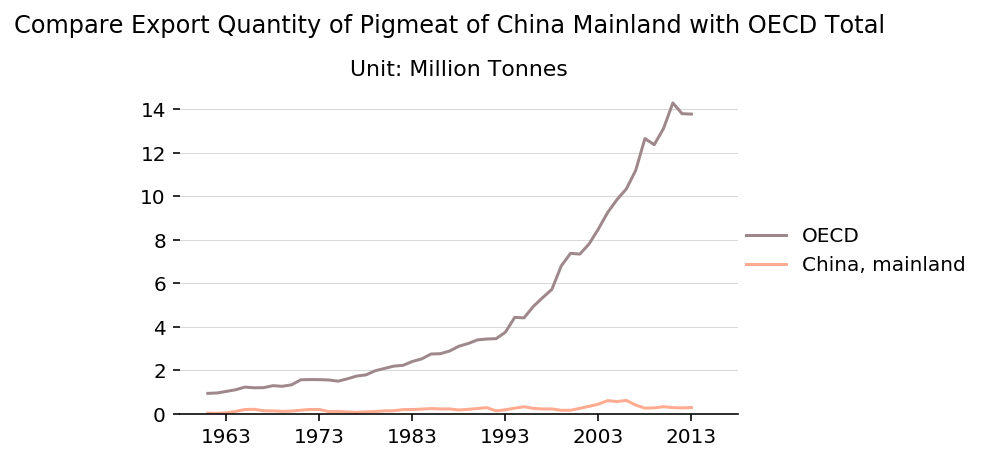

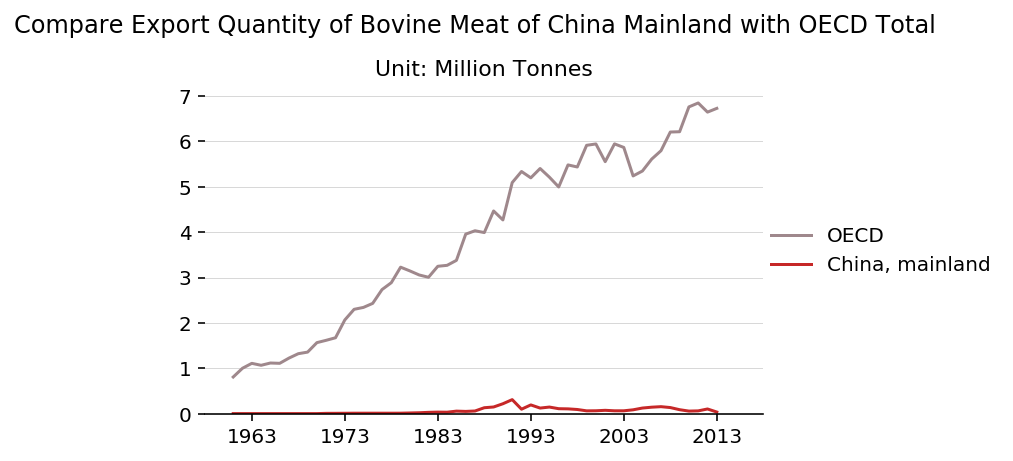

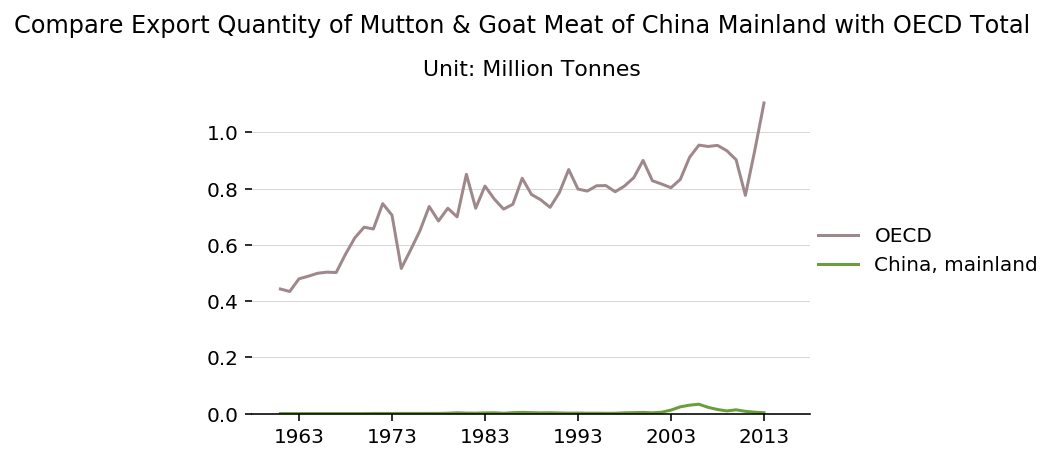

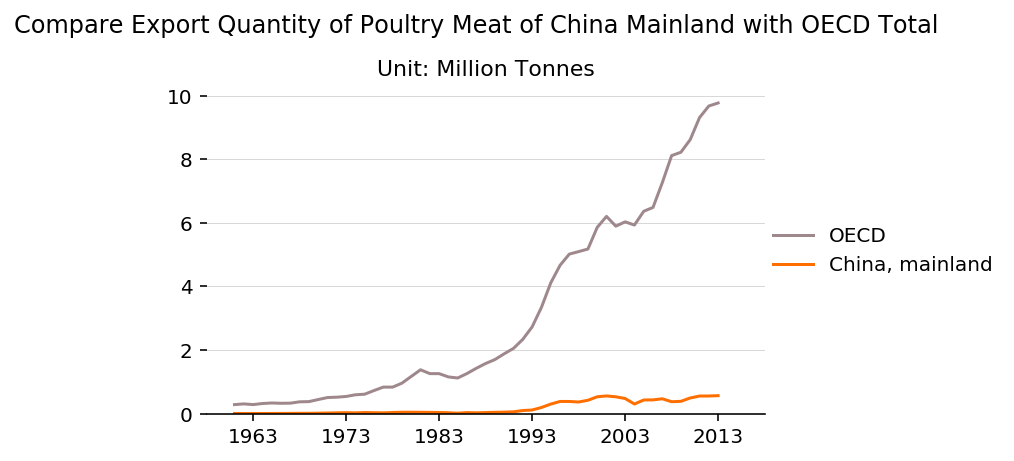

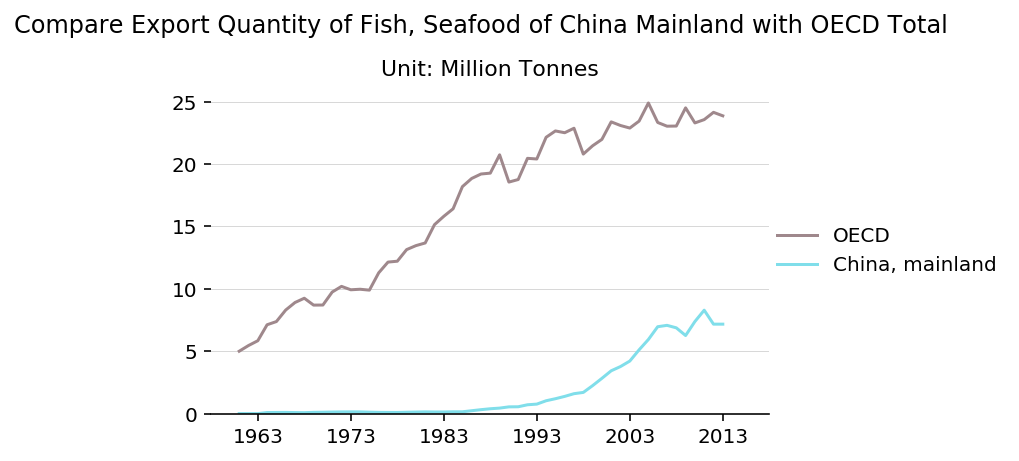

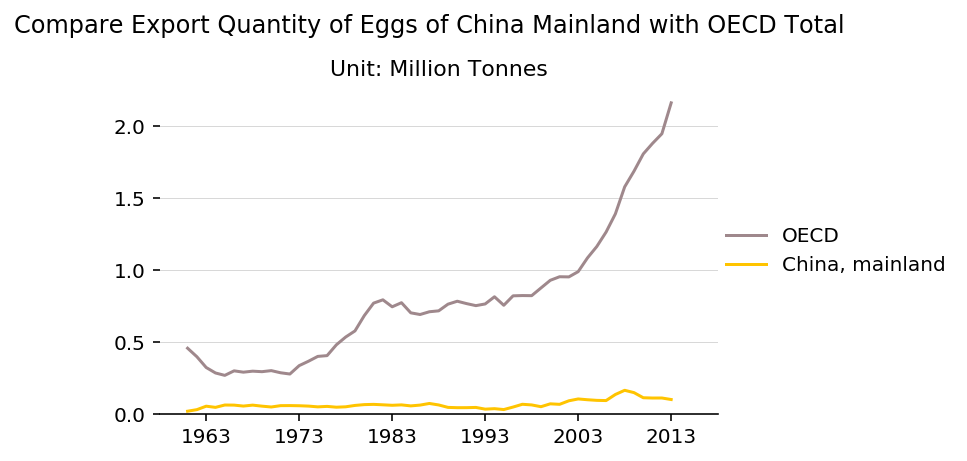

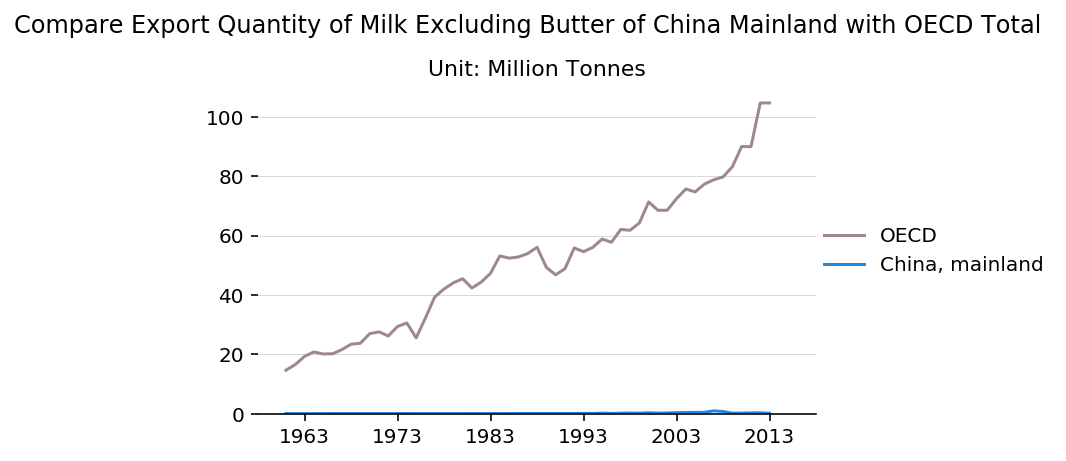

In [60]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

DATA_world = trendsOfArea('World', E, items=items)
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)

compareOtherAreasLine(
    area=A,
    element=E,
    df_area=DATA_area.copy(),
    dfs_compare={'OECD': DATA_OECD, }, 
    toUnit='Million Tonnes',
    changeUnit=1/1000000,
    colors = CLs,
    fig_size = FIG_size,
)

World


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   1.0922       1.6553              0.4867        0.3034        11.1278   
1962   1.0912       2.0790              0.4904        0.3258        13.8387   
1963   1.1868       2.4736              0.5343        0.3087        14.0139   
1964   1.3749       2.2107              0.5223        0.3479        17.7476   
1965   1.6574       2.1769              0.5586        0.3751        17.8201   

        Eggs  Milk - Excluding Butter  
1961  0.6163                  15.2033  
1962  0.5405                  17.1552  
1963  0.4752                  19.8012  
1964  0.4272                  21.4981  
1965  0.4370                  21.5504

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in World_Line.png
Northern America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0637       0.0361              0.0008        0.1134         0.7208   
1962   0.0630       0.0295              0.0014        0.1238         0.8094   
1963   0.0998       0.0304              0.0009        0.0961         0.8689   
1964   0.0921       0.0570              0.0010        0.1064         1.0049   
1965   0.0542       0.0695              0.0010        0.0920         1.0194   

        Eggs  Milk - Excluding Butter  
1961  0.0261                   4.7395  
1962  0.0165                   6.2776  
1963  0.0236                   7.2784  
1964  0.0142                   7.9336  
1965  0.0150                   5.7170

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in Northern America_Line.png
Western Europe


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.1893       0.1690              0.0073        0.0747         0.5931   
1962   0.1630       0.2434              0.0072        0.0874         0.6274   
1963   0.2042       0.2166              0.0071        0.0991         0.5420   
1964   0.2444       0.1847              0.0066        0.1124         0.6038   
1965   0.2863       0.1727              0.0121        0.1502         0.6328   

        Eggs  Milk - Excluding Butter  
1961  0.2218                   5.2252  
1962  0.2260                   5.1933  
1963  0.1875                   5.6094  
1964  0.1573                   5.7560  
1965  0.1150                   7.3768

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in Western Europe_Line.png
Australia & New Zealand


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0044       0.3325              0.4152        0.0002         0.0157   
1962   0.0048       0.4142              0.4013        0.0002         0.0227   
1963   0.0059       0.5268              0.4473        0.0002         0.0236   
1964   0.0070       0.5494              0.4573        0.0003         0.0230   
1965   0.0053       0.5936              0.4666        0.0004         0.0260   

        Eggs  Milk - Excluding Butter  
1961  0.0174                   2.0831  
1962  0.0185                   2.3279  
1963  0.0129                   3.7931  
1964  0.0087                   4.4316  
1965  0.0114                   5.0976

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in Australia & New Zealand_Line.png
South-Eastern Asia


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  \
1961  1.7800e-04   3.2400e-04          1.1000e-05        0.0001   
1962  1.0700e-04   6.5000e-05          2.3000e-05        0.0002   
1963  9.5000e-05   2.3700e-04          5.0000e-06        0.0003   
1964  4.4400e-04   4.2800e-04          8.0000e-06        0.0004   
1965  1.8530e-03   3.8000e-05          1.7000e-05        0.0003   

      Fish, Seafood    Eggs  Milk - Excluding Butter  
1961         0.0842  0.0180                   0.0041  
1962         0.0806  0.0066                   0.0053  
1963         0.0747  0.0056                   0.0056  
1964         0.0840  0.0082                   0.0089  
1965         0.1150  0.0071                   0.0027

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in South-Eastern Asia_Line.png
Japan


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  \
1961  1.0000e-05       0.0004                 0.0    4.9000e-05   
1962  5.7000e-05       0.0010                 0.0    1.1000e-05   
1963  2.4000e-05       0.0010                 0.0    1.1000e-05   
1964  4.9000e-05       0.0012                 0.0    2.0000e-06   
1965  7.1000e-05       0.0019                 0.0    3.0000e-06   

      Fish, Seafood    Eggs  Milk - Excluding Butter  
1961         0.4681  0.0073                   0.0129  
1962         0.6468  0.0055                   0.0203  
1963         0.5697  0.0016                   0.0219  
1964         0.6348  0.0007                   0.0272  
1965         0.6659  0.0004                   0.0245

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in Japan_Line.png
Republic of Korea


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  \
1961  0.0000e+00   0.0000e+00                 0.0    0.0000e+00   
1962  4.6000e-05   1.2000e-05                 0.0    0.0000e+00   
1963  1.7900e-04   2.0000e-06                 0.0    3.6000e-05   
1964  1.7000e-05   0.0000e+00                 0.0    5.3000e-05   
1965  1.2600e-04   2.0000e-05                 0.0    1.6500e-04   

      Fish, Seafood        Eggs  Milk - Excluding Butter  
1961         0.0342  0.0000e+00                      0.0  
1962         0.0415  0.0000e+00                      0.0  
1963         0.0426  0.0000e+00                      0.0  
1964         0.0749  2.9000e-05                      0.0  
1965         0.0690  0.0000e+00                      0.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in Republic Of Korea_Line.png
South America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961   0.0050       0.6062              0.0346    2.6100e-04         4.5966   
1962   0.0043       0.7134              0.0395    7.9000e-05         6.8883   
1963   0.0095       0.9193              0.0402    1.1900e-04         6.7175   
1964   0.0050       0.8130              0.0205    3.5800e-04         9.1323   
1965   0.0024       0.7063              0.0446    2.4100e-04         8.5154   

        Eggs  Milk - Excluding Butter  
1961  0.0127                   0.0993  
1962  0.0081                   0.0903  
1963  0.0068                   0.1108  
1964  0.0006                   0.1032  
1965  0.0056                   0.0796

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Export Quantity in South America_Line.png


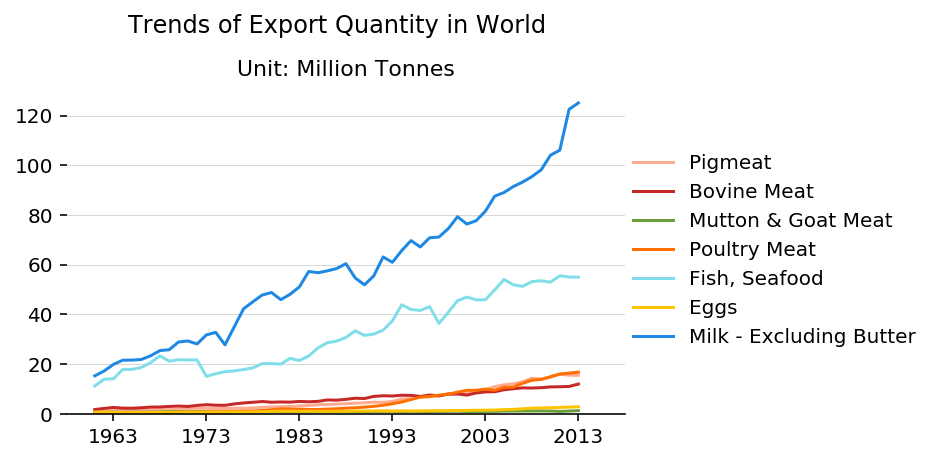

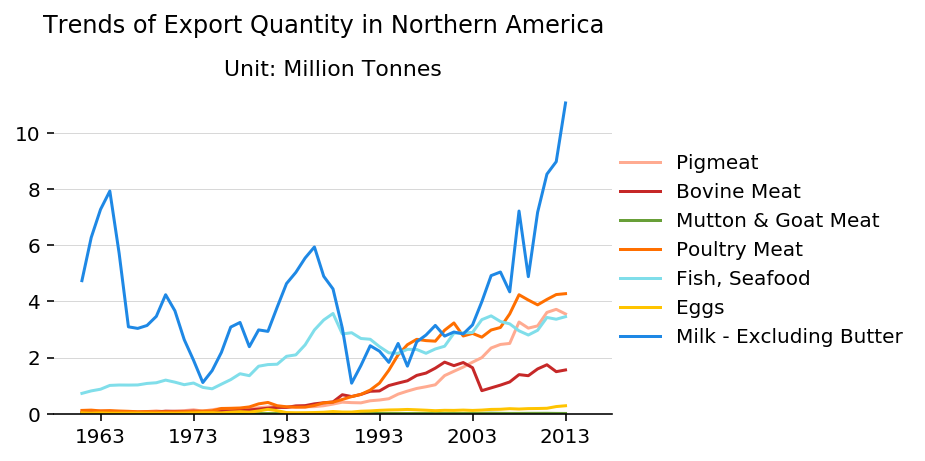

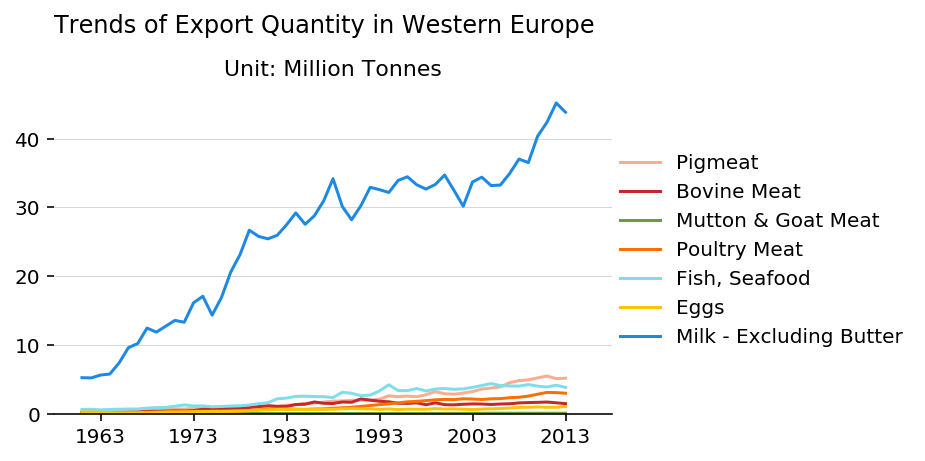

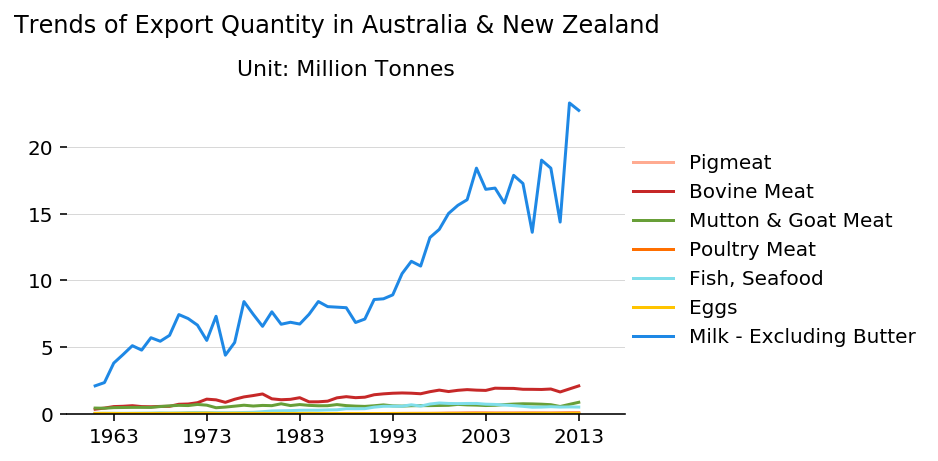

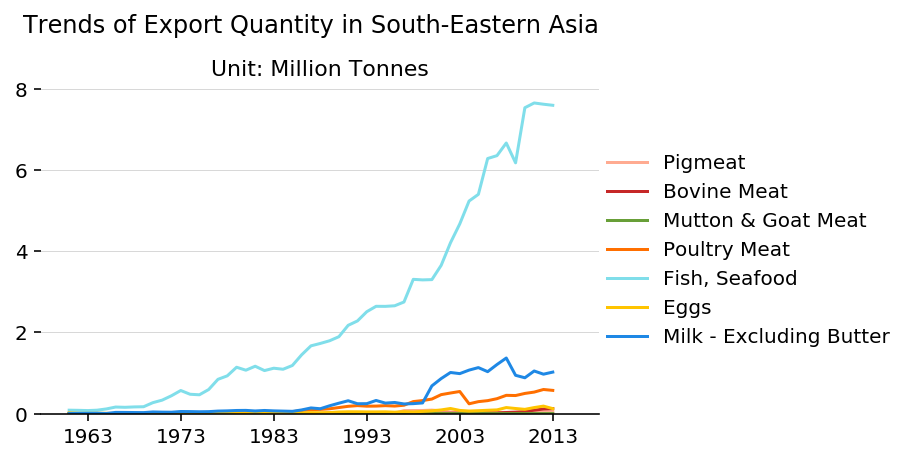

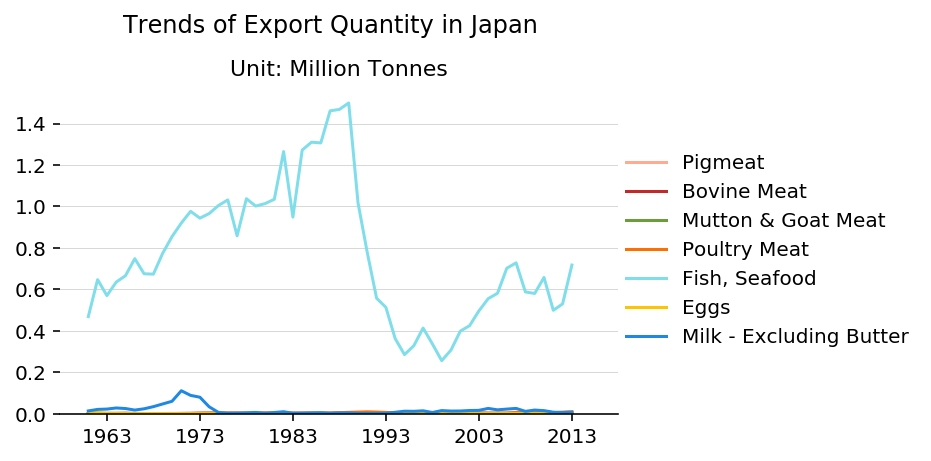

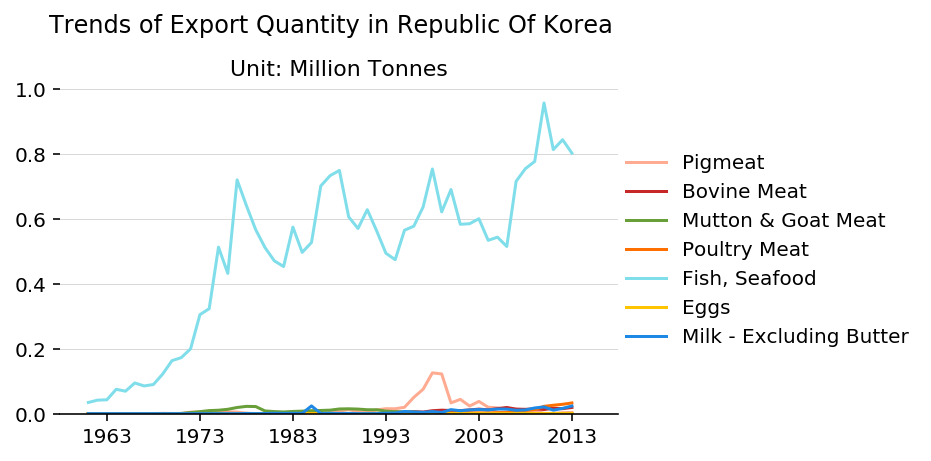

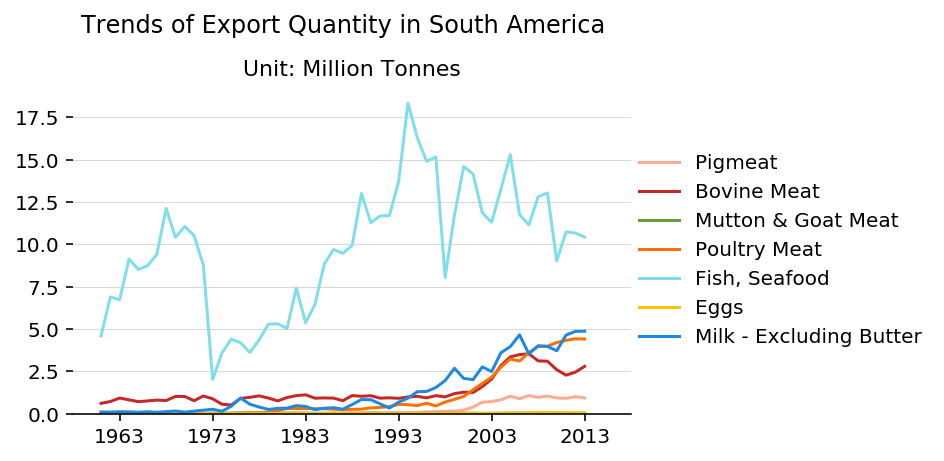

In [61]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea', 'South America'
]
for a in areas:
    print(a)
    plotTrendsLine(a, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

### Feed

In [62]:
# 给 Elements 赋值
E = 'Feed'

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


'Feed'

'Meat'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                      
Africa     1600.0   1600.0   1600.0   1440.0   1440.0   1280.0   1280.0   
Americas  29280.0  38350.0  33211.0  21394.0  20196.0  25808.0  26840.0   
Asia        352.0    352.0    407.0    462.0    506.0    550.0    550.0   
Austria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Canada     7729.0   3106.0   3475.0   3066.0   3453.0   3301.0   3305.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa     1280.0    960.0    960.0    960.0    800.0    800.0    800.0   
Americas  30432.0  29265.0  27520.0  26090.0  22151.0  28811.0  27352.0   
Asia        550.0    550.0    550.0    550.0    550.0    550.0    550.0   
Austria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Canada     3630.0   3243.0   3321.0   3678.0   3658.0   3387.0   3297.0   

             1975     1976     1977     1978     1979     1980     1981  \
Area                                                                      
Africa      800.0    800.0    800.0    800.0    800.0    800.0    800.0   
Americas  25319.0  28157.0  31980.0  33354.0  30505.0  23039.0  20509.0   
Asia        550.0    550.0    550.0    550.0    550.0    550.0    605.0   
Austria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Canada     2635.0   3013.0   2902.0   2951.0   2888.0   3578.0   3308.0   

             1982     1983     1984     1985     1986     1987     1988  \
Area                                                                      
Africa      800.0    800.0    800.0    800.0    800.0    800.0    800.0   
Americas  14040.0  13169.0  16579.0  25227.0  31164.0  38830.0  40381.0   
Asia        660.0    649.0    682.0    715.0    748.0    770.0    792.0   
Austria       0.0      0.0      0.0   1500.0   1500.0   1500.0   3500.0   
Canada     4191.0   4750.0   5074.0   5406.0   4732.0   4828.0   4809.0   

             1989     1990     1991     1992     1993     1994     1995  \
Area                                                                      
Africa      800.0    800.0    800.0    800.0    960.0   1120.0   1280.0   
Americas  38138.0  40956.0  41885.0  37643.0  25851.0  20498.0  22680.0   
Asia        825.0    858.0    352.0  11851.0  11900.0  11484.0  15550.0   
Austria    2500.0   2500.0   2500.0   2500.0   1500.0   3000.0      0.0   
Canada     3498.0   2969.0   8869.0   6274.0   5390.0   5168.0   4179.0   

             1996     1997     1998     1999     2000     2001     2002  \
Area                                                                      
Africa     1360.0   1120.0   1139.0   1120.0   1200.0   1200.0   1050.0   
Americas  23034.0  23675.0  22942.0  30937.0  34950.0  46348.0  44034.0   
Asia      14217.0   6028.0   5571.0   5537.0   4937.0   5735.0   6059.0   
Austria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Canada     3796.0   4146.0   4294.0   5918.0   6322.0  18081.0   7950.0   

             2003     2004     2005     2006     2007     2008     2009  \
Area                                                                      
Africa     1200.0   1200.0   1200.0   1200.0   1216.0   1229.0   1504.0   
Americas  48075.0  27739.0  27947.0  34032.0  41918.0  52702.0  54329.0   
Asia       6315.0   6322.0   6719.0   7348.0   7514.0   8191.0   8093.0   
Austria       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Canada     6691.0   7354.0   7537.0   8132.0   4329.0   7987.0   9168.0   

             2010     2011     2012     2013  
Area                                          
Africa     1869.0   1789.0   1761.0   1620.0  
Americas  59688.0  63327.0  65116.0  70415.0  
Asia       8515.0   8837.0   9037.0   9337.0  
Austria       0.0      0.0      0.0      0.0  
Canada    12205.0  12896.0  12690.0  15968.0

'Feed'

'Poultry Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  \
Area                                                                         
Austria          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Europe           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
European Union   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Western Europe   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
World            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  \
Area                                                                         
Austria          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Europe           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
European Union   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Western Europe   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
World            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                1981  1982  1983  1984    1985    1986    1987    1988  \
Area                                                                     
Austria          0.0   0.0   0.0   0.0  1500.0  1500.0  1500.0  3500.0   
Europe           0.0   0.0   0.0   0.0  1500.0  1500.0  1500.0  3500.0   
European Union   0.0   0.0   0.0   0.0  1500.0  1500.0  1500.0  3500.0   
Western Europe   0.0   0.0   0.0   0.0  1500.0  1500.0  1500.0  3500.0   
World            0.0   0.0   0.0   0.0  1500.0  1500.0  1500.0  3500.0   

                  1989    1990    1991    1992    1993    1994  1995  1996  \
Area                                                                         
Austria         2500.0  2500.0  2500.0  2500.0  1500.0  3000.0   0.0   0.0   
Europe          2500.0  2500.0  2500.0  2500.0  1500.0  3000.0   0.0   0.0   
European Union  2500.0  2500.0  2500.0  2500.0  1500.0  3000.0   0.0   0.0   
Western Europe  2500.0  2500.0  2500.0  2500.0  1500.0  3000.0   0.0   0.0   
World           2500.0  2500.0  2500.0  2500.0  1500.0  3000.0   0.0   0.0   

                1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  \
Area                                                                         
Austria          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Europe           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
European Union   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Western Europe   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
World            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                2007  2008  2009  2010  2011  2012  2013  
Area                                                      
Austria          0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Europe           0.0   0.0   0.0   0.0   0.0   0.0   0.0  
European Union   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Western Europe   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
World            0.0   0.0   0.0   0.0   0.0   0.0   0.0

'Feed'

'Bovine Meat'

1992     1993     1994     1995     1996     1997     1998  \
Area                                                                            
Asia            11400.0  11400.0  10900.0  15000.0  13700.0   5500.0   4900.0   
Central Asia    11400.0  11400.0  10900.0  14900.0  13600.0   5400.0   4800.0   
Eastern Europe  53000.0  50000.0  57000.0  40000.0  35000.0  18000.0  12000.0   
Europe          53000.0  50000.0  57000.0  40000.0  35000.0  18000.0  12000.0   
Georgia             0.0      0.0      0.0    100.0    100.0    100.0    100.0   

                   1999    2000    2001    2002     2003    2004    2005  \
Area                                                                       
Asia             4800.0  4200.0  4800.0  5300.0   5600.0  5600.0  6000.0   
Central Asia     4700.0  4100.0  4700.0  5200.0   5500.0  5500.0  5900.0   
Eastern Europe  10000.0  8000.0  7000.0  7000.0  10000.0     0.0     0.0   
Europe          10000.0  8000.0  7000.0  7000.0  10000.0     0.0     0.0   
Georgia           100.0   100.0   100.0   100.0    100.0   100.0   100.0   

                  2006    2007    2008    2009    2010    2011    2012    2013  
Area                                                                            
Asia            6600.0  6700.0  7300.0  7400.0  7800.0  8100.0  8300.0  8600.0  
Central Asia    6500.0  6600.0  7200.0  7300.0  7700.0  8000.0  8200.0  8500.0  
Eastern Europe     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
Europe             0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
Georgia          100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0

'Feed'

'Offals'

1961      1962      1963      1964      1965  \
Area                                                                        
Africa                      180.0     180.0     180.0     162.0     162.0   
Americas                 500409.0  506293.0  529997.0  572191.0  543513.0   
Asia                       7792.0    8730.0    8894.0    8860.0    9540.0   
Australia & New Zealand   37710.0   46308.0   47259.0   45199.0   40778.0   
Cameroon                      0.0       0.0       0.0       0.0       0.0   

                             1966      1967      1968      1969      1970  \
Area                                                                        
Africa                      144.0     144.0     144.0     108.0     108.0   
Americas                 546972.0  569735.0  599349.0  593382.0  621884.0   
Asia                      10596.0   12000.0   12421.0   12776.0   14975.0   
Australia & New Zealand   43102.0   45378.0   49549.0   57139.0   57236.0   
Cameroon                      0.0       0.0       0.0       0.0       0.0   

                             1971      1972      1973      1974      1975  \
Area                                                                        
Africa                      108.0      90.0      90.0      90.0      90.0   
Americas                 632344.0  616158.0  587186.0  638891.0  632473.0   
Asia                      15119.0   16002.0   19912.0   17964.0   15979.0   
Australia & New Zealand   57297.0   58659.0   66127.0   58778.0   79689.0   
Cameroon                      0.0       0.0       0.0       0.0       0.0   

                             1976      1977      1978      1979      1980  \
Area                                                                        
Africa                       90.0      90.0      90.0      90.0      90.0   
Americas                 682232.0  670734.0  646601.0  626119.0  649306.0   
Asia                      20699.0   24375.0   24100.0   27829.0   29557.0   
Australia & New Zealand   94699.0   77029.0   83164.0   75038.0   75115.0   
Cameroon                      0.0       0.0       0.0       0.0       0.0   

                             1981      1982      1983      1984      1985  \
Area                                                                        
Africa                       90.0      90.0      90.0      90.0      90.0   
Americas                 663952.0  646307.0  671789.0  649739.0  663108.0   
Asia                      30654.0   32647.0   35756.0   38468.0   41834.0   
Australia & New Zealand   73434.0   74783.0   77672.0   67230.0   75348.0   
Cameroon                      0.0       0.0       0.0       0.0       0.0   

                             1986      1987      1988      1989      1990  \
Area                                                                        
Africa                       90.0      90.0      90.0      90.0      97.0   
Americas                 644762.0  627314.0  661876.0  691353.0  674940.0   
Asia                      42759.0   44844.0   40707.0   41749.0   45297.0   
Australia & New Zealand   76176.0   85374.0   90319.0   81484.0   74720.0   
Cameroon                      0.0       0.0       0.0       0.0       7.0   

                             1991      1992      1993      1994      1995  \
Area                                                                        
Africa                       90.0      90.0     109.0     126.0     145.0   
Americas                 679336.0  702426.0  700045.0  730117.0  740135.0   
Asia                      49786.0   50083.0   51055.0   53512.0   55131.0   
Australia & New Zealand   78042.0   78878.0   89184.0   78016.0   99177.0   
Cameroon                      0.0       0.0       1.0       0.0       1.0   

                             1996      1997      1998      1999      2000  \
Area                                                                        
Africa                      153.0     126.0     127.0     127.0     135.0   
Americas          

'Feed'

'Mutton & Goat Meat'

1961  1962  1963   1964   1965   1966  1967  1968  \
Area                                                                          
Americas                   0.0   0.0  32.0  123.0  142.0  101.0  64.0  79.0   
Canada                     0.0   0.0   0.0    0.0    0.0    0.0   0.0   0.0   
Northern America           0.0   0.0  32.0  123.0  142.0  101.0  64.0  79.0   
United States of America   0.0   0.0  32.0  123.0  142.0  101.0  64.0  79.0   
World                      0.0   0.0  32.0  123.0  142.0  101.0  64.0  79.0   

                          1969  1970  1971  1972   1973  1974   1975   1976  \
Area                                                                          
Americas                  64.0  45.0  52.0  83.0  161.0  25.0  323.0  300.0   
Canada                     0.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0   
Northern America          64.0  45.0  52.0  83.0  161.0  25.0  323.0  300.0   
United States of America  64.0  45.0  52.0  83.0  161.0  25.0  323.0  300.0   
World                     64.0  45.0  52.0  83.0  161.0  25.0  323.0  300.0   

                           1977   1978   1979  1980   1981   1982   1983  \
Area                                                                       
Americas                  326.0  194.0  144.0  96.0  187.0  114.0  147.0   
Canada                      0.0    0.0    0.0   0.0    0.0    0.0    0.0   
Northern America          326.0  194.0  144.0  96.0  187.0  114.0  147.0   
United States of America  326.0  194.0  144.0  96.0  187.0  114.0  147.0   
World                     326.0  194.0  144.0  96.0  187.0  114.0  147.0   

                          1984  1985  1986   1987    1988   1989   1990  \
Area                                                                      
Americas                   0.0  71.0  24.0  142.0  1036.0  242.0  441.0   
Canada                     0.0   0.0   0.0    0.0   172.0  242.0  441.0   
Northern America           0.0  71.0  24.0  142.0  1036.0  242.0  441.0   
United States of America   0.0  71.0  24.0  142.0   864.0    0.0    0.0   
World                      0.0  71.0  24.0  142.0  1036.0  242.0  441.0   

                            1991    1992    1993    1994    1995    1996  \
Area                                                                       
Americas                  1766.0  2158.0  2660.0  3179.0  3572.0  3128.0   
Canada                     726.0   565.0   911.0  1152.0  1196.0   724.0   
Northern America          1766.0  2158.0  2660.0  3179.0  3572.0  3128.0   
United States of America  1040.0  1593.0  1749.0  2027.0  2376.0  2404.0   
World                     1766.0  2158.0  2660.0  3179.0  3572.0  3128.0   

                            1997    1998    1999    2000    2001    2002  \
Area                                                                       
Americas                  3931.0  5214.0  3744.0  6423.0  6310.0  8036.0   
Canada                    1035.0   771.0   673.0   885.0   756.0  1121.0   
Northern America          3931.0  5214.0  3744.0  6423.0  6310.0  8036.0   
United States of America  2896.0  4443.0  3071.0  5538.0  5554.0  6915.0   
World                     3931.0  5214.0  3744.0  6423.0  6310.0  8036.0   

                            2003     2004    2005     2006     2007     2008  \
Area                                                                           
Americas                  9365.0  10830.0  9973.0  12263.0  11406.0  11556.0   
Canada                     981.0   1374.0  1273.0   1662.0   1480.0   1170.0   
Northern America          9365.0  10830.0  9973.0  12263.0  11406.0  11556.0   
United States of America  8384.0   9456.0  8700.0  10601.0   9926.0  10386.0   
World                     9365.0  10830.0  9973.0  12263.0  11406.0  11556.0   

                             2009     2010     2011     2012     2013  
Area                                                                   
Americas                  12596.0  15757.0  17134.0  17402.0  17699.0  
Canada          

'Feed'

'Milk - Excluding Butter'

1961       1962       1963       1964       1965       1966  \
Area                                                                            
Afghanistan    28000.0    28000.0    32000.0    32000.0    36000.0    40000.0   
Africa       1879898.0  1848145.0  1707385.0  1471834.0  1436372.0  1415123.5   
Albania         3384.0     3458.0     3552.0     3676.0     3797.0     3907.0   
Americas     4860354.0  4851099.0  4771276.0  4602525.0  4571670.0  4749268.0   
Angola          1100.0     1150.0     1200.0     1251.0     1250.0     1250.0   

                  1967       1968       1969       1970       1971       1972  \
Area                                                                            
Afghanistan    44000.0    46640.0    46640.0    40000.0    38400.0    41200.0   
Africa       1445715.5  1659603.0  1723400.5  1892148.5  1524046.0  1753466.0   
Albania         4069.0     4061.0     4187.0     4436.0     4932.0     4944.0   
Americas     4686773.0  4510691.0  4746949.0  4655173.0  4669028.0  4813262.0   
Angola          1270.0     1301.0     1331.0     1340.0     1351.0     1400.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    44800.0    46400.0    46720.0    48000.0    41800.0    42600.0   
Africa       1688324.5  1251179.0  1093398.0  1113459.0  1120522.0  1091832.0   
Albania         5485.0     5552.0     5652.0     5792.0     6304.0     6790.0   
Americas     4979549.0  4474755.0  4676595.0  4620906.0  4534979.0  4883941.5   
Angola          1425.0     1450.0     1475.0     1375.0     1400.0     1450.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    43520.0    44480.0    44480.0    44480.0    48000.0    48000.0   
Africa       1113942.0  1224907.0  1274474.5  1199814.0  1216651.0  1136557.0   
Albania         7094.0     7348.0     7760.0     7836.0     8030.0     8044.0   
Americas     4707798.0  4669970.0  4601245.0  4329053.0  4337872.0  4774386.0   
Angola          1500.0     1550.0     1551.0     1570.0     1592.0     1612.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    40000.0    24000.0    28800.0    28800.0    28800.0    44800.0   
Africa       1067042.0  1257696.0  1225122.5  1205679.0  1105403.5  1087841.0   
Albania         7512.0     7643.0     8231.0     8847.0     9208.0    10357.0   
Americas     4655960.0  4233484.0  4394478.0  4433459.0  4348748.0  4603143.0   
Angola          1644.0     1645.0     1617.0     1568.0     1506.0     1562.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    48000.0    51200.0    61200.0    75600.0    88000.0   100800.0   
Africa       1241135.0  1262880.0  1420661.0  1138252.0  1321343.0  1340577.0   
Albania        10548.0    17107.0    29516.0    35488.0    66858.0    25089.0   
Americas     4202264.0  4475570.0  4463473.0  4280902.0  4316757.0  4252417.0   
Angola          1529.0     1584.0     1531.0     1467.0     1503.0     1650.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan   110400.0   114400.0   132000.0   105612.0    64023.0   128089.0   
Africa       1560219.0  1517256.0  1617652.0  1473662.0  1433442.0  1442746.0   
Albania        12848.0    60622.0    79064.0    83616.0    87054.0    90685.0   
Americas     4402910.0  4276256.0  4221180.0  4241723.0  4441176.0  4639452.0   
Angola          1772.0     1925.0     1922.0     1968.0     2159.0     2293.0   

                  2003       2004       20

'Feed'

'Animal fats'

1961      1962      1963      1964      1965      1966  \
Area                                                                    
Africa      14500.0   18100.0   17100.0   26800.0   21600.0   22800.0   
Americas   289275.0  460300.0  482227.0  497647.0  441669.0  540761.0   
Angola          0.0       0.0       0.0       0.0       0.0       0.0   
Argentina     400.0     300.0     600.0     800.0     400.0       0.0   
Asia        10451.0   10632.0   10598.0   11432.0   11216.0   14773.0   

               1967      1968      1969      1970      1971      1972  \
Area                                                                    
Africa      37800.0   59700.0   73200.0   39400.0   43100.0   28200.0   
Americas   597421.0  627418.0  658843.0  652651.0  687859.0  674131.0   
Angola          0.0       0.0       0.0       0.0       0.0       0.0   
Argentina     100.0    1500.0     200.0     300.0     300.0     800.0   
Asia        18104.0   16535.0   18554.0   20166.0   22095.0   21583.0   

               1973      1974      1975      1976      1977      1978  \
Area                                                                    
Africa      33800.0   42500.0   41427.0   33493.0   32205.0   36223.0   
Americas   330728.0  394527.0  783609.0  871442.0  807074.0  825818.0   
Angola          0.0     700.0    1000.0    1500.0       0.0    1800.0   
Argentina    1100.0    1100.0    2021.0    5616.0    2216.0     806.0   
Asia        25428.0   20048.0   19746.0   26326.0   26106.0   27436.0   

               1979      1980      1981      1982      1983      1984  \
Area                                                                    
Africa      39606.0   55119.0   23523.0   29280.0   20218.0   18833.0   
Americas   787621.0  776808.0  876967.0  901944.0  860082.0  899232.0   
Angola       1600.0    1900.0    1800.0    1800.0    1800.0    1000.0   
Argentina     827.0    1090.0    1020.0    1000.0     805.0     800.0   
Asia        31748.0   24582.0   33650.0   36774.0   40731.0   46793.0   

               1985       1986       1987       1988       1989       1990  \
Area                                                                         
Africa      24289.0    30613.0    26030.0    13693.0    31511.0    12332.0   
Americas   878019.0  1118760.0  1112107.0  1250806.0  1286207.0  1358577.0   
Angola       1000.0     1800.0     1400.0     1300.0     1400.0     1400.0   
Argentina    1046.0     3800.0     3807.0     3935.0     4019.0     3752.0   
Asia        67247.0    88419.0   112919.0    94338.0   134109.0   137324.0   

                1991       1992       1993       1994       1995       1996  \
Area                                                                          
Africa       12985.0    15887.0    20029.0    30713.0    50641.0    35765.0   
Americas   1239238.0  1325725.0  1413994.0  1474582.0  1538701.0  1574063.0   
Angola           0.0        0.0        0.0        0.0        0.0        0.0   
Argentina     3632.0     3765.0     4159.0     3997.0     3764.0     3770.0   
Asia        133189.0   152400.0   120821.0   129912.0   140677.0   129482.0   

                1997       1998       1999       2000       2001       2002  \
Area                                                                          
Africa       15810.0    20353.0    22588.0    14228.0    12053.0     9060.0   
Americas   1647221.0  1633872.0  1900062.0  1944778.0  1599930.0  1874130.0   
Angola          10.0     3199.0     1748.0     4205.0     1000.0      200.0   
Argentina     3625.0     4357.0     4387.0     4609.0     3508.0     3174.0   
Asia         79171.0    58574.0    63135.0    73470.0    76487.0    84729.0   

                2003       2004       2005       2006       2007       2008  \
Area                                                                          
Africa        7354.0     8505.0    10581.0     6723.0     5509.0     8563.0   
Americas   1700397.0  1877805.0  1548764.0  1556024.0  1565893.0  1574971.0

'Feed'

'Eggs'

1961    1962    1963    1964    1965    1966    1967  \
Area                                                                     
Asia               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia       NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Eastern Europe  2500.0  2400.0  2800.0  2800.0  3355.0  2000.0  3040.0   
Europe          3038.0  2943.0  3282.0  3207.0  3762.0  2271.0  3325.0   
European Union  3038.0  2943.0  3282.0  3207.0  3762.0  2271.0  3325.0   

                  1968    1969    1970    1971    1972    1973    1974  \
Area                                                                     
Asia               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia       NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Eastern Europe  2790.0  2990.0  4570.0  5970.0  5460.0  8040.0  3590.0   
Europe          3071.0  3266.0  4827.0  6204.0  5713.0  8311.0  3913.0   
European Union  3071.0  3266.0  4827.0  6204.0  5713.0  8311.0  3913.0   

                  1975    1976    1977    1978    1979    1980    1981  \
Area                                                                     
Asia               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia       NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Eastern Europe  5320.0  9454.0  8352.0  6727.0  6445.0  9625.0  6356.0   
Europe          5620.0  9791.0  8656.0  7008.0  6585.0  9770.0  6487.0   
European Union  5620.0  9791.0  8656.0  7008.0  6585.0  9770.0  6487.0   

                  1982    1983    1984    1985    1986    1987    1988  \
Area                                                                     
Asia               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia       NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Eastern Europe  5156.0  7503.0  5263.0  5493.0  5225.0  4200.0  3892.0   
Europe          5259.0  7601.0  5357.0  5581.0  5313.0  4283.0  3972.0   
European Union  5259.0  7601.0  5357.0  5581.0  5313.0  4283.0  3972.0   

                  1989    1990    1991     1992     1993     1994     1995  \
Area                                                                         
Asia               NaN     NaN     NaN  25000.0  22500.0  24000.0  14150.0   
Central Asia       NaN     NaN     NaN  25000.0  22500.0  24000.0  14150.0   
Eastern Europe  4474.0  3607.0  3116.0  38000.0  31790.0  22736.0  13900.0   
Europe          4563.0  3679.0  3209.0  38867.0  32679.0  25743.0  15826.0   
European Union  4563.0  3679.0  3209.0   3667.0   3379.0   6743.0   4826.0   

                   1996     1997     1998     1999     2000     2001     2002  \
Area                                                                            
Asia            15000.0  15120.0  16580.0  18260.0  22400.0  24300.0  29000.0   
Central Asia    15000.0  15120.0  16580.0  18260.0  22400.0  24300.0  29000.0   
Eastern Europe  11751.0   9564.0   9600.0  12500.0  12500.0  13420.0  15500.0   
Europe          13336.0  11161.0  11219.0  14231.0  14311.0  14215.0  16088.0   
European Union   5336.0   4161.0   4219.0   4231.0   4311.0   3295.0   3188.0   

                   2003     2004     2005     2006     2007     2008     2009  \
Area                                                                            
Asia            31400.0  32400.0  34600.0  35400.0  37300.0  38000.0  44600.0   
Central Asia    31400.0  32400.0  34600.0  35400.0  37300.0  38000.0  44600.0   
Eastern Europe  15500.0  16000.0  17500.0  17500.0  17500.0  17400.0  17300.0   
Europe          15870.0  16729.0  17656.0  17653.0  17665.0  17578.0  17453.0   
European Union   2870.0   3229.0   2656.0   2653.0   2665.0   2578.0   2453.0   

                   2010     2011     2012     2013  
Area                                                
Asia            50900.0  58072.0  50800.0  53300.0  
Central Asia    50900.0  58072.0  50800.0  53300.0  
Eastern Europe  19300.0  19200.0  19200.0  1920

'Feed'

'Fish, Seafood'

1961       1962       1963       1964       1965       1966  \
Area                                                                         
Africa     124150.0    74700.0   154039.0    78835.0   207297.0   320560.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0        0.0        0.0        0.0   
Americas  2262348.0  2509704.0  2693082.0  2798026.0  2521715.0  2830110.0   
Angola          0.0        0.0        0.0     5209.0        0.0        0.0   

               1967       1968       1969       1970       1971       1972  \
Area                                                                         
Africa     294827.0   610273.0   923494.0   488379.0   789683.0   693676.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria         0.0        0.0        0.0     3000.0     4500.0     8000.0   
Americas  3379672.0  4297066.0  2915899.0  3084178.0  3572370.0  3565490.0   
Angola       7650.0     7279.0     9094.0     9062.0    15471.0    15902.0   

               1973       1974       1975       1976       1977       1978  \
Area                                                                         
Africa     745058.0   674624.0   713227.0   781227.0   824864.0   915955.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria      7500.0    30500.0    13140.0    26615.0    53810.0    49035.0   
Americas  2255102.0  2185176.0  2906889.0  3255240.0  2405225.0  3121594.0   
Angola      15798.0    24848.0    17781.0    20000.0    17500.0    25000.0   

               1979       1980       1981       1982       1983       1984  \
Area                                                                         
Africa     722751.0   785137.0   986452.0  1198673.0  1374962.0  1273068.0   
Albania         0.0        0.0        0.0        0.0        0.0        0.0   
Algeria     50255.0    64170.0    74435.0    86000.0   117585.0   207100.0   
Americas  3943240.0  3030856.0  3126656.0  3803458.0  2887379.0  4012559.0   
Angola      20000.0    20000.0    26000.0    26000.0    19000.0    11500.0   

               1985       1986       1987       1988       1989       1990  \
Area                                                                         
Africa    1183871.0  1278788.0  1499000.0  1346953.0  1253452.0  1097106.0   
Albania         0.0     2000.0     2125.0     1200.0      800.0      700.0   
Algeria    117500.0    71400.0   145410.0   206970.0    56550.0    24500.0   
Americas  4435331.0  3849944.0  3950498.0  4148791.0  3800111.0  2972843.0   
Angola       8200.0     7300.0     4400.0     2700.0     2500.0     1140.0   

               1991       1992       1993       1994       1995       1996  \
Area                                                                         
Africa    1119377.0  1190287.0   851994.0  1518115.0  1590168.0  1007651.0   
Albania       785.0      350.0        0.0        0.0        5.0        0.0   
Algeria     16525.0     5295.0     1620.0     5210.0      650.0      105.0   
Americas  3686650.0  3099952.0  4084643.0  4906730.0  2949408.0  2970577.0   
Angola        630.0      190.0      470.0      290.0      170.0      100.0   

               1997       1998       1999       2000       2001       2002  \
Area                                                                         
Africa    1450889.0   699706.0   875648.0  1148461.0  1085166.0   761765.0   
Albania        10.0       55.0        0.0        0.0        0.0      145.0   
Algeria         0.0        0.0      680.0      870.0        0.0       15.0   
Americas  3016433.0  2452111.0  3565864.0  4337334.0  2685726.0  3162125.0   
Angola       7050.0    57675.0    20635.0    80230.0    34750.0    12478.0   

               2003       2004       2005       2006       2007       2008  \
Area                                                                         
Africa     630075.0   868108.0

'Feed'

'Meat'

Area  Africa  Americas    Asia  Austria   Canada  Caribbean  Central America  \
2012  1761.0   65116.0  9037.0      0.0  12690.0     1120.0            575.0   
2013  1620.0   70415.0  9337.0      0.0  15968.0     1120.0            575.0   

Area  Central Asia   Chile  China, mainland  Eastern Asia  Eastern Europe  \
2012        8200.0  4454.0            737.0         737.0             0.0   
2013        8500.0  3808.0            737.0         737.0             0.0   

Area  Europe  European Union  Georgia  Greece   Haiti  Honduras   Italy  \
2012  2156.0          2156.0    100.0   288.0  1120.0     575.0  1642.0   
2013  1123.0          1123.0    100.0   288.0  1120.0     575.0   609.0   

Area  Kazakhstan  Land Locked Developing Countries  Least Developed Countries  \
2012      8200.0                            8200.0                     1120.0   
2013      8500.0                            8500.0                     1120.0   

Area  Low Income Food Deficit Countries  \
2012                             1120.0   
2013                             1120.0   

Area  Net Food Importing Developing Countries  Northern America  \
2012                                   1695.0           58967.0   
2013                                   1695.0           64912.0   

Area  Small Island Developing States  South Africa  South America  \
2012                          1120.0        1761.0         4454.0   
2013                          1120.0        1620.0         3808.0   

Area  Southern Africa  Southern Europe  Spain  Ukraine  \
2012           1761.0           2156.0  226.0      0.0   
2013           1620.0           1123.0  226.0      0.0   

Area  United States of America  Western Asia  Western Europe    World  
2012                   46277.0         100.0             0.0  78070.0  
2013                   48944.0         100.0             0.0  82495.0

'Feed'

'Poultry Meat'

Area  Austria  Europe  European Union  Western Europe  World
2012      0.0     0.0             0.0             0.0    0.0
2013      0.0     0.0             0.0             0.0    0.0

'Feed'

'Bovine Meat'

Area    Asia  Central Asia  Eastern Europe  Europe  Georgia  Kazakhstan  \
2012  8300.0        8200.0             0.0     0.0    100.0      8200.0   
2013  8600.0        8500.0             0.0     0.0    100.0      8500.0   

Area  Land Locked Developing Countries  Ukraine  Western Asia   World  
2012                            8200.0      0.0         100.0  8300.0  
2013                            8500.0      0.0         100.0  8600.0

'Feed'

'Offals'

Area  Africa  Americas     Asia  Australia & New Zealand  Cameroon  Canada  \
2012   182.0  840503.0  56729.0                  80939.0       2.0  2670.0   
2013   182.0  843334.0  55565.0                  86878.0       2.0  2670.0   

Area  Caribbean  Central America  China, Taiwan Province of  Cuba  Denmark  \
2012      792.0            139.0                    51256.0  29.0  15518.0   
2013      792.0            146.0                    49596.0  29.0  18225.0   

Area  Eastern Asia  Eastern Europe   Europe  European Union  Germany  Greece  \
2012       51256.0           451.0  21437.0         21437.0   1000.0  2439.0   
2013       49596.0           279.0  23604.0         23604.0   1000.0  2327.0   

Area  Haiti  Honduras  Ireland   Italy  Least Developed Countries  \
2012  700.0     138.0    500.0  1178.0                      700.0   
2013  700.0     138.0    500.0   879.0                      700.0   

Area  Low Income Food Deficit Countries  Malaysia  Middle Africa  \
2012                              702.0    5389.0            2.0   
2013                              702.0    5885.0            2.0   

Area  Net Food Importing Developing Countries  Netherlands  New Zealand  \
2012                                    930.0         12.0      80939.0   
2013                                    930.0          2.0      86878.0   

Area  Northern America  Northern Europe  Oceania  Panama  Philippines  \
2012          794939.0          16357.0  80939.0     1.0         84.0   
2013          803016.0          19117.0  86878.0     8.0         84.0   

Area  Romania  Small Island Developing States  South Africa  South America  \
2012    451.0                           792.0         180.0        44633.0   
2013    279.0                           792.0         180.0        39380.0   

Area  South-Eastern Asia  Southern Africa  Southern Europe  Sweden  \
2012              5473.0            180.0           3617.0     0.0   
2013              5969.0            180.0           3206.0     0.0   

Area  United Kingdom  United States of America  Uruguay  Western Europe  \
2012           339.0                  792269.0  44633.0          1012.0   
2013           392.0                  800346.0  39380.0          1002.0   

Area      World  
2012   999790.0  
2013  1009563.0

'Feed'

'Mutton & Goat Meat'

Area  Americas  Canada  Northern America  United States of America    World
2012   17402.0  1907.0           17402.0                   15495.0  17402.0
2013   17699.0  1982.0           17699.0                   15717.0  17699.0

'Feed'

'Milk - Excluding Butter'

Area  Afghanistan     Africa   Albania   Americas  Angola  Argentina  Armenia  \
2012     121285.0  2413204.0   99393.0  5042617.0  2147.0   343426.0  25691.0   
2013     123181.0  2243154.0  100973.0  5080288.0  2204.0   272738.0  48423.0   

Area        Asia  Australia  Australia & New Zealand   Austria  Azerbaijan  \
2012  3.9192e+07   352424.0                1069251.0  339793.0    432238.0   
2013  4.0967e+07   448910.0                1128033.0  304842.0    512287.0   

Area  Bahamas  Bangladesh    Belarus   Belgium  \
2012    688.0    537860.0  1432614.0  496425.0   
2013    722.0    544560.0  1541775.0  884813.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                           20117.0                 48922.0   18458.0   
2013                           20174.0                 56961.0   15969.0   

Area     Brazil  Bulgaria  Burkina Faso    Canada  Caribbean  Central America  \
2012  1867780.0  221588.0        2047.0  547780.0     4787.0          27457.0   
2013  1898391.0  250951.0        3058.0  547773.0     4336.0          26820.0   

Area  Central Asia    Chad     Chile  China, Taiwan Province of  \
2012     6434968.0  7472.0  638828.0                    22490.0   
2013     6837771.0  7472.0  605457.0                    23476.0   

Area  China, mainland  Colombia  Croatia   Cyprus  Czechia  Czechoslovakia  \
2012        1604302.0  784327.0  12716.0  32766.0  53776.0             NaN   
2013        1608306.0  783286.0  12131.0  35207.0  75372.0             NaN   

Area   Denmark  Eastern Africa  Eastern Asia  Eastern Europe   Ecuador  \
2012  336350.0        494431.0     3263310.0      1.7253e+07   95972.0   
2013  826605.0        482504.0     3347158.0      1.8485e+07  124316.0   

Area     Egypt   Estonia  Ethiopia  Ethiopia PDR      Europe  European Union  \
2012  907803.0  144554.0   18001.0           NaN  2.9986e+07      1.4426e+07   
2013  891606.0  104224.0   18001.0           NaN  3.2508e+07      1.5762e+07   

Area     Fiji  Finland     France  Georgia    Germany    Greece   Hungary  \
2012  51173.0  59484.0  2183225.0  49277.0  2087750.0  116110.0  159774.0   
2013  46591.0  47931.0  2300035.0  50712.0  2063710.0  111410.0  132418.0   

Area  Iceland       India  Indonesia  Iran (Islamic Republic of)     Iraq  \
2012  35004.0  2.1681e+07    60000.0                   1982717.0  14224.0   
2013  43920.0  2.2757e+07    65000.0                   1915150.0  14566.0   

Area   Ireland   Israel     Italy     Japan  Jordan  Kazakhstan     Kenya  \
2012  450437.0  17000.0  585406.0  194350.0  2491.0    878989.0  442728.0   
2013  665915.0  16000.0  524322.0  210904.0  3018.0    721818.0  426986.0   

Area  Kyrgyzstan  Land Locked Developing Countries  \
2012    206937.0                         7595159.0   
2013    224052.0                         8145488.0   

Area  Lao People's Democratic Republic    Latvia  Least Developed Countries  \
2012                            3764.0  119853.0                   950031.0   
2013                            3727.0  129671.0                   969837.0   

Area  Lithuania  Low Income Food Deficit Countries  Luxembourg  Malaysia  \
2012   418412.0                         2.9215e+07     20896.0  113612.0   
2013   482501.0                         3.0948e+07     20691.0  110489.0   

Area  Melanesia   Mexico  Middle Africa  Mongolia  Montenegro   Morocco  \
2012    51545.0  10357.0         9619.0   71924.0     41522.0  629036.0   
2013    46936.0   9620.0         9676.0  111183.0     42609.0  575210.0   

Area  Namibia     Nepal  Net Food Importing Developing Countries  Netherlands  \
2012   7539.0  254175.0                                5000607.0     794903.0   
2013   6357.0  261150.0                                5029186.0     599488.0   

Area  New Caledonia  New Zealand  Nicaragua   Nigeria  Northern Africa  \
2012          355.0     716827.0    17100.0  107557.0        1553970.0   
2013          317.0     679123.0    17200.0  108313.

'Feed'

'Animal fats'

Area  Africa   Americas  Angola  Argentina      Asia  Australia  \
2012  8768.0  1528265.0  3741.0      362.0  153316.0     8209.0   
2013  9735.0  1458986.0  3741.0      139.0  143759.0     5654.0   

Area  Australia & New Zealand  Belgium  Bosnia and Herzegovina  Botswana  \
2012                   9612.0  37500.0                    10.0       0.0   
2013                   7262.0  37501.0                     9.0       0.0   

Area  Brazil  Bulgaria  Cameroon   Canada  Caribbean  \
2012  8115.0       0.0       0.0  51347.0      646.0   
2013  7438.0       0.0      22.0  35492.0      556.0   

Area  Central African Republic  Central America  Central Asia  Chad     Chile  \
2012                       0.0           8816.0          14.0   0.0  140612.0   
2013                       0.0           8051.0          14.0   0.0   89934.0   

Area  China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
2012                  17.0               9.0                    81391.0   
2013                  17.0               9.0                    79617.0   

Area  China, mainland  Congo  Costa Rica  Croatia  Cuba  Czechoslovakia  \
2012            121.0    0.0        17.0     22.0   0.0             NaN   
2013            121.0    0.0       128.0     24.0   0.0             NaN   

Area  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012                                   27.0  87375.0       0.0   
2013                                   27.0  45147.0       0.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 0.0            37.0      105334.0          4587.0   
2013                 0.0            44.0       90434.0          5441.0   

Area  Ecuador  Egypt  El Salvador  Estonia    Europe  European Union  Fiji  \
2012   4122.0  241.0       1647.0      9.0  405826.0        379292.0   0.0   
2013   4122.0  307.0       1021.0      9.0  336772.0        314520.0   0.0   

Area  Finland  France  Gabon  Germany   Greece  Guatemala  Haiti  Honduras  \
2012   2579.0  5729.0    0.0  19853.0  36150.0      820.0    0.0    3656.0   
2013   2579.0   664.0    0.0  16725.0  27918.0      820.0    0.0    3656.0   

Area  Hungary  Iceland  India  Indonesia  Iran (Islamic Republic of)  Iraq  \
2012    189.0  16080.0  132.0    16662.0                       131.0   0.0   
2013    246.0  13068.0  132.0    16662.0                       302.0   4.0   

Area  Ireland  Israel    Italy  Jamaica  Kazakhstan  Kenya  Kuwait  \
2012   4499.0   730.0  12744.0    639.0        14.0   17.0    50.0   
2013   4499.0   250.0  11498.0    549.0        14.0   17.0     0.0   

Area  Kyrgyzstan  Land Locked Developing Countries  Least Developed Countries  \
2012         0.0                              14.0                     3768.0   
2013         0.0                              14.0                     3765.0   

Area  Lebanon  Liberia  Lithuania  Low Income Food Deficit Countries  \
2012     53.0      0.0      305.0                             3015.0   
2013     53.0      0.0      305.0                             2784.0   

Area  Madagascar  Malaysia  Melanesia  Middle Africa  Morocco  Mozambique  \
2012         9.0    5088.0       88.0         3741.0   3506.0         1.0   
2013         9.0    3634.0       88.0         3763.0   4789.0         1.0   

Area  Net Food Importing Developing Countries  Netherlands  New Caledonia  \
2012                                  77622.0       1032.0           88.0   
2013                                  77316.0        828.0           88.0   

Area  New Zealand  Nicaragua  Niger  Nigeria  Northern Africa  \
2012       1403.0     2475.0    0.0    336.0           3751.0   
2013       1608.0     2225.0    0.0    336.0           5125.0   

Area  Northern America  Northern Europe  Norway  Oceania  Oman  Pakistan  \
2012         1301354.0         128208.0  8015.0   9700.0  50.0       1.0   
2013         1285492.0          77665.0  6226.0   7350.0  50.0       1.0   

Area  Panama    

'Feed'

'Eggs'

Area     Asia  Central Asia  Eastern Europe   Europe  European Union  Hungary  \
2012  50800.0       50800.0         19200.0  19635.0          2635.0   1200.0   
2013  53300.0       53300.0         19200.0  19708.0          2708.0   1200.0   

Area  Kazakhstan  Land Locked Developing Countries  Lithuania  \
2012     50800.0                           50800.0        0.0   
2013     53300.0                           53300.0        0.0   

Area  Northern Europe  Poland  Southern Europe  Spain  Ukraine    World  
2012              0.0  1000.0            435.0  435.0  17000.0  70435.0  
2013              0.0  1000.0            508.0  508.0  17000.0  73008.0

'Feed'

'Fish, Seafood'

Area     Africa  Albania  Algeria   Americas   Angola  Argentina  Armenia  \
2012  1234648.0    225.0    105.0  2757247.0  52145.0     7505.0   8255.0   
2013  1171217.0    370.0    105.0  2111306.0  52145.0     8000.0   8405.0   

Area        Asia  Australia  Australia & New Zealand  Austria  Bahamas  \
2012  1.5098e+07   237770.0                 279485.0  27560.0      0.0   
2013  1.5043e+07   172525.0                 219245.0  24685.0      0.0   

Area  Bangladesh  Belarus  Belgium  Belize   Benin  \
2012     54965.0  56025.0  11905.0     0.0  5775.0   
2013     54965.0  39430.0  10590.0     0.0  8005.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              10.0                  1730.0       5.0   
2013                              10.0                  1840.0      10.0   

Area   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  71545.0                0.0    9195.0        2645.0   10000.0   29600.0   
2013  71545.0                5.0    7810.0        2645.0   72000.0   32120.0   

Area    Canada  Caribbean  Central African Republic  Central America  \
2012  272497.0    14870.0                       0.0         329980.0   
2013  245582.0    14475.0                       0.0         327660.0   

Area  Central Asia  Chad      Chile  China, Hong Kong SAR  China, Macao SAR  \
2012       13805.0   0.0  1003774.0               62710.0               0.0   
2013       23990.0   0.0   502983.0               62710.0               0.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Congo  Costa Rica  \
2012                   938096.0        8634255.0   82935.0  110.0      3845.0   
2013                   938096.0        8634255.0   82935.0    0.0      1525.0   

Area  Croatia    Cuba   Cyprus  Czechia  Czechoslovakia  \
2012    381.0  3035.0  45194.0  15915.0             NaN   
2013    300.0  2625.0  45194.0  15000.0             NaN   

Area  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012                                 1355.0  85170.0       0.0   
2013                                 1355.0  91740.0       0.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012             11030.0         56735.0    1.1800e+07        636596.0   
2013             11030.0         53656.0    1.1549e+07        628191.0   

Area  Ecuador    Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  \
2012  70565.0  44390.0        400.0    950.0       0.0           NaN   
2013  70565.0  31385.0        400.0    950.0       0.0           NaN   

Area     Europe  European Union     Fiji  Finland    France  Gabon  Gambia  \
2012  3853305.0       1765673.0  12310.0  70430.0  115400.0    0.0   150.0   
2013  3652003.0       1702018.0  12310.0  70430.0  128555.0    0.0    20.0   

Area  Georgia  Germany    Ghana    Greece  Guatemala  Guinea  Guinea-Bissau  \
2012   4865.0   5550.0  45405.0  332250.0    16970.0   750.0            0.0   
2013   4865.0   4930.0  40580.0  329305.0    16970.0   750.0            0.0   

Area  Haiti  Honduras  Hungary  Iceland     India  Indonesia  \
2012    0.0   20055.0  14825.0   3363.0  272395.0   831994.0   
2013    0.0   20055.0  15050.0   2867.0  272395.0   831994.0   

Area  Iran (Islamic Republic of)   Iraq   Ireland   Israel     Italy  Jamaica  \
2012                     83220.0  545.0  111570.0  19165.0  189440.0    595.0   
2013                     91086.0  200.0  111570.0  19485.0  221720.0    595.0   

Area      Japan   Jordan  Kazakhstan   Kenya  Kuwait  Kyrgyzstan  \
2012  1898813.0  11110.0      2720.0  3552.0    25.0       900.0   
2013  1709305.0  11110.0      2720.0  3552.0    45.0       900.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                           86765.0                           13480.0   
2013                           96750.0                           13480.0   

Area  Latvia  Least Developed Countries  Lebanon  Le

Fish, Seafood  Milk - Excluding Butter
1961            0.0                   0.1921
1962            0.0                   0.1998
1963            0.0                   0.2075
1964            0.0                   0.2105
1965            0.0                   0.2163

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Feed in China Mainland_Line.png


Fish, Seafood  Milk - Excluding Butter
1963           91.0                     35.0
1973           95.0                     34.0
1983            9.0                     24.0
1993            2.0                     18.0
2003            1.0                     18.0
2013            1.0                     13.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_02_Changes in World Rankings of China Mainland Feed.png


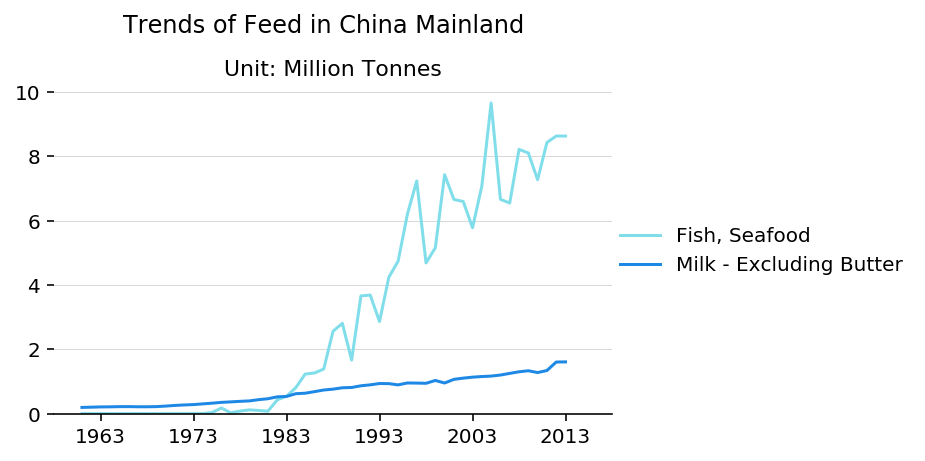

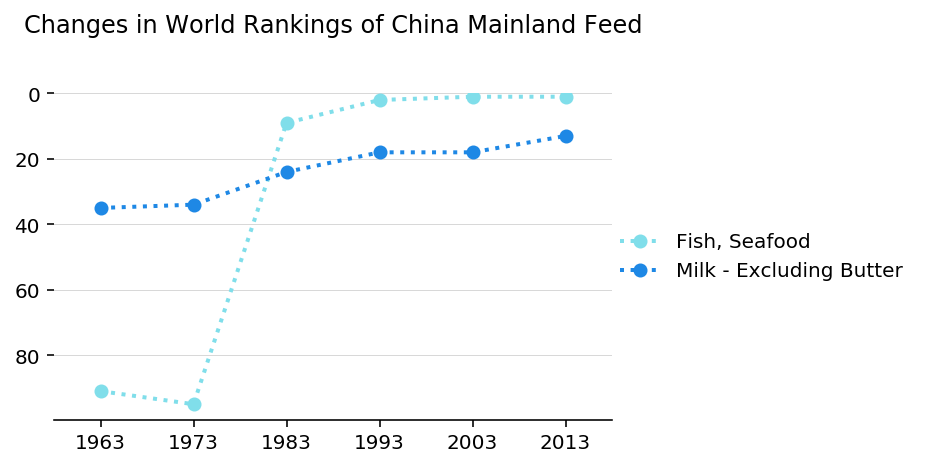

In [63]:
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000, colors=[Aqua_cyan, Milk_blue])
ranking_AreaItemInWorld(A,E,colors=[Aqua_cyan, Milk_blue])

In [64]:
worldMap(
    element=E,
    items_group='',
    items=['Fish, Seafood', 'Milk - Excluding Butter'],
    toUnit = 'Million Tonnes',
    changeUnit = 1/1000000,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='BuGn',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Feed_03_01_Feed _Fish, Seafood_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Feed_03_01_Feed _Fish, Seafood_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Feed_03_01_Feed _Fish, Seafood_2013.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Feed_03_01_Feed _Milk Excluding Butter_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Feed_03_01_Feed _Milk Excluding Butter_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Feed_03_01_Feed _Milk Excluding But

1973    1993    2013
Argentina  0.0100  0.0005  0.0080
Australia  0.0788  0.1135  0.1725
Austria    0.1200  0.1188  0.0247
Belgium       NaN     NaN  0.0106
Brazil     0.0039  0.0486  0.0715

1973    1993    2013
Argentina  0.3835  0.3729  0.2727
Australia  1.8189  0.2760  0.4489
Austria    1.0865  0.8217  0.3048
Belgium       NaN     NaN  0.8848
Brazil     1.4546  1.2471  1.8984

OECD


Fish, Seafood  Milk - Excluding Butter
Year                                        
1961         8.1431                  54.4402
1962         9.4172                  54.4892
1963         9.8503                  53.4182
1964        11.6037                  54.2130
1965        11.5847                  54.3012

China, mainland: 


Fish, Seafood  Milk - Excluding Butter
1961            0.0                   0.1921
1962            0.0                   0.1998
1963            0.0                   0.2075
1964            0.0                   0.2105
1965            0.0                   0.2163

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Feed of Fish, Seafood of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Feed of Milk Excluding Butter of China Mainland with OECD Total.png


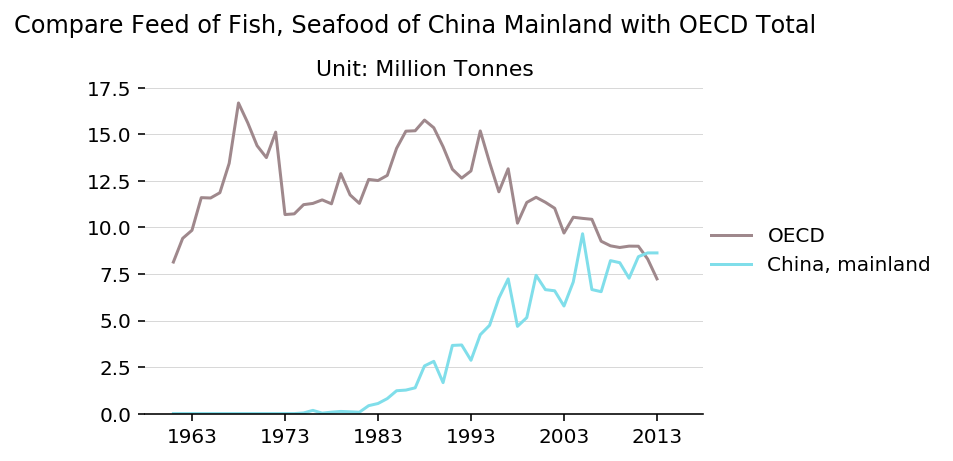

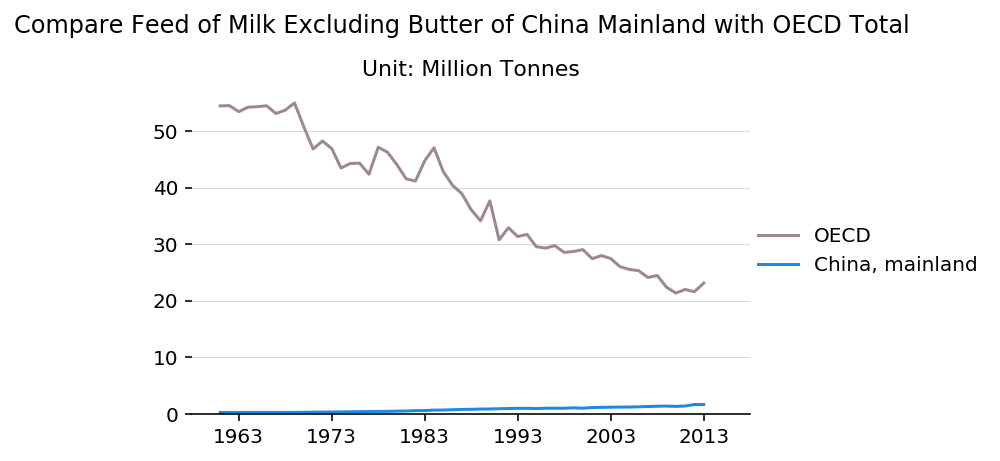

In [65]:
items = ['Fish, Seafood', 'Milk - Excluding Butter']
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

DATA_world = trendsOfArea('World', E, items=items)
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)

compareOtherAreasLine(
    area=A,
    element=E,
    df_area=DATA_area.copy(),
    dfs_compare={'OECD': DATA_OECD, }, 
    toUnit='Million Tonnes',
    changeUnit=1/1000000,
    colors=[Aqua_cyan, Milk_blue],
    fig_size = FIG_size,
)

### Losses

In [66]:
# 给 Elements 赋值
E = 'Losses'

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


'Losses'

'Meat'

1961     1962     1963     1964     1965     1966      1967  \
Area                                                                        
Americas   62644.0  64333.0  67288.0  69955.0  87444.0  69048.0  114044.0   
Argentina   4600.0   4800.0   7000.0   5200.0  24505.0   5400.0   42298.0   
Asia       16284.0  17911.0  20527.0  22477.0  25099.0  28557.0   31699.0   
Belarus        NaN      NaN      NaN      NaN      NaN      NaN       NaN   
Canada     41000.0  41500.0  41400.0  44700.0  42400.0  42800.0   50400.0   

               1968      1969     1970      1971      1972      1973  \
Area                                                                   
Americas   144143.0  106931.0  89842.0  135053.0  176066.0  123255.0   
Argentina   72656.0   35894.0   8200.0   46366.0   89316.0   37227.0   
Asia        34517.0   39600.0  45777.0   50519.0   54988.0   60386.0   
Belarus         NaN       NaN      NaN       NaN       NaN       NaN   
Canada      49600.0   47300.0  57400.0   62600.0   60600.0   58800.0   

               1974      1975      1976     1977      1978      1979  \
Area                                                                   
Americas   120588.0  104079.0  113727.0  98388.0  106436.0  116407.0   
Argentina   32644.0   22050.0   31652.0  13550.0   11978.0    8483.0   
Asia        60254.0   62895.0   67673.0  73471.0   80223.0   87633.0   
Belarus         NaN       NaN       NaN      NaN       NaN       NaN   
Canada      59000.0   50400.0   47694.0  50079.0   57751.0   70467.0   

               1980      1981      1982      1983      1984      1985  \
Area                                                                    
Americas   212905.0  279855.0  252294.0  332543.0  350277.0  307043.0   
Argentina   18732.0   70241.0   34919.0  109856.0  138776.0   86618.0   
Asia        87988.0   91578.0   94850.0   97904.0  100065.0  103772.0   
Belarus         NaN       NaN       NaN       NaN       NaN       NaN   
Canada      81902.0   81214.0   80473.0   82369.0   83502.0   87073.0   

               1986      1987      1988      1989      1990      1991  \
Area                                                                    
Americas   750523.0  266033.0  272272.0  275010.0  671683.0  574683.0   
Argentina  513075.0   10240.0    9772.0   35315.0  424175.0  323782.0   
Asia       109716.0  116414.0  121378.0  121423.0  121681.0  128499.0   
Belarus         NaN       NaN       NaN       NaN       NaN       NaN   
Canada      87513.0   89744.0   94530.0   94172.0   89908.0   87700.0   

               1992      1993      1994      1995      1996      1997  \
Area                                                                    
Americas   576261.0  578430.0  536816.0  478779.0  673910.0  573286.0   
Argentina  307445.0  314734.0  269067.0  196706.0  383836.0  252647.0   
Asia       188213.0  177033.0  174425.0  177874.0  173515.0  163922.0   
Belarus     17205.0   16624.0    3700.0    5889.0    3197.0    3395.0   
Canada      96600.0   95550.0   98350.0  102060.0   98220.0  100540.0   

               1998      1999      2000      2001      2002      2003  \
Area                                                                    
Americas   485972.0  542592.0  589205.0  573096.0  576914.0  603596.0   
Argentina  153423.0  180638.0  194227.0  177132.0  158729.0  180966.0   
Asia       169133.0  165114.0  166322.0  170734.0  192995.0  191623.0   
Belarus      5098.0    4942.0    3810.0    3146.0    4357.0    3821.0   
Canada     111180.0  124970.0  131200.0  138500.0  148670.0  150600.0   

               2004      2005      2006       2007       2008       2009  \
Area                                                                       
Americas   687512.0  702118.0  819601.0  1039505.0  1067110.0  1092066.0   
Argentina  253387.0  243153.0  341495.0   542207.0   552195.0   566279.0   
Asia       177840.0  189968.0  197766.0   206747.0   218607.0   220861.0   
Belarus      3198.0    3516.0    281

'Losses'

'Pigmeat'

1961     1962     1963     1964     1965     1966  \
Area                                                                    
Americas         41492.0  42061.0  41982.0  45298.0  42953.0  43347.0   
Asia              5879.0   6866.0   7008.0   7106.0  10173.0  12547.0   
Belarus              NaN      NaN      NaN      NaN      NaN      NaN   
Canada           41000.0  41500.0  41400.0  44700.0  42400.0  42800.0   
Central America      0.0      0.0      0.0      0.0      0.0      0.0   

                    1967     1968     1969     1970     1971     1972  \
Area                                                                    
Americas         50978.0  50245.0  48010.0  58128.0  63295.0  61364.0   
Asia             13876.0  13772.0  15275.0  18466.0  20488.0  22422.0   
Belarus              NaN      NaN      NaN      NaN      NaN      NaN   
Canada           50400.0  49600.0  47300.0  57400.0  62600.0  60600.0   
Central America      0.0      0.0      0.0      0.0      0.0      0.0   

                    1973     1974     1975     1976     1977     1978  \
Area                                                                    
Americas         59933.0  60039.0  51612.0  48981.0  51337.0  59080.0   
Asia             25540.0  25391.0  26429.0  27735.0  29790.0  31973.0   
Belarus              NaN      NaN      NaN      NaN      NaN      NaN   
Canada           58800.0  59000.0  50400.0  47694.0  50079.0  57751.0   
Central America      0.0      0.0      0.0      0.0      0.0      0.0   

                    1979     1980     1981     1982     1983     1984  \
Area                                                                    
Americas         71740.0  94791.0  95063.0  94292.0  96319.0  97106.0   
Asia             36127.0  36166.0  36285.0  36422.0  37508.0  37637.0   
Belarus              NaN      NaN      NaN      NaN      NaN      NaN   
Canada           70467.0  81902.0  81214.0  80473.0  82369.0  83502.0   
Central America      0.0    310.0    340.0    334.0    314.0    341.0   

                     1985      1986      1987      1988      1989      1990  \
Area                                                                          
Americas         101166.0  103221.0  105898.0  112618.0  112123.0  105319.0   
Asia              39672.0   41704.0   43847.0   44977.0   44775.0   44221.0   
Belarus               NaN       NaN       NaN       NaN       NaN       NaN   
Canada            87073.0   87513.0   89744.0   94530.0   94172.0   89908.0   
Central America     400.0     452.0     354.0     285.0     286.0     340.0   

                     1991      1992      1993      1994      1995      1996  \
Area                                                                          
Americas         103436.0  113316.0  113064.0  115769.0  119749.0  116838.0   
Asia              45327.0   63895.0   50050.0   48661.0   49316.0   50525.0   
Belarus               NaN    9105.0   10974.0       0.0    3275.0    1744.0   
Canada            87700.0   96600.0   95550.0   98350.0  102060.0   98220.0   
Central America     362.0     430.0     460.0     480.0     554.0     554.0   

                     1997      1998      1999      2000      2001      2002  \
Area                                                                          
Americas         121184.0  128413.0  146031.0  153015.0  160833.0  170742.0   
Asia              49766.0   50487.0   52362.0   52016.0   53001.0   57254.0   
Belarus            1563.0    2954.0    2785.0    2482.0    1207.0    1966.0   
Canada           100540.0  111180.0  124970.0  131200.0  138500.0  148670.0   
Central America     553.0     567.0     621.0     637.0     527.0     537.0   

                     2003      2004      2005      2006      2007      2008  \
Area                                                                          
Americas         172765.0  178881.0  177812.0  177354.0  177314.0  181691.0   
Asia              58972.0   58818.0   62410.0   63541.0   64141.0   66952

'Losses'

'Poultry Meat'

1961    1962    1963    1964    1965    1966     1967  \
Area                                                                       
Americas          787.0   820.0   871.0   963.0  1212.0  1250.0   1365.0   
Asia             4798.0  5381.0  6152.0  6428.0  7309.0  8469.0  10163.0   
Central America   348.0   364.0   385.0   406.0   427.0   452.0    478.0   
Central Asia        NaN     NaN     NaN     NaN     NaN     NaN      NaN   
Cyprus            124.0   129.0   138.0   153.0   216.0   229.0    280.0   

                    1968     1969     1970     1971     1972     1973  \
Area                                                                    
Americas          1435.0   1562.0   1723.0   1902.0   2290.0   2539.0   
Asia             11422.0  13407.0  15553.0  16822.0  18613.0  20879.0   
Central America    504.0    537.0    569.0    630.0    758.0    843.0   
Central Asia         NaN      NaN      NaN      NaN      NaN      NaN   
Cyprus             343.0    457.0    467.0    501.0    523.0    508.0   

                    1974     1975     1976     1977     1978     1979  \
Area                                                                    
Americas          3038.0   3614.0   3899.0   3957.0   3400.0   3561.0   
Asia             21025.0  21837.0  23683.0  26021.0  29321.0  31422.0   
Central America    926.0   1016.0   1099.0   1097.0   1028.0   1193.0   
Central Asia         NaN      NaN      NaN      NaN      NaN      NaN   
Cyprus             417.0    356.0    381.0    391.0    427.0    499.0   

                    1980     1981     1982     1983     1984     1985  \
Area                                                                    
Americas         35645.0  46683.0  52323.0  53355.0  47044.0  51823.0   
Asia             31850.0  33367.0  35208.0  37266.0  38315.0  40171.0   
Central America   2645.0   2883.0   3123.0   3355.0   3544.0   3823.0   
Central Asia         NaN      NaN      NaN      NaN      NaN      NaN   
Cyprus             500.0    508.0    564.0    614.0    630.0    628.0   

                    1986     1987     1988     1989     1990     1991  \
Area                                                                    
Americas         59037.0  71293.0  75494.0  54596.0  62415.0  74254.0   
Asia             43044.0  45352.0  48034.0  47730.0  48215.0  52635.0   
Central America   4037.0   4293.0   4494.0   4596.0   4915.0   5254.0   
Central Asia         NaN      NaN      NaN      NaN      NaN      NaN   
Cyprus             710.0    675.0    808.0    985.0   1040.0    980.0   

                    1992     1993     1994     1995      1996      1997  \
Area                                                                      
Americas         83959.0  79498.0  83576.0  93299.0  101669.0  118938.0   
Asia             57608.0  56882.0  56079.0  58489.0   59249.0   58862.0   
Central America   6959.0   6998.0   7576.0   8299.0    8669.0   12438.0   
Central Asia       210.0    198.0    549.0    168.0      79.0      52.0   
Cyprus            1186.0   1261.0   1330.0   1400.0    1491.0    1592.0   

                     1998      1999      2000      2001      2002      2003  \
Area                                                                          
Americas         123439.0  129962.0  143227.0  137062.0  148567.0  153798.0   
Asia              61806.0   63322.0   64614.0   67195.0   69954.0   72926.0   
Central America   13439.0   11962.0   13227.0   13062.0   15567.0   15798.0   
Central Asia        147.0     198.0     321.0     244.0     501.0     474.0   
Cyprus             1552.0    1659.0    1617.0    1691.0    1742.0    1655.0   

                     2004      2005      2006      2007      2008      2009  \
Area                                                                          
Americas         156346.0  176215.0  185979.0  203824.0  217873.0  228509.0   
Asia              65244.0   73020.0   77514.0   80430.0   85410.0   88088.0   
Central America   17346.0   18215.0   1597

'Losses'

'Bovine Meat'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                       
Americas   15765.0  16652.0  17435.0  18494.0  37979.0  19051.0  56201.0   
Argentina      0.0      0.0      0.0      0.0  19205.0      0.0  36798.0   
Asia        4196.0   4221.0   5288.0   6402.0   5454.0   4437.0   4468.0   
Belarus        NaN      NaN      NaN      NaN      NaN      NaN      NaN   
Caribbean    128.0    124.0    133.0    144.0    133.0    143.0    137.0   

              1968     1969     1970     1971      1972     1973     1974  \
Area                                                                        
Americas   86863.0  49559.0  21791.0  63406.0  101412.0  53883.0  49761.0   
Argentina  67056.0  28094.0      0.0  39916.0   78316.0  30327.0  24894.0   
Asia        5562.0   6582.0   7636.0   8646.0    8801.0   8847.0   9850.0   
Belarus        NaN      NaN      NaN      NaN       NaN      NaN      NaN   
Caribbean    136.0    146.0    146.0    134.0     140.0    160.0    167.0   

              1975     1976     1977     1978     1979     1980      1981  \
Area                                                                        
Americas   41453.0  53247.0  35294.0  36356.0  33106.0  64039.0  119942.0   
Argentina  14650.0  24052.0   5750.0   4378.0    483.0  10532.0   61841.0   
Asia        9781.0  10836.0  11902.0  12953.0  14001.0  14685.0   16132.0   
Belarus        NaN      NaN      NaN      NaN      NaN      NaN       NaN   
Caribbean    175.0    177.0    171.0    196.0    141.0    136.0     133.0   

              1982      1983      1984      1985      1986     1987     1988  \
Area                                                                           
Americas   86773.0  163255.0  188060.0  135008.0  564334.0  64082.0  63136.0   
Argentina  25919.0  101056.0  129776.0   77618.0  503875.0   1640.0   1372.0   
Asia       17282.0   17487.0   18483.0   18306.0   19407.0  21494.0  22332.0   
Belarus        NaN       NaN       NaN       NaN       NaN      NaN      NaN   
Caribbean    138.0     152.0     154.0     138.0     148.0    143.0    140.0   

              1989      1990      1991      1992      1993      1994  \
Area                                                                   
Americas   90752.0  483486.0  378984.0  360874.0  368153.0  319815.0   
Argentina  27315.0  414990.0  315382.0  298845.0  305934.0  260067.0   
Asia       23413.0   23724.0   24686.0   57951.0   60669.0   61262.0   
Belarus        NaN       NaN       NaN    7400.0    4900.0    3000.0   
Caribbean    140.0     152.0     162.0     182.0     157.0     158.0   

               1995      1996      1997      1998      1999      2000  \
Area                                                                    
Americas   247937.0  437400.0  314527.0  216101.0  240885.0  266647.0   
Argentina  187506.0  374436.0  243268.0  144779.0  171038.0  184635.0   
Asia        59985.0   54143.0   45379.0   45808.0   38615.0   39090.0   
Belarus      2214.0     953.0    1132.0    1944.0    1957.0     928.0   
Caribbean     167.0     158.0     146.0     144.0     147.0     145.0   

               2001      2002      2003      2004      2005      2006  \
Area                                                                    
Americas   249526.0  232198.0  250105.0  323319.0  318740.0  427120.0   
Argentina  168434.0  150032.0  171266.0  242351.0  231728.0  330424.0   
Asia        39838.0   53947.0   47650.0   42062.0   42203.0   42968.0   
Belarus      1680.0    2289.0    2454.0    2663.0    1503.0    1423.0   
Caribbean     132.0     147.0     140.0     109.0     104.0      66.0   

               2007      2008      2009      2010      2011      2012  \
Area                                                                    
Americas   630483.0  640569.0  654354.0  219832.0  108252.0  212937.0   
Argentina  532407.0  542668.0  556010.0  123885.0    6921.0  110927.0   
Asia        46216.0

'Losses'

'Offals'

1961    1962    1963    1964    1965    1966  \
Area                                                                      
Americas                 6991.0  7183.0  7410.0  9165.0  8618.0  7632.0   
Armenia                     NaN     NaN     NaN     NaN     NaN     NaN   
Asia                     2335.0  2436.0  2471.0  2551.0  2581.0  2679.0   
Australia                5140.0  5873.0  6451.0  6750.0  6822.0  6576.0   
Australia & New Zealand  5140.0  5873.0  6451.0  6750.0  6822.0  6576.0   

                           1967    1968    1969     1970    1971    1972  \
Area                                                                       
Americas                 7373.0  9031.0  8661.0  10589.0  9121.0  8078.0   
Armenia                     NaN     NaN     NaN      NaN     NaN     NaN   
Asia                     2785.0  2888.0  2916.0   3055.0  3380.0  3571.0   
Australia                6166.0  6584.0  6623.0   7386.0  7807.0  8778.0   
Australia & New Zealand  6166.0  6584.0  6623.0   7386.0  7807.0  8778.0   

                           1973    1974    1975     1976     1977     1978  \
Area                                                                         
Americas                 7783.0  8855.0  9481.0  10491.0   8690.0   8540.0   
Armenia                     NaN     NaN     NaN      NaN      NaN      NaN   
Asia                     3856.0  4968.0  4878.0   5146.0   4809.0   4860.0   
Australia                9195.0  7336.0  8734.0  10106.0  10637.0  11520.0   
Australia & New Zealand  9195.0  7336.0  8734.0  10106.0  10637.0  11520.0   

                            1979    1980     1981     1982     1983    1984  \
Area                                                                          
Americas                  7145.0  8865.0  10731.0  11646.0  11463.0  8734.0   
Armenia                      NaN     NaN      NaN      NaN      NaN     NaN   
Asia                      5394.0  5355.0   5479.0   5836.0   6582.0  7349.0   
Australia                10519.0  8949.0   8467.0   8633.0   8810.0  7617.0   
Australia & New Zealand  10519.0  8949.0   8467.0   8633.0   8810.0  7617.0   

                           1985    1986    1987    1988     1989    1990  \
Area                                                                       
Americas                 9088.0  9888.0  8656.0  9618.0  10731.0  9834.0   
Armenia                     NaN     NaN     NaN     NaN      NaN     NaN   
Asia                     7781.0  7879.0  7709.0  8402.0   8618.0  8963.0   
Australia                7590.0  8178.0  8894.0  8979.0   8462.0  9612.0   
Australia & New Zealand  7590.0  8178.0  8894.0  8979.0   8462.0  9612.0   

                           1991     1992     1993     1994     1995     1996  \
Area                                                                           
Americas                 8729.0   9226.0   9429.0   9837.0   9024.0  10411.0   
Armenia                     NaN    127.0     28.0     46.0     45.0     50.0   
Asia                     9520.0  16685.0  16285.0  17509.0  18221.0  20286.0   
Australia                9881.0  10174.0  10104.0  10168.0  10152.0   9541.0   
Australia & New Zealand  9881.0  10174.0  10104.0  10168.0  10152.0   9541.0   

                            1997     1998     1999     2000     2001     2002  \
Area                                                                            
Americas                 11356.0  11069.0  11023.0  11024.0   9476.0  10198.0   
Armenia                     43.0     57.0     66.0     73.0     69.0     78.0   
Asia                     19010.0  17380.0  17568.0  16502.0  17401.0  17079.0   
Australia                 9744.0  10434.0  10801.0  10842.0  11534.0  10889.0   
Australia & New Zealand   9744.0  10434.0  10801.0  10842.0  11534.0  10889.0   

                            2003     2004     2005     2006     2007     2008  \
Area                                                                            
Americas                 10320.0  11644.0  

'Losses'

'Mutton & Goat Meat'

1961   1962    1963    1964    1965    1966    1967    1968  \
Area                                                                         
Americas        0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Asia          844.0  840.0  1381.0  1645.0  1522.0  2313.0  2490.0  2795.0   
Belarus         NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cyprus        214.0  217.0   244.0   256.0   275.0   294.0   331.0   370.0   

                1969    1970    1971    1972    1973    1974    1975    1976  \
Area                                                                           
Americas         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Asia          3345.0  3034.0  3557.0  4020.0  3771.0  2717.0  3629.0  3946.0   
Belarus          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cyprus         433.0   434.0   542.0   584.0   583.0   380.0   231.0   252.0   

                1977    1978    1979    1980    1981    1982    1983    1984  \
Area                                                                           
Americas         0.0     0.0     0.0  7552.0  7045.0  7224.0  7850.0  6485.0   
Asia          4417.0  4402.0  4340.0  3739.0  4270.0  4560.0  4466.0  4518.0   
Belarus          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Central Asia     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cyprus         294.0   350.0   345.0   338.0   328.0   329.0   379.0   399.0   

                1985     1986     1987     1988    1989    1990    1991  \
Area                                                                      
Americas      7512.0  12215.0  13616.0  10086.0  6960.0  8455.0  7017.0   
Asia          4552.0   4520.0   4761.0   4783.0  4472.0  4468.0  4453.0   
Belarus          NaN      NaN      NaN      NaN     NaN     NaN     NaN   
Central Asia     NaN      NaN      NaN      NaN     NaN     NaN     NaN   
Cyprus         425.0    443.0    480.0    484.0   482.0   435.0   389.0   

                1992    1993    1994    1995    1996    1997     1998  \
Area                                                                    
Americas      6855.0  6459.0  6226.0  6374.0  6481.0  6932.0   7075.0   
Asia          7390.0  8028.0  7735.0  9449.0  8992.0  9369.0  10497.0   
Belarus        700.0   750.0   700.0   400.0   500.0   700.0    200.0   
Central Asia  2675.0  3405.0  2990.0  3185.0  3260.0  3608.0   4602.0   
Cyprus         419.0   428.0   443.0   468.0   412.0   453.0    536.0   

                 1999     2000     2001     2002     2003     2004     2005  \
Area                                                                          
Americas      13771.0  14224.0  14477.0  14110.0  14478.0  15180.0  15176.0   
Asia          10366.0  10250.0  10380.0  11549.0  11771.0  11379.0  12009.0   
Belarus         200.0    400.0    259.0    102.0    100.0    302.0    207.0   
Central Asia   4816.0   5249.0   5287.0   6051.0   6464.0   6408.0   6199.0   
Cyprus          584.0    591.0    603.0    684.0    442.0    418.0    395.0   

                 2006     2007     2008     2009     2010     2011     2012  \
Area                                                                          
Americas      15277.0  15234.0  14600.0  14800.0  15100.0  15600.0  13600.0   
Asia          13432.0  15585.0  18382.0  15973.0  15035.0  14810.0  17205.0   
Belarus          49.0    101.0    230.0    300.0    400.0    302.0     19.0   
Central Asia   6336.0   8108.0   8100.0   7607.0   8094.0   7514.0   9593.0   
Cyprus          456.0    439.0    430.0    355.0    339.0    327.0    347.0   

                 2013  
Area                   
Americas      11000.0  
Asia          18422.0  
Belarus         127.0  
Central Asia  10293.0  
Cyprus          314.0

'Losses'

'Milk - Excluding Butter'

1961      1962      1963      1964      1965      1966  \
Area                                                                      
Afghanistan   17722.0   17749.0   19886.0   20300.0   22257.0   23145.0   
Africa       374408.0  374201.0  356890.0  375750.0  383608.0  396399.0   
Albania        3624.0    3660.0    3773.0    3909.0    4118.0    4133.0   
Algeria       18260.0   17100.0   16800.0   18730.0   20973.0   23058.0   
Americas     742592.0  744871.0  761047.0  805901.0  835705.0  899068.0   

                 1967      1968      1969      1970       1971       1972  \
Area                                                                        
Afghanistan   25300.0   26490.0   26490.0   23150.0    20930.0    21570.0   
Africa       409674.0  446097.0  458405.0  473515.0   482408.0   490158.0   
Albania        4362.0    4376.0    4516.0    4872.0     5400.0     5397.0   
Algeria       25160.0   27565.0   28706.0   28632.0    30903.0    31962.0   
Americas     912828.0  940454.0  968914.0  990007.0  1010737.0  1089681.0   

                  1973       1974       1975       1976       1977       1978  \
Area                                                                            
Afghanistan    24085.0    25270.0    26020.0    26730.0    24410.0    24701.0   
Africa        477878.0   475682.5   486317.0   499693.5   516955.0   532398.0   
Albania         6019.0     6039.0     6215.0     6479.0     7092.0     7553.0   
Algeria        29493.0    32350.0    34799.0    36199.0    37369.0    39093.0   
Americas     1101576.0  1173516.0  1253673.0  1313022.0  1278671.0  1276467.0   

                  1979       1980       1981       1982       1983       1984  \
Area                                                                            
Afghanistan    25335.0    25857.0    26600.0    26447.0    28130.0    26750.0   
Africa        556466.0   549539.0   562461.0   591184.0   609059.0   582065.0   
Albania         8206.0     8295.0     8567.0     8659.0     8865.0     8887.0   
Algeria        39411.0    40986.0    41390.0    45092.0    44295.0    44435.0   
Americas     1329144.0  1413557.0  1437769.0  1467017.0  1468417.0  1488274.0   

                  1985       1986       1987       1988       1989       1990  \
Area                                                                            
Afghanistan    22200.0    14500.0    16700.0    17500.0    18350.0    25726.0   
Africa        608433.0   634724.0   655096.0   688425.0   712212.0   742880.0   
Albania         8482.0     8496.0     9065.0     9673.0    10094.0    10960.0   
Algeria        44135.0    44030.0    46355.0    46110.0    45847.0    48850.0   
Americas     1518695.0  1533757.0  1556103.0  1603360.0  1628230.0  1688138.0   

                  1991       1992       1993       1994       1995       1996  \
Area                                                                            
Afghanistan    27190.0    28175.0    31950.0    37743.0    42170.0    48300.0   
Africa        726122.0   745172.0   741497.0   755379.0   789234.0   799735.0   
Albania        12490.0    12846.0    15922.0    23336.0    23751.0    53258.0   
Algeria        44720.0    50761.0    51519.0    53063.0    58437.0    61143.0   
Americas     1762624.0  1822869.0  1859709.0  1893785.0  1980033.0  2119231.0   

                  1997       1998       1999       2000       2001       2002  \
Area                                                                            
Afghanistan    53240.0    56190.0    64170.0    51889.0    35159.0    58163.0   
Africa        850761.0   879703.0   929682.0   966217.0  1005721.0  1098543.5   
Albania        23050.0    32938.0    63132.0    62998.0    73094.0    82808.0   
Algeria        59364.0    66551.0    68922.0    75650.0    83027.0    74536.0   
Americas     2174246.0  2222931.0  2292797.0  2378982.0  2443194.0  2540702.0   

                  2003       2004       2005       2006       2007       2008  \
Area                          

'Losses'

'Animal fats'

1961     1962     1963     1964     1965     1966     1967  \
Area                                                                      
Africa        2.0      3.0      4.0      4.0      5.0      6.0      7.0   
Americas  60308.0  63478.0  55208.0  56421.0  36607.0  34981.0  53680.0   
Armenia       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
Asia        190.0    200.0    200.0    210.0    220.0    298.0    279.0   
Austria    1683.0   1700.0   1592.0   1410.0   1230.0   1080.0    870.0   

             1968     1969     1970     1971     1972     1973     1974  \
Area                                                                      
Africa        8.0      9.0     11.0     10.0     14.0     13.0     13.0   
Americas  62625.0  59128.0  45423.0  33143.0  49528.0  33174.0  46791.0   
Armenia       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
Asia        417.0    487.0    624.0    612.0    619.0    649.0    219.0   
Austria     780.0    720.0    750.0    690.0    690.0    679.0    750.0   

             1975     1976     1977     1978     1979     1980     1981  \
Area                                                                      
Africa       10.0     10.0     11.0     13.0     14.0     20.0     22.0   
Americas  17751.0  23439.0  24257.0  33456.0  34004.0  30687.0  41316.0   
Armenia       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
Asia        363.0    611.0    378.0    424.0    516.0    657.0    733.0   
Austria     770.0    819.0    818.0    863.0    905.0    919.0    933.0   

             1982     1983     1984     1985     1986     1987     1988  \
Area                                                                      
Africa       23.0     24.0     21.0     18.0     19.0     20.0     20.0   
Americas  54052.0  71107.0  47931.0  70270.0  38966.0  59065.0  73870.0   
Armenia       NaN      NaN      NaN      NaN      NaN      NaN      NaN   
Asia        644.0    550.0    594.0    590.0    604.0    600.0    632.0   
Austria     956.0   1010.0   1018.0   1043.0   1061.0   1078.0   1189.0   

              1989     1990      1991      1992      1993     1994      1995  \
Area                                                                           
Africa        21.0     21.0      17.0      28.0      29.0     29.0      30.0   
Americas  109681.0  77894.0  103202.0  189007.0  136151.0  13646.0  283270.0   
Armenia        NaN      NaN       NaN      23.0       5.0      8.0       7.0   
Asia         726.0    623.0     728.0     802.0    1318.0   1231.0     694.0   
Austria     1303.0   1401.0    1436.0    1398.0    1411.0   1437.0    1637.0   

              1996      1997      1998      1999      2000      2001  \
Area                                                                   
Africa        30.0      30.0      31.0      31.0      29.0      32.0   
Americas  279249.0  204241.0  227282.0  235532.0  208789.0  216305.0   
Armenia       13.0      12.0      19.0      38.0      33.0      44.0   
Asia        1865.0    1611.0    1797.0    2015.0    1488.0    1535.0   
Austria     1644.0    1699.0    1757.0    1810.0    1925.0    1916.0   

              2002      2003      2004     2005     2006      2007      2008  \
Area                                                                           
Africa        32.0      33.0      33.0     34.0     34.0      35.0      35.0   
Americas  220077.0  200905.0  222676.0  77235.0  96621.0  131799.0  211229.0   
Armenia       66.0      97.0     107.0     92.0     89.0     118.0      88.0   
Asia        2552.0    1381.0    2013.0   1848.0   1978.0    1893.0    1387.0   
Austria     1954.0    1998.0    2157.0   2082.0   2293.0    2213.0    2268.0   

              2009     2010      2011      2012      2013  
Area                                                       
Africa        35.0     35.0      36.0      36.0      36.0  
Americas  150328.0  98795.0  136096.0  148808.0  113449.0  
Armenia      102.0     77.0      67.0     

'Losses'

'Eggs'

1961      1962      1963      1964      1965      1966  \
Area                                                                      
Afghanistan    1000.0    1100.0    1150.0    1200.0    1280.0    1320.0   
Africa        27865.0   29231.0   30005.0   31443.0   34490.0   36375.0   
Albania         125.0      70.0     108.0     100.0      65.0      63.0   
Algeria         450.0     398.0     299.0     297.0     306.0     306.0   
Americas     154331.0  155213.0  155435.0  159060.0  163835.0  168732.0   

                 1967      1968      1969      1970      1971      1972  \
Area                                                                      
Afghanistan    1500.0    1390.0    1500.0    1370.0    1285.0    1285.0   
Africa        38222.0   40430.0   42762.0   42277.0   43048.0   44576.0   
Albania         123.0     146.0     149.0       2.0     153.0     120.0   
Algeria         334.0     366.0     395.0     395.0     405.0     424.0   
Americas     179713.0  181410.0  186812.0  170245.0  197599.0  202280.0   

                 1973      1974      1975      1976      1977      1978  \
Area                                                                      
Afghanistan    1315.0    1315.0    1337.0    1337.0    1360.0    1360.0   
Africa        46047.0   50061.0   53906.0   54376.0   57373.0   60209.0   
Albania         150.0     185.0     200.0     773.0    1552.0    1132.0   
Algeria         443.0     481.0     614.0     800.0    1057.0    1746.0   
Americas     210229.0  189062.0  196351.0  202128.0  210490.0  221049.0   

                 1979      1980      1981      1982      1983      1984  \
Area                                                                      
Afghanistan    1390.0    1390.0    1420.0    1420.0    1420.0    1420.0   
Africa        62887.0   65334.0   66677.0   73744.0   76446.0   75952.0   
Albania         821.0     680.0    1215.0    1095.0    1005.0     980.0   
Algeria        1537.0    2172.0    2318.0    3329.0    3662.0    2979.0   
Americas     232949.0  247942.0  252177.0  257699.0  256018.0  264618.0   

                 1985      1986      1987      1988      1989      1990  \
Area                                                                      
Afghanistan    1420.0    1423.0    1421.0    1420.0    1459.0    1430.0   
Africa        80853.0   86229.0   90932.0   94556.0   92171.0  102820.0   
Albania         365.0     258.0     340.0     355.0     400.0     640.0   
Algeria        3228.0    2323.0    2704.0    2980.0    3156.0    4346.0   
Americas     278426.0  306107.0  310090.0  322424.0  314299.0  314673.0   

                 1991      1992      1993      1994      1995      1996  \
Area                                                                      
Afghanistan    1435.0    1440.0    1446.0    1460.0    1470.0    1830.0   
Africa       104361.0  106550.0  106547.0  111509.0  114902.0  115185.0   
Albania         710.0    1845.0    1817.0    1815.0    1000.0    1366.0   
Algeria        3982.0    3158.0    3156.0    3460.0    3967.0    2579.0   
Americas     336959.0  338206.0  347469.0  355367.0  365114.0  363825.0   

                 1997      1998      1999      2000      2001      2002  \
Area                                                                      
Afghanistan    1830.0    1830.0    1830.0    1501.0    1310.0    2025.0   
Africa       115346.0  126028.0  131457.0  129495.0  134446.0  139984.0   
Albania        1324.0    2472.0   17126.0    3373.0    5610.0    2333.0   
Algeria        2907.0    3375.0    2904.0    3125.0    3314.0    4878.0   
Americas     384862.0  398252.0  425436.0  448185.0  466228.0  477467.0   

                 2003      2004      2005      2006      2007      2008  \
Area                                                                      
Afghanistan    2204.0    2021.0    2322.0    2154.0    2901.0    3401.0   
Africa       141832.0  146781.0  149209.0  159186.0  167385.0  190765.0   
Albania        4007.0    6289.0    

'Losses'

'Meat'

Area  Americas  Argentina      Asia  Belarus    Canada  Caribbean  \
2012  672169.0   119927.0  238547.0   2279.0  160350.0       58.0   
2013  847449.0   298094.0  241214.0   1477.0  158440.0       56.0   

Area  Central America  Central Asia  Colombia  Cyprus  Czechoslovakia  \
2012          26103.0       35199.0   17085.0  5026.0             NaN   
2013          26788.0       36009.0   16968.0  4729.0             NaN   

Area  Denmark  Eastern Asia  Eastern Europe  Estonia   Europe  European Union  \
2012    736.0      112182.0         64879.0   4906.0  83879.0         70554.0   
2013   1281.0      112039.0         63455.0   5088.0  81517.0         72135.0   

Area  Georgia  Germany  Guatemala  Hungary   Italy  Jamaica     Japan  \
2012    664.0   5000.0    18235.0  13374.0  2732.0     58.0  112182.0   
2013    830.0   5000.0    19208.0  13869.0  2307.0     56.0  112039.0   

Area  Kazakhstan  Kyrgyzstan  Land Locked Developing Countries  Latvia  \
2012     17800.0      3948.0                           35199.0   965.0   
2013     18300.0      4242.0                           36009.0   960.0   

Area  Least Developed Countries  Lithuania  Low Income Food Deficit Countries  \
2012                    51004.0     4661.0                             3948.0   
2013                    51123.0     3425.0                             4242.0   

Area  Myanmar  Net Food Importing Developing Countries  Northern America  \
2012  51004.0                                 399588.0          160470.0   
2013  51123.0                                 398214.0          158508.0   

Area  Northern Europe   Oman  Panama      Peru   Poland  Romania  \
2012          11268.0  861.0  7868.0  321450.0  17193.0  15963.0   
2013          10754.0  869.0  7580.0  315850.0  22621.0  12855.0   

Area  Russian Federation  Small Island Developing States  South America  \
2012             14516.0                           178.0       485538.0   
2013             10922.0                           124.0       662097.0   

Area  South-Eastern Asia  Southern Europe  Thailand  Turkmenistan  USSR  \
2012             77404.0           2732.0   26400.0       13451.0   NaN   
2013             78895.0           2307.0   27772.0       13467.0   NaN   

Area  Ukraine  United Arab Emirates  Venezuela (Bolivarian Republic of)  \
2012   1554.0                7212.0                             27076.0   
2013   1711.0                7843.0                             31185.0   

Area  Western Asia  Western Europe      World  
2012       13762.0          5000.0   994595.0  
2013       14270.0          5000.0  1170180.0

'Losses'

'Pigmeat'

Area  Americas     Asia  Belarus    Canada  Central America  Central Asia  \
2012  184024.0  71499.0    787.0  160350.0           1720.0         870.0   
2013  180134.0  71034.0    792.0  158440.0           1740.0         464.0   

Area  Cyprus  Eastern Asia  Eastern Europe  Estonia   Europe  European Union  \
2012  2689.0       49000.0         18856.0   4744.0  27654.0         20385.0   
2013  2526.0       49000.0         15493.0   4976.0  24318.0         20195.0   

Area  Georgia  Hungary    Japan  Kyrgyzstan  Land Locked Developing Countries  \
2012    339.0    174.0  49000.0       855.0                             870.0   
2013    425.0   2369.0  49000.0       449.0                             464.0   

Area  Latvia  Least Developed Countries  Lithuania  \
2012   600.0                    18601.0     3454.0   
2013   600.0                    18619.0     3249.0   

Area  Low Income Food Deficit Countries  Myanmar  \
2012                              855.0  18601.0   
2013                              449.0  18619.0   

Area  Net Food Importing Developing Countries  Northern America  \
2012                                  40541.0          160364.0   
2013                                  38559.0          158454.0   

Area  Northern Europe  Panama     Peru  Romania  Russian Federation  \
2012           8798.0  1720.0  20000.0   8725.0              9170.0   
2013           8825.0  1740.0  18000.0   6475.0              5857.0   

Area  Small Island Developing States  South America  South-Eastern Asia  \
2012                            14.0        21940.0             18601.0   
2013                            14.0        19940.0             18619.0   

Area  Turkmenistan  USSR  Venezuela (Bolivarian Republic of)  Western Asia  \
2012          15.0   NaN                              1940.0        3028.0   
2013          15.0   NaN                              1940.0        2951.0   

Area     World  
2012  283177.0  
2013  275487.0

'Losses'

'Poultry Meat'

Area  Americas     Asia  Central America  Central Asia  Cyprus  Eastern Asia  \
2012  249758.0  98657.0          19758.0         618.0  1588.0       37648.0   
2013  250758.0  99894.0          20758.0         618.0  1533.0       37467.0   

Area  Eastern Europe   Europe  European Union  Guatemala  Hungary    Japan  \
2012         28890.0  28890.0         30478.0    18235.0  12700.0  37648.0   
2013         32616.0  32616.0         34149.0    19208.0  11000.0  37467.0   

Area  Land Locked Developing Countries  Least Developed Countries  Myanmar  \
2012                             618.0                    32403.0  32403.0   
2013                             618.0                    32504.0  32504.0   

Area  Net Food Importing Developing Countries  Panama      Peru   Poland  \
2012                                 262403.0  1523.0  230000.0  16190.0   
2013                                 262504.0  1550.0  230000.0  21616.0   

Area  South America  South-Eastern Asia  Thailand  Turkmenistan  Western Asia  \
2012       230000.0             58803.0   26400.0         618.0        1588.0   
2013       230000.0             60276.0   27772.0         618.0        1533.0   

Area     World  
2012  377305.0  
2013  383268.0

'Losses'

'Bovine Meat'

Area  Americas  Argentina     Asia  Belarus  Caribbean  Central America  \
2012  212937.0   110927.0  50807.0   1473.0       58.0           4625.0   
2013  394107.0   289494.0  51335.0    558.0       56.0           4290.0   

Area  Central Asia  Colombia  Cyprus  Czechoslovakia  Denmark  Eastern Asia  \
2012       24118.0   17085.0   402.0             NaN    736.0       25000.0   
2013       24634.0   16968.0   356.0             NaN   1281.0       25000.0   

Area  Eastern Europe  Estonia   Europe  European Union  Georgia  Germany  \
2012         14730.0    162.0  22200.0         14228.0    325.0   5000.0   
2013         12837.0    112.0  19766.0         12788.0    405.0   5000.0   

Area  Guatemala  Hungary  Jamaica    Japan  Kazakhstan  \
2012        0.0    500.0     58.0  25000.0     17800.0   
2013        0.0    500.0     56.0  25000.0     18300.0   

Area  Land Locked Developing Countries  Latvia  Least Developed Countries  \
2012                           24118.0   365.0                        0.0   
2013                           24634.0   360.0                        0.0   

Area  Lithuania  Myanmar  Net Food Importing Developing Countries  \
2012     1207.0      0.0                                  80194.0   
2013      176.0      0.0                                  83301.0   

Area  Northern America  Northern Europe  Panama     Peru  Romania  \
2012             106.0           2470.0  4625.0  55000.0   5857.0   
2013              54.0           1929.0  4290.0  54000.0   5003.0   

Area  Russian Federation  Small Island Developing States  South America  \
2012              5346.0                           164.0       208148.0   
2013              5065.0                           110.0       389707.0   

Area  South-Eastern Asia  Turkmenistan  USSR  Ukraine  United Arab Emirates  \
2012                 0.0        6318.0   NaN   1554.0                 962.0   
2013                 0.0        6334.0   NaN   1711.0                 940.0   

Area  Venezuela (Bolivarian Republic of)  Western Asia  Western Europe  \
2012                             25136.0        1689.0          5000.0   
2013                             29245.0        1701.0          5000.0   

Area     World  
2012  285943.0  
2013  465208.0

'Losses'

'Offals'

Area  Americas  Armenia     Asia  Australia  Australia & New Zealand  Belarus  \
2012   11439.0     95.0  27781.0     9909.0                   9909.0   4111.0   
2013   11382.0    119.0  24077.0    11280.0                  11280.0   4211.0   

Area  Caribbean  Central Asia  Eastern Europe   Europe  European Union  \
2012      145.0        6961.0         25597.0  27038.0         10999.0   
2013      133.0        6444.0         26962.0  28329.0         10441.0   

Area  Greece  Hungary  Iraq  Israel  Jamaica  Kazakhstan  Kyrgyzstan  \
2012  1436.0   1030.0  35.0  4269.0    145.0      4595.0       483.0   
2013  1361.0   1030.0  36.0  3924.0    133.0      4069.0       490.0   

Area  Land Locked Developing Countries  Least Developed Countries  \
2012                            7180.0                      666.0   
2013                            6705.0                      668.0   

Area  Low Income Food Deficit Countries  \
2012                             1149.0   
2013                             1158.0   

Area  Net Food Importing Developing Countries  Oceania    Peru  Poland  \
2012                                   2961.0   9909.0  1000.0  8528.0   
2013                                   2951.0  11280.0  1000.0  8044.0   

Area  Republic of Moldova  Russian Federation  Saudi Arabia  \
2012                124.0              9403.0       15755.0   
2013                142.0             12094.0       12886.0   

Area  Small Island Developing States  South America  Southern Europe  \
2012                           145.0        11294.0           1441.0   
2013                           133.0        11249.0           1367.0   

Area  Turkmenistan  USSR  Ukraine  Uruguay  \
2012        1883.0   NaN   2401.0   9144.0   
2013        1885.0   NaN   1441.0   9099.0   

Area  Venezuela (Bolivarian Republic of)  Western Asia    World  Yemen  
2012                              1150.0       20820.0  76167.0  666.0  
2013                              1150.0       17633.0  75068.0  668.0

'Losses'

'Mutton & Goat Meat'

Area  Americas     Asia  Belarus  Central Asia  Cyprus  Eastern Asia  \
2012   13600.0  17205.0     19.0        9593.0   347.0         347.0   
2013   11000.0  18422.0    127.0       10293.0   314.0         374.0   

Area  Eastern Europe  Europe  European Union   Italy  Japan  Kyrgyzstan  \
2012          1488.0  4220.0          4548.0  2732.0  347.0      3093.0   
2013          1590.0  3897.0          4084.0  2307.0  374.0      3793.0   

Area  Land Locked Developing Countries  Low Income Food Deficit Countries  \
2012                            9593.0                             3093.0   
2013                           10293.0                             3793.0   

Area  Net Food Importing Developing Countries   Oman     Peru  Poland  \
2012                                  13600.0  861.0  13600.0    88.0   
2013                                  11000.0  869.0  11000.0    86.0   

Area  Romania  South America  Southern Europe  Turkmenistan  USSR  \
2012   1381.0        13600.0           2732.0        6500.0   NaN   
2013   1377.0        11000.0           2307.0        6500.0   NaN   

Area  United Arab Emirates  Western Asia    World  
2012                6057.0        7265.0  35025.0  
2013                6572.0        7755.0  33319.0

'Losses'

'Milk - Excluding Butter'

Area  Afghanistan     Africa  Albania   Algeria   Americas   Angola  \
2012      57712.0  1566791.0  83750.0  145385.0  3253307.0  10736.0   
2013      58393.0  1588236.0  87067.0  156477.0  3277985.0  11019.0   

Area  Argentina        Asia  Australia & New Zealand  Austria  Bahamas  \
2012    50590.0  1.2399e+07                 191295.0  34130.0    218.0   
2013    48993.0  1.2699e+07                 194696.0  34247.0    244.0   

Area  Bangladesh  Belarus  Belize   Benin  Bolivia (Plurinational State of)  \
2012    306333.0    500.0   283.0  2126.0                           28124.0   
2013    307318.0    500.0   262.0  2131.0                           29681.0   

Area  Bosnia and Herzegovina  Botswana     Brazil  Bulgaria  Burkina Faso  \
2012                 35068.0    7796.0  1623326.0   23172.0       15486.0   
2013                 35341.0    7863.0  1633577.0   19221.0       22115.0   

Area  Cambodia  Cameroon  Caribbean  Central African Republic  \
2012    1225.0   12510.0    65352.0                    4001.0   
2013    1342.0   12710.0    69549.0                    3100.0   

Area  Central America  Central Asia     Chad    Chile  China, Hong Kong SAR  \
2012         672807.0       54269.0  14857.0  64761.0                3201.0   
2013         683098.0       54684.0  14871.0  58850.0                3000.0   

Area  China, Taiwan Province of  China, mainland  Colombia  Costa Rica  \
2012                    19383.0        1491066.0  453828.0     50819.0   
2013                    20148.0        1410126.0  452018.0     53514.0   

Area  Croatia     Cuba   Cyprus  Czechia  Czechoslovakia  Côte d'Ivoire  \
2012   9033.0  30225.0  18345.0  86548.0             NaN         1614.0   
2013   8744.0  29465.0  18907.0  87093.0             NaN         1643.0   

Area  Democratic People's Republic of Korea  Djibouti  Dominican Republic  \
2012                                 4900.0     942.0             28780.0   
2013                                 4900.0     998.0             33568.0   

Area  Eastern Africa  Eastern Asia  Eastern Europe  Ecuador     Egypt  \
2012        688010.0     1570256.0        721714.0  42927.0  291767.0   
2013        699920.0     1490603.0        755058.0  47346.0  277546.0   

Area  El Salvador  Ethiopia  Ethiopia PDR     Europe  European Union    Fiji  \
2012      23926.0  122409.0           NaN  1212534.0        801731.0  1957.0   
2013      24551.0  128503.0           NaN  1339413.0        890389.0  1934.0   

Area   France  Gabon  Gambia  Germany   Ghana   Greece  Guinea  Guinea-Bissau  \
2012  45711.0  319.0   807.0  30000.0  2125.0  29855.0  8873.0         1199.0   
2013  65700.0  303.0   977.0  30000.0  2176.0  29906.0  9319.0         1225.0   

Area   Haiti  Hungary      India  Indonesia  Iran (Islamic Republic of)  \
2012  4194.0  56585.0  4686518.0    46000.0                    325502.0   
2013  4194.0  54502.0  4878251.0    40000.0                    313302.0   

Area     Iraq   Ireland  Israel    Italy  Jamaica   Jordan  Kazakhstan  \
2012  17800.0   85106.0  9500.0  11361.0    641.0  15595.0     30014.0   
2013  17662.0  106383.0  9500.0  35807.0    626.0  15435.0     30437.0   

Area     Kenya  Kyrgyzstan  Land Locked Developing Countries  \
2012  342347.0     13505.0                          673041.0   
2013  341267.0     13747.0                          723964.0   

Area  Lao People's Democratic Republic  Latvia  Least Developed Countries  \
2012                             376.0  1700.0                  1100404.0   
2013                             373.0  2000.0                  1135050.0   

Area  Lebanon  Lesotho  Liberia  Lithuania  Low Income Food Deficit Countries  \
2012  16063.0   2212.0     78.0    21627.0                         9.8673e+06   
2013  19565.0   1269.0     63.0    21300.0                         1.0206e+07   

Area  Madagascar  Malawi  Malaysia     Mali  Mauritania  Melanesia    Mexico  \
2012     28566.0  2948.0    4298.0  28387.0     23047.0     2447.0  553249.

'Losses'

'Animal fats'

Area  Africa  Americas  Armenia    Asia  Austria  Central America  \
2012    36.0  148808.0     83.0  1630.0   2307.0            122.0   
2013    36.0  113449.0     72.0  2095.0   2584.0            108.0   

Area  China, Hong Kong SAR  Czechia  Czechoslovakia  Eastern Asia  \
2012                  98.0   1149.0             NaN          98.0   
2013                 100.0   1181.0             NaN         100.0   

Area  Eastern Europe   Europe  European Union  Germany  Guatemala  Hungary  \
2012         10799.0  53162.0         46080.0  22004.0      122.0   1367.0   
2013         11135.0  55331.0         47924.0  21789.0      108.0   1376.0   

Area  Land Locked Developing Countries  Least Developed Countries  \
2012                             131.0                       36.0   
2013                             130.0                       36.0   

Area  Low Income Food Deficit Countries  \
2012                               36.0   
2013                               36.0   

Area  Net Food Importing Developing Countries  Niger  Northern America  \
2012                                   4786.0   36.0          143936.0   
2013                                   4836.0   36.0          108541.0   

Area  Northern Europe  Poland  Republic of Moldova  Romania  \
2012          18052.0   628.0                 12.0     62.0   
2013          19823.0   659.0                 22.0     72.0   

Area  Russian Federation  Slovakia  South America  Southern Europe  USSR  \
2012              7070.0     511.0         4750.0              NaN   NaN   
2013              7385.0     440.0         4800.0              NaN   NaN   

Area  United Arab Emirates  United Kingdom  United States of America  \
2012                1449.0         18052.0                  143936.0   
2013                1923.0         19823.0                  108541.0   

Area  Venezuela (Bolivarian Republic of)  Western Africa  Western Asia  \
2012                              4750.0            36.0        1532.0   
2013                              4800.0            36.0        1995.0   

Area  Western Europe     World  Yugoslav SFR  
2012         24311.0  203636.0           NaN  
2013         24373.0  170911.0           NaN

'Losses'

'Eggs'

Area  Afghanistan    Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012       3144.0  213128.0   7398.0   9274.0  600390.0  3240.0    30000.0   
2013       4682.0  214336.0   7456.0  10428.0  630800.0  2190.0    27995.0   

Area       Asia  Australia  Australia & New Zealand  Bahamas  Bangladesh  \
2012  2411623.0     2044.0                   4076.0    130.0     34100.0   
2013  2473008.0     2412.0                   4444.0    112.0     39200.0   

Area  Belarus  Belgium  Belize   Benin  Bolivia (Plurinational State of)  \
2012      0.0   4011.0    89.0  1159.0                            5623.0   
2013      0.0   4525.0   119.0  1254.0                            5669.0   

Area  Botswana   Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cameroon  \
2012     540.0  71071.0              846.0    3618.0       11919.0    1570.0   
2013     484.0  72293.0              807.0    5549.0       12008.0    1622.0   

Area  Canada  Caribbean  Central America  Central Asia   Chad    Chile  \
2012  9130.0    12328.0         244787.0       30939.0  400.0  10412.0   
2013  9220.0    12434.0         269857.0       33111.0  400.0  10447.0   

Area  China, Hong Kong SAR  China, Macao SAR  China, Taiwan Province of  \
2012                5688.0             462.0                    36569.0   
2013                5555.0             460.0                    36849.0   

Area  China, mainland  Colombia  Congo  Costa Rica    Cuba  Cyprus  Czechia  \
2012        1430609.0   43291.0  510.0      1096.0  5528.0   498.0   2761.0   
2013        1438007.0   45414.0  534.0      1216.0  5842.0   542.0   2863.0   

Area  Czechoslovakia  Côte d'Ivoire  Democratic People's Republic of Korea  \
2012             NaN         2034.0                                 6250.0   
2013             NaN         2304.0                                 6250.0   

Area  Denmark  Dominican Republic  Eastern Africa  Eastern Asia  \
2012    800.0              4917.0         37705.0     1561678.0   
2013    800.0              4650.0         38282.0     1570327.0   

Area  Eastern Europe  Ecuador    Egypt  El Salvador  Ethiopia  Ethiopia PDR  \
2012         28740.0   5780.0  18896.0       1877.0    2000.0           NaN   
2013         29639.0   5793.0  18835.0       2134.0    2050.0           NaN   

Area   Europe  European Union  Finland  France  Gabon  Gambia  Germany  \
2012  94546.0         76464.0    645.0  7200.0  125.0   126.0   6800.0   
2013  99014.0         81132.0    670.0  8900.0  128.0   126.0   7000.0   

Area   Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  2006.0  2150.0     4651.0  3898.0           72.0   158.0  310.0   
2013  2102.0  2432.0     4782.0  4118.0           72.0   136.0  310.0   

Area  Honduras  Hungary  Iceland     India  Indonesia  \
2012    1034.0   1618.0    135.0  365521.0    98430.0   
2013    1026.0   1735.0    150.0  383544.0   103186.0   

Area  Iran (Islamic Republic of)     Iraq  Ireland  Israel   Italy  Jamaica  \
2012                     50894.0   9264.0   4827.0  6296.0  1950.0    644.0   
2013                     54898.0  10449.0   4853.0  6536.0  1950.0    630.0   

Area    Japan  Jordan  Kazakhstan    Kenya  Kuwait  \
2012  50157.0  2164.0     26600.0  14507.0  2373.0   
2013  50483.0  2093.0     28200.0  14732.0  2907.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                           82271.0                             820.0   
2013                           87126.0                             845.0   

Area  Least Developed Countries  Lebanon  Lesotho  Liberia  Lithuania  \
2012                   118624.0   1892.0    132.0   1172.0       10.0   
2013                   126359.0   2365.0    174.0   1100.0       10.0   

Area  Low Income Food Deficit Countries  Madagascar  Malawi  Malaysia    Mali  \
2012                           583645.0      1366.0  2186.0   25771.0  5506.0   
2013                           615476.0      1361.0  2308.0   27360.0  6080.0

Eggs  Milk - Excluding Butter
1961  0.075                   0.0801
1962  0.076                   0.0827
1963  0.077                   0.0851
1964  0.079                   0.0861
1965  0.081                   0.0879

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_01_01Trends of Losses in China Mainland_Line.png


Eggs  Milk - Excluding Butter
1963   3.0                     11.0
1973   3.0                     12.0
1983   2.0                     11.0
1993   1.0                      7.0
2003   1.0                      4.0
2013   1.0                      4.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_02_Changes in World Rankings of China Mainland Losses.png


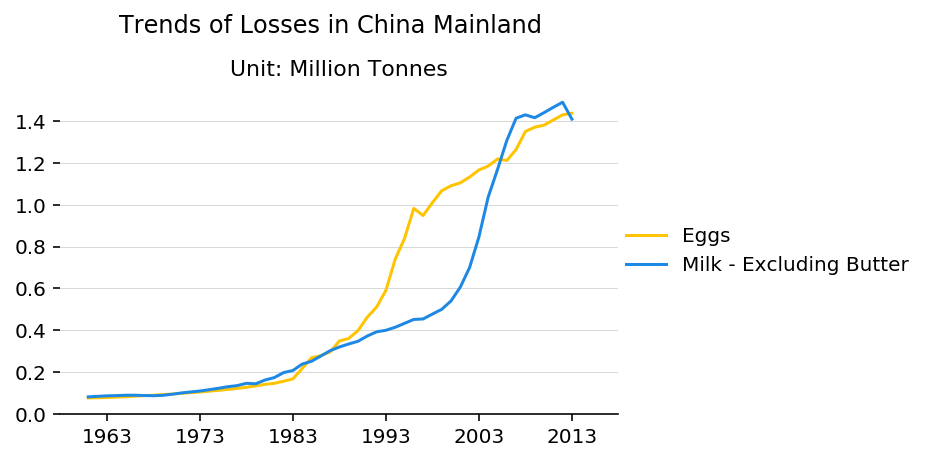

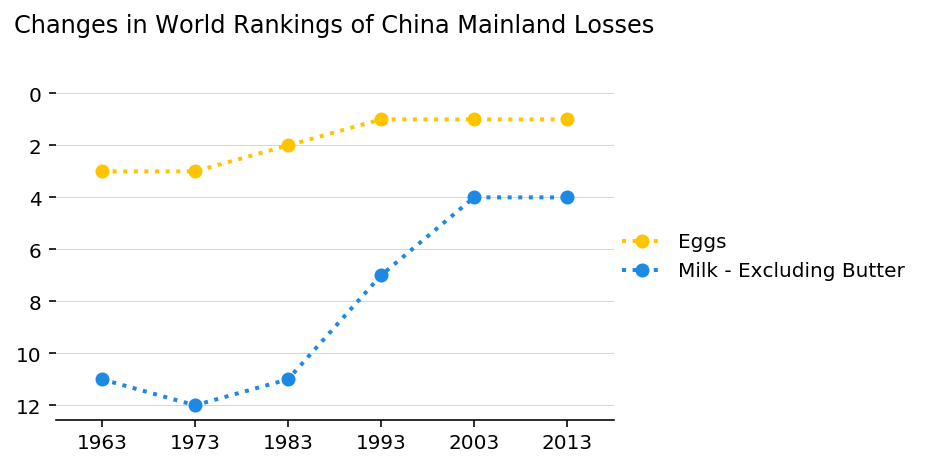

In [67]:
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000, colors=[Egg_yellow, Milk_blue])
ranking_AreaItemInWorld(A,E,colors=[Egg_yellow, Milk_blue])

In [68]:
worldMap(
    element=E,
    items_group='',
    items=['Eggs', 'Milk - Excluding Butter'],
    toUnit = 'Million Tonnes',
    changeUnit = 1/1000000,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='BuGn',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Losses_03_01_Losses _Eggs_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Losses_03_01_Losses _Eggs_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Losses_03_01_Losses _Eggs_2013.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Losses_03_01_Losses _Milk Excluding Butter_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Losses_03_01_Losses _Milk Excluding Butter_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/map/GroupbyElements_Losses_03_01_Losses _Milk Excluding Butter

1973    1993    2013
Argentina  0.0096  0.0133  0.0280
Australia  0.0019  0.0014  0.0024
Belgium       NaN     NaN  0.0045
Brazil     0.0119  0.0412  0.0723
Bulgaria   0.0008  0.0008  0.0055

1973    1993    2013
Area                             
Argentina  0.0375  0.0300  0.0490
Austria    0.0352  0.0327  0.0342
Brazil     0.3923  0.8113  1.6336
Bulgaria   0.0659  0.0262  0.0192
Chile      0.0243  0.0426  0.0588

OECD


Eggs  Milk - Excluding Butter
Year                                 
1961  0.2030                   1.5092
1962  0.2101                   1.5210
1963  0.2140                   1.4519
1964  0.2298                   1.5653
1965  0.2360                   1.5334

China, mainland: 


Eggs  Milk - Excluding Butter
1961  0.075                   0.0801
1962  0.076                   0.0827
1963  0.077                   0.0851
1964  0.079                   0.0861
1965  0.081                   0.0879

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Losses of Eggs of China Mainland with OECD Total.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_CommodityBalances_LivestockFish/img/GroupbyElements_03_02_Compare Losses of Milk Excluding Butter of China Mainland with OECD Total.png


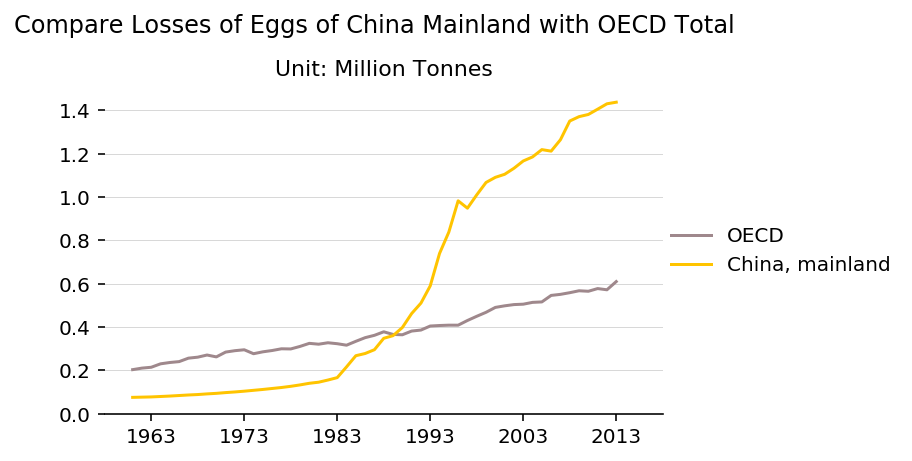

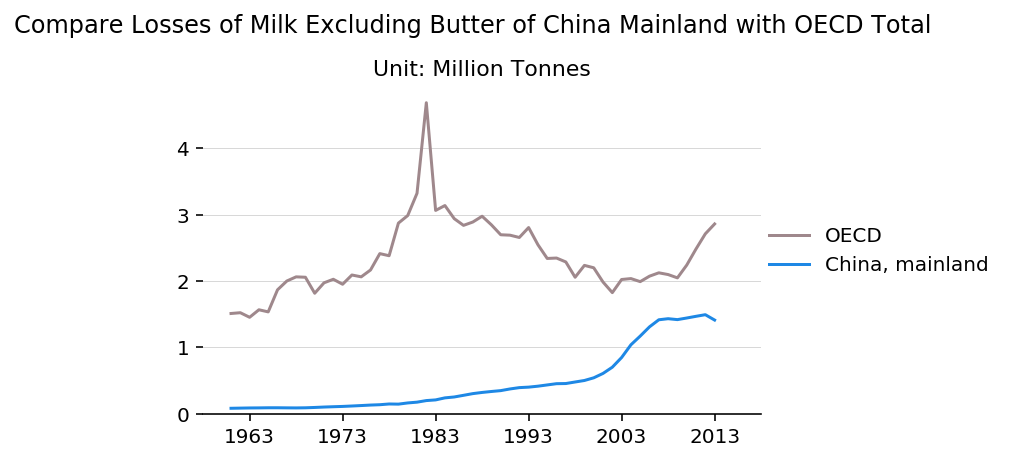

In [69]:
items = ['Eggs', 'Milk - Excluding Butter']
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

DATA_world = trendsOfArea('World', E, items=items)
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)

compareOtherAreasLine(
    area=A,
    element=E,
    df_area=DATA_area.copy(),
    dfs_compare={'OECD': DATA_OECD, }, 
    toUnit='Million Tonnes',
    changeUnit=1/1000000,
    colors=[Egg_yellow, Milk_blue],
    fig_size = FIG_size,
)